In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
import pandas as pd
sys.path.append(f"C:\\Users\\Administrator\\Documents\\ManhNH\\A_1")
from utilities import FX
import ta
sys.path.append(f"C:\\Users\\Administrator\\Documents\\ManhNH\\A_1\\strategy")
import m
import optuna

In [ ]:
df = pd.read_csv('./EURUSD.csv').drop(columns=['Unnamed: 0','real_volume'])
df['Datetime']=pd.to_datetime(df['Date'])
# df= df[df.Datetime.dt.year<=2023]
df

Date     Open     High      Low    Close  Volume  \
0        2010-01-03 21:00:00  1.43259  1.43259  1.43213  1.43222      28   
1        2010-01-03 21:01:00  1.43227  1.43242  1.43223  1.43241      12   
2        2010-01-03 21:02:00  1.43234  1.43244  1.43231  1.43235      22   
3        2010-01-03 21:03:00  1.43236  1.43237  1.43231  1.43231       5   
4        2010-01-03 21:04:00  1.43232  1.43235  1.43225  1.43235      14   
...                      ...      ...      ...      ...      ...     ...   
5318586  2024-05-06 02:48:00  1.07653  1.07663  1.07653  1.07661      18   
5318587  2024-05-06 02:49:00  1.07662  1.07662  1.07656  1.07659      13   
5318588  2024-05-06 02:50:00  1.07659  1.07663  1.07652  1.07652      15   
5318589  2024-05-06 02:51:00  1.07652  1.07653  1.07645  1.07646      27   
5318590  2024-05-06 02:52:00  1.07646  1.07647  1.07642  1.07646      14   

         spread            Datetime  
0            18 2010-01-03 21:00:00  
1            18 2010-01-03 21:01:00  
2            18 2010-01-03 21:02:00  
3            18 2010-01-03 21:03:00  
4            18 2010-01-03 21:04:00  
...         ...                 ...  
5318586      21 2024-05-06 02:48:00  
5318587      22 2024-05-06 02:49:00  
5318588      21 2024-05-06 02:50:00  
5318589      22 2024-05-06 02:51:00  
5318590      23 2024-05-06 02:52:00  

[5318591 rows x 8 columns]

In [ ]:
def determine_session(data):
    data['DayOfWeek']=data['Datetime'].dt.day_of_week

    data['Tokyo Session']=0
    data["London Session"]=0
    data["New York Session"]=0
    data["Sydney Session"]=0

    data.loc[(data['Datetime'].dt.hour >= 0) & (data['Datetime'].dt.hour <= 9 )   ,'Tokyo Session']=1
    data.loc[(data['Datetime'].dt.hour >= 7) & (data['Datetime'].dt.hour <= 16 ),"London Session"]=1
    data.loc[(data['Datetime'].dt.hour >= 13) & (data['Datetime'].dt.hour <= 21),"New York Session"]=1
    data.loc[(data['Datetime'].dt.hour >= 21) | (data['Datetime'].dt.hour < 6) ,"Sydney Session"]=1

    return data

In [ ]:
determine_session(df)

Date     Open     High      Low    Close  Volume  \
0        2010-01-03 21:00:00  1.43259  1.43259  1.43213  1.43222      28   
1        2010-01-03 21:01:00  1.43227  1.43242  1.43223  1.43241      12   
2        2010-01-03 21:02:00  1.43234  1.43244  1.43231  1.43235      22   
3        2010-01-03 21:03:00  1.43236  1.43237  1.43231  1.43231       5   
4        2010-01-03 21:04:00  1.43232  1.43235  1.43225  1.43235      14   
...                      ...      ...      ...      ...      ...     ...   
5318586  2024-05-06 02:48:00  1.07653  1.07663  1.07653  1.07661      18   
5318587  2024-05-06 02:49:00  1.07662  1.07662  1.07656  1.07659      13   
5318588  2024-05-06 02:50:00  1.07659  1.07663  1.07652  1.07652      15   
5318589  2024-05-06 02:51:00  1.07652  1.07653  1.07645  1.07646      27   
5318590  2024-05-06 02:52:00  1.07646  1.07647  1.07642  1.07646      14   

         spread            Datetime  Tokyo Session  London Session  \
0            18 2010-01-03 21:00:00              0               0   
1            18 2010-01-03 21:01:00              0               0   
2            18 2010-01-03 21:02:00              0               0   
3            18 2010-01-03 21:03:00              0               0   
4            18 2010-01-03 21:04:00              0               0   
...         ...                 ...            ...             ...   
5318586      21 2024-05-06 02:48:00              1               0   
5318587      22 2024-05-06 02:49:00              1               0   
5318588      21 2024-05-06 02:50:00              1               0   
5318589      22 2024-05-06 02:51:00              1               0   
5318590      23 2024-05-06 02:52:00              1               0   

         New York Session  Sydney Session  
0                       1               1  
1                       1               1  
2                       1               1  
3                       1               1  
4                       1               1  
...                   ...             ...  
5318586                 0               1  
5318587                 0               1  
5318588                 0               1  
5318589                 0               1  
5318590                 0               1  

[5318591 rows x 12 columns]

# Bot Tokyo seasion

## Stochastic RSI

In [ ]:

data=df.copy()
data=data.groupby([pd.Grouper(key='Datetime', freq='15T')]) \
        .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}) \
        .dropna().reset_index()
# def get_section(time):
#     if time.hour < 12:
#         return 0
#     else:
#         return 1
data['Position']=0
# data['season']=data['Datetime'].apply(get_section)
data['DayOfWeek']=data['Datetime'].dt.day_of_week

determine_session(data)
params={}
for i in range(5):
    def objective(trial):

        data_op=data.copy()

        window_short = trial.suggest_int('window_short',10, 100,2)
        window_long = trial.suggest_int('window_long', 10, 100,2)

        smooth1_long=trial.suggest_int('smooth1_long',10,100,2)
        smooth2_long=trial.suggest_int('smooth2_long',10,100,2)

        slope_long = trial.suggest_int('slope_long',1, 15,2)
        slope_short = trial.suggest_int('slope_short', 1, 15,2)

        smooth1_short=trial.suggest_int('smooth1_short',10,100,2)
        smooth2_short=trial.suggest_int('smooth2_short',10,100,2)

        data_op['RSI_long']=  ta.momentum.stochrsi_k(close=data_op['Close'],smooth1=smooth1_long,smooth2=smooth2_long,window=window_long,fillna=False)
        data_op['RSI_long_slope']=  data_op['RSI_long'].diff(slope_long)
        data_op['EMA_long']=  ta.momentum.stochrsi_d(close=data_op['Close'],smooth1=smooth1_long,smooth2=smooth2_long,window=window_long,fillna=False)

        data_op.loc[ (data_op['RSI_long_slope'] > 0) & (data_op['RSI_long'] > data_op['EMA_long']) & (data_op['DayOfWeek']==i) & (data_op['Tokyo Session']==1), 'Position'] = data_op['Position'] + 1

        data_op['RSI_short']=  ta.momentum.stochrsi_k(close=data_op['Close'],smooth1=smooth1_short,smooth2=smooth2_short,window=window_short,fillna=False)
        data_op['RSI_short_slope']=  data_op['RSI_short'].diff(slope_short)
        data_op['EMA_short']=  ta.momentum.stochrsi_d(close=data_op['Close'],smooth1=smooth1_short,smooth2=smooth2_short,window=window_short,fillna=False)

        data_op.loc[ (data_op['RSI_short_slope'] < 0) & (data_op['RSI_short'] < data_op['EMA_short']) & (data_op['DayOfWeek']==i) & (data_op['Tokyo Session']==1), 'Position'] = data_op['Position'] - 1

        try:
            test=data_op[(data_op['Datetime'].dt.year>=2010) & (data_op['Datetime'].dt.year<2024) ]
            backTestInfo = FX.BacktestInformation(test['Datetime'], test['Position'], test['Close'],fee=0)
            return backTestInfo.Sharp_percent_after_fee()
        except Exception as e:
            print(e)
            return 0


    param_file = "C:\\Users\\Administrator\\Documents\\ManhNH\\A_1\\Build_Alpha\\alpha_t3\\t0.txt"


    def logging_callback(study, frozen_trial):
        previous_best_value = study.user_attrs.get("previous_best_value", None)
        if previous_best_value != study.best_value:
            study.set_user_attr("previous_best_value", study.best_value)
            if frozen_trial.value > 1:
                with open(param_file, "a") as f:
                    f.write(f'{str(frozen_trial.params)} Value = {str(frozen_trial.value)}\n')


    with open(param_file, "a") as f:
        f.write(f'\n')

    direction = "maximize"
    study = optuna.create_study(direction=direction, pruner=m.DuplicatePruner())
    early_stopping = m.EarlyStoppingCallback(500, direction=direction)

    study.optimize(objective, callbacks=[early_stopping, logging_callback])
    print('finished', i, study.best_params)
    params.update({i:study.best_params})
params

[I 2024-05-15 17:20:53,637] A new study created in memory with name: no-name-ee36df85-9d57-4bf2-8b52-933ce782edbe
[I 2024-05-15 17:20:54,347] Trial 0 finished with value: -0.03164178140915156 and parameters: {'window_short': 60, 'window_long': 76, 'smooth1_long': 70, 'smooth2_long': 92, 'slope_long': 9, 'slope_short': 5, 'smooth1_short': 22, 'smooth2_short': 82}. Best is trial 0 with value: -0.03164178140915156.
[I 2024-05-15 17:20:55,029] Trial 1 finished with value: -0.09079597867897796 and parameters: {'window_short': 32, 'window_long': 98, 'smooth1_long': 74, 'smooth2_long': 70, 'slope_long': 15, 'slope_short': 9, 'smooth1_short': 76, 'smooth2_short': 58}. Best is trial 0 with value: -0.03164178140915156.
[I 2024-05-15 17:20:55,679] Trial 2 finished with value: 0.32761633431198145 and parameters: {'window_short': 94, 'window_long': 60, 'smooth1_long': 82, 'smooth2_long': 76, 'slope_long': 13, 'slope_short': 13, 'smooth1_short': 28, 'smooth2_short': 36}. Best is trial 2 with value: 

finished 0 {'window_short': 56, 'window_long': 74, 'smooth1_long': 36, 'smooth2_long': 24, 'slope_long': 11, 'slope_short': 9, 'smooth1_short': 46, 'smooth2_short': 14}


[I 2024-05-15 17:29:18,873] Trial 0 finished with value: -0.19231657158452842 and parameters: {'window_short': 64, 'window_long': 58, 'smooth1_long': 84, 'smooth2_long': 60, 'slope_long': 1, 'slope_short': 13, 'smooth1_short': 18, 'smooth2_short': 12}. Best is trial 0 with value: -0.19231657158452842.
[I 2024-05-15 17:29:19,557] Trial 1 finished with value: -0.08575461144088194 and parameters: {'window_short': 42, 'window_long': 34, 'smooth1_long': 82, 'smooth2_long': 20, 'slope_long': 15, 'slope_short': 13, 'smooth1_short': 42, 'smooth2_short': 46}. Best is trial 1 with value: -0.08575461144088194.
[I 2024-05-15 17:29:20,223] Trial 2 finished with value: 0.07334518645908358 and parameters: {'window_short': 72, 'window_long': 66, 'smooth1_long': 14, 'smooth2_long': 14, 'slope_long': 11, 'slope_short': 11, 'smooth1_short': 92, 'smooth2_short': 20}. Best is trial 2 with value: 0.07334518645908358.
[I 2024-05-15 17:29:20,964] Trial 3 finished with value: 0.1283636509104972 and parameters:

finished 1 {'window_short': 90, 'window_long': 76, 'smooth1_long': 90, 'smooth2_long': 78, 'slope_long': 5, 'slope_short': 3, 'smooth1_short': 98, 'smooth2_short': 76}


[I 2024-05-15 17:44:46,919] Trial 0 finished with value: -0.16794436291854886 and parameters: {'window_short': 56, 'window_long': 20, 'smooth1_long': 40, 'smooth2_long': 40, 'slope_long': 7, 'slope_short': 15, 'smooth1_short': 48, 'smooth2_short': 30}. Best is trial 0 with value: -0.16794436291854886.
[I 2024-05-15 17:44:47,546] Trial 1 finished with value: 0.03465257755378681 and parameters: {'window_short': 40, 'window_long': 22, 'smooth1_long': 48, 'smooth2_long': 88, 'slope_long': 11, 'slope_short': 9, 'smooth1_short': 56, 'smooth2_short': 24}. Best is trial 1 with value: 0.03465257755378681.
[I 2024-05-15 17:44:48,417] Trial 2 finished with value: -0.7128775223834007 and parameters: {'window_short': 30, 'window_long': 52, 'smooth1_long': 52, 'smooth2_long': 50, 'slope_long': 5, 'slope_short': 1, 'smooth1_short': 70, 'smooth2_short': 78}. Best is trial 1 with value: 0.03465257755378681.
[I 2024-05-15 17:44:49,119] Trial 3 finished with value: 0.16593300550041207 and parameters: {'w

finished 2 {'window_short': 36, 'window_long': 28, 'smooth1_long': 36, 'smooth2_long': 48, 'slope_long': 15, 'slope_short': 5, 'smooth1_short': 20, 'smooth2_short': 34}


[I 2024-05-15 17:55:44,316] Trial 0 finished with value: -0.06337455030388082 and parameters: {'window_short': 30, 'window_long': 58, 'smooth1_long': 34, 'smooth2_long': 26, 'slope_long': 15, 'slope_short': 11, 'smooth1_short': 64, 'smooth2_short': 34}. Best is trial 0 with value: -0.06337455030388082.
[I 2024-05-15 17:55:45,056] Trial 1 finished with value: -0.1802227238359618 and parameters: {'window_short': 46, 'window_long': 90, 'smooth1_long': 12, 'smooth2_long': 54, 'slope_long': 11, 'slope_short': 13, 'smooth1_short': 38, 'smooth2_short': 86}. Best is trial 0 with value: -0.06337455030388082.
[I 2024-05-15 17:55:45,651] Trial 2 finished with value: -0.17257496409557804 and parameters: {'window_short': 16, 'window_long': 52, 'smooth1_long': 44, 'smooth2_long': 94, 'slope_long': 5, 'slope_short': 5, 'smooth1_short': 58, 'smooth2_short': 98}. Best is trial 0 with value: -0.06337455030388082.
[I 2024-05-15 17:55:46,220] Trial 3 finished with value: -0.16660227658712604 and parameter

finished 3 {'window_short': 30, 'window_long': 10, 'smooth1_long': 22, 'smooth2_long': 58, 'slope_long': 15, 'slope_short': 7, 'smooth1_short': 34, 'smooth2_short': 22}


[I 2024-05-15 18:16:53,067] Trial 0 finished with value: -0.30264626679271905 and parameters: {'window_short': 52, 'window_long': 14, 'smooth1_long': 68, 'smooth2_long': 50, 'slope_long': 11, 'slope_short': 3, 'smooth1_short': 38, 'smooth2_short': 88}. Best is trial 0 with value: -0.30264626679271905.
[I 2024-05-15 18:16:53,773] Trial 1 finished with value: -0.21073031290803435 and parameters: {'window_short': 36, 'window_long': 44, 'smooth1_long': 42, 'smooth2_long': 56, 'slope_long': 7, 'slope_short': 11, 'smooth1_short': 56, 'smooth2_short': 32}. Best is trial 1 with value: -0.21073031290803435.
[I 2024-05-15 18:16:54,484] Trial 2 finished with value: -0.7074670955888372 and parameters: {'window_short': 34, 'window_long': 62, 'smooth1_long': 100, 'smooth2_long': 44, 'slope_long': 1, 'slope_short': 7, 'smooth1_short': 92, 'smooth2_short': 12}. Best is trial 1 with value: -0.21073031290803435.
[I 2024-05-15 18:16:55,079] Trial 3 finished with value: 0.1555763018192338 and parameters: 

finished 4 {'window_short': 40, 'window_long': 28, 'smooth1_long': 18, 'smooth2_long': 42, 'slope_long': 3, 'slope_short': 15, 'smooth1_short': 16, 'smooth2_short': 48}


{0: {'window_short': 56,
  'window_long': 74,
  'smooth1_long': 36,
  'smooth2_long': 24,
  'slope_long': 11,
  'slope_short': 9,
  'smooth1_short': 46,
  'smooth2_short': 14},
 1: {'window_short': 90,
  'window_long': 76,
  'smooth1_long': 90,
  'smooth2_long': 78,
  'slope_long': 5,
  'slope_short': 3,
  'smooth1_short': 98,
  'smooth2_short': 76},
 2: {'window_short': 36,
  'window_long': 28,
  'smooth1_long': 36,
  'smooth2_long': 48,
  'slope_long': 15,
  'slope_short': 5,
  'smooth1_short': 20,
  'smooth2_short': 34},
 3: {'window_short': 30,
  'window_long': 10,
  'smooth1_long': 22,
  'smooth2_long': 58,
  'slope_long': 15,
  'slope_short': 7,
  'smooth1_short': 34,
  'smooth2_short': 22},
 4: {'window_short': 40,
  'window_long': 28,
  'smooth1_long': 18,
  'smooth2_long': 42,
  'slope_long': 3,
  'slope_short': 15,
  'smooth1_short': 16,
  'smooth2_short': 48}}

Position
 0    248962
-1     54054
 1     52507
Name: count, dtype: int64
Margin: 0.4512001340198091
MDD: (0.04224000000000072, 0.030294988847370863)

   Total trading quantity: 6767
         Profit per trade: 0.0001056095758829608
             Total Profit: 0.7
         Profit after fee: 0.7
 Trading quantity per day: 1.8108108108108107
 Profit per day after fee: 0.00018731602890018732
                   Return: 0.04182775338033772
          Profit per year: 0.05832001826067108
                  HitRate: 0.44111127530663513
          HitRate per day: 0.4285331905781585


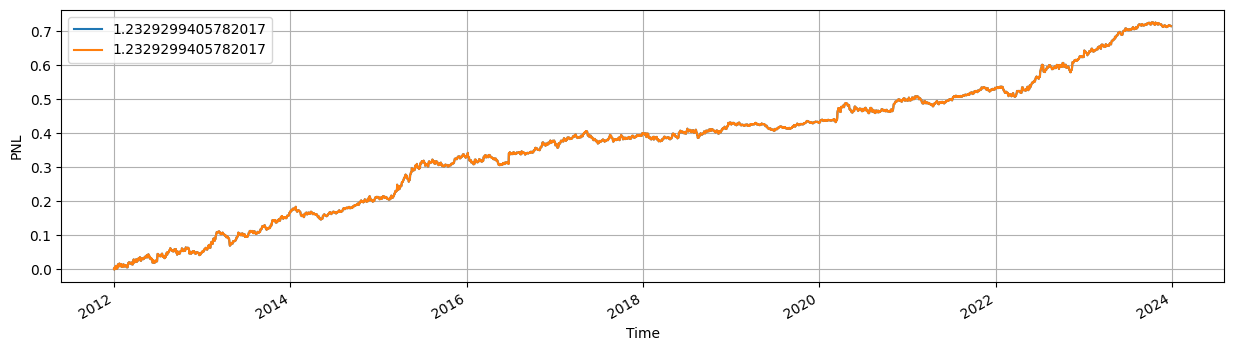

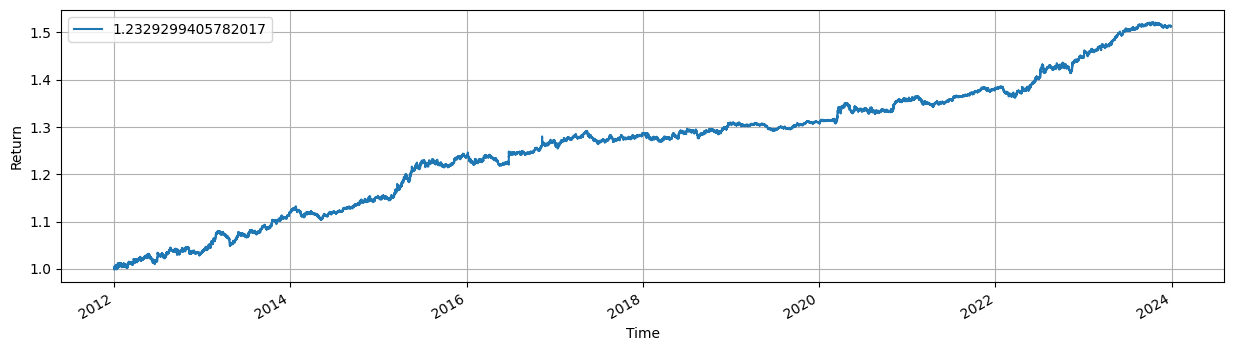

total_gain  fee  total_gain_after_fee  Position    Close  \
Datetime                                                                        
2012-01-01 21:00:00     0.00000  0.0               0.00000         0  1.29459   
2012-01-01 21:15:00     0.00000  0.0               0.00000         0  1.29419   
2012-01-01 21:30:00     0.00000  0.0               0.00000         0  1.29408   
2012-01-01 21:45:00     0.00000  0.0               0.00000         0  1.29429   
2012-01-01 22:00:00     0.00000  0.0               0.00000         0  1.29429   
...                         ...  ...                   ...       ...      ...   
2023-12-29 20:45:00     0.71466  0.0               0.71466         0  1.10391   
2023-12-29 21:00:00     0.71466  0.0               0.71466         0  1.10336   
2023-12-29 21:15:00     0.71466  0.0               0.71466         0  1.10345   
2023-12-29 21:30:00     0.71466  0.0               0.71466         0  1.10357   
2023-12-29 21:45:00     0.71466  0.0               0.71466         0  1.10371   

                       Return  
Datetime                       
2012-01-01 21:00:00  1.000000  
2012-01-01 21:15:00  1.000000  
2012-01-01 21:30:00  1.000000  
2012-01-01 21:45:00  1.000000  
2012-01-01 22:00:00  1.000000  
...                       ...  
2023-12-29 20:45:00  1.512562  
2023-12-29 21:00:00  1.512562  
2023-12-29 21:15:00  1.512562  
2023-12-29 21:30:00  1.512562  
2023-12-29 21:45:00  1.512562  

[297518 rows x 6 columns]

In [ ]:
data=df.copy()
data=data.groupby([pd.Grouper(key='Datetime', freq='15T')]) \
        .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}) \
        .dropna().reset_index()
def get_section(time):
    if time.hour < 12:
        return 0
    else:
        return 1
data['Position']=0
# data['season']=data['Datetime'].apply(get_section)
data['DayOfWeek']=data['Datetime'].dt.day_of_week

determine_session(data)
data['Position']=0
# params = {0: {'window_short': 28,   'window_long': 18,   'smooth1_long': 52,   'smooth2_long': 98,   'slope_long': 11,   'slope_short': 1,   'smooth1_short': 38,   'smooth2_short': 50},
#             1: {'window_short': 10,   'window_long': 22,   'smooth1_long': 34,   'smooth2_long': 60,   'slope_long': 7,   'slope_short': 5,   'smooth1_short': 36,   'smooth2_short': 34},
#             2: {'window_short': 14,   'window_long': 30,   'smooth1_long': 48,   'smooth2_long': 14,   'slope_long': 15,   'slope_short': 15,   'smooth1_short': 48,   'smooth2_short': 30},
#             3: {'window_short': 20,   'window_long': 28,   'smooth1_long': 52,   'smooth2_long': 98,   'slope_long': 15,   'slope_short': 9,   'smooth1_short': 14,   'smooth2_short': 20},
#             4: {'window_short': 22,   'window_long': 46,   'smooth1_long': 10,   'smooth2_long': 14,   'slope_long': 15,   'slope_short': 7,   'smooth1_short': 40,   'smooth2_short': 22}}

params={0: {'window_short': 56, 'window_long': 74,  'smooth1_long': 36,  'smooth2_long': 24,  'slope_long': 11,  'slope_short': 9,  'smooth1_short': 46,  'smooth2_short': 14},
        1: {'window_short': 90,  'window_long': 76,  'smooth1_long': 90,  'smooth2_long': 78,  'slope_long': 5,  'slope_short': 3,  'smooth1_short': 98,  'smooth2_short': 76},
        2: {'window_short': 36,  'window_long': 28,  'smooth1_long': 36,  'smooth2_long': 48,  'slope_long': 15,  'slope_short': 5, 'smooth1_short': 20,  'smooth2_short': 34},
        3: {'window_short': 30,  'window_long': 10,  'smooth1_long': 22,  'smooth2_long': 58,  'slope_long': 15,  'slope_short': 7,  'smooth1_short': 34,  'smooth2_short': 22},
        4: {'window_short': 40,  'window_long': 28,  'smooth1_long': 18,  'smooth2_long': 42,  'slope_long': 3,  'slope_short': 15,  'smooth1_short': 16,  'smooth2_short': 48}}
for i, param in params.items():
    data['RSI_long']=  ta.momentum.stochrsi_k(close=data['Close'],smooth1=param['smooth1_long'],smooth2=param['smooth2_long'],window=param['window_long'],fillna=False)
    data['EMA_long']=  ta.momentum.stochrsi_d(close=data['Close'],smooth1=param['smooth1_long'],smooth2=param['smooth2_long'],window=param['window_long'],fillna=False)
    data['RSI_long_slope']=  data['RSI_long'].diff(param['slope_long'])

    data.loc[ (data['RSI_long_slope'] > 0) & (data['RSI_long'] > data['EMA_long']) & (data['DayOfWeek']==i) & (data['Tokyo Session']==1), 'Position'] = data['Position'] + 1


    data['RSI_short']=  ta.momentum.stochrsi_k(close=data['Close'],smooth1=param['smooth1_short'],smooth2=param['smooth2_short'],window=param['window_short'],fillna=False)
    data['EMA_short']=  ta.momentum.stochrsi_d(close=data['Close'],smooth1=param['smooth1_short'],smooth2=param['smooth2_short'],window=param['window_short'],fillna=False)
    data['RSI_short_slope']=  data['RSI_short'].diff(param['slope_short'])

    data.loc[ (data['RSI_short_slope'] < 0) & (data['RSI_short'] < data['EMA_short']) & (data['DayOfWeek']==i) & (data['Tokyo Session']==1), 'Position'] = data['Position'] - 1
    # data.loc[(data['Position']<=1) & (data['Position']>=-1),'Position']=0

data.loc[data['Position']>0,'Position']=1
data.loc[data['Position']<0,'Position']=-1


test=data[(data['Datetime'].dt.year>=2012) & (data['Datetime'].dt.year<=2023)]
backTestInfo = FX.BacktestInformation(test['Datetime'], test['Position'], test['Close'],fee=0.0)
print(data['Position'].value_counts())
backTestInfo.Plot_PNL()

In [ ]:
def Stochastic_RSI(df):
    dt= df.copy()
    dt['Position']=0

    params={0: {'window_short': 56, 'window_long': 74,  'smooth1_long': 36,  'smooth2_long': 24,  'slope_long': 11,  'slope_short': 9,  'smooth1_short': 46,  'smooth2_short': 14},
            1: {'window_short': 90,  'window_long': 76,  'smooth1_long': 90,  'smooth2_long': 78,  'slope_long': 5,  'slope_short': 3,  'smooth1_short': 98,  'smooth2_short': 76},
            2: {'window_short': 36,  'window_long': 28,  'smooth1_long': 36,  'smooth2_long': 48,  'slope_long': 15,  'slope_short': 5, 'smooth1_short': 20,  'smooth2_short': 34},
            3: {'window_short': 30,  'window_long': 10,  'smooth1_long': 22,  'smooth2_long': 58,  'slope_long': 15,  'slope_short': 7,  'smooth1_short': 34,  'smooth2_short': 22},
            4: {'window_short': 40,  'window_long': 28,  'smooth1_long': 18,  'smooth2_long': 42,  'slope_long': 3,  'slope_short': 15,  'smooth1_short': 16,  'smooth2_short': 48}}
    for i, param in params.items():
        dt['RSI_long']=  ta.momentum.stochrsi_k(close=dt['Close'],smooth1=param['smooth1_long'],smooth2=param['smooth2_long'],window=param['window_long'],fillna=False)
        dt['EMA_long']=  ta.momentum.stochrsi_d(close=dt['Close'],smooth1=param['smooth1_long'],smooth2=param['smooth2_long'],window=param['window_long'],fillna=False)
        dt['RSI_long_slope']=  dt['RSI_long'].diff(param['slope_long'])

        dt.loc[ (dt['RSI_long_slope'] > 0) & (dt['RSI_long'] > dt['EMA_long']) & (dt['DayOfWeek']==i) & (dt['Tokyo Session']==1), 'Position'] = dt['Position'] + 1


        dt['RSI_short']=  ta.momentum.stochrsi_k(close=dt['Close'],smooth1=param['smooth1_short'],smooth2=param['smooth2_short'],window=param['window_short'],fillna=False)
        dt['EMA_short']=  ta.momentum.stochrsi_d(close=dt['Close'],smooth1=param['smooth1_short'],smooth2=param['smooth2_short'],window=param['window_short'],fillna=False)
        dt['RSI_short_slope']=  dt['RSI_short'].diff(param['slope_short'])

        dt.loc[ (dt['RSI_short_slope'] < 0) & (dt['RSI_short'] < dt['EMA_short']) & (dt['DayOfWeek']==i) & (dt['Tokyo Session']==1), 'Position'] = dt['Position'] - 1

    dt.loc[dt['Position']>0,'Position']=1
    dt.loc[dt['Position']<0,'Position']=-1
    return dt['Position']

## Awesome Oscillator

In [ ]:


data1=df.copy()
data1=data1.groupby([pd.Grouper(key='Datetime', freq='15T')]) \
        .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}) \
        .dropna().reset_index()
# def get_section(time):
#     if time.hour < 12:
#         return 0
#     else:
#         return 1
data1['Position']=0
# data1['season']=data1['Datetime'].apply(get_section)

data1['DayOfWeek']=data1['Datetime'].dt.day_of_week

determine_session(data1)
params={}
for i in range(5):
    def objective(trial):

        data1_op=data1.copy()

        window1_long = trial.suggest_int('window1_long', 5, 45)
        window2_long = trial.suggest_int('window2_long', 5, 45)

        window11_long = trial.suggest_int('window11_long', 5, 45)
        window12_long = trial.suggest_int('window12_long', 5, 45)

        window1_short = trial.suggest_int('window1_short', 5, 45)
        window2_short = trial.suggest_int('window2_short', 5, 45)

        window11_short = trial.suggest_int('window11_short', 5, 45)
        window12_short = trial.suggest_int('window12_short', 5, 45)

        diff_long=trial.suggest_int('diff_long',1,15)
        diff1_long=trial.suggest_int('diff1_long',1,15)

        diff_short=trial.suggest_int('diff_short',1,15)
        diff1_short=trial.suggest_int('diff1_short',1,15)

        data1_op['AO_long']=ta.momentum.AwesomeOscillatorIndicator(high=data1_op['High'], low=data1_op['Low'], window1=window1_long, window2=window2_long, fillna= False).awesome_oscillator().diff(diff_long)
        data1_op['AO1_long']=ta.momentum.AwesomeOscillatorIndicator(high=data1_op['High'], low=data1_op['Low'], window1=window11_long, window2=window12_long, fillna= False).awesome_oscillator().diff(diff1_long)


        data1_op['AO_short']=ta.momentum.AwesomeOscillatorIndicator(high=data1_op['High'], low=data1_op['Low'], window1=window1_short, window2=window2_short, fillna= False).awesome_oscillator().diff(diff_short)
        data1_op['AO1_short']=ta.momentum.AwesomeOscillatorIndicator(high=data1_op['High'], low=data1_op['Low'], window1=window11_short, window2=window12_short, fillna= False).awesome_oscillator().diff(diff1_short)

        data1_op.loc[ (data1_op['AO_long'] > 0) & (data1_op['AO1_long'] > 0) & (data1_op['DayOfWeek']==i)   & (data1_op['Tokyo Session']==1), 'Position'] = data1_op['Position'] + 1
        data1_op.loc[ (data1_op['AO_short'] < 0) & (data1_op['AO1_short'] < 0) & (data1_op['DayOfWeek']==i) & (data1_op['Tokyo Session']==1), 'Position'] = data1_op['Position'] - 1
        try:
            test=data1_op[(data1_op['Datetime'].dt.year>=2010) & (data1_op['Datetime'].dt.year<2024) ]
            backTestInfo = FX.BacktestInformation(test['Datetime'], test['Position'], test['Close'],fee=0)
            return backTestInfo.Sharp_percent_after_fee()
        except Exception as e:
            print(e)
            return 0


    param_file = "C:\\Users\\Administrator\\Documents\\ManhNH\\A_1\\Build_Alpha\\alpha_t3\\t0.txt"


    def logging_callback(study, frozen_trial):
        previous_best_value = study.user_attrs.get("previous_best_value", None)
        if previous_best_value != study.best_value:
            study.set_user_attr("previous_best_value", study.best_value)
            if frozen_trial.value > 1:
                with open(param_file, "a") as f:
                    f.write(f'{str(frozen_trial.params)} Value = {str(frozen_trial.value)}\n')


    with open(param_file, "a") as f:
        f.write(f'\n')

    direction = "maximize"
    study = optuna.create_study(direction=direction, pruner=m.DuplicatePruner())
    early_stopping = m.EarlyStoppingCallback(500, direction=direction)

    study.optimize(objective, callbacks=[early_stopping, logging_callback])
    print('finished', i, study.best_params)
    params.update({i:study.best_params})
params

[I 2024-05-15 18:36:17,820] A new study created in memory with name: no-name-efee45b8-43df-4fdd-8d24-d927c0448fe6
[I 2024-05-15 18:36:18,113] Trial 0 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 16, 'window11_long': 32, 'window12_long': 24, 'window1_short': 34, 'window2_short': 8, 'window11_short': 37, 'window12_short': 44, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:18,493] Trial 1 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 39, 'window11_long': 17, 'window12_long': 8, 'window1_short': 22, 'window2_short': 39, 'window11_short': 8, 'window12_short': 12, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:18,859] Trial 2 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 32, 'window11_long': 42, 'window12_long': 42, 'window1_short': 10, 'window2_short': 9, 'window11_short': 36, 'window12_short': 33, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:19,174] Trial 3 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 22, 'window11_long': 31, 'window12_long': 37, 'window1_short': 37, 'window2_short': 40, 'window11_short': 13, 'window12_short': 38, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:19,540] Trial 4 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 35, 'window11_long': 5, 'window12_long': 39, 'window1_short': 27, 'window2_short': 42, 'window11_short': 16, 'window12_short': 45, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:19,988] Trial 5 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 17, 'window11_long': 6, 'window12_long': 22, 'window1_short': 21, 'window2_short': 22, 'window11_short': 28, 'window12_short': 35, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:20,276] Trial 6 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 11, 'window11_long': 5, 'window12_long': 37, 'window1_short': 36, 'window2_short': 43, 'window11_short': 19, 'window12_short': 14, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:20,579] Trial 7 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 14, 'window11_long': 44, 'window12_long': 23, 'window1_short': 19, 'window2_short': 5, 'window11_short': 21, 'window12_short': 9, 'diff_long': 13, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:20,886] Trial 8 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 15, 'window11_long': 24, 'window12_long': 26, 'window1_short': 21, 'window2_short': 14, 'window11_short': 25, 'window12_short': 36, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:21,205] Trial 9 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 39, 'window11_long': 22, 'window12_long': 39, 'window1_short': 40, 'window2_short': 16, 'window11_short': 35, 'window12_short': 12, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:21,578] Trial 10 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 6, 'window11_long': 34, 'window12_long': 10, 'window1_short': 31, 'window2_short': 29, 'window11_short': 45, 'window12_short': 24, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:21,921] Trial 11 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 45, 'window11_long': 16, 'window12_long': 5, 'window1_short': 12, 'window2_short': 32, 'window11_short': 5, 'window12_short': 19, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:22,223] Trial 12 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 26, 'window11_long': 16, 'window12_long': 13, 'window1_short': 30, 'window2_short': 34, 'window11_short': 8, 'window12_short': 5, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:22,597] Trial 13 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 25, 'window11_long': 33, 'window12_long': 30, 'window1_short': 45, 'window2_short': 23, 'window11_short': 45, 'window12_short': 25, 'diff_long': 11, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:23,002] Trial 14 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 43, 'window11_long': 16, 'window12_long': 17, 'window1_short': 15, 'window2_short': 36, 'window11_short': 34, 'window12_short': 45, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:23,329] Trial 15 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 30, 'window11_long': 29, 'window12_long': 5, 'window1_short': 24, 'window2_short': 18, 'window11_short': 39, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:23,695] Trial 16 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 22, 'window11_long': 39, 'window12_long': 31, 'window1_short': 6, 'window2_short': 27, 'window11_short': 28, 'window12_short': 31, 'diff_long': 15, 'diff1_long': 12, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:23,996] Trial 17 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 5, 'window11_long': 21, 'window12_long': 16, 'window1_short': 33, 'window2_short': 38, 'window11_short': 12, 'window12_short': 29, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:24,304] Trial 18 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 37, 'window11_long': 10, 'window12_long': 19, 'window1_short': 25, 'window2_short': 45, 'window11_short': 40, 'window12_short': 40, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:24,631] Trial 19 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 19, 'window11_long': 28, 'window12_long': 11, 'window1_short': 43, 'window2_short': 10, 'window11_short': 31, 'window12_short': 20, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:24,944] Trial 20 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 29, 'window11_long': 37, 'window12_long': 29, 'window1_short': 16, 'window2_short': 20, 'window11_short': 23, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:25,321] Trial 21 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 33, 'window11_long': 42, 'window12_long': 44, 'window1_short': 5, 'window2_short': 5, 'window11_short': 39, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:25,654] Trial 22 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 40, 'window11_long': 38, 'window12_long': 43, 'window1_short': 9, 'window2_short': 11, 'window11_short': 35, 'window12_short': 41, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:26,043] Trial 23 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 32, 'window11_long': 45, 'window12_long': 34, 'window1_short': 12, 'window2_short': 9, 'window11_short': 41, 'window12_short': 28, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:26,450] Trial 24 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 40, 'window11_long': 19, 'window12_long': 26, 'window1_short': 29, 'window2_short': 13, 'window11_short': 31, 'window12_short': 34, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:26,840] Trial 25 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 10, 'window11_long': 41, 'window12_long': 22, 'window1_short': 34, 'window2_short': 9, 'window11_short': 31, 'window12_short': 41, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 10, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:27,166] Trial 26 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 28, 'window11_long': 26, 'window12_long': 8, 'window1_short': 17, 'window2_short': 29, 'window11_short': 37, 'window12_short': 23, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:27,600] Trial 27 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 37, 'window11_long': 12, 'window12_long': 14, 'window1_short': 23, 'window2_short': 7, 'window11_short': 42, 'window12_short': 7, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:27,928] Trial 28 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 20, 'window11_long': 36, 'window12_long': 34, 'window1_short': 12, 'window2_short': 15, 'window11_short': 26, 'window12_short': 33, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:28,343] Trial 29 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 25, 'window11_long': 32, 'window12_long': 19, 'window1_short': 39, 'window2_short': 19, 'window11_short': 12, 'window12_short': 39, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:28,751] Trial 30 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 42, 'window11_long': 29, 'window12_long': 42, 'window1_short': 28, 'window2_short': 25, 'window11_short': 17, 'window12_short': 37, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:29,120] Trial 31 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 22, 'window11_long': 32, 'window12_long': 40, 'window1_short': 37, 'window2_short': 38, 'window11_short': 13, 'window12_short': 45, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:29,531] Trial 32 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 34, 'window11_long': 27, 'window12_long': 45, 'window1_short': 41, 'window2_short': 40, 'window11_short': 8, 'window12_short': 42, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:29,843] Trial 33 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 17, 'window11_long': 35, 'window12_long': 35, 'window1_short': 36, 'window2_short': 41, 'window11_short': 15, 'window12_short': 38, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:30,198] Trial 34 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 12, 'window11_long': 31, 'window12_long': 38, 'window1_short': 32, 'window2_short': 45, 'window11_short': 6, 'window12_short': 43, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 9, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:30,552] Trial 35 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 36, 'window11_long': 40, 'window12_long': 42, 'window1_short': 20, 'window2_short': 35, 'window11_short': 9, 'window12_short': 35, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:30,937] Trial 36 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 22, 'window11_long': 24, 'window12_long': 28, 'window1_short': 26, 'window2_short': 38, 'window11_short': 19, 'window12_short': 27, 'diff_long': 13, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:31,269] Trial 37 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 31, 'window11_long': 9, 'window12_long': 40, 'window1_short': 35, 'window2_short': 32, 'window11_short': 20, 'window12_short': 32, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:31,663] Trial 38 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 15, 'window11_long': 19, 'window12_long': 36, 'window1_short': 37, 'window2_short': 43, 'window11_short': 10, 'window12_short': 37, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:31,985] Trial 39 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 9, 'window11_long': 22, 'window12_long': 32, 'window1_short': 22, 'window2_short': 7, 'window11_short': 23, 'window12_short': 15, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:32,423] Trial 40 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 18, 'window11_long': 42, 'window12_long': 24, 'window1_short': 18, 'window2_short': 17, 'window11_short': 43, 'window12_short': 12, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:32,780] Trial 41 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 35, 'window11_long': 12, 'window12_long': 37, 'window1_short': 39, 'window2_short': 42, 'window11_short': 16, 'window12_short': 43, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:33,096] Trial 42 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 38, 'window11_long': 30, 'window12_long': 40, 'window1_short': 27, 'window2_short': 40, 'window11_short': 6, 'window12_short': 45, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:33,460] Trial 43 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 27, 'window11_long': 8, 'window12_long': 33, 'window1_short': 32, 'window2_short': 13, 'window11_short': 14, 'window12_short': 36, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:33,830] Trial 44 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 25, 'window11_long': 5, 'window12_long': 38, 'window1_short': 30, 'window2_short': 32, 'window11_short': 11, 'window12_short': 43, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:34,177] Trial 45 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 41, 'window11_long': 34, 'window12_long': 20, 'window1_short': 8, 'window2_short': 37, 'window11_short': 17, 'window12_short': 38, 'diff_long': 14, 'diff1_long': 7, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:34,511] Trial 46 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 14, 'window11_long': 14, 'window12_long': 28, 'window1_short': 14, 'window2_short': 34, 'window11_short': 33, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 14, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:34,952] Trial 47 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 44, 'window11_long': 7, 'window12_long': 42, 'window1_short': 20, 'window2_short': 23, 'window11_short': 37, 'window12_short': 44, 'diff_long': 13, 'diff1_long': 2, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:35,332] Trial 48 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 23, 'window11_long': 25, 'window12_long': 45, 'window1_short': 42, 'window2_short': 44, 'window11_short': 37, 'window12_short': 12, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:35,737] Trial 49 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 30, 'window11_long': 19, 'window12_long': 9, 'window1_short': 25, 'window2_short': 40, 'window11_short': 29, 'window12_short': 40, 'diff_long': 11, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:36,170] Trial 50 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 33, 'window11_long': 22, 'window12_long': 13, 'window1_short': 45, 'window2_short': 31, 'window11_short': 8, 'window12_short': 21, 'diff_long': 1, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:36,517] Trial 51 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 16, 'window11_long': 6, 'window12_long': 22, 'window1_short': 24, 'window2_short': 21, 'window11_short': 25, 'window12_short': 30, 'diff_long': 10, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:36,910] Trial 52 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 13, 'window11_long': 11, 'window12_long': 16, 'window1_short': 22, 'window2_short': 27, 'window11_short': 28, 'window12_short': 17, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:37,293] Trial 53 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 20, 'window11_long': 15, 'window12_long': 26, 'window1_short': 10, 'window2_short': 6, 'window11_short': 33, 'window12_short': 34, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:37,660] Trial 54 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 39, 'window11_long': 7, 'window12_long': 30, 'window1_short': 19, 'window2_short': 12, 'window11_short': 23, 'window12_short': 35, 'diff_long': 11, 'diff1_long': 13, 'diff_short': 5, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:37,996] Trial 55 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 7, 'window11_long': 5, 'window12_long': 21, 'window1_short': 30, 'window2_short': 16, 'window11_short': 35, 'window12_short': 10, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:38,305] Trial 56 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 20, 'window11_long': 38, 'window12_long': 6, 'window1_short': 27, 'window2_short': 9, 'window11_short': 5, 'window12_short': 41, 'diff_long': 10, 'diff1_long': 11, 'diff_short': 15, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:38,687] Trial 57 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 18, 'window11_long': 44, 'window12_long': 25, 'window1_short': 14, 'window2_short': 22, 'window11_short': 44, 'window12_short': 28, 'diff_long': 13, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:39,028] Trial 58 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 35, 'window11_long': 10, 'window12_long': 11, 'window1_short': 34, 'window2_short': 42, 'window11_short': 19, 'window12_short': 25, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:39,416] Trial 59 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 24, 'window11_long': 27, 'window12_long': 18, 'window1_short': 7, 'window2_short': 26, 'window11_short': 38, 'window12_short': 32, 'diff_long': 7, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:39,789] Trial 60 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 28, 'window11_long': 17, 'window12_long': 23, 'window1_short': 16, 'window2_short': 29, 'window11_short': 13, 'window12_short': 6, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:40,151] Trial 61 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 10, 'window11_long': 8, 'window12_long': 36, 'window1_short': 37, 'window2_short': 44, 'window11_short': 18, 'window12_short': 16, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:40,531] Trial 62 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 11, 'window11_long': 5, 'window12_long': 39, 'window1_short': 40, 'window2_short': 39, 'window11_short': 22, 'window12_short': 14, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:40,961] Trial 63 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 8, 'window11_long': 13, 'window12_long': 43, 'window1_short': 32, 'window2_short': 36, 'window11_short': 25, 'window12_short': 18, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:41,289] Trial 64 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 16, 'window11_long': 9, 'window12_long': 32, 'window1_short': 35, 'window2_short': 42, 'window11_short': 15, 'window12_short': 39, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:41,702] Trial 65 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 13, 'window11_long': 33, 'window12_long': 41, 'window1_short': 38, 'window2_short': 11, 'window11_short': 40, 'window12_short': 10, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:42,088] Trial 66 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 37, 'window11_long': 7, 'window12_long': 38, 'window1_short': 29, 'window2_short': 45, 'window11_short': 27, 'window12_short': 8, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:42,501] Trial 67 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 21, 'window11_long': 24, 'window12_long': 34, 'window1_short': 33, 'window2_short': 5, 'window11_short': 11, 'window12_short': 42, 'diff_long': 3, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:42,932] Trial 68 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 18, 'window11_long': 35, 'window12_long': 27, 'window1_short': 23, 'window2_short': 43, 'window11_short': 21, 'window12_short': 36, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:43,266] Trial 69 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 45, 'window11_long': 29, 'window12_long': 30, 'window1_short': 11, 'window2_short': 8, 'window11_short': 32, 'window12_short': 44, 'diff_long': 1, 'diff1_long': 6, 'diff_short': 3, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:43,576] Trial 70 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 39, 'window11_long': 37, 'window12_long': 44, 'window1_short': 43, 'window2_short': 39, 'window11_short': 36, 'window12_short': 23, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:43,920] Trial 71 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 12, 'window11_long': 44, 'window12_long': 23, 'window1_short': 20, 'window2_short': 10, 'window11_short': 20, 'window12_short': 5, 'diff_long': 14, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:44,268] Trial 72 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 15, 'window11_long': 45, 'window12_long': 25, 'window1_short': 21, 'window2_short': 5, 'window11_short': 16, 'window12_short': 11, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:44,740] Trial 73 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 14, 'window11_long': 40, 'window12_long': 20, 'window1_short': 18, 'window2_short': 7, 'window11_short': 18, 'window12_short': 10, 'diff_long': 12, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:45,081] Trial 74 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 5, 'window11_long': 41, 'window12_long': 36, 'window1_short': 5, 'window2_short': 14, 'window11_short': 15, 'window12_short': 13, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:45,396] Trial 75 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 17, 'window11_long': 43, 'window12_long': 14, 'window1_short': 25, 'window2_short': 41, 'window11_short': 24, 'window12_short': 8, 'diff_long': 14, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:45,828] Trial 76 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 33, 'window11_long': 6, 'window12_long': 40, 'window1_short': 36, 'window2_short': 34, 'window11_short': 30, 'window12_short': 8, 'diff_long': 13, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:46,185] Trial 77 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 42, 'window11_long': 17, 'window12_long': 37, 'window1_short': 23, 'window2_short': 6, 'window11_short': 21, 'window12_short': 38, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:46,669] Trial 78 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 36, 'window11_long': 31, 'window12_long': 16, 'window1_short': 17, 'window2_short': 18, 'window11_short': 13, 'window12_short': 42, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:47,008] Trial 79 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 11, 'window11_long': 10, 'window12_long': 39, 'window1_short': 21, 'window2_short': 8, 'window11_short': 7, 'window12_short': 33, 'diff_long': 11, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:47,407] Trial 80 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 15, 'window11_long': 39, 'window12_long': 7, 'window1_short': 28, 'window2_short': 36, 'window11_short': 10, 'window12_short': 45, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:47,815] Trial 81 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 13, 'window11_long': 21, 'window12_long': 23, 'window1_short': 24, 'window2_short': 10, 'window11_short': 27, 'window12_short': 39, 'diff_long': 12, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:48,185] Trial 82 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 19, 'window11_long': 26, 'window12_long': 28, 'window1_short': 19, 'window2_short': 12, 'window11_short': 22, 'window12_short': 36, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:48,615] Trial 83 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 26, 'window11_long': 23, 'window12_long': 26, 'window1_short': 22, 'window2_short': 8, 'window11_short': 17, 'window12_short': 31, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:48,983] Trial 84 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 16, 'window11_long': 42, 'window12_long': 41, 'window1_short': 14, 'window2_short': 14, 'window11_short': 34, 'window12_short': 34, 'diff_long': 8, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:49,307] Trial 85 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 32, 'window11_long': 30, 'window12_long': 17, 'window1_short': 26, 'window2_short': 19, 'window11_short': 19, 'window12_short': 35, 'diff_long': 10, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:49,709] Trial 86 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 14, 'window11_long': 20, 'window12_long': 21, 'window1_short': 39, 'window2_short': 6, 'window11_short': 41, 'window12_short': 37, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:50,138] Trial 87 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 9, 'window11_long': 6, 'window12_long': 24, 'window1_short': 21, 'window2_short': 41, 'window11_short': 24, 'window12_short': 27, 'diff_long': 5, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:50,486] Trial 88 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 23, 'window11_long': 8, 'window12_long': 35, 'window1_short': 16, 'window2_short': 23, 'window11_short': 14, 'window12_short': 21, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:50,934] Trial 89 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 17, 'window11_long': 28, 'window12_long': 29, 'window1_short': 19, 'window2_short': 44, 'window11_short': 20, 'window12_short': 44, 'diff_long': 13, 'diff1_long': 1, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:51,298] Trial 90 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 40, 'window11_long': 36, 'window12_long': 32, 'window1_short': 41, 'window2_short': 16, 'window11_short': 26, 'window12_short': 14, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:51,673] Trial 91 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 39, 'window11_long': 25, 'window12_long': 43, 'window1_short': 35, 'window2_short': 25, 'window11_short': 38, 'window12_short': 9, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:52,118] Trial 92 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 38, 'window11_long': 23, 'window12_long': 39, 'window1_short': 38, 'window2_short': 20, 'window11_short': 34, 'window12_short': 12, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:52,488] Trial 93 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 43, 'window11_long': 17, 'window12_long': 41, 'window1_short': 31, 'window2_short': 11, 'window11_short': 36, 'window12_short': 11, 'diff_long': 13, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:52,904] Trial 94 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 35, 'window11_long': 21, 'window12_long': 38, 'window1_short': 40, 'window2_short': 9, 'window11_short': 32, 'window12_short': 6, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 9, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:53,254] Trial 95 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 41, 'window11_long': 18, 'window12_long': 37, 'window1_short': 44, 'window2_short': 39, 'window11_short': 30, 'window12_short': 40, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:53,584] Trial 96 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 12, 'window11_long': 15, 'window12_long': 5, 'window1_short': 24, 'window2_short': 15, 'window11_short': 38, 'window12_short': 15, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:54,064] Trial 97 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 19, 'window11_long': 5, 'window12_long': 10, 'window1_short': 34, 'window2_short': 43, 'window11_short': 40, 'window12_short': 32, 'diff_long': 11, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:54,391] Trial 98 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 31, 'window11_long': 27, 'window12_long': 42, 'window1_short': 18, 'window2_short': 13, 'window11_short': 16, 'window12_short': 30, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:54,825] Trial 99 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 36, 'window11_long': 25, 'window12_long': 34, 'window1_short': 38, 'window2_short': 18, 'window11_short': 18, 'window12_short': 13, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:55,133] Trial 100 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 38, 'window11_long': 32, 'window12_long': 44, 'window1_short': 13, 'window2_short': 38, 'window11_short': 9, 'window12_short': 41, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:55,510] Trial 101 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 5, 'window11_long': 34, 'window12_long': 12, 'window1_short': 36, 'window2_short': 30, 'window11_short': 44, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:55,957] Trial 102 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 21, 'window11_long': 33, 'window12_long': 19, 'window1_short': 27, 'window2_short': 40, 'window11_short': 35, 'window12_short': 25, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:56,276] Trial 103 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 8, 'window11_long': 28, 'window12_long': 8, 'window1_short': 32, 'window2_short': 28, 'window11_short': 42, 'window12_short': 33, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:56,632] Trial 104 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 15, 'window11_long': 44, 'window12_long': 9, 'window1_short': 33, 'window2_short': 25, 'window11_short': 45, 'window12_short': 43, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:57,037] Trial 105 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 6, 'window11_long': 30, 'window12_long': 22, 'window1_short': 29, 'window2_short': 17, 'window11_short': 39, 'window12_short': 19, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:57,417] Trial 106 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 10, 'window11_long': 11, 'window12_long': 24, 'window1_short': 31, 'window2_short': 33, 'window11_short': 12, 'window12_short': 37, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:57,799] Trial 107 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 11, 'window11_long': 7, 'window12_long': 35, 'window1_short': 35, 'window2_short': 22, 'window11_short': 22, 'window12_short': 9, 'diff_long': 9, 'diff1_long': 9, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:58,181] Trial 108 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 34, 'window11_long': 41, 'window12_long': 21, 'window1_short': 34, 'window2_short': 43, 'window11_short': 28, 'window12_short': 13, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:58,525] Trial 109 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 29, 'window11_long': 45, 'window12_long': 27, 'window1_short': 37, 'window2_short': 37, 'window11_short': 21, 'window12_short': 11, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:58,986] Trial 110 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 14, 'window11_long': 31, 'window12_long': 39, 'window1_short': 22, 'window2_short': 6, 'window11_short': 24, 'window12_short': 23, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:59,413] Trial 111 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 42, 'window11_long': 20, 'window12_long': 6, 'window1_short': 9, 'window2_short': 28, 'window11_short': 5, 'window12_short': 16, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:36:59,855] Trial 112 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 18, 'window11_long': 14, 'window12_long': 6, 'window1_short': 7, 'window2_short': 42, 'window11_short': 7, 'window12_short': 24, 'diff_long': 13, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:00,236] Trial 113 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 44, 'window11_long': 24, 'window12_long': 5, 'window1_short': 11, 'window2_short': 31, 'window11_short': 8, 'window12_short': 21, 'diff_long': 12, 'diff1_long': 3, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:00,577] Trial 114 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 16, 'window11_long': 26, 'window12_long': 7, 'window1_short': 9, 'window2_short': 24, 'window11_short': 6, 'window12_short': 26, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:00,942] Trial 115 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 45, 'window11_long': 22, 'window12_long': 8, 'window1_short': 26, 'window2_short': 35, 'window11_short': 36, 'window12_short': 19, 'diff_long': 13, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:01,397] Trial 116 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 37, 'window11_long': 9, 'window12_long': 15, 'window1_short': 23, 'window2_short': 26, 'window11_short': 14, 'window12_short': 35, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:01,748] Trial 117 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 41, 'window11_long': 43, 'window12_long': 25, 'window1_short': 11, 'window2_short': 45, 'window11_short': 29, 'window12_short': 45, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:02,099] Trial 118 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 7, 'window11_long': 5, 'window12_long': 10, 'window1_short': 21, 'window2_short': 7, 'window11_short': 33, 'window12_short': 29, 'diff_long': 10, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:02,412] Trial 119 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 12, 'window11_long': 34, 'window12_long': 40, 'window1_short': 15, 'window2_short': 9, 'window11_short': 19, 'window12_short': 38, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:02,807] Trial 120 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 26, 'window11_long': 6, 'window12_long': 37, 'window1_short': 20, 'window2_short': 40, 'window11_short': 17, 'window12_short': 22, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:03,213] Trial 121 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 24, 'window11_long': 16, 'window12_long': 13, 'window1_short': 28, 'window2_short': 34, 'window11_short': 10, 'window12_short': 5, 'diff_long': 15, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:03,574] Trial 122 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 29, 'window11_long': 12, 'window12_long': 10, 'window1_short': 30, 'window2_short': 30, 'window11_short': 9, 'window12_short': 6, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:03,956] Trial 123 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 32, 'window11_long': 38, 'window12_long': 7, 'window1_short': 25, 'window2_short': 32, 'window11_short': 6, 'window12_short': 9, 'diff_long': 13, 'diff1_long': 14, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:04,358] Trial 124 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 17, 'window11_long': 18, 'window12_long': 11, 'window1_short': 31, 'window2_short': 41, 'window11_short': 5, 'window12_short': 7, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:04,786] Trial 125 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 34, 'window11_long': 15, 'window12_long': 9, 'window1_short': 28, 'window2_short': 33, 'window11_short': 11, 'window12_short': 14, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:05,260] Trial 126 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 27, 'window11_long': 13, 'window12_long': 41, 'window1_short': 40, 'window2_short': 37, 'window11_short': 42, 'window12_short': 34, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:05,606] Trial 127 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 31, 'window11_long': 36, 'window12_long': 20, 'window1_short': 36, 'window2_short': 12, 'window11_short': 27, 'window12_short': 12, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:05,922] Trial 128 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 19, 'window11_long': 23, 'window12_long': 23, 'window1_short': 33, 'window2_short': 31, 'window11_short': 7, 'window12_short': 10, 'diff_long': 14, 'diff1_long': 2, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:06,247] Trial 129 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 21, 'window11_long': 16, 'window12_long': 12, 'window1_short': 12, 'window2_short': 10, 'window11_short': 8, 'window12_short': 36, 'diff_long': 6, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:06,679] Trial 130 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 13, 'window11_long': 20, 'window12_long': 36, 'window1_short': 42, 'window2_short': 5, 'window11_short': 37, 'window12_short': 41, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:07,003] Trial 131 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 23, 'window11_long': 33, 'window12_long': 27, 'window1_short': 45, 'window2_short': 21, 'window11_short': 43, 'window12_short': 26, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 4, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:07,406] Trial 132 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 24, 'window11_long': 32, 'window12_long': 26, 'window1_short': 37, 'window2_short': 24, 'window11_short': 16, 'window12_short': 24, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:07,798] Trial 133 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 15, 'window11_long': 8, 'window12_long': 30, 'window1_short': 30, 'window2_short': 42, 'window11_short': 45, 'window12_short': 20, 'diff_long': 13, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:08,154] Trial 134 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 28, 'window11_long': 29, 'window12_long': 38, 'window1_short': 43, 'window2_short': 27, 'window11_short': 44, 'window12_short': 39, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:08,557] Trial 135 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 25, 'window11_long': 35, 'window12_long': 24, 'window1_short': 19, 'window2_short': 19, 'window11_short': 41, 'window12_short': 28, 'diff_long': 11, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:08,931] Trial 136 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 22, 'window11_long': 31, 'window12_long': 31, 'window1_short': 39, 'window2_short': 23, 'window11_short': 12, 'window12_short': 44, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:09,289] Trial 137 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 14, 'window11_long': 37, 'window12_long': 33, 'window1_short': 33, 'window2_short': 39, 'window11_short': 43, 'window12_short': 18, 'diff_long': 15, 'diff1_long': 3, 'diff_short': 3, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:09,655] Trial 138 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 40, 'window11_long': 18, 'window12_long': 18, 'window1_short': 41, 'window2_short': 44, 'window11_short': 26, 'window12_short': 7, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:10,086] Trial 139 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 27, 'window11_long': 43, 'window12_long': 43, 'window1_short': 10, 'window2_short': 35, 'window11_short': 23, 'window12_short': 16, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:10,527] Trial 140 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 9, 'window11_long': 40, 'window12_long': 42, 'window1_short': 26, 'window2_short': 8, 'window11_short': 39, 'window12_short': 15, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:10,942] Trial 141 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 43, 'window11_long': 16, 'window12_long': 22, 'window1_short': 16, 'window2_short': 33, 'window11_short': 34, 'window12_short': 45, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:11,322] Trial 142 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 44, 'window11_long': 14, 'window12_long': 14, 'window1_short': 17, 'window2_short': 36, 'window11_short': 36, 'window12_short': 44, 'diff_long': 11, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:11,678] Trial 143 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 43, 'window11_long': 7, 'window12_long': 17, 'window1_short': 15, 'window2_short': 21, 'window11_short': 35, 'window12_short': 43, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:12,144] Trial 144 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 16, 'window11_long': 19, 'window12_long': 39, 'window1_short': 23, 'window2_short': 15, 'window11_short': 15, 'window12_short': 33, 'diff_long': 9, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:12,502] Trial 145 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 41, 'window11_long': 17, 'window12_long': 24, 'window1_short': 13, 'window2_short': 38, 'window11_short': 31, 'window12_short': 11, 'diff_long': 11, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:12,848] Trial 146 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 36, 'window11_long': 24, 'window12_long': 9, 'window1_short': 8, 'window2_short': 37, 'window11_short': 32, 'window12_short': 45, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:13,267] Trial 147 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 45, 'window11_long': 6, 'window12_long': 45, 'window1_short': 20, 'window2_short': 41, 'window11_short': 45, 'window12_short': 43, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:13,653] Trial 148 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 44, 'window11_long': 13, 'window12_long': 15, 'window1_short': 18, 'window2_short': 11, 'window11_short': 38, 'window12_short': 42, 'diff_long': 13, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:14,083] Trial 149 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 39, 'window11_long': 33, 'window12_long': 29, 'window1_short': 38, 'window2_short': 7, 'window11_short': 13, 'window12_short': 37, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:14,437] Trial 150 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 18, 'window11_long': 22, 'window12_long': 25, 'window1_short': 22, 'window2_short': 34, 'window11_short': 20, 'window12_short': 36, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:14,825] Trial 151 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 33, 'window11_long': 29, 'window12_long': 6, 'window1_short': 21, 'window2_short': 16, 'window11_short': 37, 'window12_short': 12, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:15,169] Trial 152 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 26, 'window11_long': 32, 'window12_long': 5, 'window1_short': 24, 'window2_short': 17, 'window11_short': 35, 'window12_short': 22, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:15,577] Trial 153 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 34, 'window11_long': 31, 'window12_long': 8, 'window1_short': 35, 'window2_short': 14, 'window11_short': 39, 'window12_short': 30, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:16,036] Trial 154 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 32, 'window11_long': 30, 'window12_long': 6, 'window1_short': 25, 'window2_short': 20, 'window11_short': 36, 'window12_short': 17, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:16,349] Trial 155 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 38, 'window11_long': 34, 'window12_long': 7, 'window1_short': 44, 'window2_short': 22, 'window11_short': 34, 'window12_short': 34, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:16,699] Trial 156 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 30, 'window11_long': 26, 'window12_long': 5, 'window1_short': 13, 'window2_short': 13, 'window11_short': 37, 'window12_short': 14, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:17,089] Trial 157 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 16, 'window11_long': 27, 'window12_long': 21, 'window1_short': 24, 'window2_short': 18, 'window11_short': 33, 'window12_short': 18, 'diff_long': 14, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:17,502] Trial 158 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 13, 'window11_long': 45, 'window12_long': 23, 'window1_short': 22, 'window2_short': 40, 'window11_short': 40, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:17,847] Trial 159 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 30, 'window11_long': 15, 'window12_long': 11, 'window1_short': 32, 'window2_short': 15, 'window11_short': 42, 'window12_short': 20, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:18,220] Trial 160 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 35, 'window11_long': 5, 'window12_long': 37, 'window1_short': 27, 'window2_short': 24, 'window11_short': 9, 'window12_short': 8, 'diff_long': 9, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:18,528] Trial 161 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 21, 'window11_long': 41, 'window12_long': 34, 'window1_short': 5, 'window2_short': 29, 'window11_short': 30, 'window12_short': 33, 'diff_long': 15, 'diff1_long': 12, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:18,863] Trial 162 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 23, 'window11_long': 39, 'window12_long': 36, 'window1_short': 7, 'window2_short': 27, 'window11_short': 25, 'window12_short': 35, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:19,313] Trial 163 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 25, 'window11_long': 42, 'window12_long': 31, 'window1_short': 6, 'window2_short': 28, 'window11_short': 18, 'window12_short': 35, 'diff_long': 13, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:19,628] Trial 164 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 20, 'window11_long': 32, 'window12_long': 22, 'window1_short': 9, 'window2_short': 32, 'window11_short': 29, 'window12_short': 31, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:20,080] Trial 165 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 29, 'window11_long': 33, 'window12_long': 39, 'window1_short': 34, 'window2_short': 43, 'window11_short': 23, 'window12_short': 32, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:20,453] Trial 166 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 15, 'window11_long': 28, 'window12_long': 28, 'window1_short': 36, 'window2_short': 27, 'window11_short': 7, 'window12_short': 10, 'diff_long': 11, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:20,817] Trial 167 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 17, 'window11_long': 35, 'window12_long': 38, 'window1_short': 12, 'window2_short': 30, 'window11_short': 28, 'window12_short': 27, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:21,218] Trial 168 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 7, 'window11_long': 44, 'window12_long': 12, 'window1_short': 20, 'window2_short': 26, 'window11_short': 25, 'window12_short': 5, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:21,599] Trial 169 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 31, 'window11_long': 16, 'window12_long': 35, 'window1_short': 23, 'window2_short': 6, 'window11_short': 17, 'window12_short': 38, 'diff_long': 13, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:22,001] Trial 170 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 37, 'window11_long': 30, 'window12_long': 20, 'window1_short': 10, 'window2_short': 36, 'window11_short': 19, 'window12_short': 44, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:22,377] Trial 171 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 42, 'window11_long': 22, 'window12_long': 16, 'window1_short': 33, 'window2_short': 40, 'window11_short': 14, 'window12_short': 31, 'diff_long': 14, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:22,723] Trial 172 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 6, 'window11_long': 21, 'window12_long': 18, 'window1_short': 31, 'window2_short': 38, 'window11_short': 10, 'window12_short': 25, 'diff_long': 13, 'diff1_long': 9, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:23,118] Trial 173 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 5, 'window11_long': 23, 'window12_long': 19, 'window1_short': 19, 'window2_short': 39, 'window11_short': 12, 'window12_short': 29, 'diff_long': 14, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:23,455] Trial 174 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 6, 'window11_long': 19, 'window12_long': 26, 'window1_short': 29, 'window2_short': 35, 'window11_short': 8, 'window12_short': 24, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:23,852] Trial 175 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 10, 'window11_long': 25, 'window12_long': 13, 'window1_short': 34, 'window2_short': 25, 'window11_short': 11, 'window12_short': 32, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:24,316] Trial 176 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 22, 'window11_long': 17, 'window12_long': 41, 'window1_short': 37, 'window2_short': 41, 'window11_short': 6, 'window12_short': 27, 'diff_long': 10, 'diff1_long': 13, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:24,691] Trial 177 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 27, 'window11_long': 20, 'window12_long': 40, 'window1_short': 30, 'window2_short': 38, 'window11_short': 5, 'window12_short': 34, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:25,113] Trial 178 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 24, 'window11_long': 6, 'window12_long': 33, 'window1_short': 35, 'window2_short': 17, 'window11_short': 27, 'window12_short': 22, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:25,493] Trial 179 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 20, 'window11_long': 5, 'window12_long': 23, 'window1_short': 32, 'window2_short': 42, 'window11_short': 44, 'window12_short': 29, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:25,884] Trial 180 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 14, 'window11_long': 36, 'window12_long': 15, 'window1_short': 15, 'window2_short': 9, 'window11_short': 38, 'window12_short': 33, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:26,273] Trial 181 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 38, 'window11_long': 10, 'window12_long': 17, 'window1_short': 42, 'window2_short': 45, 'window11_short': 41, 'window12_short': 39, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:26,673] Trial 182 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 39, 'window11_long': 7, 'window12_long': 19, 'window1_short': 22, 'window2_short': 43, 'window11_short': 40, 'window12_short': 45, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:27,014] Trial 183 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 33, 'window11_long': 14, 'window12_long': 16, 'window1_short': 25, 'window2_short': 45, 'window11_short': 37, 'window12_short': 36, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:27,378] Trial 184 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 35, 'window11_long': 18, 'window12_long': 14, 'window1_short': 21, 'window2_short': 21, 'window11_short': 39, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:27,738] Trial 185 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 37, 'window11_long': 9, 'window12_long': 18, 'window1_short': 24, 'window2_short': 37, 'window11_short': 35, 'window12_short': 38, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:28,078] Trial 186 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 8, 'window11_long': 42, 'window12_long': 25, 'window1_short': 27, 'window2_short': 44, 'window11_short': 15, 'window12_short': 44, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:28,444] Trial 187 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 5, 'window11_long': 21, 'window12_long': 29, 'window1_short': 31, 'window2_short': 23, 'window11_short': 45, 'window12_short': 26, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:28,835] Trial 188 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 36, 'window11_long': 24, 'window12_long': 20, 'window1_short': 26, 'window2_short': 34, 'window11_short': 13, 'window12_short': 42, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:29,269] Trial 189 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 6, 'window11_long': 11, 'window12_long': 17, 'window1_short': 33, 'window2_short': 39, 'window11_short': 26, 'window12_short': 43, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:29,660] Trial 190 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 17, 'window11_long': 32, 'window12_long': 44, 'window1_short': 36, 'window2_short': 5, 'window11_short': 21, 'window12_short': 37, 'diff_long': 15, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:29,995] Trial 191 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 19, 'window11_long': 5, 'window12_long': 10, 'window1_short': 43, 'window2_short': 10, 'window11_short': 32, 'window12_short': 19, 'diff_long': 12, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:30,398] Trial 192 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 16, 'window11_long': 29, 'window12_long': 10, 'window1_short': 45, 'window2_short': 12, 'window11_short': 31, 'window12_short': 17, 'diff_long': 13, 'diff1_long': 7, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:30,734] Trial 193 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 40, 'window11_long': 30, 'window12_long': 11, 'window1_short': 43, 'window2_short': 9, 'window11_short': 36, 'window12_short': 20, 'diff_long': 12, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:31,107] Trial 194 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 22, 'window11_long': 27, 'window12_long': 13, 'window1_short': 45, 'window2_short': 7, 'window11_short': 43, 'window12_short': 18, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:31,411] Trial 195 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 15, 'window11_long': 28, 'window12_long': 12, 'window1_short': 12, 'window2_short': 44, 'window11_short': 34, 'window12_short': 23, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:31,788] Trial 196 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 19, 'window11_long': 15, 'window12_long': 8, 'window1_short': 44, 'window2_short': 36, 'window11_short': 29, 'window12_short': 12, 'diff_long': 1, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:32,171] Trial 197 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 36, 'window11_long': 31, 'window12_long': 7, 'window1_short': 40, 'window2_short': 8, 'window11_short': 30, 'window12_short': 9, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:32,518] Trial 198 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 18, 'window11_long': 44, 'window12_long': 24, 'window1_short': 8, 'window2_short': 29, 'window11_short': 38, 'window12_short': 21, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:32,951] Trial 199 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 45, 'window11_long': 39, 'window12_long': 9, 'window1_short': 22, 'window2_short': 35, 'window11_short': 28, 'window12_short': 25, 'diff_long': 12, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:33,367] Trial 200 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 17, 'window11_long': 6, 'window12_long': 38, 'window1_short': 11, 'window2_short': 43, 'window11_short': 33, 'window12_short': 19, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:33,741] Trial 201 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 28, 'window11_long': 37, 'window12_long': 30, 'window1_short': 14, 'window2_short': 20, 'window11_short': 22, 'window12_short': 13, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:34,146] Trial 202 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 29, 'window11_long': 34, 'window12_long': 21, 'window1_short': 21, 'window2_short': 19, 'window11_short': 24, 'window12_short': 11, 'diff_long': 8, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:34,496] Trial 203 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 26, 'window11_long': 40, 'window12_long': 29, 'window1_short': 17, 'window2_short': 22, 'window11_short': 22, 'window12_short': 14, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:34,873] Trial 204 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 24, 'window11_long': 16, 'window12_long': 28, 'window1_short': 16, 'window2_short': 10, 'window11_short': 35, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:35,195] Trial 205 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 30, 'window11_long': 37, 'window12_long': 32, 'window1_short': 19, 'window2_short': 19, 'window11_short': 20, 'window12_short': 14, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:35,596] Trial 206 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 38, 'window11_long': 8, 'window12_long': 27, 'window1_short': 39, 'window2_short': 11, 'window11_short': 23, 'window12_short': 16, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:35,946] Trial 207 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 40, 'window11_long': 33, 'window12_long': 31, 'window1_short': 18, 'window2_short': 23, 'window11_short': 11, 'window12_short': 15, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:36,310] Trial 208 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 43, 'window11_long': 43, 'window12_long': 5, 'window1_short': 23, 'window2_short': 20, 'window11_short': 36, 'window12_short': 24, 'diff_long': 10, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:36,660] Trial 209 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 11, 'window11_long': 38, 'window12_long': 37, 'window1_short': 32, 'window2_short': 8, 'window11_short': 10, 'window12_short': 37, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:37,099] Trial 210 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 32, 'window11_long': 31, 'window12_long': 6, 'window1_short': 29, 'window2_short': 14, 'window11_short': 9, 'window12_short': 16, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:37,516] Trial 211 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 32, 'window11_long': 41, 'window12_long': 45, 'window1_short': 6, 'window2_short': 5, 'window11_short': 40, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:37,948] Trial 212 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 12, 'window11_long': 44, 'window12_long': 42, 'window1_short': 6, 'window2_short': 41, 'window11_short': 37, 'window12_short': 30, 'diff_long': 7, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:38,310] Trial 213 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 34, 'window11_long': 23, 'window12_long': 43, 'window1_short': 34, 'window2_short': 17, 'window11_short': 39, 'window12_short': 30, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:38,667] Trial 214 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 33, 'window11_long': 42, 'window12_long': 42, 'window1_short': 25, 'window2_short': 7, 'window11_short': 41, 'window12_short': 45, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:39,076] Trial 215 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 31, 'window11_long': 32, 'window12_long': 44, 'window1_short': 5, 'window2_short': 6, 'window11_short': 31, 'window12_short': 15, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:39,449] Trial 216 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 15, 'window11_long': 34, 'window12_long': 23, 'window1_short': 14, 'window2_short': 16, 'window11_short': 24, 'window12_short': 32, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:39,822] Trial 217 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 21, 'window11_long': 25, 'window12_long': 11, 'window1_short': 20, 'window2_short': 5, 'window11_short': 21, 'window12_short': 34, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:40,213] Trial 218 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 37, 'window11_long': 12, 'window12_long': 22, 'window1_short': 5, 'window2_short': 38, 'window11_short': 16, 'window12_short': 7, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:40,540] Trial 219 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 35, 'window11_long': 35, 'window12_long': 15, 'window1_short': 24, 'window2_short': 18, 'window11_short': 35, 'window12_short': 35, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:40,926] Trial 220 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 28, 'window11_long': 19, 'window12_long': 25, 'window1_short': 7, 'window2_short': 42, 'window11_short': 7, 'window12_short': 20, 'diff_long': 15, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:41,276] Trial 221 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 41, 'window11_long': 39, 'window12_long': 40, 'window1_short': 10, 'window2_short': 11, 'window11_short': 36, 'window12_short': 39, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:41,667] Trial 222 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 42, 'window11_long': 38, 'window12_long': 43, 'window1_short': 9, 'window2_short': 10, 'window11_short': 34, 'window12_short': 41, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:42,071] Trial 223 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 23, 'window11_long': 41, 'window12_long': 41, 'window1_short': 8, 'window2_short': 32, 'window11_short': 38, 'window12_short': 44, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:42,399] Trial 224 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 39, 'window11_long': 43, 'window12_long': 43, 'window1_short': 6, 'window2_short': 9, 'window11_short': 37, 'window12_short': 42, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:42,762] Trial 225 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 44, 'window11_long': 6, 'window12_long': 44, 'window1_short': 42, 'window2_short': 39, 'window11_short': 34, 'window12_short': 38, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:43,149] Trial 226 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 25, 'window11_long': 5, 'window12_long': 24, 'window1_short': 11, 'window2_short': 13, 'window11_short': 44, 'window12_short': 18, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:43,562] Trial 227 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 16, 'window11_long': 17, 'window12_long': 39, 'window1_short': 44, 'window2_short': 40, 'window11_short': 19, 'window12_short': 12, 'diff_long': 13, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:43,978] Trial 228 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 30, 'window11_long': 40, 'window12_long': 45, 'window1_short': 35, 'window2_short': 24, 'window11_short': 32, 'window12_short': 25, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:44,354] Trial 229 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 40, 'window11_long': 36, 'window12_long': 26, 'window1_short': 38, 'window2_short': 12, 'window11_short': 35, 'window12_short': 31, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:44,733] Trial 230 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 17, 'window11_long': 15, 'window12_long': 36, 'window1_short': 27, 'window2_short': 15, 'window11_short': 8, 'window12_short': 45, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:45,125] Trial 231 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 31, 'window11_long': 44, 'window12_long': 31, 'window1_short': 13, 'window2_short': 8, 'window11_short': 40, 'window12_short': 29, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:45,458] Trial 232 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 33, 'window11_long': 43, 'window12_long': 35, 'window1_short': 10, 'window2_short': 9, 'window11_short': 42, 'window12_short': 13, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:45,798] Trial 233 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 34, 'window11_long': 45, 'window12_long': 30, 'window1_short': 11, 'window2_short': 10, 'window11_short': 41, 'window12_short': 28, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:46,203] Trial 234 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 32, 'window11_long': 7, 'window12_long': 18, 'window1_short': 9, 'window2_short': 21, 'window11_short': 25, 'window12_short': 29, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:46,630] Trial 235 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 27, 'window11_long': 13, 'window12_long': 38, 'window1_short': 12, 'window2_short': 37, 'window11_short': 45, 'window12_short': 28, 'diff_long': 7, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:47,024] Trial 236 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 38, 'window11_long': 38, 'window12_long': 34, 'window1_short': 41, 'window2_short': 11, 'window11_short': 39, 'window12_short': 27, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:47,350] Trial 237 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 13, 'window11_long': 26, 'window12_long': 12, 'window1_short': 15, 'window2_short': 6, 'window11_short': 27, 'window12_short': 41, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:47,707] Trial 238 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 31, 'window11_long': 39, 'window12_long': 32, 'window1_short': 23, 'window2_short': 33, 'window11_short': 6, 'window12_short': 26, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:48,123] Trial 239 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 14, 'window11_long': 45, 'window12_long': 33, 'window1_short': 13, 'window2_short': 7, 'window11_short': 38, 'window12_short': 31, 'diff_long': 10, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:48,539] Trial 240 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 37, 'window11_long': 42, 'window12_long': 29, 'window1_short': 21, 'window2_short': 26, 'window11_short': 14, 'window12_short': 6, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:48,894] Trial 241 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 40, 'window11_long': 18, 'window12_long': 28, 'window1_short': 30, 'window2_short': 9, 'window11_short': 23, 'window12_short': 34, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:49,243] Trial 242 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 41, 'window11_long': 22, 'window12_long': 27, 'window1_short': 28, 'window2_short': 13, 'window11_short': 36, 'window12_short': 33, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:49,605] Trial 243 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 39, 'window11_long': 20, 'window12_long': 25, 'window1_short': 28, 'window2_short': 31, 'window11_short': 33, 'window12_short': 10, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:50,026] Trial 244 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 29, 'window11_long': 17, 'window12_long': 9, 'window1_short': 31, 'window2_short': 12, 'window11_short': 12, 'window12_short': 33, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:50,384] Trial 245 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 18, 'window11_long': 16, 'window12_long': 36, 'window1_short': 29, 'window2_short': 14, 'window11_short': 29, 'window12_short': 36, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:50,795] Trial 246 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 5, 'window11_long': 20, 'window12_long': 26, 'window1_short': 30, 'window2_short': 22, 'window11_short': 40, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:51,213] Trial 247 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 33, 'window11_long': 33, 'window12_long': 37, 'window1_short': 14, 'window2_short': 16, 'window11_short': 31, 'window12_short': 43, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:51,605] Trial 248 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 20, 'window11_long': 21, 'window12_long': 5, 'window1_short': 26, 'window2_short': 13, 'window11_short': 5, 'window12_short': 40, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:52,100] Trial 249 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 7, 'window11_long': 37, 'window12_long': 24, 'window1_short': 7, 'window2_short': 44, 'window11_short': 44, 'window12_short': 23, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:52,436] Trial 250 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 15, 'window11_long': 29, 'window12_long': 8, 'window1_short': 32, 'window2_short': 10, 'window11_short': 17, 'window12_short': 11, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:52,917] Trial 251 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 26, 'window11_long': 32, 'window12_long': 16, 'window1_short': 36, 'window2_short': 30, 'window11_short': 39, 'window12_short': 44, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:53,250] Trial 252 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 39, 'window11_long': 45, 'window12_long': 22, 'window1_short': 17, 'window2_short': 15, 'window11_short': 26, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:53,660] Trial 253 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 42, 'window11_long': 18, 'window12_long': 19, 'window1_short': 5, 'window2_short': 28, 'window11_short': 21, 'window12_short': 32, 'diff_long': 12, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:54,033] Trial 254 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 45, 'window11_long': 19, 'window12_long': 41, 'window1_short': 10, 'window2_short': 40, 'window11_short': 18, 'window12_short': 22, 'diff_long': 13, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:54,389] Trial 255 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 9, 'window11_long': 17, 'window12_long': 14, 'window1_short': 20, 'window2_short': 11, 'window11_short': 20, 'window12_short': 8, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:54,717] Trial 256 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 38, 'window11_long': 23, 'window12_long': 6, 'window1_short': 29, 'window2_short': 8, 'window11_short': 42, 'window12_short': 26, 'diff_long': 10, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:55,097] Trial 257 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 43, 'window11_long': 5, 'window12_long': 44, 'window1_short': 25, 'window2_short': 25, 'window11_short': 34, 'window12_short': 30, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:55,567] Trial 258 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 16, 'window11_long': 6, 'window12_long': 10, 'window1_short': 40, 'window2_short': 38, 'window11_short': 36, 'window12_short': 19, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:56,026] Trial 259 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 35, 'window11_long': 31, 'window12_long': 30, 'window1_short': 34, 'window2_short': 35, 'window11_short': 37, 'window12_short': 35, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:56,410] Trial 260 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 19, 'window11_long': 44, 'window12_long': 42, 'window1_short': 23, 'window2_short': 43, 'window11_short': 43, 'window12_short': 45, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:56,814] Trial 261 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 40, 'window11_long': 40, 'window12_long': 23, 'window1_short': 12, 'window2_short': 5, 'window11_short': 9, 'window12_short': 36, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:57,193] Trial 262 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 32, 'window11_long': 35, 'window12_long': 13, 'window1_short': 37, 'window2_short': 37, 'window11_short': 13, 'window12_short': 34, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:57,588] Trial 263 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 36, 'window11_long': 30, 'window12_long': 40, 'window1_short': 31, 'window2_short': 41, 'window11_short': 28, 'window12_short': 32, 'diff_long': 14, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:57,946] Trial 264 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 41, 'window11_long': 28, 'window12_long': 39, 'window1_short': 22, 'window2_short': 18, 'window11_short': 22, 'window12_short': 39, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:58,322] Trial 265 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 21, 'window11_long': 14, 'window12_long': 35, 'window1_short': 19, 'window2_short': 9, 'window11_short': 15, 'window12_short': 13, 'diff_long': 15, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:58,672] Trial 266 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 25, 'window11_long': 16, 'window12_long': 17, 'window1_short': 8, 'window2_short': 45, 'window11_short': 30, 'window12_short': 37, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:59,092] Trial 267 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 30, 'window11_long': 34, 'window12_long': 21, 'window1_short': 21, 'window2_short': 14, 'window11_short': 35, 'window12_short': 33, 'diff_long': 12, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:37:59,620] Trial 268 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 39, 'window11_long': 24, 'window12_long': 27, 'window1_short': 33, 'window2_short': 19, 'window11_short': 40, 'window12_short': 15, 'diff_long': 10, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:00,044] Trial 269 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 23, 'window11_long': 42, 'window12_long': 31, 'window1_short': 6, 'window2_short': 12, 'window11_short': 41, 'window12_short': 24, 'diff_long': 1, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:00,360] Trial 270 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 28, 'window11_long': 22, 'window12_long': 7, 'window1_short': 45, 'window2_short': 39, 'window11_short': 33, 'window12_short': 44, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:00,713] Trial 271 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 22, 'window11_long': 10, 'window12_long': 25, 'window1_short': 41, 'window2_short': 7, 'window11_short': 38, 'window12_short': 12, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:01,166] Trial 272 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 17, 'window11_long': 36, 'window12_long': 38, 'window1_short': 24, 'window2_short': 42, 'window11_short': 26, 'window12_short': 20, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:01,534] Trial 273 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 33, 'window11_long': 5, 'window12_long': 11, 'window1_short': 18, 'window2_short': 10, 'window11_short': 37, 'window12_short': 28, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:01,962] Trial 274 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 6, 'window11_long': 15, 'window12_long': 32, 'window1_short': 43, 'window2_short': 36, 'window11_short': 28, 'window12_short': 42, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:02,336] Trial 275 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 34, 'window11_long': 41, 'window12_long': 33, 'window1_short': 44, 'window2_short': 34, 'window11_short': 24, 'window12_short': 38, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:02,690] Trial 276 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 44, 'window11_long': 21, 'window12_long': 43, 'window1_short': 16, 'window2_short': 22, 'window11_short': 39, 'window12_short': 43, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:03,171] Trial 277 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 30, 'window11_long': 18, 'window12_long': 9, 'window1_short': 27, 'window2_short': 6, 'window11_short': 6, 'window12_short': 30, 'diff_long': 11, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:03,503] Trial 278 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 42, 'window11_long': 33, 'window12_long': 5, 'window1_short': 35, 'window2_short': 20, 'window11_short': 45, 'window12_short': 21, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:03,937] Trial 279 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 32, 'window11_long': 25, 'window12_long': 7, 'window1_short': 38, 'window2_short': 28, 'window11_short': 10, 'window12_short': 9, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:04,408] Trial 280 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 16, 'window11_long': 38, 'window12_long': 26, 'window1_short': 33, 'window2_short': 33, 'window11_short': 32, 'window12_short': 11, 'diff_long': 2, 'diff1_long': 11, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:04,753] Trial 281 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 40, 'window11_long': 31, 'window12_long': 24, 'window1_short': 39, 'window2_short': 40, 'window11_short': 11, 'window12_short': 34, 'diff_long': 15, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:05,179] Trial 282 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 5, 'window11_long': 43, 'window12_long': 15, 'window1_short': 11, 'window2_short': 17, 'window11_short': 27, 'window12_short': 5, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:05,548] Trial 283 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 15, 'window11_long': 45, 'window12_long': 34, 'window1_short': 9, 'window2_short': 11, 'window11_short': 25, 'window12_short': 14, 'diff_long': 11, 'diff1_long': 2, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:05,942] Trial 284 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 8, 'window11_long': 39, 'window12_long': 19, 'window1_short': 30, 'window2_short': 8, 'window11_short': 16, 'window12_short': 27, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:06,310] Trial 285 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 37, 'window11_long': 29, 'window12_long': 36, 'window1_short': 13, 'window2_short': 31, 'window11_short': 7, 'window12_short': 45, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:06,652] Trial 286 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 29, 'window11_long': 7, 'window12_long': 28, 'window1_short': 37, 'window2_short': 44, 'window11_short': 35, 'window12_short': 17, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:07,209] Trial 287 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 14, 'window11_long': 19, 'window12_long': 23, 'window1_short': 5, 'window2_short': 15, 'window11_short': 29, 'window12_short': 41, 'diff_long': 12, 'diff1_long': 14, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:07,546] Trial 288 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 38, 'window11_long': 37, 'window12_long': 45, 'window1_short': 26, 'window2_short': 9, 'window11_short': 36, 'window12_short': 31, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:07,949] Trial 289 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 12, 'window11_long': 27, 'window12_long': 29, 'window1_short': 15, 'window2_short': 26, 'window11_short': 38, 'window12_short': 25, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:08,292] Trial 290 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 31, 'window11_long': 15, 'window12_long': 18, 'window1_short': 22, 'window2_short': 23, 'window11_short': 43, 'window12_short': 36, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:08,708] Trial 291 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 20, 'window11_long': 32, 'window12_long': 22, 'window1_short': 20, 'window2_short': 39, 'window11_short': 18, 'window12_short': 10, 'diff_long': 13, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:09,094] Trial 292 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 34, 'window11_long': 9, 'window12_long': 43, 'window1_short': 7, 'window2_short': 21, 'window11_short': 35, 'window12_short': 18, 'diff_long': 14, 'diff1_long': 2, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:09,506] Trial 293 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 18, 'window11_long': 21, 'window12_long': 37, 'window1_short': 28, 'window2_short': 42, 'window11_short': 34, 'window12_short': 35, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:09,892] Trial 294 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 39, 'window11_long': 16, 'window12_long': 40, 'window1_short': 36, 'window2_short': 6, 'window11_short': 14, 'window12_short': 16, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:10,290] Trial 295 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 24, 'window11_long': 23, 'window12_long': 12, 'window1_short': 29, 'window2_short': 29, 'window11_short': 21, 'window12_short': 40, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:10,791] Trial 296 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 26, 'window11_long': 6, 'window12_long': 6, 'window1_short': 23, 'window2_short': 38, 'window11_short': 30, 'window12_short': 8, 'diff_long': 9, 'diff1_long': 9, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:11,262] Trial 297 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 35, 'window11_long': 8, 'window12_long': 8, 'window1_short': 14, 'window2_short': 13, 'window11_short': 23, 'window12_short': 32, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:11,659] Trial 298 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 41, 'window11_long': 33, 'window12_long': 39, 'window1_short': 12, 'window2_short': 10, 'window11_short': 12, 'window12_short': 29, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:12,171] Trial 299 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 22, 'window11_long': 17, 'window12_long': 42, 'window1_short': 32, 'window2_short': 11, 'window11_short': 39, 'window12_short': 33, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:12,519] Trial 300 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 44, 'window11_long': 34, 'window12_long': 16, 'window1_short': 25, 'window2_short': 5, 'window11_short': 8, 'window12_short': 13, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:12,924] Trial 301 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 10, 'window11_long': 31, 'window12_long': 10, 'window1_short': 31, 'window2_short': 8, 'window11_short': 32, 'window12_short': 19, 'diff_long': 13, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:13,267] Trial 302 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 18, 'window11_long': 5, 'window12_long': 30, 'window1_short': 21, 'window2_short': 27, 'window11_short': 40, 'window12_short': 43, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:13,621] Trial 303 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 36, 'window11_long': 44, 'window12_long': 21, 'window1_short': 30, 'window2_short': 35, 'window11_short': 36, 'window12_short': 45, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:14,038] Trial 304 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 32, 'window11_long': 20, 'window12_long': 37, 'window1_short': 10, 'window2_short': 12, 'window11_short': 33, 'window12_short': 39, 'diff_long': 1, 'diff1_long': 6, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:14,548] Trial 305 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 33, 'window11_long': 40, 'window12_long': 44, 'window1_short': 42, 'window2_short': 16, 'window11_short': 20, 'window12_short': 15, 'diff_long': 12, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:15,006] Trial 306 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 27, 'window11_long': 35, 'window12_long': 14, 'window1_short': 34, 'window2_short': 43, 'window11_short': 45, 'window12_short': 36, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:15,486] Trial 307 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 31, 'window11_long': 30, 'window12_long': 25, 'window1_short': 24, 'window2_short': 18, 'window11_short': 24, 'window12_short': 28, 'diff_long': 14, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:15,805] Trial 308 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 7, 'window11_long': 43, 'window12_long': 11, 'window1_short': 26, 'window2_short': 45, 'window11_short': 31, 'window12_short': 7, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:16,145] Trial 309 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 15, 'window11_long': 11, 'window12_long': 31, 'window1_short': 18, 'window2_short': 24, 'window11_short': 5, 'window12_short': 34, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:16,562] Trial 310 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 13, 'window11_long': 14, 'window12_long': 24, 'window1_short': 19, 'window2_short': 40, 'window11_short': 22, 'window12_short': 12, 'diff_long': 15, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:16,937] Trial 311 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 38, 'window11_long': 16, 'window12_long': 17, 'window1_short': 44, 'window2_short': 14, 'window11_short': 44, 'window12_short': 26, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 9, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:17,371] Trial 312 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 17, 'window11_long': 42, 'window12_long': 20, 'window1_short': 6, 'window2_short': 41, 'window11_short': 41, 'window12_short': 44, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:17,801] Trial 313 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 45, 'window11_long': 38, 'window12_long': 23, 'window1_short': 17, 'window2_short': 37, 'window11_short': 10, 'window12_short': 14, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:18,150] Trial 314 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 23, 'window11_long': 19, 'window12_long': 26, 'window1_short': 35, 'window2_short': 17, 'window11_short': 37, 'window12_short': 30, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:18,557] Trial 315 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 16, 'window11_long': 45, 'window12_long': 41, 'window1_short': 12, 'window2_short': 7, 'window11_short': 38, 'window12_short': 37, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:18,984] Trial 316 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 43, 'window11_long': 17, 'window12_long': 29, 'window1_short': 8, 'window2_short': 9, 'window11_short': 35, 'window12_short': 35, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:19,438] Trial 317 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 14, 'window11_long': 26, 'window12_long': 27, 'window1_short': 20, 'window2_short': 25, 'window11_short': 19, 'window12_short': 16, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:19,820] Trial 318 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 40, 'window11_long': 39, 'window12_long': 35, 'window1_short': 9, 'window2_short': 36, 'window11_short': 17, 'window12_short': 42, 'diff_long': 9, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:20,190] Trial 319 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 11, 'window11_long': 22, 'window12_long': 5, 'window1_short': 28, 'window2_short': 10, 'window11_short': 26, 'window12_short': 21, 'diff_long': 13, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:20,613] Trial 320 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 25, 'window11_long': 6, 'window12_long': 13, 'window1_short': 16, 'window2_short': 19, 'window11_short': 7, 'window12_short': 23, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:21,039] Trial 321 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 28, 'window11_long': 5, 'window12_long': 10, 'window1_short': 11, 'window2_short': 21, 'window11_short': 39, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:21,447] Trial 322 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 19, 'window11_long': 32, 'window12_long': 34, 'window1_short': 40, 'window2_short': 23, 'window11_short': 34, 'window12_short': 24, 'diff_long': 11, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:21,802] Trial 323 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 39, 'window11_long': 18, 'window12_long': 38, 'window1_short': 13, 'window2_short': 5, 'window11_short': 42, 'window12_short': 20, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:22,153] Trial 324 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 41, 'window11_long': 24, 'window12_long': 32, 'window1_short': 22, 'window2_short': 33, 'window11_short': 11, 'window12_short': 38, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:22,573] Trial 325 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 6, 'window11_long': 41, 'window12_long': 6, 'window1_short': 43, 'window2_short': 42, 'window11_short': 12, 'window12_short': 18, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:22,927] Trial 326 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 5, 'window11_long': 44, 'window12_long': 28, 'window1_short': 29, 'window2_short': 20, 'window11_short': 14, 'window12_short': 6, 'diff_long': 14, 'diff1_long': 2, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:23,313] Trial 327 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 36, 'window11_long': 29, 'window12_long': 40, 'window1_short': 31, 'window2_short': 31, 'window11_short': 36, 'window12_short': 10, 'diff_long': 11, 'diff1_long': 8, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:23,696] Trial 328 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 34, 'window11_long': 7, 'window12_long': 16, 'window1_short': 45, 'window2_short': 8, 'window11_short': 37, 'window12_short': 45, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:24,162] Trial 329 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 29, 'window11_long': 33, 'window12_long': 9, 'window1_short': 15, 'window2_short': 39, 'window11_short': 8, 'window12_short': 33, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:24,576] Trial 330 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 15, 'window11_long': 36, 'window12_long': 22, 'window1_short': 33, 'window2_short': 34, 'window11_short': 30, 'window12_short': 9, 'diff_long': 1, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:24,947] Trial 331 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 32, 'window11_long': 28, 'window12_long': 25, 'window1_short': 21, 'window2_short': 11, 'window11_short': 28, 'window12_short': 13, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:25,328] Trial 332 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 37, 'window11_long': 15, 'window12_long': 39, 'window1_short': 5, 'window2_short': 29, 'window11_short': 20, 'window12_short': 37, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:25,666] Trial 333 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 39, 'window11_long': 31, 'window12_long': 43, 'window1_short': 32, 'window2_short': 32, 'window11_short': 40, 'window12_short': 29, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:26,092] Trial 334 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 30, 'window11_long': 20, 'window12_long': 36, 'window1_short': 27, 'window2_short': 41, 'window11_short': 44, 'window12_short': 34, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:26,418] Trial 335 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 38, 'window11_long': 12, 'window12_long': 42, 'window1_short': 38, 'window2_short': 38, 'window11_short': 15, 'window12_short': 27, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:26,829] Trial 336 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 17, 'window11_long': 32, 'window12_long': 44, 'window1_short': 22, 'window2_short': 16, 'window11_short': 9, 'window12_short': 11, 'diff_long': 15, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:27,244] Trial 337 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 21, 'window11_long': 27, 'window12_long': 24, 'window1_short': 34, 'window2_short': 6, 'window11_short': 27, 'window12_short': 44, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:27,647] Trial 338 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 24, 'window11_long': 40, 'window12_long': 12, 'window1_short': 25, 'window2_short': 10, 'window11_short': 43, 'window12_short': 40, 'diff_long': 13, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:28,092] Trial 339 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 9, 'window11_long': 43, 'window12_long': 30, 'window1_short': 7, 'window2_short': 13, 'window11_short': 29, 'window12_short': 32, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:28,491] Trial 340 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 40, 'window11_long': 23, 'window12_long': 15, 'window1_short': 39, 'window2_short': 44, 'window11_short': 6, 'window12_short': 25, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:28,876] Trial 341 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 42, 'window11_long': 21, 'window12_long': 8, 'window1_short': 36, 'window2_short': 43, 'window11_short': 23, 'window12_short': 22, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:29,245] Trial 342 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 33, 'window11_long': 37, 'window12_long': 20, 'window1_short': 20, 'window2_short': 7, 'window11_short': 25, 'window12_short': 35, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:29,639] Trial 343 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 16, 'window11_long': 6, 'window12_long': 7, 'window1_short': 10, 'window2_short': 12, 'window11_short': 38, 'window12_short': 14, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 2, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:30,223] Trial 344 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 13, 'window11_long': 13, 'window12_long': 45, 'window1_short': 41, 'window2_short': 9, 'window11_short': 33, 'window12_short': 15, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:30,563] Trial 345 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 30, 'window11_long': 22, 'window12_long': 18, 'window1_short': 30, 'window2_short': 15, 'window11_short': 45, 'window12_short': 19, 'diff_long': 13, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:30,944] Trial 346 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 18, 'window11_long': 24, 'window12_long': 5, 'window1_short': 24, 'window2_short': 22, 'window11_short': 31, 'window12_short': 41, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:31,341] Trial 347 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 20, 'window11_long': 16, 'window12_long': 27, 'window1_short': 23, 'window2_short': 30, 'window11_short': 13, 'window12_short': 17, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:31,717] Trial 348 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 27, 'window11_long': 45, 'window12_long': 37, 'window1_short': 14, 'window2_short': 36, 'window11_short': 34, 'window12_short': 28, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:32,054] Trial 349 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 31, 'window11_long': 30, 'window12_long': 43, 'window1_short': 32, 'window2_short': 45, 'window11_short': 22, 'window12_short': 36, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:32,415] Trial 350 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 35, 'window11_long': 41, 'window12_long': 11, 'window1_short': 6, 'window2_short': 9, 'window11_short': 37, 'window12_short': 44, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:32,821] Trial 351 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 14, 'window11_long': 8, 'window12_long': 17, 'window1_short': 35, 'window2_short': 24, 'window11_short': 16, 'window12_short': 12, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:33,169] Trial 352 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 23, 'window11_long': 34, 'window12_long': 41, 'window1_short': 19, 'window2_short': 18, 'window11_short': 35, 'window12_short': 30, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:33,579] Trial 353 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 26, 'window11_long': 19, 'window12_long': 31, 'window1_short': 11, 'window2_short': 39, 'window11_short': 18, 'window12_short': 43, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:33,949] Trial 354 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 32, 'window11_long': 17, 'window12_long': 33, 'window1_short': 25, 'window2_short': 14, 'window11_short': 41, 'window12_short': 39, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:34,316] Trial 355 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 43, 'window11_long': 18, 'window12_long': 26, 'window1_short': 37, 'window2_short': 10, 'window11_short': 39, 'window12_short': 32, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:34,707] Trial 356 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 10, 'window11_long': 42, 'window12_long': 23, 'window1_short': 8, 'window2_short': 37, 'window11_short': 40, 'window12_short': 45, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:35,057] Trial 357 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 45, 'window11_long': 44, 'window12_long': 38, 'window1_short': 42, 'window2_short': 5, 'window11_short': 36, 'window12_short': 26, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:35,474] Trial 358 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 6, 'window11_long': 39, 'window12_long': 25, 'window1_short': 26, 'window2_short': 40, 'window11_short': 24, 'window12_short': 42, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:35,858] Trial 359 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 41, 'window11_long': 5, 'window12_long': 14, 'window1_short': 17, 'window2_short': 26, 'window11_short': 21, 'window12_short': 31, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:36,251] Trial 360 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 33, 'window11_long': 25, 'window12_long': 6, 'window1_short': 12, 'window2_short': 20, 'window11_short': 32, 'window12_short': 35, 'diff_long': 13, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:36,713] Trial 361 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 37, 'window11_long': 26, 'window12_long': 19, 'window1_short': 9, 'window2_short': 11, 'window11_short': 5, 'window12_short': 20, 'diff_long': 2, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:37,121] Trial 362 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 17, 'window11_long': 16, 'window12_long': 13, 'window1_short': 34, 'window2_short': 41, 'window11_short': 38, 'window12_short': 23, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:37,553] Trial 363 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 39, 'window11_long': 38, 'window12_long': 9, 'window1_short': 13, 'window2_short': 38, 'window11_short': 19, 'window12_short': 34, 'diff_long': 3, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:37,940] Trial 364 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 12, 'window11_long': 35, 'window12_long': 24, 'window1_short': 43, 'window2_short': 6, 'window11_short': 34, 'window12_short': 7, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:38,306] Trial 365 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 35, 'window11_long': 33, 'window12_long': 28, 'window1_short': 21, 'window2_short': 34, 'window11_short': 42, 'window12_short': 5, 'diff_long': 12, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:38,641] Trial 366 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 22, 'window11_long': 32, 'window12_long': 10, 'window1_short': 45, 'window2_short': 42, 'window11_short': 9, 'window12_short': 13, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:39,192] Trial 367 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 16, 'window11_long': 30, 'window12_long': 21, 'window1_short': 28, 'window2_short': 8, 'window11_short': 13, 'window12_short': 38, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:39,561] Trial 368 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 5, 'window11_long': 37, 'window12_long': 29, 'window1_short': 18, 'window2_short': 27, 'window11_short': 35, 'window12_short': 11, 'diff_long': 15, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:39,988] Trial 369 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 38, 'window11_long': 10, 'window12_long': 36, 'window1_short': 29, 'window2_short': 12, 'window11_short': 29, 'window12_short': 18, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:40,345] Trial 370 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 7, 'window11_long': 6, 'window12_long': 11, 'window1_short': 5, 'window2_short': 35, 'window11_short': 36, 'window12_short': 29, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:40,689] Trial 371 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 28, 'window11_long': 20, 'window12_long': 44, 'window1_short': 23, 'window2_short': 43, 'window11_short': 33, 'window12_short': 33, 'diff_long': 10, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:41,111] Trial 372 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 15, 'window11_long': 7, 'window12_long': 35, 'window1_short': 11, 'window2_short': 44, 'window11_short': 7, 'window12_short': 44, 'diff_long': 14, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:41,477] Trial 373 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 19, 'window11_long': 5, 'window12_long': 42, 'window1_short': 16, 'window2_short': 22, 'window11_short': 11, 'window12_short': 24, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:41,891] Trial 374 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 44, 'window11_long': 43, 'window12_long': 7, 'window1_short': 31, 'window2_short': 13, 'window11_short': 39, 'window12_short': 39, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:42,297] Trial 375 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 25, 'window11_long': 15, 'window12_long': 30, 'window1_short': 30, 'window2_short': 9, 'window11_short': 41, 'window12_short': 16, 'diff_long': 11, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:42,771] Trial 376 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 31, 'window11_long': 32, 'window12_long': 22, 'window1_short': 22, 'window2_short': 28, 'window11_short': 26, 'window12_short': 30, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:43,275] Trial 377 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 42, 'window11_long': 14, 'window12_long': 40, 'window1_short': 44, 'window2_short': 17, 'window11_short': 30, 'window12_short': 45, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 2, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:43,691] Trial 378 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 34, 'window11_long': 29, 'window12_long': 27, 'window1_short': 27, 'window2_short': 16, 'window11_short': 36, 'window12_short': 41, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:44,095] Trial 379 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 40, 'window11_long': 17, 'window12_long': 6, 'window1_short': 14, 'window2_short': 10, 'window11_short': 44, 'window12_short': 37, 'diff_long': 13, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:44,438] Trial 380 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 24, 'window11_long': 44, 'window12_long': 39, 'window1_short': 38, 'window2_short': 19, 'window11_short': 27, 'window12_short': 10, 'diff_long': 3, 'diff1_long': 13, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:44,862] Trial 381 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 21, 'window11_long': 40, 'window12_long': 17, 'window1_short': 36, 'window2_short': 21, 'window11_short': 21, 'window12_short': 19, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:45,419] Trial 382 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 29, 'window11_long': 45, 'window12_long': 32, 'window1_short': 24, 'window2_short': 7, 'window11_short': 31, 'window12_short': 27, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:45,946] Trial 383 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 36, 'window11_long': 9, 'window12_long': 8, 'window1_short': 30, 'window2_short': 39, 'window11_short': 37, 'window12_short': 31, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:46,358] Trial 384 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 15, 'window11_long': 42, 'window12_long': 5, 'window1_short': 7, 'window2_short': 23, 'window11_short': 23, 'window12_short': 21, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:46,762] Trial 385 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 14, 'window11_long': 36, 'window12_long': 24, 'window1_short': 40, 'window2_short': 15, 'window11_short': 25, 'window12_short': 14, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:47,195] Trial 386 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 40, 'window11_long': 34, 'window12_long': 37, 'window1_short': 39, 'window2_short': 25, 'window11_short': 15, 'window12_short': 34, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:47,621] Trial 387 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 37, 'window11_long': 21, 'window12_long': 34, 'window1_short': 10, 'window2_short': 6, 'window11_short': 43, 'window12_short': 8, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:48,029] Trial 388 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 17, 'window11_long': 19, 'window12_long': 26, 'window1_short': 20, 'window2_short': 8, 'window11_short': 28, 'window12_short': 25, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:48,438] Trial 389 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 31, 'window11_long': 27, 'window12_long': 12, 'window1_short': 33, 'window2_short': 41, 'window11_short': 6, 'window12_short': 43, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:48,872] Trial 390 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 39, 'window11_long': 18, 'window12_long': 38, 'window1_short': 37, 'window2_short': 11, 'window11_short': 40, 'window12_short': 17, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:49,290] Trial 391 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 41, 'window11_long': 22, 'window12_long': 15, 'window1_short': 32, 'window2_short': 32, 'window11_short': 45, 'window12_short': 32, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:49,703] Trial 392 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 13, 'window11_long': 41, 'window12_long': 23, 'window1_short': 15, 'window2_short': 19, 'window11_short': 39, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:50,102] Trial 393 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 20, 'window11_long': 38, 'window12_long': 41, 'window1_short': 8, 'window2_short': 45, 'window11_short': 8, 'window12_short': 36, 'diff_long': 15, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:50,577] Trial 394 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 16, 'window11_long': 39, 'window12_long': 30, 'window1_short': 21, 'window2_short': 40, 'window11_short': 37, 'window12_short': 12, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:50,947] Trial 395 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 33, 'window11_long': 33, 'window12_long': 42, 'window1_short': 35, 'window2_short': 37, 'window11_short': 17, 'window12_short': 33, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:51,380] Trial 396 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 22, 'window11_long': 28, 'window12_long': 45, 'window1_short': 6, 'window2_short': 33, 'window11_short': 22, 'window12_short': 26, 'diff_long': 13, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:51,848] Trial 397 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 8, 'window11_long': 17, 'window12_long': 43, 'window1_short': 25, 'window2_short': 18, 'window11_short': 10, 'window12_short': 22, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:52,259] Trial 398 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 11, 'window11_long': 31, 'window12_long': 18, 'window1_short': 31, 'window2_short': 30, 'window11_short': 35, 'window12_short': 15, 'diff_long': 7, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:52,668] Trial 399 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 18, 'window11_long': 11, 'window12_long': 33, 'window1_short': 12, 'window2_short': 36, 'window11_short': 38, 'window12_short': 45, 'diff_long': 3, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:53,010] Trial 400 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 43, 'window11_long': 24, 'window12_long': 13, 'window1_short': 41, 'window2_short': 29, 'window11_short': 24, 'window12_short': 37, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:53,392] Trial 401 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 32, 'window11_long': 23, 'window12_long': 22, 'window1_short': 13, 'window2_short': 5, 'window11_short': 34, 'window12_short': 35, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:53,764] Trial 402 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 30, 'window11_long': 5, 'window12_long': 31, 'window1_short': 10, 'window2_short': 9, 'window11_short': 33, 'window12_short': 29, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:54,177] Trial 403 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 38, 'window11_long': 6, 'window12_long': 44, 'window1_short': 26, 'window2_short': 42, 'window11_short': 28, 'window12_short': 9, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 4, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:54,541] Trial 404 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 34, 'window11_long': 16, 'window12_long': 37, 'window1_short': 5, 'window2_short': 10, 'window11_short': 41, 'window12_short': 6, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:54,972] Trial 405 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 26, 'window11_long': 43, 'window12_long': 26, 'window1_short': 22, 'window2_short': 14, 'window11_short': 32, 'window12_short': 13, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:55,325] Trial 406 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 27, 'window11_long': 45, 'window12_long': 28, 'window1_short': 19, 'window2_short': 12, 'window11_short': 20, 'window12_short': 28, 'diff_long': 15, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:55,642] Trial 407 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 45, 'window11_long': 32, 'window12_long': 16, 'window1_short': 35, 'window2_short': 20, 'window11_short': 35, 'window12_short': 42, 'diff_long': 5, 'diff1_long': 2, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:56,010] Trial 408 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 19, 'window11_long': 30, 'window12_long': 25, 'window1_short': 17, 'window2_short': 38, 'window11_short': 16, 'window12_short': 38, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:56,448] Trial 409 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 6, 'window11_long': 31, 'window12_long': 23, 'window1_short': 24, 'window2_short': 44, 'window11_short': 13, 'window12_short': 11, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:56,881] Trial 410 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 41, 'window11_long': 15, 'window12_long': 20, 'window1_short': 29, 'window2_short': 28, 'window11_short': 19, 'window12_short': 31, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:57,238] Trial 411 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 29, 'window11_long': 34, 'window12_long': 36, 'window1_short': 45, 'window2_short': 43, 'window11_short': 36, 'window12_short': 36, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:57,636] Trial 412 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 36, 'window11_long': 22, 'window12_long': 39, 'window1_short': 33, 'window2_short': 22, 'window11_short': 9, 'window12_short': 33, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:58,066] Trial 413 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 5, 'window11_long': 35, 'window12_long': 38, 'window1_short': 43, 'window2_short': 24, 'window11_short': 40, 'window12_short': 44, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:58,462] Trial 414 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 24, 'window11_long': 8, 'window12_long': 9, 'window1_short': 27, 'window2_short': 35, 'window11_short': 14, 'window12_short': 24, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:58,845] Trial 415 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 16, 'window11_long': 29, 'window12_long': 35, 'window1_short': 18, 'window2_short': 7, 'window11_short': 18, 'window12_short': 18, 'diff_long': 10, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:59,204] Trial 416 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 42, 'window11_long': 37, 'window12_long': 10, 'window1_short': 9, 'window2_short': 21, 'window11_short': 23, 'window12_short': 12, 'diff_long': 2, 'diff1_long': 12, 'diff_short': 11, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:38:59,655] Trial 417 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 35, 'window11_long': 44, 'window12_long': 41, 'window1_short': 23, 'window2_short': 8, 'window11_short': 42, 'window12_short': 15, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:00,031] Trial 418 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 39, 'window11_long': 21, 'window12_long': 19, 'window1_short': 34, 'window2_short': 13, 'window11_short': 12, 'window12_short': 20, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:00,372] Trial 419 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 44, 'window11_long': 33, 'window12_long': 29, 'window1_short': 15, 'window2_short': 11, 'window11_short': 34, 'window12_short': 41, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:00,792] Trial 420 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 33, 'window11_long': 14, 'window12_long': 7, 'window1_short': 11, 'window2_short': 34, 'window11_short': 6, 'window12_short': 30, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:01,233] Trial 421 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 32, 'window11_long': 25, 'window12_long': 44, 'window1_short': 30, 'window2_short': 40, 'window11_short': 30, 'window12_short': 34, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:01,639] Trial 422 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 15, 'window11_long': 18, 'window12_long': 5, 'window1_short': 21, 'window2_short': 26, 'window11_short': 7, 'window12_short': 43, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:02,017] Trial 423 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 28, 'window11_long': 5, 'window12_long': 12, 'window1_short': 26, 'window2_short': 16, 'window11_short': 38, 'window12_short': 19, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:02,412] Trial 424 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 18, 'window11_long': 19, 'window12_long': 6, 'window1_short': 14, 'window2_short': 37, 'window11_short': 26, 'window12_short': 7, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:02,824] Trial 425 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 9, 'window11_long': 38, 'window12_long': 40, 'window1_short': 20, 'window2_short': 15, 'window11_short': 37, 'window12_short': 45, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:03,206] Trial 426 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 21, 'window11_long': 40, 'window12_long': 15, 'window1_short': 44, 'window2_short': 9, 'window11_short': 45, 'window12_short': 16, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:03,556] Trial 427 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 40, 'window11_long': 7, 'window12_long': 32, 'window1_short': 6, 'window2_short': 39, 'window11_short': 31, 'window12_short': 35, 'diff_long': 15, 'diff1_long': 9, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:03,988] Trial 428 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 31, 'window11_long': 16, 'window12_long': 17, 'window1_short': 42, 'window2_short': 25, 'window11_short': 11, 'window12_short': 23, 'diff_long': 13, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:04,380] Trial 429 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 38, 'window11_long': 42, 'window12_long': 14, 'window1_short': 32, 'window2_short': 6, 'window11_short': 44, 'window12_short': 25, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:04,773] Trial 430 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 23, 'window11_long': 41, 'window12_long': 21, 'window1_short': 22, 'window2_short': 17, 'window11_short': 39, 'window12_short': 14, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:05,118] Trial 431 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 37, 'window11_long': 17, 'window12_long': 24, 'window1_short': 28, 'window2_short': 9, 'window11_short': 10, 'window12_short': 32, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:05,455] Trial 432 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 14, 'window11_long': 13, 'window12_long': 43, 'window1_short': 25, 'window2_short': 5, 'window11_short': 35, 'window12_short': 44, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:05,824] Trial 433 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 17, 'window11_long': 23, 'window12_long': 27, 'window1_short': 7, 'window2_short': 36, 'window11_short': 41, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:06,243] Trial 434 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 30, 'window11_long': 43, 'window12_long': 25, 'window1_short': 38, 'window2_short': 10, 'window11_short': 5, 'window12_short': 28, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:06,709] Trial 435 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 20, 'window11_long': 20, 'window12_long': 11, 'window1_short': 16, 'window2_short': 14, 'window11_short': 40, 'window12_short': 21, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:07,086] Trial 436 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 25, 'window11_long': 28, 'window12_long': 8, 'window1_short': 23, 'window2_short': 27, 'window11_short': 29, 'window12_short': 11, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:07,429] Trial 437 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 27, 'window11_long': 36, 'window12_long': 42, 'window1_short': 31, 'window2_short': 43, 'window11_short': 8, 'window12_short': 27, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:07,825] Trial 438 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 43, 'window11_long': 6, 'window12_long': 10, 'window1_short': 12, 'window2_short': 32, 'window11_short': 21, 'window12_short': 17, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:08,258] Trial 439 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 7, 'window11_long': 32, 'window12_long': 34, 'window1_short': 36, 'window2_short': 38, 'window11_short': 36, 'window12_short': 33, 'diff_long': 1, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:08,618] Trial 440 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 39, 'window11_long': 31, 'window12_long': 31, 'window1_short': 9, 'window2_short': 23, 'window11_short': 32, 'window12_short': 39, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:08,983] Trial 441 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 5, 'window11_long': 5, 'window12_long': 39, 'window1_short': 34, 'window2_short': 12, 'window11_short': 25, 'window12_short': 9, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:09,391] Trial 442 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 34, 'window11_long': 21, 'window12_long': 24, 'window1_short': 5, 'window2_short': 44, 'window11_short': 16, 'window12_short': 30, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:09,841] Trial 443 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 23, 'window11_long': 33, 'window12_long': 7, 'window1_short': 29, 'window2_short': 7, 'window11_short': 37, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:10,248] Trial 444 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 41, 'window11_long': 45, 'window12_long': 23, 'window1_short': 39, 'window2_short': 41, 'window11_short': 22, 'window12_short': 36, 'diff_long': 13, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:10,679] Trial 445 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 12, 'window11_long': 12, 'window12_long': 16, 'window1_short': 24, 'window2_short': 42, 'window11_short': 33, 'window12_short': 34, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:11,091] Trial 446 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 32, 'window11_long': 26, 'window12_long': 29, 'window1_short': 33, 'window2_short': 11, 'window11_short': 38, 'window12_short': 45, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:11,475] Trial 447 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 15, 'window11_long': 39, 'window12_long': 28, 'window1_short': 19, 'window2_short': 13, 'window11_short': 39, 'window12_short': 31, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:11,920] Trial 448 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 40, 'window11_long': 20, 'window12_long': 37, 'window1_short': 8, 'window2_short': 33, 'window11_short': 20, 'window12_short': 38, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:12,261] Trial 449 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 26, 'window11_long': 35, 'window12_long': 26, 'window1_short': 27, 'window2_short': 40, 'window11_short': 27, 'window12_short': 10, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:12,688] Trial 450 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 37, 'window11_long': 24, 'window12_long': 5, 'window1_short': 13, 'window2_short': 45, 'window11_short': 34, 'window12_short': 43, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:13,037] Trial 451 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 17, 'window11_long': 44, 'window12_long': 22, 'window1_short': 21, 'window2_short': 35, 'window11_short': 35, 'window12_short': 26, 'diff_long': 11, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:13,497] Trial 452 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 33, 'window11_long': 9, 'window12_long': 20, 'window1_short': 37, 'window2_short': 31, 'window11_short': 23, 'window12_short': 29, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:13,867] Trial 453 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 16, 'window11_long': 16, 'window12_long': 9, 'window1_short': 28, 'window2_short': 8, 'window11_short': 43, 'window12_short': 5, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:14,263] Trial 454 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 36, 'window11_long': 18, 'window12_long': 25, 'window1_short': 11, 'window2_short': 34, 'window11_short': 44, 'window12_short': 37, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:14,611] Trial 455 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 31, 'window11_long': 37, 'window12_long': 38, 'window1_short': 10, 'window2_short': 18, 'window11_short': 17, 'window12_short': 32, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:14,977] Trial 456 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 22, 'window11_long': 7, 'window12_long': 45, 'window1_short': 20, 'window2_short': 20, 'window11_short': 36, 'window12_short': 19, 'diff_long': 7, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:15,369] Trial 457 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 19, 'window11_long': 15, 'window12_long': 18, 'window1_short': 32, 'window2_short': 38, 'window11_short': 30, 'window12_short': 8, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:15,846] Trial 458 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 18, 'window11_long': 30, 'window12_long': 36, 'window1_short': 42, 'window2_short': 5, 'window11_short': 28, 'window12_short': 14, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 4, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:16,177] Trial 459 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 28, 'window11_long': 34, 'window12_long': 33, 'window1_short': 31, 'window2_short': 10, 'window11_short': 19, 'window12_short': 42, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:16,577] Trial 460 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 35, 'window11_long': 41, 'window12_long': 12, 'window1_short': 16, 'window2_short': 22, 'window11_short': 14, 'window12_short': 35, 'diff_long': 1, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:16,907] Trial 461 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 38, 'window11_long': 42, 'window12_long': 14, 'window1_short': 22, 'window2_short': 24, 'window11_short': 40, 'window12_short': 39, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:17,300] Trial 462 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 13, 'window11_long': 38, 'window12_long': 40, 'window1_short': 6, 'window2_short': 11, 'window11_short': 12, 'window12_short': 13, 'diff_long': 13, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:17,626] Trial 463 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 11, 'window11_long': 40, 'window12_long': 11, 'window1_short': 14, 'window2_short': 39, 'window11_short': 45, 'window12_short': 34, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:17,983] Trial 464 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 6, 'window11_long': 30, 'window12_long': 13, 'window1_short': 45, 'window2_short': 21, 'window11_short': 7, 'window12_short': 44, 'diff_long': 11, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:18,433] Trial 465 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 25, 'window11_long': 31, 'window12_long': 30, 'window1_short': 44, 'window2_short': 16, 'window11_short': 24, 'window12_short': 24, 'diff_long': 12, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:18,783] Trial 466 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 45, 'window11_long': 19, 'window12_long': 35, 'window1_short': 7, 'window2_short': 8, 'window11_short': 38, 'window12_short': 10, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:19,182] Trial 467 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 42, 'window11_long': 17, 'window12_long': 44, 'window1_short': 26, 'window2_short': 29, 'window11_short': 37, 'window12_short': 25, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:19,628] Trial 468 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 29, 'window11_long': 10, 'window12_long': 8, 'window1_short': 35, 'window2_short': 19, 'window11_short': 15, 'window12_short': 41, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:19,967] Trial 469 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 20, 'window11_long': 6, 'window12_long': 43, 'window1_short': 37, 'window2_short': 6, 'window11_short': 29, 'window12_short': 15, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:20,301] Trial 470 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 44, 'window11_long': 8, 'window12_long': 19, 'window1_short': 24, 'window2_short': 41, 'window11_short': 42, 'window12_short': 22, 'diff_long': 10, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:20,654] Trial 471 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 30, 'window11_long': 27, 'window12_long': 6, 'window1_short': 30, 'window2_short': 12, 'window11_short': 26, 'window12_short': 12, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:21,045] Trial 472 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 39, 'window11_long': 45, 'window12_long': 32, 'window1_short': 41, 'window2_short': 10, 'window11_short': 35, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 9, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:21,387] Trial 473 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 34, 'window11_long': 29, 'window12_long': 22, 'window1_short': 18, 'window2_short': 9, 'window11_short': 6, 'window12_short': 20, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:21,789] Trial 474 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 14, 'window11_long': 22, 'window12_long': 23, 'window1_short': 29, 'window2_short': 14, 'window11_short': 9, 'window12_short': 33, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 13, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:22,165] Trial 475 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 16, 'window11_long': 23, 'window12_long': 42, 'window1_short': 13, 'window2_short': 15, 'window11_short': 33, 'window12_short': 16, 'diff_long': 12, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:22,527] Trial 476 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 40, 'window11_long': 43, 'window12_long': 27, 'window1_short': 21, 'window2_short': 31, 'window11_short': 10, 'window12_short': 36, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:22,957] Trial 477 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 24, 'window11_long': 32, 'window12_long': 40, 'window1_short': 40, 'window2_short': 7, 'window11_short': 27, 'window12_short': 45, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:23,376] Trial 478 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 32, 'window11_long': 15, 'window12_long': 31, 'window1_short': 12, 'window2_short': 23, 'window11_short': 5, 'window12_short': 32, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:23,703] Trial 479 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 15, 'window11_long': 5, 'window12_long': 39, 'window1_short': 36, 'window2_short': 17, 'window11_short': 41, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:24,042] Trial 480 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 35, 'window11_long': 44, 'window12_long': 10, 'window1_short': 5, 'window2_short': 27, 'window11_short': 34, 'window12_short': 42, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:24,447] Trial 481 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 39, 'window11_long': 25, 'window12_long': 5, 'window1_short': 23, 'window2_short': 44, 'window11_short': 21, 'window12_short': 18, 'diff_long': 15, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:24,852] Trial 482 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 41, 'window11_long': 36, 'window12_long': 34, 'window1_short': 33, 'window2_short': 37, 'window11_short': 39, 'window12_short': 23, 'diff_long': 8, 'diff1_long': 2, 'diff_short': 9, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:25,292] Trial 483 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 17, 'window11_long': 33, 'window12_long': 21, 'window1_short': 11, 'window2_short': 9, 'window11_short': 24, 'window12_short': 11, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 3, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:25,651] Trial 484 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 7, 'window11_long': 35, 'window12_long': 16, 'window1_short': 8, 'window2_short': 40, 'window11_short': 45, 'window12_short': 27, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:26,087] Trial 485 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 9, 'window11_long': 18, 'window12_long': 26, 'window1_short': 43, 'window2_short': 42, 'window11_short': 36, 'window12_short': 29, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:26,559] Trial 486 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 31, 'window11_long': 39, 'window12_long': 30, 'window1_short': 25, 'window2_short': 13, 'window11_short': 31, 'window12_short': 28, 'diff_long': 11, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:26,905] Trial 487 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 33, 'window11_long': 20, 'window12_long': 9, 'window1_short': 15, 'window2_short': 33, 'window11_short': 40, 'window12_short': 44, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:27,272] Trial 488 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 21, 'window11_long': 7, 'window12_long': 41, 'window1_short': 20, 'window2_short': 30, 'window11_short': 38, 'window12_short': 17, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:27,631] Trial 489 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 8, 'window11_long': 14, 'window12_long': 25, 'window1_short': 9, 'window2_short': 36, 'window11_short': 42, 'window12_short': 13, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:27,992] Trial 490 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 23, 'window11_long': 16, 'window12_long': 24, 'window1_short': 10, 'window2_short': 28, 'window11_short': 25, 'window12_short': 26, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:28,424] Trial 491 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 37, 'window11_long': 28, 'window12_long': 38, 'window1_short': 34, 'window2_short': 45, 'window11_short': 22, 'window12_short': 37, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:28,776] Trial 492 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 10, 'window11_long': 5, 'window12_long': 36, 'window1_short': 28, 'window2_short': 43, 'window11_short': 18, 'window12_short': 45, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:29,109] Trial 493 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 5, 'window11_long': 6, 'window12_long': 29, 'window1_short': 25, 'window2_short': 5, 'window11_short': 35, 'window12_short': 38, 'diff_long': 12, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:29,508] Trial 494 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 38, 'window11_long': 43, 'window12_long': 18, 'window1_short': 31, 'window2_short': 25, 'window11_short': 11, 'window12_short': 35, 'diff_long': 7, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:29,853] Trial 495 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 27, 'window11_long': 31, 'window12_long': 28, 'window1_short': 17, 'window2_short': 39, 'window11_short': 37, 'window12_short': 6, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:30,264] Trial 496 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 30, 'window11_long': 24, 'window12_long': 37, 'window1_short': 36, 'window2_short': 8, 'window11_short': 32, 'window12_short': 30, 'diff_long': 15, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:30,636] Trial 497 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 44, 'window11_long': 11, 'window12_long': 41, 'window1_short': 38, 'window2_short': 10, 'window11_short': 8, 'window12_short': 33, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:31,020] Trial 498 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 21, 'window11_long': 33, 'window12_long': 43, 'window1_short': 22, 'window2_short': 38, 'window11_short': 13, 'window12_short': 14, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:31,372] Trial 499 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 18, 'window11_long': 45, 'window12_long': 45, 'window1_short': 23, 'window2_short': 19, 'window11_short': 29, 'window12_short': 34, 'diff_long': 5, 'diff1_long': 15, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:31,781] Trial 500 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 32, 'window11_long': 13, 'window12_long': 12, 'window1_short': 30, 'window2_short': 14, 'window11_short': 44, 'window12_short': 18, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.
[I 2024-05-15 18:39:31,783] A new study created in memory with name: no-name-3d58301e-5105-4513-89fa-8755769e2ac7


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'
finished 0 {'window1_long': 16, 'window2_long': 16, 'window11_long': 32, 'window12_long': 24, 'window1_short': 34, 'window2_short': 8, 'window11_short': 37, 'window12_short': 44, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 12}


[I 2024-05-15 18:39:32,063] Trial 0 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 9, 'window11_long': 8, 'window12_long': 10, 'window1_short': 24, 'window2_short': 25, 'window11_short': 11, 'window12_short': 14, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:32,361] Trial 1 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 25, 'window11_long': 34, 'window12_long': 41, 'window1_short': 6, 'window2_short': 30, 'window11_short': 15, 'window12_short': 18, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:32,674] Trial 2 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 27, 'window11_long': 19, 'window12_long': 17, 'window1_short': 15, 'window2_short': 19, 'window11_short': 32, 'window12_short': 16, 'diff_long': 7, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:32,929] Trial 3 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 45, 'window11_long': 32, 'window12_long': 16, 'window1_short': 23, 'window2_short': 11, 'window11_short': 30, 'window12_short': 30, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:33,336] Trial 4 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 45, 'window11_long': 25, 'window12_long': 31, 'window1_short': 28, 'window2_short': 26, 'window11_short': 41, 'window12_short': 35, 'diff_long': 15, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:33,604] Trial 5 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 18, 'window11_long': 25, 'window12_long': 16, 'window1_short': 35, 'window2_short': 9, 'window11_short': 6, 'window12_short': 23, 'diff_long': 11, 'diff1_long': 12, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:33,864] Trial 6 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 31, 'window11_long': 39, 'window12_long': 31, 'window1_short': 43, 'window2_short': 23, 'window11_short': 13, 'window12_short': 33, 'diff_long': 1, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:34,153] Trial 7 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 27, 'window11_long': 24, 'window12_long': 22, 'window1_short': 7, 'window2_short': 31, 'window11_short': 35, 'window12_short': 12, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:34,463] Trial 8 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 27, 'window11_long': 32, 'window12_long': 9, 'window1_short': 41, 'window2_short': 28, 'window11_short': 19, 'window12_short': 11, 'diff_long': 12, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:34,776] Trial 9 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 34, 'window11_long': 34, 'window12_long': 40, 'window1_short': 5, 'window2_short': 7, 'window11_short': 36, 'window12_short': 41, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:35,112] Trial 10 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 6, 'window11_long': 8, 'window12_long': 5, 'window1_short': 22, 'window2_short': 43, 'window11_short': 5, 'window12_short': 24, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:35,460] Trial 11 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 13, 'window11_long': 5, 'window12_long': 44, 'window1_short': 15, 'window2_short': 37, 'window11_short': 19, 'window12_short': 6, 'diff_long': 4, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:35,831] Trial 12 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 5, 'window11_long': 14, 'window12_long': 35, 'window1_short': 14, 'window2_short': 18, 'window11_short': 14, 'window12_short': 18, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:36,132] Trial 13 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 19, 'window11_long': 45, 'window12_long': 25, 'window1_short': 29, 'window2_short': 35, 'window11_short': 23, 'window12_short': 18, 'diff_long': 1, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:36,499] Trial 14 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 37, 'window11_long': 14, 'window12_long': 45, 'window1_short': 34, 'window2_short': 17, 'window11_short': 11, 'window12_short': 7, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:36,858] Trial 15 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 12, 'window11_long': 39, 'window12_long': 10, 'window1_short': 9, 'window2_short': 35, 'window11_short': 19, 'window12_short': 21, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:37,227] Trial 16 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 16, 'window11_long': 17, 'window12_long': 36, 'window1_short': 19, 'window2_short': 42, 'window11_short': 10, 'window12_short': 28, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:37,523] Trial 17 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 22, 'window11_long': 10, 'window12_long': 22, 'window1_short': 12, 'window2_short': 22, 'window11_short': 25, 'window12_short': 13, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:37,969] Trial 18 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 10, 'window11_long': 29, 'window12_long': 30, 'window1_short': 36, 'window2_short': 30, 'window11_short': 16, 'window12_short': 45, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:38,275] Trial 19 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 39, 'window11_long': 21, 'window12_long': 39, 'window1_short': 19, 'window2_short': 14, 'window11_short': 9, 'window12_short': 9, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:38,615] Trial 20 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 22, 'window11_long': 39, 'window12_long': 12, 'window1_short': 28, 'window2_short': 39, 'window11_short': 45, 'window12_short': 15, 'diff_long': 9, 'diff1_long': 10, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:38,934] Trial 21 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 30, 'window11_long': 19, 'window12_long': 17, 'window1_short': 10, 'window2_short': 20, 'window11_short': 28, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:39,290] Trial 22 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 21, 'window11_long': 12, 'window12_long': 5, 'window1_short': 17, 'window2_short': 25, 'window11_short': 31, 'window12_short': 20, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:39,691] Trial 23 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 27, 'window11_long': 7, 'window12_long': 20, 'window1_short': 12, 'window2_short': 32, 'window11_short': 22, 'window12_short': 15, 'diff_long': 7, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:39,987] Trial 24 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 31, 'window11_long': 28, 'window12_long': 13, 'window1_short': 24, 'window2_short': 15, 'window11_short': 36, 'window12_short': 26, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:40,323] Trial 25 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 15, 'window11_long': 15, 'window12_long': 27, 'window1_short': 5, 'window2_short': 27, 'window11_short': 27, 'window12_short': 21, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:40,654] Trial 26 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 8, 'window11_long': 36, 'window12_long': 19, 'window1_short': 19, 'window2_short': 22, 'window11_short': 16, 'window12_short': 10, 'diff_long': 9, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:41,040] Trial 27 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 25, 'window11_long': 29, 'window12_long': 9, 'window1_short': 9, 'window2_short': 12, 'window11_short': 7, 'window12_short': 16, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:41,369] Trial 28 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 40, 'window11_long': 20, 'window12_long': 13, 'window1_short': 16, 'window2_short': 33, 'window11_short': 33, 'window12_short': 13, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:41,666] Trial 29 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 35, 'window11_long': 43, 'window12_long': 15, 'window1_short': 22, 'window2_short': 29, 'window11_short': 13, 'window12_short': 5, 'diff_long': 15, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:42,034] Trial 30 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 44, 'window11_long': 23, 'window12_long': 7, 'window1_short': 31, 'window2_short': 5, 'window11_short': 40, 'window12_short': 29, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:42,359] Trial 31 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 44, 'window11_long': 32, 'window12_long': 18, 'window1_short': 26, 'window2_short': 11, 'window11_short': 31, 'window12_short': 33, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:42,762] Trial 32 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 41, 'window11_long': 36, 'window12_long': 15, 'window1_short': 23, 'window2_short': 19, 'window11_short': 29, 'window12_short': 29, 'diff_long': 14, 'diff1_long': 3, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:43,192] Trial 33 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 34, 'window11_long': 27, 'window12_long': 24, 'window1_short': 20, 'window2_short': 26, 'window11_short': 40, 'window12_short': 37, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:43,522] Trial 34 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 18, 'window11_long': 26, 'window12_long': 29, 'window1_short': 26, 'window2_short': 24, 'window11_short': 25, 'window12_short': 23, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:43,912] Trial 35 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 25, 'window11_long': 34, 'window12_long': 21, 'window1_short': 12, 'window2_short': 10, 'window11_short': 33, 'window12_short': 26, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:44,255] Trial 36 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 29, 'window11_long': 32, 'window12_long': 33, 'window1_short': 30, 'window2_short': 15, 'window11_short': 22, 'window12_short': 33, 'diff_long': 12, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:44,741] Trial 37 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 42, 'window11_long': 24, 'window12_long': 11, 'window1_short': 26, 'window2_short': 8, 'window11_short': 38, 'window12_short': 36, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:45,030] Trial 38 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 32, 'window11_long': 30, 'window12_long': 14, 'window1_short': 21, 'window2_short': 20, 'window11_short': 7, 'window12_short': 19, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:45,326] Trial 39 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 38, 'window11_long': 41, 'window12_long': 7, 'window1_short': 7, 'window2_short': 13, 'window11_short': 16, 'window12_short': 8, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:45,642] Trial 40 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 8, 'window11_long': 36, 'window12_long': 16, 'window1_short': 17, 'window2_short': 17, 'window11_short': 19, 'window12_short': 13, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:45,997] Trial 41 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 45, 'window11_long': 23, 'window12_long': 38, 'window1_short': 33, 'window2_short': 28, 'window11_short': 43, 'window12_short': 37, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:46,350] Trial 42 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 43, 'window11_long': 17, 'window12_long': 42, 'window1_short': 38, 'window2_short': 24, 'window11_short': 34, 'window12_short': 40, 'diff_long': 15, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:46,685] Trial 43 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 36, 'window11_long': 5, 'window12_long': 32, 'window1_short': 44, 'window2_short': 22, 'window11_short': 37, 'window12_short': 31, 'diff_long': 13, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:47,048] Trial 44 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 15, 'window11_long': 25, 'window12_long': 23, 'window1_short': 28, 'window2_short': 31, 'window11_short': 31, 'window12_short': 23, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:47,377] Trial 45 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 12, 'window11_long': 34, 'window12_long': 35, 'window1_short': 24, 'window2_short': 34, 'window11_short': 40, 'window12_short': 11, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:47,702] Trial 46 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 33, 'window11_long': 11, 'window12_long': 43, 'window1_short': 14, 'window2_short': 27, 'window11_short': 12, 'window12_short': 31, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:48,057] Trial 47 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 41, 'window11_long': 8, 'window12_long': 28, 'window1_short': 31, 'window2_short': 30, 'window11_short': 9, 'window12_short': 35, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:48,383] Trial 48 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 28, 'window11_long': 30, 'window12_long': 41, 'window1_short': 33, 'window2_short': 39, 'window11_short': 42, 'window12_short': 41, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:48,725] Trial 49 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 37, 'window11_long': 22, 'window12_long': 37, 'window1_short': 7, 'window2_short': 5, 'window11_short': 25, 'window12_short': 39, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 6, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:49,068] Trial 50 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 23, 'window11_long': 18, 'window12_long': 26, 'window1_short': 25, 'window2_short': 21, 'window11_short': 15, 'window12_short': 15, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:49,408] Trial 51 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 19, 'window11_long': 26, 'window12_long': 17, 'window1_short': 40, 'window2_short': 9, 'window11_short': 5, 'window12_short': 21, 'diff_long': 11, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:49,804] Trial 52 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 18, 'window11_long': 15, 'window12_long': 20, 'window1_short': 28, 'window2_short': 17, 'window11_short': 7, 'window12_short': 18, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:50,174] Trial 53 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 5, 'window11_long': 21, 'window12_long': 11, 'window1_short': 39, 'window2_short': 7, 'window11_short': 9, 'window12_short': 24, 'diff_long': 2, 'diff1_long': 12, 'diff_short': 15, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:50,546] Trial 54 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 8, 'window11_long': 32, 'window12_long': 8, 'window1_short': 36, 'window2_short': 24, 'window11_short': 11, 'window12_short': 27, 'diff_long': 9, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:50,869] Trial 55 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 11, 'window11_long': 28, 'window12_long': 18, 'window1_short': 42, 'window2_short': 7, 'window11_short': 5, 'window12_short': 45, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:51,318] Trial 56 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 21, 'window11_long': 38, 'window12_long': 45, 'window1_short': 36, 'window2_short': 26, 'window11_short': 21, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 13, 'diff_short': 14, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:51,624] Trial 57 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 25, 'window11_long': 31, 'window12_long': 22, 'window1_short': 18, 'window2_short': 14, 'window11_short': 18, 'window12_short': 22, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:52,024] Trial 58 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 16, 'window11_long': 34, 'window12_long': 34, 'window1_short': 21, 'window2_short': 29, 'window11_short': 29, 'window12_short': 25, 'diff_long': 15, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:52,336] Trial 59 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 14, 'window11_long': 25, 'window12_long': 31, 'window1_short': 11, 'window2_short': 45, 'window11_short': 45, 'window12_short': 19, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:52,666] Trial 60 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 20, 'window11_long': 12, 'window12_long': 12, 'window1_short': 15, 'window2_short': 36, 'window11_short': 27, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:53,127] Trial 61 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 24, 'window11_long': 41, 'window12_long': 25, 'window1_short': 44, 'window2_short': 26, 'window11_short': 14, 'window12_short': 32, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:53,474] Trial 62 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 26, 'window11_long': 40, 'window12_long': 39, 'window1_short': 35, 'window2_short': 23, 'window11_short': 12, 'window12_short': 34, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:53,872] Trial 63 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 30, 'window11_long': 9, 'window12_long': 5, 'window1_short': 42, 'window2_short': 19, 'window11_short': 7, 'window12_short': 29, 'diff_long': 3, 'diff1_long': 13, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:54,246] Trial 64 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 23, 'window11_long': 43, 'window12_long': 30, 'window1_short': 23, 'window2_short': 12, 'window11_short': 17, 'window12_short': 31, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:54,610] Trial 65 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 28, 'window11_long': 45, 'window12_long': 14, 'window1_short': 32, 'window2_short': 32, 'window11_short': 14, 'window12_short': 12, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:55,019] Trial 66 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 39, 'window11_long': 38, 'window12_long': 20, 'window1_short': 38, 'window2_short': 28, 'window11_short': 10, 'window12_short': 16, 'diff_long': 10, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:55,330] Trial 67 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 45, 'window11_long': 37, 'window12_long': 10, 'window1_short': 29, 'window2_short': 25, 'window11_short': 24, 'window12_short': 35, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:55,629] Trial 68 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 27, 'window11_long': 19, 'window12_long': 16, 'window1_short': 9, 'window2_short': 16, 'window11_short': 32, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:55,953] Trial 69 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 31, 'window11_long': 27, 'window12_long': 27, 'window1_short': 45, 'window2_short': 10, 'window11_short': 20, 'window12_short': 27, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:56,292] Trial 70 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 10, 'window11_long': 35, 'window12_long': 18, 'window1_short': 20, 'window2_short': 21, 'window11_short': 29, 'window12_short': 16, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:56,676] Trial 71 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 29, 'window11_long': 23, 'window12_long': 24, 'window1_short': 5, 'window2_short': 31, 'window11_short': 34, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:57,056] Trial 72 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 26, 'window11_long': 24, 'window12_long': 16, 'window1_short': 5, 'window2_short': 29, 'window11_short': 35, 'window12_short': 8, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:57,401] Trial 73 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 43, 'window11_long': 28, 'window12_long': 22, 'window1_short': 8, 'window2_short': 33, 'window11_short': 37, 'window12_short': 11, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:57,706] Trial 74 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 33, 'window11_long': 21, 'window12_long': 14, 'window1_short': 27, 'window2_short': 28, 'window11_short': 39, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:58,105] Trial 75 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 23, 'window11_long': 14, 'window12_long': 19, 'window1_short': 11, 'window2_short': 23, 'window11_short': 27, 'window12_short': 10, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:58,428] Trial 76 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 27, 'window11_long': 30, 'window12_long': 21, 'window1_short': 6, 'window2_short': 27, 'window11_short': 30, 'window12_short': 29, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:58,814] Trial 77 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 17, 'window11_long': 26, 'window12_long': 36, 'window1_short': 14, 'window2_short': 25, 'window11_short': 36, 'window12_short': 14, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:59,131] Trial 78 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 35, 'window11_long': 6, 'window12_long': 29, 'window1_short': 24, 'window2_short': 38, 'window11_short': 42, 'window12_short': 38, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:59,533] Trial 79 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 21, 'window11_long': 33, 'window12_long': 13, 'window1_short': 13, 'window2_short': 30, 'window11_short': 8, 'window12_short': 17, 'diff_long': 10, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:39:59,891] Trial 80 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 7, 'window11_long': 16, 'window12_long': 32, 'window1_short': 8, 'window2_short': 23, 'window11_short': 12, 'window12_short': 33, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:00,229] Trial 81 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 30, 'window11_long': 29, 'window12_long': 7, 'window1_short': 40, 'window2_short': 31, 'window11_short': 15, 'window12_short': 7, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:00,595] Trial 82 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 24, 'window11_long': 33, 'window12_long': 9, 'window1_short': 16, 'window2_short': 34, 'window11_short': 17, 'window12_short': 9, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:00,909] Trial 83 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 28, 'window11_long': 31, 'window12_long': 12, 'window1_short': 42, 'window2_short': 6, 'window11_short': 13, 'window12_short': 12, 'diff_long': 11, 'diff1_long': 2, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:01,343] Trial 84 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 43, 'window11_long': 19, 'window12_long': 6, 'window1_short': 41, 'window2_short': 9, 'window11_short': 11, 'window12_short': 15, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:01,740] Trial 85 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 32, 'window11_long': 27, 'window12_long': 9, 'window1_short': 44, 'window2_short': 27, 'window11_short': 32, 'window12_short': 19, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:02,094] Trial 86 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 26, 'window11_long': 24, 'window12_long': 15, 'window1_short': 37, 'window2_short': 19, 'window11_short': 15, 'window12_short': 30, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:02,404] Trial 87 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 29, 'window11_long': 35, 'window12_long': 10, 'window1_short': 22, 'window2_short': 21, 'window11_short': 26, 'window12_short': 5, 'diff_long': 13, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:02,853] Trial 88 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 22, 'window11_long': 22, 'window12_long': 17, 'window1_short': 34, 'window2_short': 26, 'window11_short': 23, 'window12_short': 13, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:03,170] Trial 89 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 40, 'window11_long': 25, 'window12_long': 23, 'window1_short': 25, 'window2_short': 24, 'window11_short': 6, 'window12_short': 36, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:03,594] Trial 90 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 13, 'window11_long': 29, 'window12_long': 19, 'window1_short': 30, 'window2_short': 30, 'window11_short': 18, 'window12_short': 18, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:03,975] Trial 91 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 36, 'window11_long': 37, 'window12_long': 38, 'window1_short': 6, 'window2_short': 7, 'window11_short': 34, 'window12_short': 24, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:04,270] Trial 92 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 32, 'window11_long': 43, 'window12_long': 41, 'window1_short': 10, 'window2_short': 9, 'window11_short': 38, 'window12_short': 43, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:04,600] Trial 93 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 31, 'window11_long': 33, 'window12_long': 40, 'window1_short': 7, 'window2_short': 12, 'window11_short': 43, 'window12_short': 44, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:05,057] Trial 94 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 44, 'window11_long': 31, 'window12_long': 36, 'window1_short': 6, 'window2_short': 28, 'window11_short': 35, 'window12_short': 34, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:05,500] Trial 95 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 34, 'window11_long': 39, 'window12_long': 44, 'window1_short': 43, 'window2_short': 11, 'window11_short': 10, 'window12_short': 41, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:05,925] Trial 96 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 24, 'window11_long': 35, 'window12_long': 43, 'window1_short': 8, 'window2_short': 6, 'window11_short': 32, 'window12_short': 10, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:06,308] Trial 97 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 41, 'window11_long': 32, 'window12_long': 26, 'window1_short': 27, 'window2_short': 8, 'window11_short': 13, 'window12_short': 32, 'diff_long': 6, 'diff1_long': 13, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:06,700] Trial 98 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 29, 'window11_long': 37, 'window12_long': 34, 'window1_short': 10, 'window2_short': 13, 'window11_short': 33, 'window12_short': 17, 'diff_long': 9, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:07,028] Trial 99 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 27, 'window11_long': 12, 'window12_long': 40, 'window1_short': 40, 'window2_short': 32, 'window11_short': 8, 'window12_short': 39, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:07,405] Trial 100 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 45, 'window11_long': 27, 'window12_long': 13, 'window1_short': 19, 'window2_short': 29, 'window11_short': 39, 'window12_short': 22, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:07,714] Trial 101 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 5, 'window11_long': 8, 'window12_long': 6, 'window1_short': 23, 'window2_short': 43, 'window11_short': 5, 'window12_short': 25, 'diff_long': 2, 'diff1_long': 12, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:08,138] Trial 102 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 6, 'window11_long': 9, 'window12_long': 11, 'window1_short': 21, 'window2_short': 22, 'window11_short': 30, 'window12_short': 27, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:08,442] Trial 103 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 25, 'window11_long': 6, 'window12_long': 7, 'window1_short': 25, 'window2_short': 18, 'window11_short': 36, 'window12_short': 26, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 14, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:08,829] Trial 104 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 9, 'window11_long': 10, 'window12_long': 5, 'window1_short': 45, 'window2_short': 40, 'window11_short': 6, 'window12_short': 28, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:09,250] Trial 105 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 7, 'window11_long': 20, 'window12_long': 8, 'window1_short': 22, 'window2_short': 42, 'window11_short': 8, 'window12_short': 23, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:09,587] Trial 106 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 38, 'window11_long': 34, 'window12_long': 15, 'window1_short': 18, 'window2_short': 25, 'window11_short': 6, 'window12_short': 20, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:09,890] Trial 107 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 20, 'window11_long': 22, 'window12_long': 11, 'window1_short': 5, 'window2_short': 36, 'window11_short': 10, 'window12_short': 13, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:10,319] Trial 108 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 30, 'window11_long': 40, 'window12_long': 17, 'window1_short': 20, 'window2_short': 15, 'window11_short': 41, 'window12_short': 15, 'diff_long': 13, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:10,693] Trial 109 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 11, 'window11_long': 14, 'window12_long': 21, 'window1_short': 27, 'window2_short': 10, 'window11_short': 28, 'window12_short': 11, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:11,087] Trial 110 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 26, 'window11_long': 5, 'window12_long': 28, 'window1_short': 23, 'window2_short': 6, 'window11_short': 20, 'window12_short': 21, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:11,394] Trial 111 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 15, 'window11_long': 28, 'window12_long': 42, 'window1_short': 13, 'window2_short': 37, 'window11_short': 14, 'window12_short': 6, 'diff_long': 4, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:11,724] Trial 112 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 9, 'window11_long': 7, 'window12_long': 45, 'window1_short': 17, 'window2_short': 44, 'window11_short': 22, 'window12_short': 7, 'diff_long': 4, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:12,222] Trial 113 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 12, 'window11_long': 7, 'window12_long': 42, 'window1_short': 24, 'window2_short': 27, 'window11_short': 18, 'window12_short': 32, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:12,575] Trial 114 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 28, 'window11_long': 26, 'window12_long': 43, 'window1_short': 29, 'window2_short': 42, 'window11_short': 15, 'window12_short': 9, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:12,920] Trial 115 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 13, 'window11_long': 5, 'window12_long': 44, 'window1_short': 9, 'window2_short': 41, 'window11_short': 19, 'window12_short': 16, 'diff_long': 3, 'diff1_long': 12, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:13,343] Trial 116 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 18, 'window11_long': 6, 'window12_long': 39, 'window1_short': 26, 'window2_short': 34, 'window11_short': 17, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:13,655] Trial 117 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 7, 'window11_long': 10, 'window12_long': 14, 'window1_short': 6, 'window2_short': 26, 'window11_short': 44, 'window12_short': 30, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:14,117] Trial 118 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 16, 'window11_long': 8, 'window12_long': 31, 'window1_short': 15, 'window2_short': 32, 'window11_short': 11, 'window12_short': 42, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:14,471] Trial 119 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 10, 'window11_long': 25, 'window12_long': 24, 'window1_short': 7, 'window2_short': 39, 'window11_short': 16, 'window12_short': 18, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:14,781] Trial 120 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 42, 'window11_long': 23, 'window12_long': 18, 'window1_short': 21, 'window2_short': 35, 'window11_short': 37, 'window12_short': 36, 'diff_long': 12, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:15,105] Trial 121 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 7, 'window11_long': 17, 'window12_long': 33, 'window1_short': 15, 'window2_short': 24, 'window11_short': 12, 'window12_short': 17, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:15,446] Trial 122 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 6, 'window11_long': 9, 'window12_long': 37, 'window1_short': 16, 'window2_short': 8, 'window11_short': 35, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:15,891] Trial 123 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 6, 'window11_long': 11, 'window12_long': 41, 'window1_short': 18, 'window2_short': 16, 'window11_short': 14, 'window12_short': 24, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:16,351] Trial 124 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 5, 'window11_long': 24, 'window12_long': 35, 'window1_short': 11, 'window2_short': 20, 'window11_short': 20, 'window12_short': 12, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:16,715] Trial 125 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 9, 'window11_long': 18, 'window12_long': 40, 'window1_short': 14, 'window2_short': 30, 'window11_short': 16, 'window12_short': 22, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:17,024] Trial 126 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 44, 'window11_long': 14, 'window12_long': 30, 'window1_short': 38, 'window2_short': 25, 'window11_short': 13, 'window12_short': 34, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:17,348] Trial 127 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 8, 'window11_long': 13, 'window12_long': 8, 'window1_short': 12, 'window2_short': 18, 'window11_short': 24, 'window12_short': 16, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:17,792] Trial 128 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 27, 'window11_long': 36, 'window12_long': 10, 'window1_short': 34, 'window2_short': 22, 'window11_short': 32, 'window12_short': 18, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:18,167] Trial 129 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 11, 'window11_long': 32, 'window12_long': 38, 'window1_short': 31, 'window2_short': 11, 'window11_short': 9, 'window12_short': 38, 'diff_long': 9, 'diff1_long': 14, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:18,552] Trial 130 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 14, 'window11_long': 30, 'window12_long': 16, 'window1_short': 8, 'window2_short': 28, 'window11_short': 38, 'window12_short': 8, 'diff_long': 13, 'diff1_long': 13, 'diff_short': 6, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:18,990] Trial 131 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 22, 'window11_long': 43, 'window12_long': 25, 'window1_short': 32, 'window2_short': 33, 'window11_short': 23, 'window12_short': 19, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:19,346] Trial 132 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 17, 'window11_long': 41, 'window12_long': 26, 'window1_short': 29, 'window2_short': 29, 'window11_short': 26, 'window12_short': 15, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:19,659] Trial 133 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 33, 'window11_long': 44, 'window12_long': 27, 'window1_short': 28, 'window2_short': 31, 'window11_short': 31, 'window12_short': 11, 'diff_long': 15, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:20,044] Trial 134 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 19, 'window11_long': 45, 'window12_long': 23, 'window1_short': 26, 'window2_short': 5, 'window11_short': 19, 'window12_short': 13, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:20,356] Trial 135 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 24, 'window11_long': 42, 'window12_long': 6, 'window1_short': 41, 'window2_short': 36, 'window11_short': 21, 'window12_short': 19, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:20,680] Trial 136 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 5, 'window11_long': 20, 'window12_long': 19, 'window1_short': 22, 'window2_short': 38, 'window11_short': 33, 'window12_short': 25, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:21,098] Trial 137 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 25, 'window11_long': 33, 'window12_long': 32, 'window1_short': 43, 'window2_short': 14, 'window11_short': 17, 'window12_short': 21, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:21,563] Trial 138 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 30, 'window11_long': 38, 'window12_long': 29, 'window1_short': 35, 'window2_short': 27, 'window11_short': 30, 'window12_short': 16, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:21,977] Trial 139 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 29, 'window11_long': 21, 'window12_long': 13, 'window1_short': 13, 'window2_short': 23, 'window11_short': 13, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:22,358] Trial 140 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 20, 'window11_long': 16, 'window12_long': 28, 'window1_short': 5, 'window2_short': 26, 'window11_short': 5, 'window12_short': 5, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:22,717] Trial 141 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 35, 'window11_long': 11, 'window12_long': 44, 'window1_short': 37, 'window2_short': 17, 'window11_short': 11, 'window12_short': 7, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:23,193] Trial 142 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 45, 'window11_long': 7, 'window12_long': 45, 'window1_short': 24, 'window2_short': 20, 'window11_short': 9, 'window12_short': 6, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:23,629] Trial 143 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 37, 'window11_long': 34, 'window12_long': 42, 'window1_short': 32, 'window2_short': 45, 'window11_short': 12, 'window12_short': 14, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:24,001] Trial 144 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 36, 'window11_long': 25, 'window12_long': 43, 'window1_short': 25, 'window2_short': 18, 'window11_short': 7, 'window12_short': 10, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:24,368] Trial 145 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 42, 'window11_long': 16, 'window12_long': 45, 'window1_short': 6, 'window2_short': 16, 'window11_short': 28, 'window12_short': 9, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:24,719] Trial 146 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 40, 'window11_long': 36, 'window12_long': 9, 'window1_short': 31, 'window2_short': 35, 'window11_short': 15, 'window12_short': 6, 'diff_long': 11, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:25,136] Trial 147 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 34, 'window11_long': 13, 'window12_long': 44, 'window1_short': 27, 'window2_short': 19, 'window11_short': 14, 'window12_short': 35, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:25,484] Trial 148 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 28, 'window11_long': 35, 'window12_long': 20, 'window1_short': 30, 'window2_short': 25, 'window11_short': 34, 'window12_short': 28, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:25,863] Trial 149 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 31, 'window11_long': 31, 'window12_long': 16, 'window1_short': 10, 'window2_short': 21, 'window11_short': 21, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:26,221] Trial 150 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 26, 'window11_long': 26, 'window12_long': 12, 'window1_short': 43, 'window2_short': 9, 'window11_short': 23, 'window12_short': 30, 'diff_long': 6, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:26,655] Trial 151 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 12, 'window11_long': 40, 'window12_long': 11, 'window1_short': 9, 'window2_short': 33, 'window11_short': 36, 'window12_short': 23, 'diff_long': 5, 'diff1_long': 2, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:27,052] Trial 152 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 8, 'window11_long': 18, 'window12_long': 8, 'window1_short': 7, 'window2_short': 37, 'window11_short': 21, 'window12_short': 20, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:27,512] Trial 153 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 13, 'window11_long': 39, 'window12_long': 37, 'window1_short': 33, 'window2_short': 35, 'window11_short': 18, 'window12_short': 18, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


single positional indexer is out-of-bounds


[I 2024-05-15 18:40:27,918] Trial 154 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 10, 'window11_long': 15, 'window12_long': 10, 'window1_short': 17, 'window2_short': 29, 'window11_short': 11, 'window12_short': 22, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:28,232] Trial 155 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 23, 'window11_long': 29, 'window12_long': 35, 'window1_short': 19, 'window2_short': 41, 'window11_short': 19, 'window12_short': 24, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:28,579] Trial 156 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 32, 'window11_long': 19, 'window12_long': 15, 'window1_short': 5, 'window2_short': 7, 'window11_short': 16, 'window12_short': 23, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:28,978] Trial 157 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 26, 'window11_long': 8, 'window12_long': 5, 'window1_short': 39, 'window2_short': 32, 'window11_short': 41, 'window12_short': 45, 'diff_long': 5, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:29,389] Trial 158 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 14, 'window11_long': 42, 'window12_long': 39, 'window1_short': 8, 'window2_short': 8, 'window11_short': 10, 'window12_short': 37, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:29,693] Trial 159 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 27, 'window11_long': 32, 'window12_long': 17, 'window1_short': 23, 'window2_short': 24, 'window11_short': 8, 'window12_short': 26, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 14, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:30,093] Trial 160 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 6, 'window11_long': 34, 'window12_long': 22, 'window1_short': 7, 'window2_short': 38, 'window11_short': 20, 'window12_short': 21, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:30,512] Trial 161 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 16, 'window11_long': 17, 'window12_long': 34, 'window1_short': 15, 'window2_short': 43, 'window11_short': 12, 'window12_short': 33, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:30,850] Trial 162 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 17, 'window11_long': 12, 'window12_long': 41, 'window1_short': 20, 'window2_short': 43, 'window11_short': 10, 'window12_short': 31, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:31,164] Trial 163 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 15, 'window11_long': 5, 'window12_long': 32, 'window1_short': 16, 'window2_short': 28, 'window11_short': 6, 'window12_short': 28, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:31,501] Trial 164 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 19, 'window11_long': 15, 'window12_long': 33, 'window1_short': 26, 'window2_short': 34, 'window11_short': 13, 'window12_short': 25, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 10, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:31,848] Trial 165 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 18, 'window11_long': 13, 'window12_long': 37, 'window1_short': 12, 'window2_short': 41, 'window11_short': 14, 'window12_short': 32, 'diff_long': 12, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:32,182] Trial 166 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 25, 'window11_long': 44, 'window12_long': 36, 'window1_short': 21, 'window2_short': 13, 'window11_short': 31, 'window12_short': 12, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:32,519] Trial 167 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 38, 'window11_long': 22, 'window12_long': 31, 'window1_short': 14, 'window2_short': 40, 'window11_short': 39, 'window12_short': 19, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:32,832] Trial 168 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 45, 'window11_long': 10, 'window12_long': 40, 'window1_short': 23, 'window2_short': 44, 'window11_short': 22, 'window12_short': 15, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:33,166] Trial 169 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 43, 'window11_long': 37, 'window12_long': 42, 'window1_short': 25, 'window2_short': 30, 'window11_short': 7, 'window12_short': 18, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:33,532] Trial 170 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 28, 'window11_long': 18, 'window12_long': 7, 'window1_short': 24, 'window2_short': 26, 'window11_short': 11, 'window12_short': 40, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:33,853] Trial 171 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 21, 'window11_long': 6, 'window12_long': 25, 'window1_short': 11, 'window2_short': 20, 'window11_short': 26, 'window12_short': 12, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:34,235] Trial 172 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 22, 'window11_long': 9, 'window12_long': 23, 'window1_short': 13, 'window2_short': 23, 'window11_short': 24, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:34,558] Trial 173 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 20, 'window11_long': 7, 'window12_long': 21, 'window1_short': 6, 'window2_short': 10, 'window11_short': 5, 'window12_short': 16, 'diff_long': 12, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:35,019] Trial 174 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 24, 'window11_long': 10, 'window12_long': 18, 'window1_short': 9, 'window2_short': 18, 'window11_short': 12, 'window12_short': 13, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:35,445] Trial 175 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 15, 'window11_long': 20, 'window12_long': 24, 'window1_short': 15, 'window2_short': 22, 'window11_short': 25, 'window12_short': 17, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:35,769] Trial 176 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 18, 'window11_long': 12, 'window12_long': 20, 'window1_short': 22, 'window2_short': 17, 'window11_short': 27, 'window12_short': 11, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:36,145] Trial 177 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 19, 'window11_long': 31, 'window12_long': 9, 'window1_short': 41, 'window2_short': 15, 'window11_short': 18, 'window12_short': 9, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:36,588] Trial 178 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 34, 'window11_long': 23, 'window12_long': 27, 'window1_short': 7, 'window2_short': 27, 'window11_short': 17, 'window12_short': 13, 'diff_long': 10, 'diff1_long': 6, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:36,894] Trial 179 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 9, 'window11_long': 33, 'window12_long': 44, 'window1_short': 14, 'window2_short': 21, 'window11_short': 9, 'window12_short': 8, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:37,386] Trial 180 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 27, 'window11_long': 9, 'window12_long': 12, 'window1_short': 37, 'window2_short': 25, 'window11_short': 19, 'window12_short': 29, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:37,734] Trial 181 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 11, 'window11_long': 29, 'window12_long': 30, 'window1_short': 34, 'window2_short': 31, 'window11_short': 15, 'window12_short': 23, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:38,099] Trial 182 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 12, 'window11_long': 28, 'window12_long': 35, 'window1_short': 33, 'window2_short': 37, 'window11_short': 14, 'window12_short': 42, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:38,448] Trial 183 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 44, 'window11_long': 27, 'window12_long': 29, 'window1_short': 45, 'window2_short': 29, 'window11_short': 16, 'window12_short': 43, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:38,833] Trial 184 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 12, 'window11_long': 30, 'window12_long': 30, 'window1_short': 36, 'window2_short': 24, 'window11_short': 13, 'window12_short': 27, 'diff_long': 3, 'diff1_long': 12, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:39,289] Trial 185 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 7, 'window11_long': 35, 'window12_long': 31, 'window1_short': 36, 'window2_short': 28, 'window11_short': 29, 'window12_short': 39, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:39,643] Trial 186 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 11, 'window11_long': 32, 'window12_long': 38, 'window1_short': 39, 'window2_short': 33, 'window11_short': 45, 'window12_short': 26, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:40,075] Trial 187 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 13, 'window11_long': 8, 'window12_long': 33, 'window1_short': 35, 'window2_short': 22, 'window11_short': 15, 'window12_short': 7, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:40,383] Trial 188 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 9, 'window11_long': 24, 'window12_long': 26, 'window1_short': 5, 'window2_short': 42, 'window11_short': 37, 'window12_short': 14, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:40,735] Trial 189 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 16, 'window11_long': 33, 'window12_long': 45, 'window1_short': 18, 'window2_short': 30, 'window11_short': 34, 'window12_short': 45, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:41,068] Trial 190 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 5, 'window11_long': 14, 'window12_long': 22, 'window1_short': 28, 'window2_short': 44, 'window11_short': 26, 'window12_short': 17, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:41,520] Trial 191 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 38, 'window11_long': 24, 'window12_long': 14, 'window1_short': 12, 'window2_short': 31, 'window11_short': 10, 'window12_short': 24, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:41,967] Trial 192 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 39, 'window11_long': 21, 'window12_long': 38, 'window1_short': 19, 'window2_short': 12, 'window11_short': 8, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:42,401] Trial 193 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 37, 'window11_long': 17, 'window12_long': 39, 'window1_short': 16, 'window2_short': 19, 'window11_short': 9, 'window12_short': 10, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:42,873] Trial 194 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 10, 'window11_long': 19, 'window12_long': 40, 'window1_short': 42, 'window2_short': 36, 'window11_short': 11, 'window12_short': 5, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:43,284] Trial 195 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 36, 'window11_long': 36, 'window12_long': 17, 'window1_short': 17, 'window2_short': 11, 'window11_short': 25, 'window12_short': 44, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:43,727] Trial 196 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 33, 'window11_long': 26, 'window12_long': 43, 'window1_short': 23, 'window2_short': 14, 'window11_short': 12, 'window12_short': 21, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:44,135] Trial 197 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 17, 'window11_long': 25, 'window12_long': 41, 'window1_short': 44, 'window2_short': 8, 'window11_short': 33, 'window12_short': 8, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:44,440] Trial 198 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 43, 'window11_long': 39, 'window12_long': 19, 'window1_short': 14, 'window2_short': 16, 'window11_short': 6, 'window12_short': 10, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:44,857] Trial 199 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 41, 'window11_long': 16, 'window12_long': 36, 'window1_short': 8, 'window2_short': 17, 'window11_short': 35, 'window12_short': 6, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:45,179] Trial 200 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 14, 'window11_long': 11, 'window12_long': 32, 'window1_short': 16, 'window2_short': 9, 'window11_short': 10, 'window12_short': 35, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:45,503] Trial 201 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 22, 'window11_long': 40, 'window12_long': 10, 'window1_short': 29, 'window2_short': 39, 'window11_short': 40, 'window12_short': 16, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:45,847] Trial 202 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 23, 'window11_long': 42, 'window12_long': 11, 'window1_short': 35, 'window2_short': 37, 'window11_short': 44, 'window12_short': 15, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:46,205] Trial 203 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 30, 'window11_long': 39, 'window12_long': 9, 'window1_short': 28, 'window2_short': 35, 'window11_short': 42, 'window12_short': 13, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:46,575] Trial 204 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 39, 'window11_long': 20, 'window12_long': 12, 'window1_short': 20, 'window2_short': 15, 'window11_short': 16, 'window12_short': 19, 'diff_long': 9, 'diff1_long': 10, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:46,895] Trial 205 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 21, 'window11_long': 38, 'window12_long': 13, 'window1_short': 22, 'window2_short': 19, 'window11_short': 44, 'window12_short': 12, 'diff_long': 2, 'diff1_long': 12, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:47,290] Trial 206 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 25, 'window11_long': 21, 'window12_long': 6, 'window1_short': 30, 'window2_short': 38, 'window11_short': 28, 'window12_short': 31, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:47,683] Trial 207 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 26, 'window11_long': 34, 'window12_long': 10, 'window1_short': 24, 'window2_short': 40, 'window11_short': 24, 'window12_short': 14, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 15, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:48,073] Trial 208 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 28, 'window11_long': 23, 'window12_long': 15, 'window1_short': 27, 'window2_short': 23, 'window11_short': 13, 'window12_short': 41, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:48,553] Trial 209 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 29, 'window11_long': 37, 'window12_long': 33, 'window1_short': 6, 'window2_short': 27, 'window11_short': 22, 'window12_short': 7, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:48,862] Trial 210 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 8, 'window11_long': 41, 'window12_long': 28, 'window1_short': 25, 'window2_short': 7, 'window11_short': 43, 'window12_short': 34, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:49,191] Trial 211 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 32, 'window11_long': 19, 'window12_long': 16, 'window1_short': 13, 'window2_short': 20, 'window11_short': 30, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:49,531] Trial 212 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 26, 'window11_long': 18, 'window12_long': 8, 'window1_short': 10, 'window2_short': 21, 'window11_short': 31, 'window12_short': 18, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:49,940] Trial 213 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 6, 'window11_long': 19, 'window12_long': 16, 'window1_short': 12, 'window2_short': 18, 'window11_short': 32, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:50,325] Trial 214 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 31, 'window11_long': 6, 'window12_long': 39, 'window1_short': 11, 'window2_short': 19, 'window11_short': 28, 'window12_short': 15, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:50,672] Trial 215 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 24, 'window11_long': 20, 'window12_long': 18, 'window1_short': 34, 'window2_short': 11, 'window11_short': 20, 'window12_short': 20, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:51,060] Trial 216 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 35, 'window11_long': 31, 'window12_long': 17, 'window1_short': 10, 'window2_short': 36, 'window11_short': 29, 'window12_short': 18, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:51,425] Trial 217 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 20, 'window11_long': 28, 'window12_long': 14, 'window1_short': 26, 'window2_short': 32, 'window11_short': 18, 'window12_short': 38, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:51,871] Trial 218 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 18, 'window11_long': 38, 'window12_long': 41, 'window1_short': 8, 'window2_short': 26, 'window11_short': 5, 'window12_short': 9, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:52,285] Trial 219 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 27, 'window11_long': 7, 'window12_long': 24, 'window1_short': 9, 'window2_short': 23, 'window11_short': 12, 'window12_short': 22, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:52,645] Trial 220 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 45, 'window11_long': 33, 'window12_long': 21, 'window1_short': 6, 'window2_short': 34, 'window11_short': 7, 'window12_short': 12, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:53,044] Trial 221 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 21, 'window11_long': 13, 'window12_long': 6, 'window1_short': 18, 'window2_short': 24, 'window11_short': 30, 'window12_short': 20, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:53,374] Trial 222 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 23, 'window11_long': 22, 'window12_long': 7, 'window1_short': 19, 'window2_short': 25, 'window11_short': 33, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:53,736] Trial 223 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 22, 'window11_long': 10, 'window12_long': 5, 'window1_short': 15, 'window2_short': 29, 'window11_short': 17, 'window12_short': 21, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:54,093] Trial 224 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 10, 'window11_long': 15, 'window12_long': 15, 'window1_short': 21, 'window2_short': 42, 'window11_short': 31, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:54,403] Trial 225 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 20, 'window11_long': 12, 'window12_long': 5, 'window1_short': 38, 'window2_short': 6, 'window11_short': 32, 'window12_short': 18, 'diff_long': 13, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:54,751] Trial 226 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 30, 'window11_long': 11, 'window12_long': 37, 'window1_short': 31, 'window2_short': 18, 'window11_short': 15, 'window12_short': 25, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:55,253] Trial 227 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 27, 'window11_long': 8, 'window12_long': 11, 'window1_short': 17, 'window2_short': 20, 'window11_short': 11, 'window12_short': 33, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:55,670] Trial 228 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 19, 'window11_long': 35, 'window12_long': 22, 'window1_short': 16, 'window2_short': 28, 'window11_short': 41, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:56,071] Trial 229 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 11, 'window11_long': 14, 'window12_long': 8, 'window1_short': 12, 'window2_short': 22, 'window11_short': 27, 'window12_short': 44, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:56,401] Trial 230 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 21, 'window11_long': 9, 'window12_long': 34, 'window1_short': 13, 'window2_short': 39, 'window11_short': 30, 'window12_short': 16, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:56,803] Trial 231 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 28, 'window11_long': 5, 'window12_long': 19, 'window1_short': 14, 'window2_short': 30, 'window11_short': 23, 'window12_short': 14, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:57,294] Trial 232 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 34, 'window11_long': 7, 'window12_long': 20, 'window1_short': 5, 'window2_short': 30, 'window11_short': 21, 'window12_short': 15, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:57,755] Trial 233 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 25, 'window11_long': 8, 'window12_long': 18, 'window1_short': 11, 'window2_short': 32, 'window11_short': 25, 'window12_short': 19, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:58,258] Trial 234 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 29, 'window11_long': 6, 'window12_long': 20, 'window1_short': 40, 'window2_short': 44, 'window11_short': 20, 'window12_short': 36, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:58,574] Trial 235 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 27, 'window11_long': 16, 'window12_long': 43, 'window1_short': 17, 'window2_short': 31, 'window11_short': 45, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:58,981] Trial 236 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 26, 'window11_long': 10, 'window12_long': 17, 'window1_short': 43, 'window2_short': 33, 'window11_short': 39, 'window12_short': 30, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:59,415] Trial 237 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 44, 'window11_long': 44, 'window12_long': 21, 'window1_short': 14, 'window2_short': 35, 'window11_short': 22, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:40:59,833] Trial 238 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 37, 'window11_long': 32, 'window12_long': 23, 'window1_short': 18, 'window2_short': 25, 'window11_short': 14, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:00,277] Trial 239 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 6, 'window11_long': 30, 'window12_long': 18, 'window1_short': 7, 'window2_short': 17, 'window11_short': 19, 'window12_short': 23, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 3, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:00,604] Trial 240 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 5, 'window11_long': 36, 'window12_long': 45, 'window1_short': 30, 'window2_short': 12, 'window11_short': 36, 'window12_short': 40, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:00,927] Trial 241 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 33, 'window11_long': 40, 'window12_long': 12, 'window1_short': 24, 'window2_short': 14, 'window11_short': 35, 'window12_short': 27, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:01,308] Trial 242 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 31, 'window11_long': 27, 'window12_long': 10, 'window1_short': 23, 'window2_short': 16, 'window11_short': 38, 'window12_short': 28, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:01,637] Trial 243 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 31, 'window11_long': 26, 'window12_long': 15, 'window1_short': 25, 'window2_short': 13, 'window11_short': 37, 'window12_short': 24, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:02,031] Trial 244 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 29, 'window11_long': 24, 'window12_long': 13, 'window1_short': 24, 'window2_short': 24, 'window11_short': 5, 'window12_short': 6, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:02,520] Trial 245 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 32, 'window11_long': 25, 'window12_long': 40, 'window1_short': 22, 'window2_short': 10, 'window11_short': 24, 'window12_short': 14, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:03,066] Trial 246 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 19, 'window11_long': 29, 'window12_long': 11, 'window1_short': 10, 'window2_short': 17, 'window11_short': 36, 'window12_short': 26, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:03,499] Trial 247 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 42, 'window11_long': 18, 'window12_long': 31, 'window1_short': 21, 'window2_short': 26, 'window11_short': 6, 'window12_short': 22, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:03,912] Trial 248 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 13, 'window11_long': 17, 'window12_long': 16, 'window1_short': 15, 'window2_short': 31, 'window11_short': 9, 'window12_short': 15, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:04,375] Trial 249 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 28, 'window11_long': 34, 'window12_long': 9, 'window1_short': 33, 'window2_short': 19, 'window11_short': 10, 'window12_short': 11, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:04,789] Trial 250 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 23, 'window11_long': 12, 'window12_long': 13, 'window1_short': 23, 'window2_short': 43, 'window11_short': 42, 'window12_short': 18, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:05,141] Trial 251 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 17, 'window11_long': 22, 'window12_long': 38, 'window1_short': 29, 'window2_short': 29, 'window11_short': 23, 'window12_short': 25, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:05,519] Trial 252 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 22, 'window11_long': 9, 'window12_long': 44, 'window1_short': 27, 'window2_short': 21, 'window11_short': 13, 'window12_short': 29, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:05,921] Trial 253 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 30, 'window11_long': 28, 'window12_long': 17, 'window1_short': 20, 'window2_short': 34, 'window11_short': 18, 'window12_short': 42, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:06,385] Trial 254 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 35, 'window11_long': 31, 'window12_long': 7, 'window1_short': 9, 'window2_short': 37, 'window11_short': 32, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:06,711] Trial 255 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 8, 'window11_long': 30, 'window12_long': 14, 'window1_short': 35, 'window2_short': 16, 'window11_short': 11, 'window12_short': 27, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 15, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:07,115] Trial 256 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 12, 'window11_long': 13, 'window12_long': 42, 'window1_short': 37, 'window2_short': 15, 'window11_short': 31, 'window12_short': 5, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:07,441] Trial 257 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 25, 'window11_long': 21, 'window12_long': 16, 'window1_short': 28, 'window2_short': 7, 'window11_short': 34, 'window12_short': 20, 'diff_long': 13, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:07,860] Trial 258 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 16, 'window11_long': 39, 'window12_long': 12, 'window1_short': 42, 'window2_short': 20, 'window11_short': 16, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 12, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:08,359] Trial 259 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 32, 'window11_long': 26, 'window12_long': 29, 'window1_short': 36, 'window2_short': 18, 'window11_short': 33, 'window12_short': 8, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:08,774] Trial 260 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 44, 'window11_long': 6, 'window12_long': 30, 'window1_short': 13, 'window2_short': 45, 'window11_short': 14, 'window12_short': 19, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 4, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:09,230] Trial 261 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 24, 'window11_long': 15, 'window12_long': 6, 'window1_short': 15, 'window2_short': 38, 'window11_short': 29, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 9, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:09,574] Trial 262 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 7, 'window11_long': 7, 'window12_long': 31, 'window1_short': 5, 'window2_short': 27, 'window11_short': 15, 'window12_short': 12, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:09,909] Trial 263 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 28, 'window11_long': 23, 'window12_long': 10, 'window1_short': 19, 'window2_short': 32, 'window11_short': 8, 'window12_short': 15, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:10,234] Trial 264 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 21, 'window11_long': 27, 'window12_long': 5, 'window1_short': 11, 'window2_short': 28, 'window11_short': 38, 'window12_short': 10, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:10,609] Trial 265 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 14, 'window11_long': 32, 'window12_long': 39, 'window1_short': 26, 'window2_short': 23, 'window11_short': 26, 'window12_short': 26, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:10,960] Trial 266 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 26, 'window11_long': 5, 'window12_long': 35, 'window1_short': 6, 'window2_short': 14, 'window11_short': 21, 'window12_short': 23, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:11,306] Trial 267 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 18, 'window11_long': 45, 'window12_long': 40, 'window1_short': 32, 'window2_short': 41, 'window11_short': 12, 'window12_short': 14, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:11,679] Trial 268 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 27, 'window11_long': 25, 'window12_long': 19, 'window1_short': 24, 'window2_short': 9, 'window11_short': 19, 'window12_short': 37, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 9, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:11,999] Trial 269 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 9, 'window11_long': 8, 'window12_long': 22, 'window1_short': 12, 'window2_short': 36, 'window11_short': 23, 'window12_short': 7, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:12,369] Trial 270 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 30, 'window11_long': 29, 'window12_long': 24, 'window1_short': 16, 'window2_short': 30, 'window11_short': 36, 'window12_short': 31, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:12,752] Trial 271 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 20, 'window11_long': 33, 'window12_long': 36, 'window1_short': 41, 'window2_short': 22, 'window11_short': 7, 'window12_short': 28, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:13,124] Trial 272 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 40, 'window11_long': 38, 'window12_long': 9, 'window1_short': 45, 'window2_short': 26, 'window11_short': 10, 'window12_short': 22, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:13,618] Trial 273 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 33, 'window11_long': 8, 'window12_long': 32, 'window1_short': 25, 'window2_short': 31, 'window11_short': 17, 'window12_short': 18, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:14,012] Trial 274 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 45, 'window11_long': 18, 'window12_long': 25, 'window1_short': 22, 'window2_short': 42, 'window11_short': 14, 'window12_short': 24, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:14,391] Trial 275 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 10, 'window11_long': 41, 'window12_long': 15, 'window1_short': 7, 'window2_short': 30, 'window11_short': 35, 'window12_short': 17, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:14,808] Trial 276 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 29, 'window11_long': 20, 'window12_long': 41, 'window1_short': 17, 'window2_short': 33, 'window11_short': 25, 'window12_short': 13, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:15,127] Trial 277 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 5, 'window11_long': 11, 'window12_long': 11, 'window1_short': 28, 'window2_short': 25, 'window11_short': 43, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:15,452] Trial 278 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 22, 'window11_long': 7, 'window12_long': 28, 'window1_short': 14, 'window2_short': 19, 'window11_short': 9, 'window12_short': 33, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:15,899] Trial 279 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 39, 'window11_long': 14, 'window12_long': 14, 'window1_short': 8, 'window2_short': 40, 'window11_short': 13, 'window12_short': 9, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 14, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:16,363] Trial 280 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 12, 'window11_long': 35, 'window12_long': 23, 'window1_short': 23, 'window2_short': 24, 'window11_short': 28, 'window12_short': 11, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:16,719] Trial 281 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 36, 'window11_long': 9, 'window12_long': 45, 'window1_short': 13, 'window2_short': 18, 'window11_short': 30, 'window12_short': 43, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:17,136] Trial 282 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 15, 'window11_long': 24, 'window12_long': 17, 'window1_short': 10, 'window2_short': 10, 'window11_short': 12, 'window12_short': 15, 'diff_long': 11, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:17,516] Trial 283 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 41, 'window11_long': 37, 'window12_long': 20, 'window1_short': 16, 'window2_short': 13, 'window11_short': 22, 'window12_short': 30, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:17,905] Trial 284 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 27, 'window11_long': 42, 'window12_long': 44, 'window1_short': 43, 'window2_short': 5, 'window11_short': 6, 'window12_short': 18, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 9, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:18,278] Trial 285 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 25, 'window11_long': 30, 'window12_long': 18, 'window1_short': 39, 'window2_short': 35, 'window11_short': 20, 'window12_short': 32, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 3, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:18,690] Trial 286 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 31, 'window11_long': 19, 'window12_long': 42, 'window1_short': 34, 'window2_short': 29, 'window11_short': 31, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:19,100] Trial 287 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 10, 'window11_long': 22, 'window12_long': 34, 'window1_short': 25, 'window2_short': 8, 'window11_short': 37, 'window12_short': 25, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:19,468] Trial 288 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 19, 'window11_long': 34, 'window12_long': 21, 'window1_short': 36, 'window2_short': 20, 'window11_short': 34, 'window12_short': 14, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:19,893] Trial 289 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 6, 'window11_long': 27, 'window12_long': 13, 'window1_short': 17, 'window2_short': 17, 'window11_short': 11, 'window12_short': 21, 'diff_long': 12, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:20,232] Trial 290 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 11, 'window11_long': 16, 'window12_long': 9, 'window1_short': 6, 'window2_short': 38, 'window11_short': 29, 'window12_short': 6, 'diff_long': 10, 'diff1_long': 12, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:20,723] Trial 291 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 24, 'window11_long': 10, 'window12_long': 26, 'window1_short': 9, 'window2_short': 15, 'window11_short': 24, 'window12_short': 17, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:21,072] Trial 292 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 17, 'window11_long': 25, 'window12_long': 16, 'window1_short': 15, 'window2_short': 6, 'window11_short': 5, 'window12_short': 19, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:21,419] Trial 293 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 34, 'window11_long': 40, 'window12_long': 43, 'window1_short': 44, 'window2_short': 27, 'window11_short': 21, 'window12_short': 39, 'diff_long': 1, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:21,795] Trial 294 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 26, 'window11_long': 28, 'window12_long': 38, 'window1_short': 27, 'window2_short': 39, 'window11_short': 16, 'window12_short': 15, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:22,158] Trial 295 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 43, 'window11_long': 17, 'window12_long': 39, 'window1_short': 18, 'window2_short': 31, 'window11_short': 15, 'window12_short': 27, 'diff_long': 13, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:22,513] Trial 296 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 28, 'window11_long': 31, 'window12_long': 6, 'window1_short': 29, 'window2_short': 43, 'window11_short': 19, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:22,988] Trial 297 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 21, 'window11_long': 13, 'window12_long': 33, 'window1_short': 24, 'window2_short': 36, 'window11_short': 27, 'window12_short': 8, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:23,352] Trial 298 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 23, 'window11_long': 21, 'window12_long': 8, 'window1_short': 20, 'window2_short': 22, 'window11_short': 41, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:23,737] Trial 299 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 37, 'window11_long': 36, 'window12_long': 10, 'window1_short': 5, 'window2_short': 24, 'window11_short': 32, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:24,140] Trial 300 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 13, 'window11_long': 43, 'window12_long': 22, 'window1_short': 11, 'window2_short': 26, 'window11_short': 10, 'window12_short': 45, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:24,487] Trial 301 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 16, 'window11_long': 32, 'window12_long': 37, 'window1_short': 12, 'window2_short': 32, 'window11_short': 40, 'window12_short': 18, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:24,953] Trial 302 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 8, 'window11_long': 5, 'window12_long': 19, 'window1_short': 22, 'window2_short': 11, 'window11_short': 14, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:25,430] Trial 303 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 30, 'window11_long': 23, 'window12_long': 30, 'window1_short': 35, 'window2_short': 16, 'window11_short': 17, 'window12_short': 36, 'diff_long': 11, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:25,871] Trial 304 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 7, 'window11_long': 14, 'window12_long': 12, 'window1_short': 7, 'window2_short': 21, 'window11_short': 9, 'window12_short': 7, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:26,209] Trial 305 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 27, 'window11_long': 11, 'window12_long': 7, 'window1_short': 33, 'window2_short': 34, 'window11_short': 33, 'window12_short': 21, 'diff_long': 4, 'diff1_long': 13, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:26,567] Trial 306 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 33, 'window11_long': 6, 'window12_long': 18, 'window1_short': 31, 'window2_short': 19, 'window11_short': 12, 'window12_short': 10, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:26,883] Trial 307 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 29, 'window11_long': 35, 'window12_long': 14, 'window1_short': 23, 'window2_short': 28, 'window11_short': 11, 'window12_short': 34, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:27,368] Trial 308 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 45, 'window11_long': 9, 'window12_long': 40, 'window1_short': 14, 'window2_short': 8, 'window11_short': 18, 'window12_short': 17, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:27,752] Trial 309 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 35, 'window11_long': 26, 'window12_long': 32, 'window1_short': 26, 'window2_short': 25, 'window11_short': 35, 'window12_short': 23, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:28,135] Trial 310 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 20, 'window11_long': 20, 'window12_long': 11, 'window1_short': 15, 'window2_short': 30, 'window11_short': 8, 'window12_short': 41, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:28,466] Trial 311 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 38, 'window11_long': 39, 'window12_long': 17, 'window1_short': 19, 'window2_short': 29, 'window11_short': 31, 'window12_short': 24, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:28,834] Trial 312 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 32, 'window11_long': 12, 'window12_long': 15, 'window1_short': 8, 'window2_short': 17, 'window11_short': 40, 'window12_short': 14, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:29,364] Trial 313 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 18, 'window11_long': 33, 'window12_long': 35, 'window1_short': 11, 'window2_short': 23, 'window11_short': 13, 'window12_short': 28, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:29,846] Trial 314 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 5, 'window11_long': 7, 'window12_long': 45, 'window1_short': 37, 'window2_short': 18, 'window11_short': 22, 'window12_short': 31, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:30,190] Trial 315 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 23, 'window11_long': 19, 'window12_long': 5, 'window1_short': 21, 'window2_short': 12, 'window11_short': 26, 'window12_short': 16, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:30,594] Trial 316 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 24, 'window11_long': 37, 'window12_long': 16, 'window1_short': 38, 'window2_short': 37, 'window11_short': 20, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:30,970] Trial 317 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 9, 'window11_long': 18, 'window12_long': 29, 'window1_short': 13, 'window2_short': 31, 'window11_short': 36, 'window12_short': 13, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:31,381] Trial 318 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 26, 'window11_long': 15, 'window12_long': 10, 'window1_short': 40, 'window2_short': 33, 'window11_short': 44, 'window12_short': 29, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 11, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:31,716] Trial 319 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 22, 'window11_long': 29, 'window12_long': 25, 'window1_short': 16, 'window2_short': 26, 'window11_short': 34, 'window12_short': 19, 'diff_long': 11, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:32,076] Trial 320 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 28, 'window11_long': 24, 'window12_long': 27, 'window1_short': 9, 'window2_short': 41, 'window11_short': 25, 'window12_short': 15, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:32,404] Trial 321 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 19, 'window11_long': 31, 'window12_long': 41, 'window1_short': 30, 'window2_short': 15, 'window11_short': 6, 'window12_short': 6, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:32,836] Trial 322 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 31, 'window11_long': 10, 'window12_long': 39, 'window1_short': 29, 'window2_short': 27, 'window11_short': 38, 'window12_short': 9, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:33,250] Trial 323 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 43, 'window11_long': 26, 'window12_long': 34, 'window1_short': 34, 'window2_short': 20, 'window11_short': 45, 'window12_short': 26, 'diff_long': 13, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:33,580] Trial 324 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 14, 'window11_long': 8, 'window12_long': 31, 'window1_short': 10, 'window2_short': 21, 'window11_short': 15, 'window12_short': 20, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:33,951] Trial 325 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 11, 'window11_long': 40, 'window12_long': 44, 'window1_short': 24, 'window2_short': 35, 'window11_short': 37, 'window12_short': 38, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:34,303] Trial 326 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 21, 'window11_long': 27, 'window12_long': 20, 'window1_short': 42, 'window2_short': 9, 'window11_short': 30, 'window12_short': 25, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:34,800] Trial 327 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 25, 'window11_long': 32, 'window12_long': 11, 'window1_short': 7, 'window2_short': 44, 'window11_short': 23, 'window12_short': 22, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:35,185] Trial 328 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 6, 'window11_long': 13, 'window12_long': 16, 'window1_short': 20, 'window2_short': 13, 'window11_short': 16, 'window12_short': 18, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:35,703] Trial 329 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 29, 'window11_long': 7, 'window12_long': 23, 'window1_short': 18, 'window2_short': 25, 'window11_short': 18, 'window12_short': 32, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 9, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:36,054] Trial 330 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 15, 'window11_long': 41, 'window12_long': 8, 'window1_short': 44, 'window2_short': 18, 'window11_short': 8, 'window12_short': 5, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:36,408] Trial 331 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 44, 'window11_long': 30, 'window12_long': 13, 'window1_short': 6, 'window2_short': 42, 'window11_short': 10, 'window12_short': 12, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:36,865] Trial 332 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 34, 'window11_long': 17, 'window12_long': 37, 'window1_short': 5, 'window2_short': 14, 'window11_short': 13, 'window12_short': 14, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:37,231] Trial 333 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 27, 'window11_long': 34, 'window12_long': 21, 'window1_short': 12, 'window2_short': 28, 'window11_short': 28, 'window12_short': 20, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:37,581] Trial 334 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 17, 'window11_long': 16, 'window12_long': 5, 'window1_short': 25, 'window2_short': 19, 'window11_short': 24, 'window12_short': 44, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:37,943] Trial 335 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 20, 'window11_long': 6, 'window12_long': 12, 'window1_short': 14, 'window2_short': 37, 'window11_short': 5, 'window12_short': 17, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:38,409] Trial 336 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 13, 'window11_long': 24, 'window12_long': 32, 'window1_short': 16, 'window2_short': 32, 'window11_short': 32, 'window12_short': 7, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:38,834] Trial 337 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 32, 'window11_long': 9, 'window12_long': 42, 'window1_short': 27, 'window2_short': 39, 'window11_short': 7, 'window12_short': 43, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:39,153] Trial 338 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 30, 'window11_long': 22, 'window12_long': 36, 'window1_short': 36, 'window2_short': 24, 'window11_short': 29, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:39,498] Trial 339 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 26, 'window11_long': 38, 'window12_long': 9, 'window1_short': 15, 'window2_short': 36, 'window11_short': 42, 'window12_short': 23, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:39,829] Trial 340 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 12, 'window11_long': 25, 'window12_long': 17, 'window1_short': 23, 'window2_short': 10, 'window11_short': 39, 'window12_short': 18, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:40,235] Trial 341 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 7, 'window11_long': 12, 'window12_long': 18, 'window1_short': 13, 'window2_short': 29, 'window11_short': 19, 'window12_short': 11, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:40,623] Trial 342 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 40, 'window11_long': 20, 'window12_long': 24, 'window1_short': 8, 'window2_short': 20, 'window11_short': 11, 'window12_short': 24, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:40,970] Trial 343 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 25, 'window11_long': 28, 'window12_long': 6, 'window1_short': 22, 'window2_short': 22, 'window11_short': 12, 'window12_short': 19, 'diff_long': 12, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:41,344] Trial 344 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 31, 'window11_long': 44, 'window12_long': 43, 'window1_short': 24, 'window2_short': 34, 'window11_short': 14, 'window12_short': 15, 'diff_long': 14, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:41,669] Trial 345 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 36, 'window11_long': 21, 'window12_long': 41, 'window1_short': 6, 'window2_short': 30, 'window11_short': 15, 'window12_short': 30, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 11, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:42,077] Trial 346 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 45, 'window11_long': 34, 'window12_long': 19, 'window1_short': 32, 'window2_short': 16, 'window11_short': 33, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:42,415] Trial 347 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 27, 'window11_long': 11, 'window12_long': 40, 'window1_short': 19, 'window2_short': 43, 'window11_short': 27, 'window12_short': 13, 'diff_long': 8, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:42,803] Trial 348 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 19, 'window11_long': 29, 'window12_long': 11, 'window1_short': 17, 'window2_short': 12, 'window11_short': 17, 'window12_short': 42, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:43,146] Trial 349 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 28, 'window11_long': 33, 'window12_long': 33, 'window1_short': 21, 'window2_short': 38, 'window11_short': 20, 'window12_short': 27, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:43,585] Trial 350 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 10, 'window11_long': 38, 'window12_long': 30, 'window1_short': 41, 'window2_short': 19, 'window11_short': 9, 'window12_short': 15, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:44,007] Trial 351 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 5, 'window11_long': 15, 'window12_long': 7, 'window1_short': 28, 'window2_short': 40, 'window11_short': 36, 'window12_short': 21, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:44,356] Trial 352 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 22, 'window11_long': 8, 'window12_long': 45, 'window1_short': 14, 'window2_short': 17, 'window11_short': 30, 'window12_short': 33, 'diff_long': 2, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:44,724] Trial 353 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 9, 'window11_long': 10, 'window12_long': 15, 'window1_short': 26, 'window2_short': 23, 'window11_short': 22, 'window12_short': 17, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:45,093] Trial 354 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 18, 'window11_long': 23, 'window12_long': 22, 'window1_short': 11, 'window2_short': 7, 'window11_short': 31, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:45,440] Trial 355 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 42, 'window11_long': 45, 'window12_long': 14, 'window1_short': 15, 'window2_short': 31, 'window11_short': 35, 'window12_short': 14, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:45,850] Trial 356 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 16, 'window11_long': 39, 'window12_long': 44, 'window1_short': 31, 'window2_short': 26, 'window11_short': 21, 'window12_short': 26, 'diff_long': 11, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:46,195] Trial 357 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 23, 'window11_long': 35, 'window12_long': 17, 'window1_short': 35, 'window2_short': 8, 'window11_short': 10, 'window12_short': 8, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 10, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:46,629] Trial 358 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 8, 'window11_long': 5, 'window12_long': 28, 'window1_short': 5, 'window2_short': 33, 'window11_short': 12, 'window12_short': 29, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:47,052] Trial 359 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 11, 'window11_long': 19, 'window12_long': 38, 'window1_short': 10, 'window2_short': 32, 'window11_short': 24, 'window12_short': 16, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:47,454] Trial 360 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 39, 'window11_long': 14, 'window12_long': 12, 'window1_short': 12, 'window2_short': 6, 'window11_short': 38, 'window12_short': 18, 'diff_long': 13, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:47,818] Trial 361 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 26, 'window11_long': 30, 'window12_long': 10, 'window1_short': 7, 'window2_short': 35, 'window11_short': 26, 'window12_short': 10, 'diff_long': 3, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:48,217] Trial 362 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 29, 'window11_long': 18, 'window12_long': 15, 'window1_short': 25, 'window2_short': 25, 'window11_short': 13, 'window12_short': 22, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:48,559] Trial 363 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 27, 'window11_long': 42, 'window12_long': 8, 'window1_short': 43, 'window2_short': 28, 'window11_short': 16, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:48,977] Trial 364 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 21, 'window11_long': 31, 'window12_long': 39, 'window1_short': 17, 'window2_short': 45, 'window11_short': 19, 'window12_short': 6, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:49,443] Trial 365 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 24, 'window11_long': 36, 'window12_long': 19, 'window1_short': 23, 'window2_short': 21, 'window11_short': 7, 'window12_short': 16, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:49,765] Trial 366 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 33, 'window11_long': 25, 'window12_long': 21, 'window1_short': 18, 'window2_short': 30, 'window11_short': 14, 'window12_short': 28, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:50,174] Trial 367 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 31, 'window11_long': 16, 'window12_long': 41, 'window1_short': 24, 'window2_short': 11, 'window11_short': 30, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:50,517] Trial 368 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 28, 'window11_long': 8, 'window12_long': 42, 'window1_short': 33, 'window2_short': 9, 'window11_short': 11, 'window12_short': 34, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:51,009] Trial 369 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 6, 'window11_long': 17, 'window12_long': 6, 'window1_short': 13, 'window2_short': 23, 'window11_short': 23, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:51,401] Trial 370 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 35, 'window11_long': 6, 'window12_long': 13, 'window1_short': 9, 'window2_short': 27, 'window11_short': 32, 'window12_short': 25, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 13, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:51,733] Trial 371 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 14, 'window11_long': 27, 'window12_long': 31, 'window1_short': 27, 'window2_short': 18, 'window11_short': 5, 'window12_short': 45, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:52,162] Trial 372 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 23, 'window11_long': 32, 'window12_long': 23, 'window1_short': 22, 'window2_short': 24, 'window11_short': 21, 'window12_short': 20, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:52,515] Trial 373 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 44, 'window11_long': 9, 'window12_long': 16, 'window1_short': 20, 'window2_short': 17, 'window11_short': 25, 'window12_short': 23, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:52,840] Trial 374 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 37, 'window11_long': 12, 'window12_long': 5, 'window1_short': 42, 'window2_short': 44, 'window11_short': 43, 'window12_short': 9, 'diff_long': 11, 'diff1_long': 2, 'diff_short': 3, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:53,246] Trial 375 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 26, 'window11_long': 23, 'window12_long': 9, 'window1_short': 8, 'window2_short': 40, 'window11_short': 9, 'window12_short': 14, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:53,603] Trial 376 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 20, 'window11_long': 7, 'window12_long': 26, 'window1_short': 39, 'window2_short': 14, 'window11_short': 17, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:53,935] Trial 377 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 38, 'window11_long': 21, 'window12_long': 27, 'window1_short': 37, 'window2_short': 16, 'window11_short': 13, 'window12_short': 38, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:54,329] Trial 378 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 18, 'window11_long': 13, 'window12_long': 35, 'window1_short': 6, 'window2_short': 25, 'window11_short': 37, 'window12_short': 15, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:54,712] Trial 379 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 10, 'window11_long': 33, 'window12_long': 18, 'window1_short': 26, 'window2_short': 42, 'window11_short': 29, 'window12_short': 31, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:55,073] Trial 380 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 12, 'window11_long': 26, 'window12_long': 43, 'window1_short': 10, 'window2_short': 29, 'window11_short': 27, 'window12_short': 7, 'diff_long': 9, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:55,444] Trial 381 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 30, 'window11_long': 41, 'window12_long': 20, 'window1_short': 29, 'window2_short': 37, 'window11_short': 6, 'window12_short': 17, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:55,848] Trial 382 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 22, 'window11_long': 11, 'window12_long': 14, 'window1_short': 16, 'window2_short': 36, 'window11_short': 34, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:56,256] Trial 383 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 32, 'window11_long': 37, 'window12_long': 10, 'window1_short': 30, 'window2_short': 31, 'window11_short': 15, 'window12_short': 37, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:56,679] Trial 384 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 5, 'window11_long': 43, 'window12_long': 36, 'window1_short': 23, 'window2_short': 15, 'window11_short': 11, 'window12_short': 16, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:57,089] Trial 385 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 25, 'window11_long': 40, 'window12_long': 38, 'window1_short': 34, 'window2_short': 7, 'window11_short': 18, 'window12_short': 8, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:57,429] Trial 386 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 41, 'window11_long': 28, 'window12_long': 17, 'window1_short': 45, 'window2_short': 34, 'window11_short': 14, 'window12_short': 24, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:57,816] Trial 387 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 34, 'window11_long': 34, 'window12_long': 33, 'window1_short': 11, 'window2_short': 22, 'window11_short': 44, 'window12_short': 18, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:58,214] Trial 388 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 27, 'window11_long': 19, 'window12_long': 25, 'window1_short': 13, 'window2_short': 30, 'window11_short': 41, 'window12_short': 35, 'diff_long': 14, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:58,677] Trial 389 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 17, 'window11_long': 31, 'window12_long': 12, 'window1_short': 28, 'window2_short': 26, 'window11_short': 10, 'window12_short': 26, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:59,038] Trial 390 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 29, 'window11_long': 10, 'window12_long': 40, 'window1_short': 14, 'window2_short': 20, 'window11_short': 8, 'window12_short': 14, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:59,514] Trial 391 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 45, 'window11_long': 6, 'window12_long': 45, 'window1_short': 19, 'window2_short': 24, 'window11_short': 20, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:41:59,881] Trial 392 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 36, 'window11_long': 39, 'window12_long': 29, 'window1_short': 7, 'window2_short': 18, 'window11_short': 6, 'window12_short': 13, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:00,241] Trial 393 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 7, 'window11_long': 25, 'window12_long': 44, 'window1_short': 15, 'window2_short': 43, 'window11_short': 31, 'window12_short': 41, 'diff_long': 10, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:00,675] Trial 394 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 20, 'window11_long': 20, 'window12_long': 34, 'window1_short': 25, 'window2_short': 41, 'window11_short': 16, 'window12_short': 5, 'diff_long': 7, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:01,023] Trial 395 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 28, 'window11_long': 13, 'window12_long': 16, 'window1_short': 5, 'window2_short': 32, 'window11_short': 22, 'window12_short': 22, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:01,364] Trial 396 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 9, 'window11_long': 8, 'window12_long': 7, 'window1_short': 35, 'window2_short': 30, 'window11_short': 12, 'window12_short': 15, 'diff_long': 15, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:01,832] Trial 397 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 21, 'window11_long': 18, 'window12_long': 31, 'window1_short': 18, 'window2_short': 19, 'window11_short': 36, 'window12_short': 21, 'diff_long': 1, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:02,289] Trial 398 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 25, 'window11_long': 32, 'window12_long': 24, 'window1_short': 16, 'window2_short': 27, 'window11_short': 33, 'window12_short': 32, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 13, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:02,635] Trial 399 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 43, 'window11_long': 24, 'window12_long': 21, 'window1_short': 36, 'window2_short': 5, 'window11_short': 35, 'window12_short': 10, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:03,033] Trial 400 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 16, 'window11_long': 9, 'window12_long': 18, 'window1_short': 12, 'window2_short': 13, 'window11_short': 10, 'window12_short': 28, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:03,412] Trial 401 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 11, 'window11_long': 7, 'window12_long': 37, 'window1_short': 9, 'window2_short': 21, 'window11_short': 24, 'window12_short': 36, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:03,813] Trial 402 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 15, 'window11_long': 15, 'window12_long': 30, 'window1_short': 38, 'window2_short': 10, 'window11_short': 11, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:04,204] Trial 403 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 31, 'window11_long': 38, 'window12_long': 22, 'window1_short': 21, 'window2_short': 17, 'window11_short': 5, 'window12_short': 44, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:04,533] Trial 404 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 13, 'window11_long': 5, 'window12_long': 15, 'window1_short': 22, 'window2_short': 29, 'window11_short': 15, 'window12_short': 24, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:04,909] Trial 405 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 19, 'window11_long': 29, 'window12_long': 32, 'window1_short': 6, 'window2_short': 38, 'window11_short': 26, 'window12_short': 27, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:05,313] Trial 406 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 33, 'window11_long': 22, 'window12_long': 10, 'window1_short': 32, 'window2_short': 20, 'window11_short': 34, 'window12_short': 19, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:05,766] Trial 407 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 26, 'window11_long': 35, 'window12_long': 23, 'window1_short': 40, 'window2_short': 35, 'window11_short': 40, 'window12_short': 17, 'diff_long': 4, 'diff1_long': 13, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:06,191] Trial 408 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 7, 'window11_long': 17, 'window12_long': 11, 'window1_short': 17, 'window2_short': 23, 'window11_short': 19, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:06,544] Trial 409 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 8, 'window11_long': 27, 'window12_long': 19, 'window1_short': 12, 'window2_short': 39, 'window11_short': 23, 'window12_short': 25, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:06,945] Trial 410 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 27, 'window11_long': 10, 'window12_long': 40, 'window1_short': 24, 'window2_short': 28, 'window11_short': 30, 'window12_short': 20, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:07,318] Trial 411 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 40, 'window11_long': 30, 'window12_long': 39, 'window1_short': 9, 'window2_short': 33, 'window11_short': 28, 'window12_short': 39, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:07,667] Trial 412 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 24, 'window11_long': 33, 'window12_long': 14, 'window1_short': 5, 'window2_short': 36, 'window11_short': 37, 'window12_short': 23, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:08,054] Trial 413 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 29, 'window11_long': 36, 'window12_long': 9, 'window1_short': 23, 'window2_short': 34, 'window11_short': 13, 'window12_short': 18, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:08,399] Trial 414 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 22, 'window11_long': 24, 'window12_long': 13, 'window1_short': 14, 'window2_short': 25, 'window11_short': 8, 'window12_short': 30, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:08,814] Trial 415 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 30, 'window11_long': 14, 'window12_long': 17, 'window1_short': 26, 'window2_short': 22, 'window11_short': 38, 'window12_short': 12, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:09,132] Trial 416 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 10, 'window11_long': 26, 'window12_long': 42, 'window1_short': 15, 'window2_short': 9, 'window11_short': 14, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:09,573] Trial 417 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 44, 'window11_long': 16, 'window12_long': 5, 'window1_short': 10, 'window2_short': 11, 'window11_short': 18, 'window12_short': 6, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:09,932] Trial 418 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 6, 'window11_long': 23, 'window12_long': 11, 'window1_short': 11, 'window2_short': 31, 'window11_short': 12, 'window12_short': 18, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:10,250] Trial 419 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 38, 'window11_long': 19, 'window12_long': 43, 'window1_short': 44, 'window2_short': 18, 'window11_short': 32, 'window12_short': 15, 'diff_long': 1, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:10,590] Trial 420 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 14, 'window11_long': 21, 'window12_long': 8, 'window1_short': 25, 'window2_short': 26, 'window11_short': 21, 'window12_short': 33, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:10,992] Trial 421 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 17, 'window11_long': 9, 'window12_long': 36, 'window1_short': 29, 'window2_short': 24, 'window11_short': 25, 'window12_short': 9, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:11,412] Trial 422 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 23, 'window11_long': 40, 'window12_long': 20, 'window1_short': 20, 'window2_short': 16, 'window11_short': 29, 'window12_short': 11, 'diff_long': 11, 'diff1_long': 12, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:11,794] Trial 423 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 18, 'window11_long': 11, 'window12_long': 32, 'window1_short': 8, 'window2_short': 37, 'window11_short': 45, 'window12_short': 8, 'diff_long': 10, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:12,210] Trial 424 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 32, 'window11_long': 44, 'window12_long': 6, 'window1_short': 34, 'window2_short': 15, 'window11_short': 39, 'window12_short': 17, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:12,626] Trial 425 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 21, 'window11_long': 8, 'window12_long': 15, 'window1_short': 6, 'window2_short': 19, 'window11_short': 10, 'window12_short': 21, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:13,035] Trial 426 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 5, 'window11_long': 28, 'window12_long': 38, 'window1_short': 24, 'window2_short': 28, 'window11_short': 31, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 11, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:13,445] Trial 427 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 12, 'window11_long': 37, 'window12_long': 16, 'window1_short': 28, 'window2_short': 12, 'window11_short': 42, 'window12_short': 15, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:13,894] Trial 428 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 28, 'window11_long': 31, 'window12_long': 18, 'window1_short': 31, 'window2_short': 29, 'window11_short': 17, 'window12_short': 7, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:14,254] Trial 429 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 25, 'window11_long': 6, 'window12_long': 45, 'window1_short': 27, 'window2_short': 32, 'window11_short': 36, 'window12_short': 16, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:14,668] Trial 430 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 35, 'window11_long': 42, 'window12_long': 29, 'window1_short': 13, 'window2_short': 30, 'window11_short': 20, 'window12_short': 14, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:15,086] Trial 431 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 13, 'window11_long': 34, 'window12_long': 7, 'window1_short': 7, 'window2_short': 42, 'window11_short': 13, 'window12_short': 31, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 14, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:15,508] Trial 432 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 28, 'window11_long': 12, 'window12_long': 35, 'window1_short': 18, 'window2_short': 27, 'window11_short': 7, 'window12_short': 43, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:15,863] Trial 433 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 19, 'window11_long': 20, 'window12_long': 12, 'window1_short': 41, 'window2_short': 8, 'window11_short': 31, 'window12_short': 26, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:16,249] Trial 434 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 34, 'window11_long': 18, 'window12_long': 41, 'window1_short': 33, 'window2_short': 14, 'window11_short': 9, 'window12_short': 35, 'diff_long': 5, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:16,641] Trial 435 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 26, 'window11_long': 25, 'window12_long': 22, 'window1_short': 16, 'window2_short': 25, 'window11_short': 16, 'window12_short': 19, 'diff_long': 14, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:17,021] Trial 436 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 30, 'window11_long': 39, 'window12_long': 10, 'window1_short': 19, 'window2_short': 41, 'window11_short': 11, 'window12_short': 22, 'diff_long': 1, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:17,395] Trial 437 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 20, 'window11_long': 32, 'window12_long': 13, 'window1_short': 23, 'window2_short': 18, 'window11_short': 22, 'window12_short': 13, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:17,738] Trial 438 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 11, 'window11_long': 26, 'window12_long': 12, 'window1_short': 15, 'window2_short': 21, 'window11_short': 28, 'window12_short': 42, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:18,129] Trial 439 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 27, 'window11_long': 14, 'window12_long': 17, 'window1_short': 17, 'window2_short': 35, 'window11_short': 15, 'window12_short': 12, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:18,547] Trial 440 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 24, 'window11_long': 20, 'window12_long': 44, 'window1_short': 21, 'window2_short': 39, 'window11_short': 35, 'window12_short': 25, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:18,994] Trial 441 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 9, 'window11_long': 29, 'window12_long': 25, 'window1_short': 24, 'window2_short': 38, 'window11_short': 14, 'window12_short': 16, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:19,327] Trial 442 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 45, 'window11_long': 35, 'window12_long': 9, 'window1_short': 36, 'window2_short': 31, 'window11_short': 19, 'window12_short': 10, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:19,658] Trial 443 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 22, 'window11_long': 8, 'window12_long': 30, 'window1_short': 14, 'window2_short': 24, 'window11_short': 32, 'window12_short': 20, 'diff_long': 12, 'diff1_long': 3, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:20,030] Trial 444 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 42, 'window11_long': 7, 'window12_long': 37, 'window1_short': 42, 'window2_short': 20, 'window11_short': 12, 'window12_short': 37, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:20,410] Trial 445 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 33, 'window11_long': 41, 'window12_long': 26, 'window1_short': 11, 'window2_short': 17, 'window11_short': 16, 'window12_short': 17, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:20,827] Trial 446 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 37, 'window11_long': 11, 'window12_long': 42, 'window1_short': 6, 'window2_short': 44, 'window11_short': 33, 'window12_short': 18, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:21,200] Trial 447 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 31, 'window11_long': 22, 'window12_long': 23, 'window1_short': 22, 'window2_short': 13, 'window11_short': 5, 'window12_short': 6, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:21,568] Trial 448 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 6, 'window11_long': 30, 'window12_long': 34, 'window1_short': 43, 'window2_short': 43, 'window11_short': 23, 'window12_short': 14, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:21,918] Trial 449 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 39, 'window11_long': 15, 'window12_long': 19, 'window1_short': 35, 'window2_short': 22, 'window11_short': 18, 'window12_short': 23, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:22,325] Trial 450 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 8, 'window11_long': 33, 'window12_long': 39, 'window1_short': 7, 'window2_short': 33, 'window11_short': 7, 'window12_short': 40, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:22,703] Trial 451 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 32, 'window11_long': 36, 'window12_long': 11, 'window1_short': 13, 'window2_short': 7, 'window11_short': 44, 'window12_short': 30, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:23,052] Trial 452 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 29, 'window11_long': 39, 'window12_long': 41, 'window1_short': 21, 'window2_short': 16, 'window11_short': 9, 'window12_short': 27, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:23,408] Trial 453 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 23, 'window11_long': 5, 'window12_long': 20, 'window1_short': 8, 'window2_short': 19, 'window11_short': 11, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:23,791] Trial 454 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 15, 'window11_long': 45, 'window12_long': 16, 'window1_short': 25, 'window2_short': 23, 'window11_short': 21, 'window12_short': 5, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:24,347] Trial 455 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 36, 'window11_long': 7, 'window12_long': 33, 'window1_short': 5, 'window2_short': 26, 'window11_short': 14, 'window12_short': 24, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:24,718] Trial 456 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 12, 'window11_long': 9, 'window12_long': 8, 'window1_short': 16, 'window2_short': 36, 'window11_short': 27, 'window12_short': 9, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:25,156] Trial 457 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 26, 'window11_long': 17, 'window12_long': 6, 'window1_short': 14, 'window2_short': 10, 'window11_short': 29, 'window12_short': 13, 'diff_long': 12, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:25,488] Trial 458 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 27, 'window11_long': 27, 'window12_long': 28, 'window1_short': 38, 'window2_short': 6, 'window11_short': 6, 'window12_short': 15, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:25,845] Trial 459 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 19, 'window11_long': 19, 'window12_long': 15, 'window1_short': 12, 'window2_short': 32, 'window11_short': 24, 'window12_short': 7, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:26,235] Trial 460 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 10, 'window11_long': 13, 'window12_long': 40, 'window1_short': 26, 'window2_short': 29, 'window11_short': 20, 'window12_short': 19, 'diff_long': 10, 'diff1_long': 14, 'diff_short': 10, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:26,692] Trial 461 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 21, 'window11_long': 12, 'window12_long': 21, 'window1_short': 10, 'window2_short': 31, 'window11_short': 17, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:27,072] Trial 462 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 18, 'window11_long': 38, 'window12_long': 24, 'window1_short': 28, 'window2_short': 21, 'window11_short': 43, 'window12_short': 45, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:27,444] Trial 463 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 16, 'window11_long': 25, 'window12_long': 45, 'window1_short': 30, 'window2_short': 40, 'window11_short': 37, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:27,854] Trial 464 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 30, 'window11_long': 21, 'window12_long': 5, 'window1_short': 37, 'window2_short': 17, 'window11_short': 34, 'window12_short': 28, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:28,244] Trial 465 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 5, 'window11_long': 18, 'window12_long': 17, 'window1_short': 32, 'window2_short': 34, 'window11_short': 26, 'window12_short': 12, 'diff_long': 4, 'diff1_long': 13, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:28,589] Trial 466 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 44, 'window11_long': 24, 'window12_long': 31, 'window1_short': 17, 'window2_short': 25, 'window11_short': 25, 'window12_short': 18, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:28,973] Trial 467 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 6, 'window11_long': 28, 'window12_long': 13, 'window1_short': 23, 'window2_short': 27, 'window11_short': 41, 'window12_short': 21, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:29,368] Trial 468 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 40, 'window11_long': 34, 'window12_long': 43, 'window1_short': 15, 'window2_short': 45, 'window11_short': 10, 'window12_short': 34, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:29,770] Trial 469 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 24, 'window11_long': 8, 'window12_long': 10, 'window1_short': 40, 'window2_short': 15, 'window11_short': 13, 'window12_short': 17, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:30,154] Trial 470 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 28, 'window11_long': 6, 'window12_long': 22, 'window1_short': 22, 'window2_short': 29, 'window11_short': 15, 'window12_short': 16, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:30,531] Trial 471 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 26, 'window11_long': 33, 'window12_long': 14, 'window1_short': 24, 'window2_short': 23, 'window11_short': 30, 'window12_short': 26, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 6, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:30,862] Trial 472 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 7, 'window11_long': 32, 'window12_long': 16, 'window1_short': 27, 'window2_short': 9, 'window11_short': 19, 'window12_short': 14, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:31,190] Trial 473 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 14, 'window11_long': 37, 'window12_long': 9, 'window1_short': 18, 'window2_short': 28, 'window11_short': 12, 'window12_short': 24, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:31,584] Trial 474 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 41, 'window11_long': 31, 'window12_long': 38, 'window1_short': 20, 'window2_short': 37, 'window11_short': 8, 'window12_short': 15, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:31,943] Trial 475 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 11, 'window11_long': 23, 'window12_long': 27, 'window1_short': 39, 'window2_short': 11, 'window11_short': 22, 'window12_short': 8, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 14, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:32,276] Trial 476 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 21, 'window11_long': 15, 'window12_long': 19, 'window1_short': 9, 'window2_short': 18, 'window11_short': 32, 'window12_short': 39, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:32,615] Trial 477 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 25, 'window11_long': 10, 'window12_long': 44, 'window1_short': 12, 'window2_short': 8, 'window11_short': 36, 'window12_short': 41, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:32,972] Trial 478 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 27, 'window11_long': 26, 'window12_long': 39, 'window1_short': 7, 'window2_short': 42, 'window11_short': 11, 'window12_short': 22, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:33,393] Trial 479 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 22, 'window11_long': 16, 'window12_long': 36, 'window1_short': 25, 'window2_short': 20, 'window11_short': 40, 'window12_short': 16, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:33,792] Trial 480 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 20, 'window11_long': 43, 'window12_long': 12, 'window1_short': 44, 'window2_short': 30, 'window11_short': 33, 'window12_short': 18, 'diff_long': 3, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:34,230] Trial 481 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 33, 'window11_long': 29, 'window12_long': 18, 'window1_short': 23, 'window2_short': 24, 'window11_short': 5, 'window12_short': 29, 'diff_long': 1, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:34,624] Trial 482 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 43, 'window11_long': 30, 'window12_long': 40, 'window1_short': 15, 'window2_short': 38, 'window11_short': 39, 'window12_short': 32, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:35,027] Trial 483 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 17, 'window11_long': 22, 'window12_long': 30, 'window1_short': 29, 'window2_short': 14, 'window11_short': 18, 'window12_short': 11, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:35,477] Trial 484 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 23, 'window11_long': 35, 'window12_long': 33, 'window1_short': 5, 'window2_short': 26, 'window11_short': 16, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:35,832] Trial 485 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 29, 'window11_long': 14, 'window12_long': 5, 'window1_short': 6, 'window2_short': 35, 'window11_short': 30, 'window12_short': 9, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:36,232] Trial 486 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 13, 'window11_long': 9, 'window12_long': 31, 'window1_short': 11, 'window2_short': 33, 'window11_short': 23, 'window12_short': 25, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 14, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:36,626] Trial 487 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 31, 'window11_long': 40, 'window12_long': 7, 'window1_short': 13, 'window2_short': 19, 'window11_short': 9, 'window12_short': 43, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:37,095] Trial 488 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 9, 'window11_long': 20, 'window12_long': 11, 'window1_short': 8, 'window2_short': 19, 'window11_short': 28, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 10, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:37,482] Trial 489 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 37, 'window11_long': 27, 'window12_long': 21, 'window1_short': 19, 'window2_short': 16, 'window11_short': 31, 'window12_short': 17, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:37,934] Trial 490 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 5, 'window11_long': 10, 'window12_long': 32, 'window1_short': 33, 'window2_short': 27, 'window11_short': 20, 'window12_short': 14, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:38,280] Trial 491 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 45, 'window11_long': 5, 'window12_long': 17, 'window1_short': 10, 'window2_short': 30, 'window11_short': 14, 'window12_short': 6, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:38,616] Trial 492 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 25, 'window11_long': 12, 'window12_long': 10, 'window1_short': 16, 'window2_short': 32, 'window11_short': 13, 'window12_short': 23, 'diff_long': 5, 'diff1_long': 2, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:39,001] Trial 493 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 28, 'window11_long': 19, 'window12_long': 43, 'window1_short': 22, 'window2_short': 31, 'window11_short': 6, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:39,395] Trial 494 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 32, 'window11_long': 6, 'window12_long': 8, 'window1_short': 34, 'window2_short': 25, 'window11_short': 27, 'window12_short': 10, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:39,804] Trial 495 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 19, 'window11_long': 7, 'window12_long': 35, 'window1_short': 27, 'window2_short': 22, 'window11_short': 35, 'window12_short': 21, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:40,210] Trial 496 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 8, 'window11_long': 36, 'window12_long': 14, 'window1_short': 43, 'window2_short': 12, 'window11_short': 10, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:40,584] Trial 497 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 10, 'window11_long': 38, 'window12_long': 41, 'window1_short': 14, 'window2_short': 43, 'window11_short': 21, 'window12_short': 19, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:40,970] Trial 498 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 34, 'window11_long': 32, 'window12_long': 29, 'window1_short': 24, 'window2_short': 20, 'window11_short': 37, 'window12_short': 15, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:41,332] Trial 499 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 22, 'window11_long': 25, 'window12_long': 37, 'window1_short': 41, 'window2_short': 36, 'window11_short': 45, 'window12_short': 28, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 9, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:41,775] Trial 500 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 18, 'window11_long': 13, 'window12_long': 15, 'window1_short': 7, 'window2_short': 41, 'window11_short': 12, 'window12_short': 27, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.
[I 2024-05-15 18:42:41,777] A new study created in memory with name: no-name-346ad3a2-8d5b-4caa-b133-9e59fd83005a


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'
finished 1 {'window1_long': 18, 'window2_long': 9, 'window11_long': 8, 'window12_long': 10, 'window1_short': 24, 'window2_short': 25, 'window11_short': 11, 'window12_short': 14, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 1}


[I 2024-05-15 18:42:42,050] Trial 0 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 31, 'window11_long': 30, 'window12_long': 31, 'window1_short': 28, 'window2_short': 18, 'window11_short': 24, 'window12_short': 23, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:42,342] Trial 1 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 11, 'window11_long': 18, 'window12_long': 8, 'window1_short': 6, 'window2_short': 20, 'window11_short': 20, 'window12_short': 13, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:42,793] Trial 2 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 7, 'window11_long': 36, 'window12_long': 7, 'window1_short': 14, 'window2_short': 38, 'window11_short': 41, 'window12_short': 37, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:43,062] Trial 3 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 16, 'window11_long': 37, 'window12_long': 35, 'window1_short': 28, 'window2_short': 24, 'window11_short': 28, 'window12_short': 5, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:43,406] Trial 4 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 41, 'window11_long': 37, 'window12_long': 38, 'window1_short': 10, 'window2_short': 40, 'window11_short': 9, 'window12_short': 19, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:43,741] Trial 5 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 26, 'window11_long': 20, 'window12_long': 20, 'window1_short': 14, 'window2_short': 6, 'window11_short': 14, 'window12_short': 6, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:44,071] Trial 6 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 26, 'window11_long': 31, 'window12_long': 17, 'window1_short': 40, 'window2_short': 43, 'window11_short': 10, 'window12_short': 16, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:44,385] Trial 7 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 27, 'window11_long': 41, 'window12_long': 17, 'window1_short': 17, 'window2_short': 19, 'window11_short': 23, 'window12_short': 45, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:44,668] Trial 8 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 20, 'window11_long': 45, 'window12_long': 21, 'window1_short': 27, 'window2_short': 25, 'window11_short': 21, 'window12_short': 19, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:45,001] Trial 9 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 26, 'window11_long': 12, 'window12_long': 42, 'window1_short': 18, 'window2_short': 16, 'window11_short': 7, 'window12_short': 38, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:45,366] Trial 10 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 38, 'window11_long': 6, 'window12_long': 30, 'window1_short': 39, 'window2_short': 8, 'window11_short': 34, 'window12_short': 28, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:45,861] Trial 11 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 7, 'window11_long': 23, 'window12_long': 5, 'window1_short': 32, 'window2_short': 15, 'window11_short': 17, 'window12_short': 13, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:46,179] Trial 12 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 35, 'window11_long': 17, 'window12_long': 27, 'window1_short': 5, 'window2_short': 32, 'window11_short': 29, 'window12_short': 26, 'diff_long': 12, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:46,458] Trial 13 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 14, 'window11_long': 28, 'window12_long': 12, 'window1_short': 23, 'window2_short': 32, 'window11_short': 34, 'window12_short': 30, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:46,752] Trial 14 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 34, 'window11_long': 27, 'window12_long': 31, 'window1_short': 34, 'window2_short': 12, 'window11_short': 17, 'window12_short': 11, 'diff_long': 11, 'diff1_long': 1, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:47,051] Trial 15 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 44, 'window11_long': 12, 'window12_long': 25, 'window1_short': 23, 'window2_short': 21, 'window11_short': 25, 'window12_short': 22, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:47,480] Trial 16 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 31, 'window11_long': 17, 'window12_long': 12, 'window1_short': 5, 'window2_short': 11, 'window11_short': 34, 'window12_short': 10, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:47,799] Trial 17 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 20, 'window11_long': 33, 'window12_long': 45, 'window1_short': 43, 'window2_short': 27, 'window11_short': 45, 'window12_short': 32, 'diff_long': 13, 'diff1_long': 9, 'diff_short': 13, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:48,170] Trial 18 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 12, 'window11_long': 24, 'window12_long': 34, 'window1_short': 33, 'window2_short': 19, 'window11_short': 19, 'window12_short': 22, 'diff_long': 8, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:48,541] Trial 19 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 21, 'window11_long': 11, 'window12_long': 11, 'window1_short': 21, 'window2_short': 29, 'window11_short': 28, 'window12_short': 14, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:48,868] Trial 20 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 30, 'window11_long': 20, 'window12_long': 22, 'window1_short': 30, 'window2_short': 15, 'window11_short': 14, 'window12_short': 17, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:49,234] Trial 21 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 6, 'window11_long': 34, 'window12_long': 5, 'window1_short': 11, 'window2_short': 35, 'window11_short': 42, 'window12_short': 36, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:49,607] Trial 22 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 10, 'window11_long': 29, 'window12_long': 9, 'window1_short': 10, 'window2_short': 38, 'window11_short': 40, 'window12_short': 37, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:49,915] Trial 23 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 9, 'window11_long': 38, 'window12_long': 16, 'window1_short': 14, 'window2_short': 22, 'window11_short': 25, 'window12_short': 41, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:50,231] Trial 24 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 17, 'window11_long': 43, 'window12_long': 9, 'window1_short': 8, 'window2_short': 29, 'window11_short': 38, 'window12_short': 33, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:50,531] Trial 25 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 5, 'window11_long': 31, 'window12_long': 26, 'window1_short': 18, 'window2_short': 18, 'window11_short': 31, 'window12_short': 26, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


single positional indexer is out-of-bounds


[I 2024-05-15 18:42:50,921] Trial 26 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 10, 'window11_long': 25, 'window12_long': 7, 'window1_short': 14, 'window2_short': 45, 'window11_short': 21, 'window12_short': 23, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:51,282] Trial 27 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 23, 'window11_long': 34, 'window12_long': 14, 'window1_short': 8, 'window2_short': 11, 'window11_short': 13, 'window12_short': 44, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:51,604] Trial 28 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 14, 'window11_long': 40, 'window12_long': 39, 'window1_short': 25, 'window2_short': 22, 'window11_short': 22, 'window12_short': 8, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:51,886] Trial 29 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 16, 'window11_long': 20, 'window12_long': 30, 'window1_short': 37, 'window2_short': 25, 'window11_short': 31, 'window12_short': 34, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:52,267] Trial 30 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 31, 'window11_long': 35, 'window12_long': 34, 'window1_short': 20, 'window2_short': 35, 'window11_short': 26, 'window12_short': 41, 'diff_long': 5, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:52,593] Trial 31 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 17, 'window11_long': 39, 'window12_long': 36, 'window1_short': 28, 'window2_short': 23, 'window11_short': 37, 'window12_short': 6, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 3, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:52,919] Trial 32 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 8, 'window11_long': 36, 'window12_long': 40, 'window1_short': 31, 'window2_short': 25, 'window11_short': 45, 'window12_short': 5, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:53,237] Trial 33 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 12, 'window11_long': 31, 'window12_long': 33, 'window1_short': 27, 'window2_short': 17, 'window11_short': 17, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:53,525] Trial 34 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 13, 'window11_long': 37, 'window12_long': 37, 'window1_short': 36, 'window2_short': 42, 'window11_short': 12, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:53,898] Trial 35 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 5, 'window11_long': 42, 'window12_long': 28, 'window1_short': 29, 'window2_short': 20, 'window11_short': 28, 'window12_short': 9, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:54,284] Trial 36 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 23, 'window11_long': 45, 'window12_long': 23, 'window1_short': 14, 'window2_short': 28, 'window11_short': 10, 'window12_short': 13, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:54,617] Trial 37 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 19, 'window11_long': 32, 'window12_long': 19, 'window1_short': 24, 'window2_short': 32, 'window11_short': 19, 'window12_short': 7, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:54,986] Trial 38 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 29, 'window11_long': 15, 'window12_long': 43, 'window1_short': 16, 'window2_short': 6, 'window11_short': 24, 'window12_short': 18, 'diff_long': 11, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:55,277] Trial 39 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 37, 'window11_long': 6, 'window12_long': 8, 'window1_short': 20, 'window2_short': 14, 'window11_short': 20, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:55,651] Trial 40 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 24, 'window11_long': 28, 'window12_long': 19, 'window1_short': 7, 'window2_short': 39, 'window11_short': 32, 'window12_short': 14, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:56,024] Trial 41 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 42, 'window11_long': 22, 'window12_long': 37, 'window1_short': 11, 'window2_short': 43, 'window11_short': 7, 'window12_short': 20, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:56,357] Trial 42 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 42, 'window11_long': 37, 'window12_long': 39, 'window1_short': 12, 'window2_short': 39, 'window11_short': 6, 'window12_short': 25, 'diff_long': 13, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:56,751] Trial 43 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 39, 'window11_long': 40, 'window12_long': 32, 'window1_short': 26, 'window2_short': 24, 'window11_short': 10, 'window12_short': 11, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:57,035] Trial 44 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 27, 'window11_long': 30, 'window12_long': 41, 'window1_short': 6, 'window2_short': 37, 'window11_short': 15, 'window12_short': 24, 'diff_long': 12, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:57,451] Trial 45 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 34, 'window11_long': 35, 'window12_long': 30, 'window1_short': 10, 'window2_short': 41, 'window11_short': 27, 'window12_short': 20, 'diff_long': 14, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:57,786] Trial 46 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 45, 'window11_long': 27, 'window12_long': 35, 'window1_short': 16, 'window2_short': 27, 'window11_short': 37, 'window12_short': 27, 'diff_long': 10, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:58,085] Trial 47 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 11, 'window11_long': 33, 'window12_long': 28, 'window1_short': 22, 'window2_short': 20, 'window11_short': 17, 'window12_short': 18, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:58,518] Trial 48 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 7, 'window11_long': 43, 'window12_long': 6, 'window1_short': 9, 'window2_short': 13, 'window11_short': 23, 'window12_short': 15, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:58,901] Trial 49 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 16, 'window11_long': 17, 'window12_long': 44, 'window1_short': 5, 'window2_short': 17, 'window11_short': 30, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 14, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:59,235] Trial 50 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 37, 'window11_long': 26, 'window12_long': 11, 'window1_short': 44, 'window2_short': 34, 'window11_short': 42, 'window12_short': 21, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:59,579] Trial 51 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 32, 'window11_long': 21, 'window12_long': 14, 'window1_short': 13, 'window2_short': 9, 'window11_short': 9, 'window12_short': 10, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:42:59,858] Trial 52 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 27, 'window11_long': 19, 'window12_long': 32, 'window1_short': 16, 'window2_short': 6, 'window11_short': 5, 'window12_short': 5, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:00,169] Trial 53 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 28, 'window11_long': 13, 'window12_long': 24, 'window1_short': 33, 'window2_short': 9, 'window11_short': 16, 'window12_short': 8, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:00,552] Trial 54 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 21, 'window11_long': 23, 'window12_long': 10, 'window1_short': 7, 'window2_short': 45, 'window11_short': 13, 'window12_short': 31, 'diff_long': 2, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:00,837] Trial 55 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 25, 'window11_long': 9, 'window12_long': 14, 'window1_short': 30, 'window2_short': 30, 'window11_short': 11, 'window12_short': 23, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:01,215] Trial 56 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 8, 'window11_long': 15, 'window12_long': 38, 'window1_short': 12, 'window2_short': 26, 'window11_short': 8, 'window12_short': 7, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:01,558] Trial 57 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 34, 'window11_long': 19, 'window12_long': 20, 'window1_short': 19, 'window2_short': 15, 'window11_short': 19, 'window12_short': 10, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:01,854] Trial 58 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 18, 'window11_long': 39, 'window12_long': 16, 'window1_short': 9, 'window2_short': 19, 'window11_short': 22, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:02,208] Trial 59 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 14, 'window11_long': 24, 'window12_long': 5, 'window1_short': 25, 'window2_short': 22, 'window11_short': 35, 'window12_short': 12, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:02,500] Trial 60 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 10, 'window11_long': 29, 'window12_long': 35, 'window1_short': 18, 'window2_short': 32, 'window11_short': 24, 'window12_short': 40, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:02,900] Trial 61 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 25, 'window11_long': 32, 'window12_long': 21, 'window1_short': 35, 'window2_short': 43, 'window11_short': 14, 'window12_short': 18, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:03,207] Trial 62 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 21, 'window11_long': 36, 'window12_long': 17, 'window1_short': 42, 'window2_short': 41, 'window11_short': 8, 'window12_short': 45, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:03,502] Trial 63 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 32, 'window11_long': 34, 'window12_long': 7, 'window1_short': 37, 'window2_short': 37, 'window11_short': 11, 'window12_short': 22, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:03,858] Trial 64 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 22, 'window11_long': 38, 'window12_long': 26, 'window1_short': 41, 'window2_short': 21, 'window11_short': 15, 'window12_short': 16, 'diff_long': 13, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:04,215] Trial 65 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 29, 'window11_long': 41, 'window12_long': 13, 'window1_short': 32, 'window2_short': 44, 'window11_short': 12, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:04,579] Trial 66 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 26, 'window11_long': 32, 'window12_long': 9, 'window1_short': 39, 'window2_short': 40, 'window11_short': 26, 'window12_short': 35, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:04,901] Trial 67 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 40, 'window11_long': 30, 'window12_long': 29, 'window1_short': 23, 'window2_short': 36, 'window11_short': 33, 'window12_short': 5, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:05,269] Trial 68 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 7, 'window11_long': 36, 'window12_long': 18, 'window1_short': 15, 'window2_short': 23, 'window11_short': 21, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:05,688] Trial 69 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 14, 'window11_long': 16, 'window12_long': 23, 'window1_short': 45, 'window2_short': 11, 'window11_short': 18, 'window12_short': 7, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 4, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:05,991] Trial 70 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 30, 'window11_long': 34, 'window12_long': 12, 'window1_short': 28, 'window2_short': 5, 'window11_short': 29, 'window12_short': 27, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:06,371] Trial 71 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 24, 'window11_long': 45, 'window12_long': 17, 'window1_short': 13, 'window2_short': 17, 'window11_short': 25, 'window12_short': 43, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:06,678] Trial 72 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 27, 'window11_long': 42, 'window12_long': 21, 'window1_short': 18, 'window2_short': 20, 'window11_short': 22, 'window12_short': 38, 'diff_long': 3, 'diff1_long': 1, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:07,113] Trial 73 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 23, 'window11_long': 38, 'window12_long': 16, 'window1_short': 8, 'window2_short': 18, 'window11_short': 20, 'window12_short': 39, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:07,440] Trial 74 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 36, 'window11_long': 40, 'window12_long': 15, 'window1_short': 11, 'window2_short': 15, 'window11_short': 43, 'window12_short': 42, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:07,740] Trial 75 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 32, 'window11_long': 37, 'window12_long': 7, 'window1_short': 15, 'window2_short': 30, 'window11_short': 23, 'window12_short': 24, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:08,182] Trial 76 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 5, 'window11_long': 35, 'window12_long': 41, 'window1_short': 17, 'window2_short': 24, 'window11_short': 9, 'window12_short': 9, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:08,493] Trial 77 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 26, 'window11_long': 43, 'window12_long': 36, 'window1_short': 6, 'window2_short': 43, 'window11_short': 27, 'window12_short': 21, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 5, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:08,872] Trial 78 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 29, 'window11_long': 18, 'window12_long': 33, 'window1_short': 10, 'window2_short': 34, 'window11_short': 7, 'window12_short': 17, 'diff_long': 14, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:09,231] Trial 79 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 12, 'window11_long': 39, 'window12_long': 11, 'window1_short': 13, 'window2_short': 19, 'window11_short': 24, 'window12_short': 29, 'diff_long': 15, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:09,562] Trial 80 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 19, 'window11_long': 26, 'window12_long': 25, 'window1_short': 21, 'window2_short': 26, 'window11_short': 16, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 6, 'diff_short': 9, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:09,871] Trial 81 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 15, 'window11_long': 44, 'window12_long': 19, 'window1_short': 26, 'window2_short': 23, 'window11_short': 40, 'window12_short': 19, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:10,299] Trial 82 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 22, 'window11_long': 41, 'window12_long': 23, 'window1_short': 29, 'window2_short': 24, 'window11_short': 18, 'window12_short': 15, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:10,656] Trial 83 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 19, 'window11_long': 41, 'window12_long': 20, 'window1_short': 28, 'window2_short': 39, 'window11_short': 21, 'window12_short': 17, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:10,959] Trial 84 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 24, 'window11_long': 44, 'window12_long': 18, 'window1_short': 24, 'window2_short': 21, 'window11_short': 20, 'window12_short': 33, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:11,297] Trial 85 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 9, 'window11_long': 21, 'window12_long': 38, 'window1_short': 30, 'window2_short': 28, 'window11_short': 26, 'window12_short': 22, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:11,682] Trial 86 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 17, 'window11_long': 28, 'window12_long': 22, 'window1_short': 27, 'window2_short': 16, 'window11_short': 23, 'window12_short': 19, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:12,035] Trial 87 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 43, 'window11_long': 42, 'window12_long': 8, 'window1_short': 31, 'window2_short': 41, 'window11_short': 35, 'window12_short': 25, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:12,326] Trial 88 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 11, 'window11_long': 33, 'window12_long': 31, 'window1_short': 5, 'window2_short': 12, 'window11_short': 5, 'window12_short': 8, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:12,630] Trial 89 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 28, 'window11_long': 37, 'window12_long': 27, 'window1_short': 12, 'window2_short': 22, 'window11_short': 28, 'window12_short': 6, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:12,947] Trial 90 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 6, 'window11_long': 23, 'window12_long': 34, 'window1_short': 9, 'window2_short': 27, 'window11_short': 13, 'window12_short': 11, 'diff_long': 5, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:13,245] Trial 91 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 26, 'window11_long': 5, 'window12_long': 41, 'window1_short': 15, 'window2_short': 14, 'window11_short': 10, 'window12_short': 44, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:13,634] Trial 92 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 28, 'window11_long': 12, 'window12_long': 40, 'window1_short': 17, 'window2_short': 19, 'window11_short': 7, 'window12_short': 6, 'diff_long': 1, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:13,953] Trial 93 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 20, 'window11_long': 8, 'window12_long': 45, 'window1_short': 14, 'window2_short': 9, 'window11_short': 9, 'window12_short': 21, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:14,291] Trial 94 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 30, 'window11_long': 10, 'window12_long': 42, 'window1_short': 20, 'window2_short': 18, 'window11_short': 12, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:14,595] Trial 95 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 24, 'window11_long': 14, 'window12_long': 44, 'window1_short': 22, 'window2_short': 42, 'window11_short': 24, 'window12_short': 41, 'diff_long': 9, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:14,948] Trial 96 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 25, 'window11_long': 31, 'window12_long': 37, 'window1_short': 19, 'window2_short': 25, 'window11_short': 6, 'window12_short': 37, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:15,294] Trial 97 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 22, 'window11_long': 39, 'window12_long': 39, 'window1_short': 7, 'window2_short': 7, 'window11_short': 8, 'window12_short': 15, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 3, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


single positional indexer is out-of-bounds


[I 2024-05-15 18:43:15,601] Trial 98 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 9, 'window11_long': 25, 'window12_long': 24, 'window1_short': 26, 'window2_short': 16, 'window11_short': 11, 'window12_short': 26, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:15,911] Trial 99 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 40, 'window11_long': 35, 'window12_long': 13, 'window1_short': 33, 'window2_short': 21, 'window11_short': 25, 'window12_short': 45, 'diff_long': 13, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:16,204] Trial 100 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 33, 'window11_long': 29, 'window12_long': 10, 'window1_short': 11, 'window2_short': 38, 'window11_short': 14, 'window12_short': 23, 'diff_long': 15, 'diff1_long': 14, 'diff_short': 9, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:16,498] Trial 101 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 41, 'window11_long': 17, 'window12_long': 31, 'window1_short': 39, 'window2_short': 7, 'window11_short': 38, 'window12_short': 30, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:16,949] Trial 102 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 44, 'window11_long': 8, 'window12_long': 6, 'window1_short': 41, 'window2_short': 8, 'window11_short': 31, 'window12_short': 18, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:17,350] Trial 103 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 37, 'window11_long': 7, 'window12_long': 30, 'window1_short': 40, 'window2_short': 13, 'window11_short': 33, 'window12_short': 32, 'diff_long': 11, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:17,747] Trial 104 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 39, 'window11_long': 11, 'window12_long': 33, 'window1_short': 35, 'window2_short': 20, 'window11_short': 41, 'window12_short': 39, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:18,049] Trial 105 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 27, 'window11_long': 14, 'window12_long': 35, 'window1_short': 27, 'window2_short': 5, 'window11_short': 37, 'window12_short': 36, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:18,454] Trial 106 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 31, 'window11_long': 38, 'window12_long': 18, 'window1_short': 43, 'window2_short': 45, 'window11_short': 27, 'window12_short': 28, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:18,763] Trial 107 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 35, 'window11_long': 20, 'window12_long': 15, 'window1_short': 37, 'window2_short': 18, 'window11_short': 18, 'window12_short': 20, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:19,067] Trial 108 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 15, 'window11_long': 33, 'window12_long': 21, 'window1_short': 17, 'window2_short': 26, 'window11_short': 44, 'window12_short': 16, 'diff_long': 13, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:19,372] Trial 109 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 25, 'window11_long': 44, 'window12_long': 27, 'window1_short': 13, 'window2_short': 16, 'window11_short': 22, 'window12_short': 24, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:19,685] Trial 110 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 23, 'window11_long': 16, 'window12_long': 29, 'window1_short': 24, 'window2_short': 10, 'window11_short': 29, 'window12_short': 12, 'diff_long': 12, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:20,020] Trial 111 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 11, 'window11_long': 22, 'window12_long': 5, 'window1_short': 38, 'window2_short': 17, 'window11_short': 19, 'window12_short': 13, 'diff_long': 10, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:20,365] Trial 112 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 8, 'window11_long': 21, 'window12_long': 5, 'window1_short': 29, 'window2_short': 14, 'window11_short': 21, 'window12_short': 14, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:20,698] Trial 113 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 6, 'window11_long': 24, 'window12_long': 8, 'window1_short': 32, 'window2_short': 19, 'window11_short': 17, 'window12_short': 9, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:20,994] Trial 114 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 26, 'window11_long': 27, 'window12_long': 7, 'window1_short': 10, 'window2_short': 23, 'window11_short': 16, 'window12_short': 17, 'diff_long': 10, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:21,302] Trial 115 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 13, 'window11_long': 19, 'window12_long': 6, 'window1_short': 31, 'window2_short': 40, 'window11_short': 15, 'window12_short': 11, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:21,647] Trial 116 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 10, 'window11_long': 18, 'window12_long': 19, 'window1_short': 29, 'window2_short': 6, 'window11_short': 20, 'window12_short': 43, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:21,970] Trial 117 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 28, 'window11_long': 36, 'window12_long': 38, 'window1_short': 15, 'window2_short': 15, 'window11_short': 23, 'window12_short': 5, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:22,299] Trial 118 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 38, 'window11_long': 40, 'window12_long': 32, 'window1_short': 25, 'window2_short': 20, 'window11_short': 39, 'window12_short': 40, 'diff_long': 15, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:22,614] Trial 119 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 6, 'window11_long': 23, 'window12_long': 9, 'window1_short': 16, 'window2_short': 16, 'window11_short': 19, 'window12_short': 13, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:22,971] Trial 120 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 29, 'window11_long': 25, 'window12_long': 17, 'window1_short': 14, 'window2_short': 42, 'window11_short': 22, 'window12_short': 15, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:23,342] Trial 121 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 36, 'window11_long': 22, 'window12_long': 26, 'window1_short': 5, 'window2_short': 30, 'window11_short': 35, 'window12_short': 26, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 4, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:23,722] Trial 122 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 33, 'window11_long': 18, 'window12_long': 22, 'window1_short': 8, 'window2_short': 35, 'window11_short': 29, 'window12_short': 27, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:24,117] Trial 123 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 7, 'window11_long': 16, 'window12_long': 28, 'window1_short': 7, 'window2_short': 33, 'window11_short': 26, 'window12_short': 23, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:24,430] Trial 124 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 42, 'window11_long': 5, 'window12_long': 36, 'window1_short': 28, 'window2_short': 37, 'window11_short': 25, 'window12_short': 25, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


single positional indexer is out-of-bounds


[I 2024-05-15 18:43:24,773] Trial 125 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 38, 'window11_long': 34, 'window12_long': 29, 'window1_short': 6, 'window2_short': 12, 'window11_short': 30, 'window12_short': 21, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:25,087] Trial 126 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 30, 'window11_long': 30, 'window12_long': 20, 'window1_short': 6, 'window2_short': 44, 'window11_short': 10, 'window12_short': 31, 'diff_long': 15, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:25,377] Trial 127 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 27, 'window11_long': 20, 'window12_long': 27, 'window1_short': 12, 'window2_short': 28, 'window11_short': 32, 'window12_short': 19, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:25,708] Trial 128 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 9, 'window11_long': 26, 'window12_long': 42, 'window1_short': 9, 'window2_short': 25, 'window11_short': 27, 'window12_short': 10, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:26,097] Trial 129 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 35, 'window11_long': 12, 'window12_long': 10, 'window1_short': 26, 'window2_short': 22, 'window11_short': 6, 'window12_short': 6, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:26,544] Trial 130 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 18, 'window11_long': 45, 'window12_long': 24, 'window1_short': 35, 'window2_short': 40, 'window11_short': 36, 'window12_short': 34, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:26,885] Trial 131 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 13, 'window11_long': 31, 'window12_long': 15, 'window1_short': 18, 'window2_short': 18, 'window11_short': 24, 'window12_short': 29, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:27,196] Trial 132 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 16, 'window11_long': 28, 'window12_long': 12, 'window1_short': 22, 'window2_short': 31, 'window11_short': 34, 'window12_short': 28, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:27,621] Trial 133 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 11, 'window11_long': 27, 'window12_long': 31, 'window1_short': 19, 'window2_short': 36, 'window11_short': 9, 'window12_short': 30, 'diff_long': 15, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:27,996] Trial 134 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 15, 'window11_long': 32, 'window12_long': 8, 'window1_short': 25, 'window2_short': 38, 'window11_short': 30, 'window12_short': 28, 'diff_long': 14, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:28,383] Trial 135 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 8, 'window11_long': 29, 'window12_long': 16, 'window1_short': 23, 'window2_short': 27, 'window11_short': 7, 'window12_short': 26, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:28,690] Trial 136 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 12, 'window11_long': 15, 'window12_long': 34, 'window1_short': 21, 'window2_short': 21, 'window11_short': 13, 'window12_short': 37, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:29,036] Trial 137 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 25, 'window11_long': 42, 'window12_long': 9, 'window1_short': 30, 'window2_short': 32, 'window11_short': 21, 'window12_short': 7, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:29,380] Trial 138 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 38, 'window11_long': 36, 'window12_long': 25, 'window1_short': 27, 'window2_short': 17, 'window11_short': 32, 'window12_short': 25, 'diff_long': 15, 'diff1_long': 12, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:29,700] Trial 139 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 40, 'window11_long': 30, 'window12_long': 6, 'window1_short': 41, 'window2_short': 24, 'window11_short': 8, 'window12_short': 18, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:30,056] Trial 140 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 14, 'window11_long': 37, 'window12_long': 13, 'window1_short': 28, 'window2_short': 44, 'window11_short': 23, 'window12_short': 20, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 3, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:30,410] Trial 141 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 34, 'window11_long': 27, 'window12_long': 30, 'window1_short': 40, 'window2_short': 10, 'window11_short': 16, 'window12_short': 9, 'diff_long': 11, 'diff1_long': 1, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:30,761] Trial 142 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 32, 'window11_long': 29, 'window12_long': 31, 'window1_short': 32, 'window2_short': 7, 'window11_short': 18, 'window12_short': 14, 'diff_long': 13, 'diff1_long': 1, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:31,069] Trial 143 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 36, 'window11_long': 9, 'window12_long': 7, 'window1_short': 38, 'window2_short': 13, 'window11_short': 20, 'window12_short': 42, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:31,445] Trial 144 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 31, 'window11_long': 28, 'window12_long': 32, 'window1_short': 29, 'window2_short': 12, 'window11_short': 14, 'window12_short': 13, 'diff_long': 11, 'diff1_long': 3, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:31,754] Trial 145 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 26, 'window11_long': 19, 'window12_long': 33, 'window1_short': 36, 'window2_short': 14, 'window11_short': 17, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:32,054] Trial 146 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 5, 'window11_long': 24, 'window12_long': 40, 'window1_short': 34, 'window2_short': 8, 'window11_short': 22, 'window12_short': 27, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:32,376] Trial 147 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 35, 'window11_long': 39, 'window12_long': 29, 'window1_short': 7, 'window2_short': 41, 'window11_short': 11, 'window12_short': 16, 'diff_long': 13, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:32,726] Trial 148 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 13, 'window11_long': 22, 'window12_long': 22, 'window1_short': 43, 'window2_short': 15, 'window11_short': 28, 'window12_short': 32, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:33,078] Trial 149 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 17, 'window11_long': 26, 'window12_long': 35, 'window1_short': 16, 'window2_short': 29, 'window11_short': 45, 'window12_short': 24, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:33,397] Trial 150 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 20, 'window11_long': 13, 'window12_long': 28, 'window1_short': 11, 'window2_short': 19, 'window11_short': 12, 'window12_short': 8, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:33,754] Trial 151 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 45, 'window11_long': 10, 'window12_long': 25, 'window1_short': 21, 'window2_short': 20, 'window11_short': 25, 'window12_short': 23, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:34,156] Trial 152 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 39, 'window11_long': 17, 'window12_long': 24, 'window1_short': 24, 'window2_short': 21, 'window11_short': 25, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 6, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:34,473] Trial 153 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 41, 'window11_long': 38, 'window12_long': 26, 'window1_short': 27, 'window2_short': 18, 'window11_short': 41, 'window12_short': 22, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 5, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:34,818] Trial 154 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 41, 'window11_long': 6, 'window12_long': 5, 'window1_short': 20, 'window2_short': 23, 'window11_short': 26, 'window12_short': 38, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:35,126] Trial 155 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 44, 'window11_long': 35, 'window12_long': 18, 'window1_short': 23, 'window2_short': 17, 'window11_short': 23, 'window12_short': 22, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:35,483] Trial 156 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 43, 'window11_long': 43, 'window12_long': 28, 'window1_short': 5, 'window2_short': 26, 'window11_short': 21, 'window12_short': 5, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:35,798] Trial 157 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 24, 'window11_long': 16, 'window12_long': 20, 'window1_short': 33, 'window2_short': 6, 'window11_short': 17, 'window12_short': 20, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:36,134] Trial 158 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 37, 'window11_long': 20, 'window12_long': 30, 'window1_short': 26, 'window2_short': 42, 'window11_short': 24, 'window12_short': 17, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 5, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:36,488] Trial 159 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 33, 'window11_long': 41, 'window12_long': 23, 'window1_short': 14, 'window2_short': 39, 'window11_short': 39, 'window12_short': 35, 'diff_long': 15, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:36,800] Trial 160 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 28, 'window11_long': 14, 'window12_long': 8, 'window1_short': 30, 'window2_short': 16, 'window11_short': 19, 'window12_short': 18, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:37,114] Trial 161 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 31, 'window11_long': 18, 'window12_long': 14, 'window1_short': 5, 'window2_short': 10, 'window11_short': 34, 'window12_short': 11, 'diff_long': 9, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:37,414] Trial 162 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 7, 'window11_long': 17, 'window12_long': 11, 'window1_short': 42, 'window2_short': 5, 'window11_short': 36, 'window12_short': 10, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:37,779] Trial 163 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 34, 'window11_long': 31, 'window12_long': 19, 'window1_short': 6, 'window2_short': 8, 'window11_short': 36, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:38,089] Trial 164 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 27, 'window11_long': 15, 'window12_long': 17, 'window1_short': 8, 'window2_short': 19, 'window11_short': 33, 'window12_short': 7, 'diff_long': 10, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:38,439] Trial 165 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 26, 'window11_long': 19, 'window12_long': 21, 'window1_short': 5, 'window2_short': 13, 'window11_short': 28, 'window12_short': 25, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:38,729] Trial 166 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 29, 'window11_long': 40, 'window12_long': 15, 'window1_short': 7, 'window2_short': 11, 'window11_short': 31, 'window12_short': 14, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:39,095] Trial 167 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 23, 'window11_long': 12, 'window12_long': 6, 'window1_short': 18, 'window2_short': 22, 'window11_short': 34, 'window12_short': 23, 'diff_long': 12, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:39,485] Trial 168 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 29, 'window11_long': 25, 'window12_long': 12, 'window1_short': 6, 'window2_short': 25, 'window11_short': 15, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:39,811] Trial 169 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 10, 'window11_long': 17, 'window12_long': 16, 'window1_short': 39, 'window2_short': 9, 'window11_short': 20, 'window12_short': 26, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:40,197] Trial 170 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 43, 'window11_long': 23, 'window12_long': 43, 'window1_short': 10, 'window2_short': 24, 'window11_short': 27, 'window12_short': 6, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:40,547] Trial 171 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 20, 'window11_long': 32, 'window12_long': 45, 'window1_short': 45, 'window2_short': 34, 'window11_short': 43, 'window12_short': 33, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 13, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:40,863] Trial 172 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 21, 'window11_long': 35, 'window12_long': 44, 'window1_short': 44, 'window2_short': 31, 'window11_short': 43, 'window12_short': 31, 'diff_long': 11, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:41,227] Trial 173 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 24, 'window11_long': 30, 'window12_long': 33, 'window1_short': 36, 'window2_short': 21, 'window11_short': 44, 'window12_short': 30, 'diff_long': 13, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:41,544] Trial 174 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 18, 'window11_long': 29, 'window12_long': 42, 'window1_short': 38, 'window2_short': 11, 'window11_short': 38, 'window12_short': 44, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:41,869] Trial 175 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 16, 'window11_long': 33, 'window12_long': 26, 'window1_short': 42, 'window2_short': 29, 'window11_short': 6, 'window12_short': 28, 'diff_long': 12, 'diff1_long': 3, 'diff_short': 14, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:42,180] Trial 176 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 30, 'window11_long': 31, 'window12_long': 43, 'window1_short': 40, 'window2_short': 43, 'window11_short': 8, 'window12_short': 29, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:42,472] Trial 177 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 25, 'window11_long': 34, 'window12_long': 39, 'window1_short': 12, 'window2_short': 36, 'window11_short': 41, 'window12_short': 15, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:42,907] Trial 178 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 26, 'window11_long': 28, 'window12_long': 10, 'window1_short': 31, 'window2_short': 27, 'window11_short': 22, 'window12_short': 40, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:43,296] Trial 179 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 33, 'window11_long': 38, 'window12_long': 7, 'window1_short': 34, 'window2_short': 20, 'window11_short': 10, 'window12_short': 21, 'diff_long': 13, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:43,685] Trial 180 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 36, 'window11_long': 15, 'window12_long': 45, 'window1_short': 22, 'window2_short': 12, 'window11_short': 45, 'window12_short': 32, 'diff_long': 5, 'diff1_long': 15, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:44,064] Trial 181 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 14, 'window11_long': 21, 'window12_long': 9, 'window1_short': 34, 'window2_short': 18, 'window11_short': 19, 'window12_short': 24, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:44,471] Trial 182 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 13, 'window11_long': 37, 'window12_long': 36, 'window1_short': 17, 'window2_short': 19, 'window11_short': 18, 'window12_short': 22, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:44,822] Trial 183 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 8, 'window11_long': 24, 'window12_long': 32, 'window1_short': 33, 'window2_short': 20, 'window11_short': 23, 'window12_short': 19, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:45,133] Trial 184 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 11, 'window11_long': 26, 'window12_long': 34, 'window1_short': 25, 'window2_short': 17, 'window11_short': 20, 'window12_short': 14, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:45,453] Trial 185 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 12, 'window11_long': 10, 'window12_long': 30, 'window1_short': 32, 'window2_short': 14, 'window11_short': 21, 'window12_short': 36, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:45,801] Trial 186 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 27, 'window11_long': 18, 'window12_long': 37, 'window1_short': 28, 'window2_short': 18, 'window11_short': 24, 'window12_short': 12, 'diff_long': 3, 'diff1_long': 13, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:46,154] Trial 187 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 9, 'window11_long': 7, 'window12_long': 31, 'window1_short': 9, 'window2_short': 28, 'window11_short': 16, 'window12_short': 10, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:46,501] Trial 188 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 12, 'window11_long': 36, 'window12_long': 25, 'window1_short': 13, 'window2_short': 33, 'window11_short': 26, 'window12_short': 21, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:46,900] Trial 189 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 15, 'window11_long': 33, 'window12_long': 34, 'window1_short': 24, 'window2_short': 16, 'window11_short': 25, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:47,236] Trial 190 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 6, 'window11_long': 27, 'window12_long': 11, 'window1_short': 15, 'window2_short': 7, 'window11_short': 33, 'window12_short': 8, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 4, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:47,570] Trial 191 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 21, 'window11_long': 11, 'window12_long': 27, 'window1_short': 21, 'window2_short': 26, 'window11_short': 29, 'window12_short': 13, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 10, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:47,943] Trial 192 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 22, 'window11_long': 13, 'window12_long': 13, 'window1_short': 23, 'window2_short': 31, 'window11_short': 30, 'window12_short': 34, 'diff_long': 15, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:48,270] Trial 193 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 32, 'window11_long': 12, 'window12_long': 38, 'window1_short': 23, 'window2_short': 27, 'window11_short': 27, 'window12_short': 27, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:48,595] Trial 194 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 20, 'window11_long': 11, 'window12_long': 12, 'window1_short': 19, 'window2_short': 23, 'window11_short': 42, 'window12_short': 5, 'diff_long': 15, 'diff1_long': 12, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:48,904] Trial 195 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 19, 'window11_long': 8, 'window12_long': 5, 'window1_short': 17, 'window2_short': 26, 'window11_short': 32, 'window12_short': 15, 'diff_long': 13, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:49,267] Trial 196 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 25, 'window11_long': 30, 'window12_long': 8, 'window1_short': 20, 'window2_short': 38, 'window11_short': 28, 'window12_short': 29, 'diff_long': 14, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:49,689] Trial 197 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 18, 'window11_long': 28, 'window12_long': 35, 'window1_short': 26, 'window2_short': 30, 'window11_short': 18, 'window12_short': 39, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:50,010] Trial 198 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 35, 'window11_long': 21, 'window12_long': 14, 'window1_short': 6, 'window2_short': 28, 'window11_short': 9, 'window12_short': 24, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:50,378] Trial 199 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 39, 'window11_long': 23, 'window12_long': 14, 'window1_short': 27, 'window2_short': 35, 'window11_short': 40, 'window12_short': 31, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:50,705] Trial 200 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 14, 'window11_long': 44, 'window12_long': 6, 'window1_short': 22, 'window2_short': 15, 'window11_short': 7, 'window12_short': 42, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:51,120] Trial 201 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 30, 'window11_long': 20, 'window12_long': 22, 'window1_short': 30, 'window2_short': 19, 'window11_short': 14, 'window12_short': 17, 'diff_long': 10, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:51,444] Trial 202 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 31, 'window11_long': 19, 'window12_long': 23, 'window1_short': 31, 'window2_short': 25, 'window11_short': 16, 'window12_short': 16, 'diff_long': 9, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:51,819] Trial 203 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 28, 'window11_long': 16, 'window12_long': 21, 'window1_short': 30, 'window2_short': 14, 'window11_short': 19, 'window12_short': 20, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:52,182] Trial 204 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 27, 'window11_long': 13, 'window12_long': 20, 'window1_short': 28, 'window2_short': 17, 'window11_short': 12, 'window12_short': 17, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:52,520] Trial 205 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 45, 'window11_long': 9, 'window12_long': 41, 'window1_short': 43, 'window2_short': 33, 'window11_short': 17, 'window12_short': 19, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:52,953] Trial 206 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 42, 'window11_long': 17, 'window12_long': 40, 'window1_short': 29, 'window2_short': 16, 'window11_short': 5, 'window12_short': 18, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:53,267] Trial 207 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 32, 'window11_long': 24, 'window12_long': 22, 'window1_short': 5, 'window2_short': 18, 'window11_short': 22, 'window12_short': 12, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:53,576] Trial 208 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 34, 'window11_long': 39, 'window12_long': 37, 'window1_short': 32, 'window2_short': 22, 'window11_short': 15, 'window12_short': 14, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:53,891] Trial 209 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 17, 'window11_long': 32, 'window12_long': 18, 'window1_short': 31, 'window2_short': 15, 'window11_short': 35, 'window12_short': 15, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:54,245] Trial 210 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 26, 'window11_long': 18, 'window12_long': 10, 'window1_short': 41, 'window2_short': 40, 'window11_short': 31, 'window12_short': 21, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:54,664] Trial 211 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 7, 'window11_long': 37, 'window12_long': 5, 'window1_short': 14, 'window2_short': 34, 'window11_short': 40, 'window12_short': 38, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:55,017] Trial 212 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 6, 'window11_long': 34, 'window12_long': 7, 'window1_short': 12, 'window2_short': 37, 'window11_short': 44, 'window12_short': 34, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:55,395] Trial 213 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 5, 'window11_long': 32, 'window12_long': 29, 'window1_short': 16, 'window2_short': 32, 'window11_short': 42, 'window12_short': 36, 'diff_long': 12, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:55,780] Trial 214 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 8, 'window11_long': 35, 'window12_long': 19, 'window1_short': 8, 'window2_short': 9, 'window11_short': 20, 'window12_short': 37, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:56,104] Trial 215 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 28, 'window11_long': 22, 'window12_long': 32, 'window1_short': 33, 'window2_short': 36, 'window11_short': 26, 'window12_short': 7, 'diff_long': 15, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:56,528] Trial 216 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 31, 'window11_long': 6, 'window12_long': 6, 'window1_short': 44, 'window2_short': 20, 'window11_short': 37, 'window12_short': 33, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:56,834] Trial 217 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 37, 'window11_long': 20, 'window12_long': 33, 'window1_short': 11, 'window2_short': 29, 'window11_short': 13, 'window12_short': 6, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:57,130] Trial 218 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 16, 'window11_long': 36, 'window12_long': 5, 'window1_short': 18, 'window2_short': 39, 'window11_short': 11, 'window12_short': 38, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:57,513] Trial 219 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 40, 'window11_long': 31, 'window12_long': 12, 'window1_short': 36, 'window2_short': 6, 'window11_short': 34, 'window12_short': 14, 'diff_long': 11, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:57,880] Trial 220 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 7, 'window11_long': 34, 'window12_long': 21, 'window1_short': 29, 'window2_short': 35, 'window11_short': 29, 'window12_short': 9, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:58,203] Trial 221 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 12, 'window11_long': 29, 'window12_long': 9, 'window1_short': 9, 'window2_short': 13, 'window11_short': 45, 'window12_short': 37, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:58,555] Trial 222 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 9, 'window11_long': 27, 'window12_long': 7, 'window1_short': 10, 'window2_short': 41, 'window11_short': 39, 'window12_short': 37, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:58,996] Trial 223 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 21, 'window11_long': 14, 'window12_long': 11, 'window1_short': 11, 'window2_short': 38, 'window11_short': 43, 'window12_short': 23, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 11, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:59,343] Trial 224 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 25, 'window11_long': 29, 'window12_long': 8, 'window1_short': 7, 'window2_short': 37, 'window11_short': 42, 'window12_short': 36, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:43:59,714] Trial 225 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 10, 'window11_long': 45, 'window12_long': 24, 'window1_short': 13, 'window2_short': 33, 'window11_short': 41, 'window12_short': 11, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:00,047] Trial 226 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 11, 'window11_long': 30, 'window12_long': 10, 'window1_short': 10, 'window2_short': 30, 'window11_short': 40, 'window12_short': 22, 'diff_long': 4, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:00,387] Trial 227 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 13, 'window11_long': 11, 'window12_long': 31, 'window1_short': 25, 'window2_short': 19, 'window11_short': 24, 'window12_short': 39, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:00,695] Trial 228 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 10, 'window11_long': 38, 'window12_long': 9, 'window1_short': 5, 'window2_short': 8, 'window11_short': 10, 'window12_short': 35, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:01,003] Trial 229 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 6, 'window11_long': 25, 'window12_long': 20, 'window1_short': 28, 'window2_short': 39, 'window11_short': 8, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:01,400] Trial 230 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 29, 'window11_long': 28, 'window12_long': 44, 'window1_short': 24, 'window2_short': 44, 'window11_short': 18, 'window12_short': 30, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:01,808] Trial 231 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 9, 'window11_long': 37, 'window12_long': 17, 'window1_short': 15, 'window2_short': 22, 'window11_short': 25, 'window12_short': 42, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:02,141] Trial 232 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 8, 'window11_long': 43, 'window12_long': 16, 'window1_short': 14, 'window2_short': 21, 'window11_short': 27, 'window12_short': 41, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:02,623] Trial 233 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 10, 'window11_long': 36, 'window12_long': 17, 'window1_short': 13, 'window2_short': 24, 'window11_short': 21, 'window12_short': 43, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:02,965] Trial 234 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 11, 'window11_long': 40, 'window12_long': 36, 'window1_short': 16, 'window2_short': 21, 'window11_short': 23, 'window12_short': 39, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 3, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:03,409] Trial 235 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 23, 'window11_long': 19, 'window12_long': 13, 'window1_short': 12, 'window2_short': 23, 'window11_short': 38, 'window12_short': 16, 'diff_long': 5, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:03,732] Trial 236 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 7, 'window11_long': 35, 'window12_long': 6, 'window1_short': 6, 'window2_short': 20, 'window11_short': 24, 'window12_short': 45, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:04,067] Trial 237 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 19, 'window11_long': 38, 'window12_long': 18, 'window1_short': 27, 'window2_short': 25, 'window11_short': 26, 'window12_short': 28, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:04,495] Trial 238 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 44, 'window11_long': 17, 'window12_long': 11, 'window1_short': 8, 'window2_short': 15, 'window11_short': 30, 'window12_short': 38, 'diff_long': 13, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:04,962] Trial 239 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 26, 'window11_long': 37, 'window12_long': 8, 'window1_short': 34, 'window2_short': 36, 'window11_short': 14, 'window12_short': 40, 'diff_long': 15, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:05,283] Trial 240 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 8, 'window11_long': 41, 'window12_long': 15, 'window1_short': 15, 'window2_short': 11, 'window11_short': 28, 'window12_short': 35, 'diff_long': 12, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:05,627] Trial 241 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 15, 'window11_long': 33, 'window12_long': 9, 'window1_short': 9, 'window2_short': 29, 'window11_short': 40, 'window12_short': 36, 'diff_long': 4, 'diff1_long': 13, 'diff_short': 6, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:05,985] Trial 242 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 5, 'window11_long': 23, 'window12_long': 8, 'window1_short': 10, 'window2_short': 19, 'window11_short': 17, 'window12_short': 33, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:06,316] Trial 243 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 17, 'window11_long': 44, 'window12_long': 10, 'window1_short': 7, 'window2_short': 31, 'window11_short': 42, 'window12_short': 32, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:06,678] Trial 244 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 18, 'window11_long': 26, 'window12_long': 31, 'window1_short': 11, 'window2_short': 32, 'window11_short': 35, 'window12_short': 26, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:07,011] Trial 245 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 16, 'window11_long': 42, 'window12_long': 28, 'window1_short': 6, 'window2_short': 28, 'window11_short': 41, 'window12_short': 22, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 4, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:07,330] Trial 246 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 38, 'window11_long': 45, 'window12_long': 39, 'window1_short': 39, 'window2_short': 40, 'window11_short': 37, 'window12_short': 5, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:07,690] Trial 247 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 22, 'window11_long': 31, 'window12_long': 7, 'window1_short': 37, 'window2_short': 27, 'window11_short': 25, 'window12_short': 18, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:08,063] Trial 248 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 24, 'window11_long': 43, 'window12_long': 42, 'window1_short': 20, 'window2_short': 21, 'window11_short': 34, 'window12_short': 37, 'diff_long': 9, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:08,465] Trial 249 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 20, 'window11_long': 30, 'window12_long': 19, 'window1_short': 9, 'window2_short': 5, 'window11_short': 39, 'window12_short': 12, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:08,782] Trial 250 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 30, 'window11_long': 21, 'window12_long': 12, 'window1_short': 19, 'window2_short': 30, 'window11_short': 21, 'window12_short': 20, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:09,185] Trial 251 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 33, 'window11_long': 16, 'window12_long': 30, 'window1_short': 32, 'window2_short': 35, 'window11_short': 7, 'window12_short': 14, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:09,600] Trial 252 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 27, 'window11_long': 44, 'window12_long': 6, 'window1_short': 22, 'window2_short': 17, 'window11_short': 24, 'window12_short': 30, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:09,963] Trial 253 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 9, 'window11_long': 18, 'window12_long': 35, 'window1_short': 5, 'window2_short': 23, 'window11_short': 33, 'window12_short': 17, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:10,378] Trial 254 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 10, 'window11_long': 13, 'window12_long': 23, 'window1_short': 21, 'window2_short': 42, 'window11_short': 9, 'window12_short': 19, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:10,778] Trial 255 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 12, 'window11_long': 35, 'window12_long': 10, 'window1_short': 33, 'window2_short': 20, 'window11_short': 36, 'window12_short': 44, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:11,091] Trial 256 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 27, 'window11_long': 36, 'window12_long': 9, 'window1_short': 8, 'window2_short': 10, 'window11_short': 19, 'window12_short': 10, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:11,416] Trial 257 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 32, 'window11_long': 29, 'window12_long': 11, 'window1_short': 42, 'window2_short': 43, 'window11_short': 20, 'window12_short': 15, 'diff_long': 10, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:11,770] Trial 258 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 14, 'window11_long': 24, 'window12_long': 33, 'window1_short': 30, 'window2_short': 7, 'window11_short': 23, 'window12_short': 25, 'diff_long': 13, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:12,094] Trial 259 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 31, 'window11_long': 42, 'window12_long': 5, 'window1_short': 35, 'window2_short': 38, 'window11_short': 41, 'window12_short': 32, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:12,507] Trial 260 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 41, 'window11_long': 39, 'window12_long': 16, 'window1_short': 26, 'window2_short': 18, 'window11_short': 25, 'window12_short': 31, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:12,866] Trial 261 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 25, 'window11_long': 7, 'window12_long': 27, 'window1_short': 29, 'window2_short': 14, 'window11_short': 32, 'window12_short': 13, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 14, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:13,194] Trial 262 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 43, 'window11_long': 28, 'window12_long': 7, 'window1_short': 40, 'window2_short': 45, 'window11_short': 43, 'window12_short': 27, 'diff_long': 12, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:13,598] Trial 263 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 11, 'window11_long': 15, 'window12_long': 29, 'window1_short': 14, 'window2_short': 29, 'window11_short': 39, 'window12_short': 38, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:13,993] Trial 264 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 15, 'window11_long': 5, 'window12_long': 13, 'window1_short': 7, 'window2_short': 26, 'window11_short': 44, 'window12_short': 36, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:14,333] Trial 265 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 19, 'window11_long': 34, 'window12_long': 43, 'window1_short': 13, 'window2_short': 24, 'window11_short': 22, 'window12_short': 34, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:14,695] Trial 266 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 6, 'window11_long': 9, 'window12_long': 21, 'window1_short': 10, 'window2_short': 19, 'window11_short': 38, 'window12_short': 41, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:15,027] Trial 267 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 28, 'window11_long': 19, 'window12_long': 26, 'window1_short': 31, 'window2_short': 16, 'window11_short': 17, 'window12_short': 6, 'diff_long': 14, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:15,499] Trial 268 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 36, 'window11_long': 25, 'window12_long': 32, 'window1_short': 12, 'window2_short': 21, 'window11_short': 26, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:15,839] Trial 269 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 7, 'window11_long': 41, 'window12_long': 18, 'window1_short': 6, 'window2_short': 22, 'window11_short': 19, 'window12_short': 21, 'diff_long': 11, 'diff1_long': 12, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:16,218] Trial 270 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 39, 'window11_long': 12, 'window12_long': 20, 'window1_short': 44, 'window2_short': 37, 'window11_short': 18, 'window12_short': 24, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:16,554] Trial 271 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 33, 'window11_long': 22, 'window12_long': 25, 'window1_short': 27, 'window2_short': 32, 'window11_short': 10, 'window12_short': 16, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:17,041] Trial 272 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 35, 'window11_long': 30, 'window12_long': 34, 'window1_short': 5, 'window2_short': 34, 'window11_short': 27, 'window12_short': 9, 'diff_long': 15, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:17,479] Trial 273 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 20, 'window11_long': 38, 'window12_long': 8, 'window1_short': 28, 'window2_short': 12, 'window11_short': 6, 'window12_short': 29, 'diff_long': 10, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:17,928] Trial 274 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 26, 'window11_long': 27, 'window12_long': 38, 'window1_short': 15, 'window2_short': 17, 'window11_short': 12, 'window12_short': 23, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:18,368] Trial 275 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 13, 'window11_long': 45, 'window12_long': 22, 'window1_short': 16, 'window2_short': 20, 'window11_short': 16, 'window12_short': 37, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:18,685] Trial 276 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 17, 'window11_long': 32, 'window12_long': 9, 'window1_short': 18, 'window2_short': 13, 'window11_short': 23, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 1, 'diff_short': 4, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:19,081] Trial 277 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 9, 'window11_long': 10, 'window12_long': 17, 'window1_short': 25, 'window2_short': 39, 'window11_short': 13, 'window12_short': 18, 'diff_long': 13, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:19,394] Trial 278 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 6, 'window11_long': 36, 'window12_long': 7, 'window1_short': 8, 'window2_short': 41, 'window11_short': 15, 'window12_short': 20, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:19,742] Trial 279 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 37, 'window11_long': 20, 'window12_long': 11, 'window1_short': 23, 'window2_short': 27, 'window11_short': 42, 'window12_short': 17, 'diff_long': 12, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:20,079] Trial 280 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 30, 'window11_long': 33, 'window12_long': 41, 'window1_short': 41, 'window2_short': 28, 'window11_short': 28, 'window12_short': 35, 'diff_long': 5, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:20,442] Trial 281 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 8, 'window11_long': 17, 'window12_long': 45, 'window1_short': 11, 'window2_short': 15, 'window11_short': 24, 'window12_short': 28, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:20,829] Trial 282 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 12, 'window11_long': 31, 'window12_long': 14, 'window1_short': 17, 'window2_short': 9, 'window11_short': 20, 'window12_short': 43, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:21,200] Trial 283 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 40, 'window11_long': 43, 'window12_long': 40, 'window1_short': 29, 'window2_short': 31, 'window11_short': 40, 'window12_short': 12, 'diff_long': 1, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:21,541] Trial 284 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 26, 'window11_long': 29, 'window12_long': 30, 'window1_short': 14, 'window2_short': 18, 'window11_short': 29, 'window12_short': 39, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:21,869] Trial 285 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 10, 'window11_long': 38, 'window12_long': 5, 'window1_short': 38, 'window2_short': 8, 'window11_short': 25, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 5, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:22,214] Trial 286 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 16, 'window11_long': 37, 'window12_long': 32, 'window1_short': 20, 'window2_short': 25, 'window11_short': 8, 'window12_short': 5, 'diff_long': 11, 'diff1_long': 12, 'diff_short': 14, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:22,597] Trial 287 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 42, 'window11_long': 21, 'window12_long': 19, 'window1_short': 26, 'window2_short': 26, 'window11_short': 35, 'window12_short': 22, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:22,949] Trial 288 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 21, 'window11_long': 22, 'window12_long': 28, 'window1_short': 43, 'window2_short': 6, 'window11_short': 21, 'window12_short': 25, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:23,356] Trial 289 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 24, 'window11_long': 14, 'window12_long': 12, 'window1_short': 34, 'window2_short': 38, 'window11_short': 43, 'window12_short': 38, 'diff_long': 13, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:23,681] Trial 290 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 34, 'window11_long': 18, 'window12_long': 29, 'window1_short': 12, 'window2_short': 20, 'window11_short': 31, 'window12_short': 33, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:24,077] Trial 291 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 19, 'window11_long': 26, 'window12_long': 15, 'window1_short': 32, 'window2_short': 29, 'window11_short': 33, 'window12_short': 7, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:24,517] Trial 292 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 27, 'window11_long': 28, 'window12_long': 10, 'window1_short': 30, 'window2_short': 11, 'window11_short': 26, 'window12_short': 45, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:24,834] Trial 293 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 14, 'window11_long': 35, 'window12_long': 23, 'window1_short': 45, 'window2_short': 19, 'window11_short': 18, 'window12_short': 26, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:25,199] Trial 294 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 32, 'window11_long': 11, 'window12_long': 37, 'window1_short': 6, 'window2_short': 22, 'window11_short': 11, 'window12_short': 40, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:25,562] Trial 295 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 29, 'window11_long': 37, 'window12_long': 6, 'window1_short': 9, 'window2_short': 16, 'window11_short': 37, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:25,952] Trial 296 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 7, 'window11_long': 24, 'window12_long': 8, 'window1_short': 24, 'window2_short': 34, 'window11_short': 22, 'window12_short': 36, 'diff_long': 11, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:26,375] Trial 297 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 25, 'window11_long': 16, 'window12_long': 34, 'window1_short': 13, 'window2_short': 23, 'window11_short': 34, 'window12_short': 11, 'diff_long': 10, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:26,783] Trial 298 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 11, 'window11_long': 39, 'window12_long': 21, 'window1_short': 21, 'window2_short': 14, 'window11_short': 14, 'window12_short': 31, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:27,288] Trial 299 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 44, 'window11_long': 29, 'window12_long': 18, 'window1_short': 22, 'window2_short': 10, 'window11_short': 41, 'window12_short': 19, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:27,655] Trial 300 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 18, 'window11_long': 40, 'window12_long': 31, 'window1_short': 7, 'window2_short': 40, 'window11_short': 9, 'window12_short': 37, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:28,032] Trial 301 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 30, 'window11_long': 12, 'window12_long': 9, 'window1_short': 5, 'window2_short': 36, 'window11_short': 24, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:28,384] Trial 302 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 36, 'window11_long': 30, 'window12_long': 16, 'window1_short': 19, 'window2_short': 37, 'window11_short': 38, 'window12_short': 8, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:28,726] Trial 303 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 31, 'window11_long': 34, 'window12_long': 43, 'window1_short': 27, 'window2_short': 21, 'window11_short': 20, 'window12_short': 34, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:29,120] Trial 304 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 26, 'window11_long': 19, 'window12_long': 13, 'window1_short': 33, 'window2_short': 24, 'window11_short': 44, 'window12_short': 15, 'diff_long': 1, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:29,447] Trial 305 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 9, 'window11_long': 20, 'window12_long': 22, 'window1_short': 24, 'window2_short': 18, 'window11_short': 40, 'window12_short': 23, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:29,853] Trial 306 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 21, 'window11_long': 42, 'window12_long': 7, 'window1_short': 10, 'window2_short': 13, 'window11_short': 23, 'window12_short': 41, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:30,190] Trial 307 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 39, 'window11_long': 13, 'window12_long': 35, 'window1_short': 35, 'window2_short': 32, 'window11_short': 15, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:30,505] Trial 308 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 23, 'window11_long': 23, 'window12_long': 5, 'window1_short': 28, 'window2_short': 28, 'window11_short': 36, 'window12_short': 16, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


single positional indexer is out-of-bounds


[I 2024-05-15 18:44:30,922] Trial 309 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 45, 'window11_long': 17, 'window12_long': 36, 'window1_short': 31, 'window2_short': 6, 'window11_short': 25, 'window12_short': 12, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:31,276] Trial 310 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 15, 'window11_long': 44, 'window12_long': 39, 'window1_short': 17, 'window2_short': 33, 'window11_short': 17, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:31,663] Trial 311 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 28, 'window11_long': 6, 'window12_long': 12, 'window1_short': 40, 'window2_short': 17, 'window11_short': 27, 'window12_short': 32, 'diff_long': 5, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:32,017] Trial 312 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 5, 'window11_long': 33, 'window12_long': 20, 'window1_short': 6, 'window2_short': 30, 'window11_short': 30, 'window12_short': 22, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:32,363] Trial 313 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 42, 'window11_long': 27, 'window12_long': 24, 'window1_short': 15, 'window2_short': 15, 'window11_short': 42, 'window12_short': 30, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:32,694] Trial 314 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 13, 'window11_long': 31, 'window12_long': 44, 'window1_short': 11, 'window2_short': 19, 'window11_short': 32, 'window12_short': 6, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:33,071] Trial 315 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 34, 'window11_long': 8, 'window12_long': 6, 'window1_short': 9, 'window2_short': 22, 'window11_short': 5, 'window12_short': 13, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:33,433] Trial 316 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 12, 'window11_long': 36, 'window12_long': 26, 'window1_short': 29, 'window2_short': 27, 'window11_short': 29, 'window12_short': 38, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:33,831] Trial 317 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 8, 'window11_long': 18, 'window12_long': 8, 'window1_short': 23, 'window2_short': 20, 'window11_short': 45, 'window12_short': 10, 'diff_long': 13, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:34,218] Trial 318 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 10, 'window11_long': 10, 'window12_long': 10, 'window1_short': 8, 'window2_short': 7, 'window11_short': 19, 'window12_short': 27, 'diff_long': 15, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:34,584] Trial 319 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 17, 'window11_long': 23, 'window12_long': 17, 'window1_short': 5, 'window2_short': 40, 'window11_short': 26, 'window12_short': 14, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:34,961] Trial 320 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 11, 'window11_long': 25, 'window12_long': 27, 'window1_short': 42, 'window2_short': 35, 'window11_short': 7, 'window12_short': 35, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:35,346] Trial 321 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 41, 'window11_long': 32, 'window12_long': 11, 'window1_short': 10, 'window2_short': 25, 'window11_short': 39, 'window12_short': 18, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:35,713] Trial 322 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 38, 'window11_long': 16, 'window12_long': 16, 'window1_short': 14, 'window2_short': 18, 'window11_short': 13, 'window12_short': 24, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:36,069] Trial 323 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 6, 'window11_long': 15, 'window12_long': 33, 'window1_short': 32, 'window2_short': 16, 'window11_short': 16, 'window12_short': 21, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 6, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:36,394] Trial 324 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 7, 'window11_long': 44, 'window12_long': 32, 'window1_short': 26, 'window2_short': 29, 'window11_short': 12, 'window12_short': 37, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:36,751] Trial 325 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 22, 'window11_long': 38, 'window12_long': 41, 'window1_short': 39, 'window2_short': 9, 'window11_short': 22, 'window12_short': 31, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:37,100] Trial 326 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 27, 'window11_long': 45, 'window12_long': 37, 'window1_short': 37, 'window2_short': 15, 'window11_short': 10, 'window12_short': 8, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:37,451] Trial 327 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 32, 'window11_long': 29, 'window12_long': 30, 'window1_short': 25, 'window2_short': 38, 'window11_short': 20, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:37,794] Trial 328 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 29, 'window11_long': 37, 'window12_long': 7, 'window1_short': 7, 'window2_short': 41, 'window11_short': 25, 'window12_short': 16, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:38,205] Trial 329 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 25, 'window11_long': 43, 'window12_long': 23, 'window1_short': 11, 'window2_short': 42, 'window11_short': 28, 'window12_short': 5, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:38,607] Trial 330 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 35, 'window11_long': 28, 'window12_long': 9, 'window1_short': 16, 'window2_short': 24, 'window11_short': 8, 'window12_short': 36, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:38,976] Trial 331 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 19, 'window11_long': 36, 'window12_long': 19, 'window1_short': 19, 'window2_short': 21, 'window11_short': 21, 'window12_short': 11, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:39,440] Trial 332 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 5, 'window11_long': 27, 'window12_long': 25, 'window1_short': 28, 'window2_short': 12, 'window11_short': 41, 'window12_short': 19, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:39,939] Trial 333 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 37, 'window11_long': 11, 'window12_long': 22, 'window1_short': 30, 'window2_short': 31, 'window11_short': 24, 'window12_short': 39, 'diff_long': 13, 'diff1_long': 1, 'diff_short': 15, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:40,357] Trial 334 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 14, 'window11_long': 35, 'window12_long': 6, 'window1_short': 27, 'window2_short': 5, 'window11_short': 35, 'window12_short': 33, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:40,696] Trial 335 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 33, 'window11_long': 20, 'window12_long': 13, 'window1_short': 13, 'window2_short': 26, 'window11_short': 36, 'window12_short': 44, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:41,125] Trial 336 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 20, 'window11_long': 41, 'window12_long': 45, 'window1_short': 6, 'window2_short': 39, 'window11_short': 18, 'window12_short': 9, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:41,541] Trial 337 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 7, 'window11_long': 30, 'window12_long': 8, 'window1_short': 36, 'window2_short': 20, 'window11_short': 6, 'window12_short': 28, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:41,871] Trial 338 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 12, 'window11_long': 21, 'window12_long': 31, 'window1_short': 33, 'window2_short': 45, 'window11_short': 43, 'window12_short': 14, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:42,328] Trial 339 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 31, 'window11_long': 17, 'window12_long': 10, 'window1_short': 8, 'window2_short': 37, 'window11_short': 19, 'window12_short': 23, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:42,673] Trial 340 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 18, 'window11_long': 14, 'window12_long': 21, 'window1_short': 5, 'window2_short': 43, 'window11_short': 15, 'window12_short': 43, 'diff_long': 10, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:43,056] Trial 341 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 28, 'window11_long': 26, 'window12_long': 5, 'window1_short': 12, 'window2_short': 19, 'window11_short': 23, 'window12_short': 15, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:43,451] Trial 342 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 10, 'window11_long': 34, 'window12_long': 29, 'window1_short': 21, 'window2_short': 14, 'window11_short': 27, 'window12_short': 13, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:43,874] Trial 343 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 26, 'window11_long': 22, 'window12_long': 14, 'window1_short': 9, 'window2_short': 30, 'window11_short': 14, 'window12_short': 42, 'diff_long': 2, 'diff1_long': 12, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:44,242] Trial 344 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 24, 'window11_long': 19, 'window12_long': 18, 'window1_short': 34, 'window2_short': 22, 'window11_short': 11, 'window12_short': 37, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:44,624] Trial 345 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 16, 'window11_long': 7, 'window12_long': 42, 'window1_short': 17, 'window2_short': 8, 'window11_short': 26, 'window12_short': 26, 'diff_long': 13, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:45,006] Trial 346 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 9, 'window11_long': 18, 'window12_long': 33, 'window1_short': 15, 'window2_short': 23, 'window11_short': 40, 'window12_short': 40, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:45,393] Trial 347 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 43, 'window11_long': 39, 'window12_long': 36, 'window1_short': 22, 'window2_short': 17, 'window11_short': 21, 'window12_short': 29, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:45,750] Trial 348 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 15, 'window11_long': 31, 'window12_long': 28, 'window1_short': 38, 'window2_short': 33, 'window11_short': 41, 'window12_short': 32, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:46,202] Trial 349 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 25, 'window11_long': 33, 'window12_long': 17, 'window1_short': 18, 'window2_short': 11, 'window11_short': 33, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:46,573] Trial 350 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 13, 'window11_long': 37, 'window12_long': 9, 'window1_short': 7, 'window2_short': 35, 'window11_short': 30, 'window12_short': 21, 'diff_long': 15, 'diff1_long': 10, 'diff_short': 9, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:46,927] Trial 351 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 27, 'window11_long': 24, 'window12_long': 15, 'window1_short': 29, 'window2_short': 28, 'window11_short': 24, 'window12_short': 20, 'diff_long': 11, 'diff1_long': 1, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:47,330] Trial 352 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 8, 'window11_long': 28, 'window12_long': 12, 'window1_short': 14, 'window2_short': 13, 'window11_short': 38, 'window12_short': 30, 'diff_long': 4, 'diff1_long': 13, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:47,698] Trial 353 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 6, 'window11_long': 35, 'window12_long': 38, 'window1_short': 43, 'window2_short': 27, 'window11_short': 22, 'window12_short': 10, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:48,099] Trial 354 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 30, 'window11_long': 8, 'window12_long': 11, 'window1_short': 32, 'window2_short': 19, 'window11_short': 16, 'window12_short': 25, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:48,434] Trial 355 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 34, 'window11_long': 15, 'window12_long': 35, 'window1_short': 23, 'window2_short': 16, 'window11_short': 31, 'window12_short': 7, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:48,804] Trial 356 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 33, 'window11_long': 12, 'window12_long': 32, 'window1_short': 31, 'window2_short': 21, 'window11_short': 9, 'window12_short': 6, 'diff_long': 9, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:49,182] Trial 357 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 38, 'window11_long': 9, 'window12_long': 20, 'window1_short': 10, 'window2_short': 25, 'window11_short': 34, 'window12_short': 38, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:49,702] Trial 358 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 17, 'window11_long': 38, 'window12_long': 31, 'window1_short': 41, 'window2_short': 18, 'window11_short': 39, 'window12_short': 17, 'diff_long': 14, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:50,055] Trial 359 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 26, 'window11_long': 5, 'window12_long': 7, 'window1_short': 5, 'window2_short': 36, 'window11_short': 25, 'window12_short': 22, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:50,471] Trial 360 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 11, 'window11_long': 25, 'window12_long': 19, 'window1_short': 20, 'window2_short': 39, 'window11_short': 42, 'window12_short': 18, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:50,826] Trial 361 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 40, 'window11_long': 29, 'window12_long': 34, 'window1_short': 28, 'window2_short': 14, 'window11_short': 44, 'window12_short': 36, 'diff_long': 4, 'diff1_long': 1, 'diff_short': 14, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:51,151] Trial 362 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 14, 'window11_long': 13, 'window12_long': 6, 'window1_short': 30, 'window2_short': 20, 'window11_short': 28, 'window12_short': 16, 'diff_long': 11, 'diff1_long': 2, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:51,525] Trial 363 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 10, 'window11_long': 43, 'window12_long': 8, 'window1_short': 11, 'window2_short': 17, 'window11_short': 23, 'window12_short': 13, 'diff_long': 15, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:51,838] Trial 364 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 21, 'window11_long': 32, 'window12_long': 24, 'window1_short': 13, 'window2_short': 34, 'window11_short': 19, 'window12_short': 27, 'diff_long': 12, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:52,161] Trial 365 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 24, 'window11_long': 45, 'window12_long': 5, 'window1_short': 16, 'window2_short': 32, 'window11_short': 27, 'window12_short': 15, 'diff_long': 13, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:52,522] Trial 366 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 36, 'window11_long': 36, 'window12_long': 27, 'window1_short': 26, 'window2_short': 12, 'window11_short': 17, 'window12_short': 34, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:52,918] Trial 367 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 8, 'window11_long': 30, 'window12_long': 30, 'window1_short': 24, 'window2_short': 44, 'window11_short': 7, 'window12_short': 12, 'diff_long': 10, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:53,313] Trial 368 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 20, 'window11_long': 10, 'window12_long': 10, 'window1_short': 39, 'window2_short': 31, 'window11_short': 37, 'window12_short': 22, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:53,696] Trial 369 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 31, 'window11_long': 31, 'window12_long': 23, 'window1_short': 8, 'window2_short': 10, 'window11_short': 33, 'window12_short': 24, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:54,025] Trial 370 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 28, 'window11_long': 19, 'window12_long': 20, 'window1_short': 6, 'window2_short': 24, 'window11_short': 18, 'window12_short': 5, 'diff_long': 14, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:54,386] Trial 371 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 32, 'window11_long': 17, 'window12_long': 43, 'window1_short': 29, 'window2_short': 26, 'window11_short': 45, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:54,847] Trial 372 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 9, 'window11_long': 40, 'window12_long': 9, 'window1_short': 35, 'window2_short': 20, 'window11_short': 29, 'window12_short': 45, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:55,251] Trial 373 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 23, 'window11_long': 28, 'window12_long': 44, 'window1_short': 31, 'window2_short': 41, 'window11_short': 13, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:55,621] Trial 374 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 44, 'window11_long': 44, 'window12_long': 13, 'window1_short': 33, 'window2_short': 29, 'window11_short': 20, 'window12_short': 18, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:55,952] Trial 375 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 29, 'window11_long': 42, 'window12_long': 25, 'window1_short': 27, 'window2_short': 18, 'window11_short': 21, 'window12_short': 19, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:56,285] Trial 376 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 41, 'window11_long': 34, 'window12_long': 8, 'window1_short': 45, 'window2_short': 15, 'window11_short': 35, 'window12_short': 28, 'diff_long': 12, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:56,703] Trial 377 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 7, 'window11_long': 18, 'window12_long': 29, 'window1_short': 21, 'window2_short': 7, 'window11_short': 32, 'window12_short': 33, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:57,089] Trial 378 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 25, 'window11_long': 37, 'window12_long': 6, 'window1_short': 25, 'window2_short': 22, 'window11_short': 17, 'window12_short': 37, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:57,566] Trial 379 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 27, 'window11_long': 20, 'window12_long': 16, 'window1_short': 18, 'window2_short': 23, 'window11_short': 26, 'window12_short': 39, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:57,920] Trial 380 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 18, 'window11_long': 16, 'window12_long': 11, 'window1_short': 7, 'window2_short': 19, 'window11_short': 24, 'window12_short': 31, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:58,322] Trial 381 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 11, 'window11_long': 29, 'window12_long': 7, 'window1_short': 12, 'window2_short': 30, 'window11_short': 40, 'window12_short': 21, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:58,700] Trial 382 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 26, 'window11_long': 27, 'window12_long': 21, 'window1_short': 42, 'window2_short': 38, 'window11_short': 8, 'window12_short': 11, 'diff_long': 11, 'diff1_long': 1, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:59,071] Trial 383 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 19, 'window11_long': 21, 'window12_long': 39, 'window1_short': 14, 'window2_short': 5, 'window11_short': 41, 'window12_short': 30, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:59,445] Trial 384 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 12, 'window11_long': 23, 'window12_long': 19, 'window1_short': 16, 'window2_short': 21, 'window11_short': 42, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:44:59,776] Trial 385 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 7, 'window11_long': 32, 'window12_long': 18, 'window1_short': 15, 'window2_short': 28, 'window11_short': 22, 'window12_short': 23, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:00,276] Trial 386 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 6, 'window11_long': 22, 'window12_long': 12, 'window1_short': 6, 'window2_short': 40, 'window11_short': 11, 'window12_short': 17, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:00,655] Trial 387 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 22, 'window11_long': 42, 'window12_long': 14, 'window1_short': 10, 'window2_short': 27, 'window11_short': 25, 'window12_short': 38, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:00,977] Trial 388 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 15, 'window11_long': 35, 'window12_long': 40, 'window1_short': 9, 'window2_short': 36, 'window11_short': 16, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:01,336] Trial 389 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 16, 'window11_long': 26, 'window12_long': 30, 'window1_short': 23, 'window2_short': 16, 'window11_short': 24, 'window12_short': 36, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:01,714] Trial 390 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 35, 'window11_long': 39, 'window12_long': 22, 'window1_short': 5, 'window2_short': 9, 'window11_short': 10, 'window12_short': 25, 'diff_long': 11, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:02,170] Trial 391 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 5, 'window11_long': 33, 'window12_long': 31, 'window1_short': 44, 'window2_short': 42, 'window11_short': 34, 'window12_short': 34, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:02,538] Trial 392 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 39, 'window11_long': 6, 'window12_long': 17, 'window1_short': 28, 'window2_short': 8, 'window11_short': 20, 'window12_short': 19, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:02,868] Trial 393 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 13, 'window11_long': 36, 'window12_long': 9, 'window1_short': 34, 'window2_short': 19, 'window11_short': 37, 'window12_short': 8, 'diff_long': 13, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:03,206] Trial 394 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 37, 'window11_long': 13, 'window12_long': 5, 'window1_short': 40, 'window2_short': 17, 'window11_short': 6, 'window12_short': 42, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:03,580] Trial 395 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 10, 'window11_long': 11, 'window12_long': 15, 'window1_short': 7, 'window2_short': 14, 'window11_short': 19, 'window12_short': 6, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:03,972] Trial 396 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 30, 'window11_long': 40, 'window12_long': 10, 'window1_short': 19, 'window2_short': 20, 'window11_short': 43, 'window12_short': 10, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:04,296] Trial 397 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 27, 'window11_long': 25, 'window12_long': 11, 'window1_short': 22, 'window2_short': 6, 'window11_short': 39, 'window12_short': 29, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:04,682] Trial 398 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 9, 'window11_long': 16, 'window12_long': 7, 'window1_short': 29, 'window2_short': 25, 'window11_short': 27, 'window12_short': 41, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:05,084] Trial 399 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 32, 'window11_long': 38, 'window12_long': 37, 'window1_short': 13, 'window2_short': 21, 'window11_short': 26, 'window12_short': 24, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:05,569] Trial 400 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 45, 'window11_long': 37, 'window12_long': 32, 'window1_short': 30, 'window2_short': 11, 'window11_short': 15, 'window12_short': 32, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:05,955] Trial 401 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 25, 'window11_long': 30, 'window12_long': 26, 'window1_short': 32, 'window2_short': 35, 'window11_short': 25, 'window12_short': 26, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:06,362] Trial 402 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 29, 'window11_long': 24, 'window12_long': 33, 'window1_short': 33, 'window2_short': 33, 'window11_short': 31, 'window12_short': 35, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:06,708] Trial 403 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 42, 'window11_long': 12, 'window12_long': 6, 'window1_short': 11, 'window2_short': 24, 'window11_short': 28, 'window12_short': 12, 'diff_long': 15, 'diff1_long': 10, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:07,107] Trial 404 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 19, 'window11_long': 19, 'window12_long': 24, 'window1_short': 27, 'window2_short': 37, 'window11_short': 44, 'window12_short': 20, 'diff_long': 7, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:07,511] Trial 405 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 8, 'window11_long': 30, 'window12_long': 41, 'window1_short': 9, 'window2_short': 39, 'window11_short': 23, 'window12_short': 16, 'diff_long': 10, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:07,927] Trial 406 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 11, 'window11_long': 15, 'window12_long': 28, 'window1_short': 12, 'window2_short': 30, 'window11_short': 12, 'window12_short': 14, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:08,316] Trial 407 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 43, 'window11_long': 29, 'window12_long': 21, 'window1_short': 36, 'window2_short': 18, 'window11_short': 18, 'window12_short': 23, 'diff_long': 11, 'diff1_long': 5, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:08,661] Trial 408 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 17, 'window11_long': 14, 'window12_long': 8, 'window1_short': 20, 'window2_short': 16, 'window11_short': 38, 'window12_short': 39, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:09,015] Trial 409 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 34, 'window11_long': 17, 'window12_long': 36, 'window1_short': 43, 'window2_short': 22, 'window11_short': 8, 'window12_short': 37, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:09,484] Trial 410 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 26, 'window11_long': 35, 'window12_long': 34, 'window1_short': 8, 'window2_short': 13, 'window11_short': 9, 'window12_short': 12, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 13, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:09,836] Trial 411 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 31, 'window11_long': 27, 'window12_long': 42, 'window1_short': 5, 'window2_short': 15, 'window11_short': 20, 'window12_short': 36, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:10,263] Trial 412 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 22, 'window11_long': 41, 'window12_long': 45, 'window1_short': 17, 'window2_short': 10, 'window11_short': 14, 'window12_short': 27, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:10,614] Trial 413 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 16, 'window11_long': 20, 'window12_long': 18, 'window1_short': 41, 'window2_short': 31, 'window11_short': 17, 'window12_short': 5, 'diff_long': 14, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:11,004] Trial 414 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 7, 'window11_long': 31, 'window12_long': 16, 'window1_short': 25, 'window2_short': 28, 'window11_short': 22, 'window12_short': 7, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:11,486] Trial 415 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 20, 'window11_long': 34, 'window12_long': 44, 'window1_short': 6, 'window2_short': 19, 'window11_short': 40, 'window12_short': 21, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:11,852] Trial 416 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 28, 'window11_long': 28, 'window12_long': 10, 'window1_short': 24, 'window2_short': 34, 'window11_short': 29, 'window12_short': 44, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:12,228] Trial 417 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 30, 'window11_long': 32, 'window12_long': 12, 'window1_short': 27, 'window2_short': 32, 'window11_short': 41, 'window12_short': 9, 'diff_long': 12, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:12,600] Trial 418 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 24, 'window11_long': 18, 'window12_long': 14, 'window1_short': 15, 'window2_short': 26, 'window11_short': 36, 'window12_short': 31, 'diff_long': 10, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:12,980] Trial 419 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 12, 'window11_long': 36, 'window12_long': 9, 'window1_short': 26, 'window2_short': 29, 'window11_short': 21, 'window12_short': 14, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:13,432] Trial 420 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 33, 'window11_long': 43, 'window12_long': 5, 'window1_short': 14, 'window2_short': 17, 'window11_short': 35, 'window12_short': 43, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:13,761] Trial 421 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 38, 'window11_long': 9, 'window12_long': 31, 'window1_short': 10, 'window2_short': 20, 'window11_short': 5, 'window12_short': 22, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:14,132] Trial 422 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 6, 'window11_long': 21, 'window12_long': 20, 'window1_short': 31, 'window2_short': 12, 'window11_short': 24, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:14,468] Trial 423 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 14, 'window11_long': 45, 'window12_long': 22, 'window1_short': 5, 'window2_short': 42, 'window11_short': 26, 'window12_short': 11, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:14,807] Trial 424 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 40, 'window11_long': 23, 'window12_long': 7, 'window1_short': 11, 'window2_short': 7, 'window11_short': 10, 'window12_short': 38, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:15,184] Trial 425 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 13, 'window11_long': 38, 'window12_long': 29, 'window1_short': 13, 'window2_short': 44, 'window11_short': 19, 'window12_short': 35, 'diff_long': 13, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:15,522] Trial 426 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 8, 'window11_long': 22, 'window12_long': 38, 'window1_short': 28, 'window2_short': 40, 'window11_short': 7, 'window12_short': 15, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 3, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:15,875] Trial 427 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 10, 'window11_long': 25, 'window12_long': 35, 'window1_short': 37, 'window2_short': 25, 'window11_short': 42, 'window12_short': 28, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:16,228] Trial 428 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 18, 'window11_long': 37, 'window12_long': 23, 'window1_short': 22, 'window2_short': 38, 'window11_short': 23, 'window12_short': 20, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:16,647] Trial 429 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 9, 'window11_long': 29, 'window12_long': 27, 'window1_short': 35, 'window2_short': 23, 'window11_short': 14, 'window12_short': 13, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:17,168] Trial 430 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 21, 'window11_long': 39, 'window12_long': 8, 'window1_short': 7, 'window2_short': 15, 'window11_short': 25, 'window12_short': 13, 'diff_long': 12, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:17,513] Trial 431 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 11, 'window11_long': 7, 'window12_long': 32, 'window1_short': 30, 'window2_short': 22, 'window11_short': 18, 'window12_short': 30, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:17,907] Trial 432 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 31, 'window11_long': 18, 'window12_long': 6, 'window1_short': 32, 'window2_short': 19, 'window11_short': 30, 'window12_short': 29, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:18,341] Trial 433 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 26, 'window11_long': 33, 'window12_long': 33, 'window1_short': 9, 'window2_short': 36, 'window11_short': 32, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:18,716] Trial 434 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 27, 'window11_long': 44, 'window12_long': 30, 'window1_short': 18, 'window2_short': 18, 'window11_short': 16, 'window12_short': 37, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:19,093] Trial 435 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 35, 'window11_long': 26, 'window12_long': 13, 'window1_short': 21, 'window2_short': 21, 'window11_short': 34, 'window12_short': 26, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:19,497] Trial 436 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 23, 'window11_long': 14, 'window12_long': 17, 'window1_short': 6, 'window2_short': 27, 'window11_short': 33, 'window12_short': 18, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:19,907] Trial 437 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 25, 'window11_long': 12, 'window12_long': 11, 'window1_short': 34, 'window2_short': 37, 'window11_short': 39, 'window12_short': 23, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:20,254] Trial 438 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 5, 'window11_long': 11, 'window12_long': 40, 'window1_short': 19, 'window2_short': 5, 'window11_short': 9, 'window12_short': 32, 'diff_long': 5, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:20,637] Trial 439 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 12, 'window11_long': 19, 'window12_long': 15, 'window1_short': 23, 'window2_short': 8, 'window11_short': 43, 'window12_short': 33, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:21,006] Trial 440 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 6, 'window11_long': 31, 'window12_long': 9, 'window1_short': 38, 'window2_short': 29, 'window11_short': 27, 'window12_short': 18, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 3, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:21,410] Trial 441 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 36, 'window11_long': 28, 'window12_long': 20, 'window1_short': 8, 'window2_short': 14, 'window11_short': 13, 'window12_short': 36, 'diff_long': 13, 'diff1_long': 15, 'diff_short': 9, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:21,803] Trial 442 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 32, 'window11_long': 10, 'window12_long': 21, 'window1_short': 12, 'window2_short': 31, 'window11_short': 40, 'window12_short': 41, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:22,210] Trial 443 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 20, 'window11_long': 27, 'window12_long': 26, 'window1_short': 29, 'window2_short': 43, 'window11_short': 23, 'window12_short': 24, 'diff_long': 11, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:22,622] Trial 444 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 28, 'window11_long': 41, 'window12_long': 28, 'window1_short': 15, 'window2_short': 41, 'window11_short': 20, 'window12_short': 6, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:23,049] Trial 445 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 15, 'window11_long': 17, 'window12_long': 5, 'window1_short': 44, 'window2_short': 20, 'window11_short': 21, 'window12_short': 11, 'diff_long': 15, 'diff1_long': 2, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:23,374] Trial 446 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 41, 'window11_long': 24, 'window12_long': 19, 'window1_short': 10, 'window2_short': 17, 'window11_short': 24, 'window12_short': 9, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:23,710] Trial 447 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 8, 'window11_long': 36, 'window12_long': 25, 'window1_short': 26, 'window2_short': 26, 'window11_short': 42, 'window12_short': 34, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:24,255] Trial 448 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 9, 'window11_long': 30, 'window12_long': 34, 'window1_short': 14, 'window2_short': 18, 'window11_short': 11, 'window12_short': 27, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:24,638] Trial 449 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 25, 'window11_long': 34, 'window12_long': 43, 'window1_short': 33, 'window2_short': 34, 'window11_short': 22, 'window12_short': 38, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 5, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:24,982] Trial 450 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 44, 'window11_long': 37, 'window12_long': 8, 'window1_short': 41, 'window2_short': 38, 'window11_short': 26, 'window12_short': 21, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:25,423] Trial 451 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 33, 'window11_long': 29, 'window12_long': 11, 'window1_short': 16, 'window2_short': 21, 'window11_short': 28, 'window12_short': 5, 'diff_long': 12, 'diff1_long': 14, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:25,773] Trial 452 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 17, 'window11_long': 43, 'window12_long': 7, 'window1_short': 5, 'window2_short': 24, 'window11_short': 45, 'window12_short': 14, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:26,290] Trial 453 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 29, 'window11_long': 42, 'window12_long': 6, 'window1_short': 7, 'window2_short': 28, 'window11_short': 19, 'window12_short': 39, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:26,689] Trial 454 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 10, 'window11_long': 21, 'window12_long': 31, 'window1_short': 28, 'window2_short': 6, 'window11_short': 17, 'window12_short': 7, 'diff_long': 10, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:27,022] Trial 455 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 27, 'window11_long': 16, 'window12_long': 10, 'window1_short': 42, 'window2_short': 12, 'window11_short': 25, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:27,388] Trial 456 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 7, 'window11_long': 35, 'window12_long': 37, 'window1_short': 39, 'window2_short': 33, 'window11_short': 31, 'window12_short': 25, 'diff_long': 15, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:27,723] Trial 457 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 19, 'window11_long': 32, 'window12_long': 39, 'window1_short': 25, 'window2_short': 16, 'window11_short': 36, 'window12_short': 17, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 10, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:28,103] Trial 458 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 37, 'window11_long': 20, 'window12_long': 32, 'window1_short': 6, 'window2_short': 30, 'window11_short': 41, 'window12_short': 10, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:28,456] Trial 459 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 39, 'window11_long': 8, 'window12_long': 18, 'window1_short': 20, 'window2_short': 13, 'window11_short': 15, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:28,808] Trial 460 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 14, 'window11_long': 15, 'window12_long': 29, 'window1_short': 31, 'window2_short': 39, 'window11_short': 44, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:29,216] Trial 461 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 26, 'window11_long': 38, 'window12_long': 12, 'window1_short': 22, 'window2_short': 19, 'window11_short': 18, 'window12_short': 40, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:29,572] Trial 462 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 15, 'window11_long': 39, 'window12_long': 36, 'window1_short': 40, 'window2_short': 25, 'window11_short': 12, 'window12_short': 22, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:30,061] Trial 463 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 42, 'window11_long': 44, 'window12_long': 22, 'window1_short': 12, 'window2_short': 10, 'window11_short': 29, 'window12_short': 37, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:30,476] Trial 464 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 11, 'window11_long': 18, 'window12_long': 35, 'window1_short': 36, 'window2_short': 15, 'window11_short': 7, 'window12_short': 33, 'diff_long': 15, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:30,807] Trial 465 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 18, 'window11_long': 27, 'window12_long': 9, 'window1_short': 9, 'window2_short': 35, 'window11_short': 34, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:31,155] Trial 466 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 34, 'window11_long': 12, 'window12_long': 13, 'window1_short': 11, 'window2_short': 9, 'window11_short': 24, 'window12_short': 31, 'diff_long': 10, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:31,536] Trial 467 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 13, 'window11_long': 33, 'window12_long': 24, 'window1_short': 28, 'window2_short': 23, 'window11_short': 38, 'window12_short': 13, 'diff_long': 12, 'diff1_long': 14, 'diff_short': 11, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:31,965] Trial 468 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 30, 'window11_long': 23, 'window12_long': 17, 'window1_short': 30, 'window2_short': 20, 'window11_short': 21, 'window12_short': 35, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:32,331] Trial 469 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 24, 'window11_long': 31, 'window12_long': 19, 'window1_short': 45, 'window2_short': 32, 'window11_short': 23, 'window12_short': 45, 'diff_long': 14, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:32,723] Trial 470 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 8, 'window11_long': 28, 'window12_long': 8, 'window1_short': 17, 'window2_short': 27, 'window11_short': 30, 'window12_short': 29, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:33,110] Trial 471 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 31, 'window11_long': 45, 'window12_long': 7, 'window1_short': 32, 'window2_short': 22, 'window11_short': 25, 'window12_short': 6, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:33,614] Trial 472 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 26, 'window11_long': 13, 'window12_long': 5, 'window1_short': 13, 'window2_short': 45, 'window11_short': 9, 'window12_short': 24, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:34,114] Trial 473 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 21, 'window11_long': 40, 'window12_long': 16, 'window1_short': 23, 'window2_short': 43, 'window11_short': 8, 'window12_short': 42, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:34,456] Trial 474 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 10, 'window11_long': 5, 'window12_long': 45, 'window1_short': 8, 'window2_short': 7, 'window11_short': 33, 'window12_short': 30, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:34,812] Trial 475 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 32, 'window11_long': 19, 'window12_long': 33, 'window1_short': 6, 'window2_short': 17, 'window11_short': 40, 'window12_short': 28, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 5, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:35,195] Trial 476 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 7, 'window11_long': 17, 'window12_long': 41, 'window1_short': 24, 'window2_short': 19, 'window11_short': 20, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:35,657] Trial 477 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 16, 'window11_long': 25, 'window12_long': 10, 'window1_short': 27, 'window2_short': 18, 'window11_short': 16, 'window12_short': 38, 'diff_long': 10, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:36,046] Trial 478 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 28, 'window11_long': 22, 'window12_long': 9, 'window1_short': 10, 'window2_short': 11, 'window11_short': 37, 'window12_short': 12, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:36,384] Trial 479 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 29, 'window11_long': 36, 'window12_long': 6, 'window1_short': 5, 'window2_short': 21, 'window11_short': 35, 'window12_short': 19, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 2, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:36,774] Trial 480 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 23, 'window11_long': 37, 'window12_long': 21, 'window1_short': 16, 'window2_short': 29, 'window11_short': 43, 'window12_short': 14, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:37,200] Trial 481 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 5, 'window11_long': 20, 'window12_long': 30, 'window1_short': 15, 'window2_short': 26, 'window11_short': 15, 'window12_short': 32, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:37,672] Trial 482 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 43, 'window11_long': 30, 'window12_long': 23, 'window1_short': 21, 'window2_short': 20, 'window11_short': 28, 'window12_short': 36, 'diff_long': 7, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:38,116] Trial 483 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 35, 'window11_long': 35, 'window12_long': 42, 'window1_short': 33, 'window2_short': 40, 'window11_short': 6, 'window12_short': 8, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:38,509] Trial 484 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 12, 'window11_long': 26, 'window12_long': 14, 'window1_short': 19, 'window2_short': 36, 'window11_short': 19, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:38,837] Trial 485 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 6, 'window11_long': 29, 'window12_long': 15, 'window1_short': 43, 'window2_short': 41, 'window11_short': 32, 'window12_short': 22, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 4, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:39,213] Trial 486 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 11, 'window11_long': 38, 'window12_long': 26, 'window1_short': 29, 'window2_short': 14, 'window11_short': 24, 'window12_short': 23, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:39,554] Trial 487 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 40, 'window11_long': 16, 'window12_long': 7, 'window1_short': 25, 'window2_short': 37, 'window11_short': 41, 'window12_short': 15, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:40,028] Trial 488 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 9, 'window11_long': 34, 'window12_long': 28, 'window1_short': 14, 'window2_short': 16, 'window11_short': 10, 'window12_short': 11, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 9, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:40,376] Trial 489 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 26, 'window11_long': 43, 'window12_long': 20, 'window1_short': 35, 'window2_short': 23, 'window11_short': 27, 'window12_short': 44, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:40,755] Trial 490 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 20, 'window11_long': 11, 'window12_long': 27, 'window1_short': 18, 'window2_short': 31, 'window11_short': 39, 'window12_short': 25, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:41,138] Trial 491 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 18, 'window11_long': 18, 'window12_long': 31, 'window1_short': 37, 'window2_short': 15, 'window11_short': 26, 'window12_short': 31, 'diff_long': 14, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:41,512] Trial 492 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 38, 'window11_long': 24, 'window12_long': 11, 'window1_short': 34, 'window2_short': 8, 'window11_short': 22, 'window12_short': 21, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:41,885] Trial 493 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 36, 'window11_long': 32, 'window12_long': 12, 'window1_short': 30, 'window2_short': 28, 'window11_short': 25, 'window12_short': 5, 'diff_long': 10, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:42,268] Trial 494 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 33, 'window11_long': 14, 'window12_long': 8, 'window1_short': 7, 'window2_short': 27, 'window11_short': 17, 'window12_short': 13, 'diff_long': 11, 'diff1_long': 14, 'diff_short': 10, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:42,618] Trial 495 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 45, 'window11_long': 30, 'window12_long': 10, 'window1_short': 9, 'window2_short': 21, 'window11_short': 27, 'window12_short': 37, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:42,994] Trial 496 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 22, 'window11_long': 21, 'window12_long': 25, 'window1_short': 12, 'window2_short': 24, 'window11_short': 41, 'window12_short': 26, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:43,378] Trial 497 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 31, 'window11_long': 28, 'window12_long': 17, 'window1_short': 24, 'window2_short': 35, 'window11_short': 13, 'window12_short': 18, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:43,775] Trial 498 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 25, 'window11_long': 10, 'window12_long': 5, 'window1_short': 27, 'window2_short': 30, 'window11_short': 42, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:44,132] Trial 499 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 13, 'window11_long': 9, 'window12_long': 44, 'window1_short': 10, 'window2_short': 38, 'window11_short': 18, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:44,493] Trial 500 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 28, 'window11_long': 36, 'window12_long': 43, 'window1_short': 5, 'window2_short': 33, 'window11_short': 20, 'window12_short': 34, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.
[I 2024-05-15 18:45:44,497] A new study created in memory with name: no-name-ff8f26c8-ea72-49b4-b6c7-b415d4b0a077


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'
finished 2 {'window1_long': 5, 'window2_long': 31, 'window11_long': 30, 'window12_long': 31, 'window1_short': 28, 'window2_short': 18, 'window11_short': 24, 'window12_short': 23, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 14}


[I 2024-05-15 18:45:44,845] Trial 0 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 44, 'window11_long': 7, 'window12_long': 44, 'window1_short': 16, 'window2_short': 24, 'window11_short': 21, 'window12_short': 36, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:45,107] Trial 1 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 39, 'window11_long': 32, 'window12_long': 31, 'window1_short': 29, 'window2_short': 41, 'window11_short': 23, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:45,420] Trial 2 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 8, 'window11_long': 39, 'window12_long': 27, 'window1_short': 13, 'window2_short': 18, 'window11_short': 19, 'window12_short': 12, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:45,692] Trial 3 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 25, 'window11_long': 12, 'window12_long': 21, 'window1_short': 41, 'window2_short': 43, 'window11_short': 15, 'window12_short': 22, 'diff_long': 13, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:45,995] Trial 4 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 22, 'window11_long': 45, 'window12_long': 22, 'window1_short': 44, 'window2_short': 44, 'window11_short': 26, 'window12_short': 10, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:46,266] Trial 5 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 38, 'window11_long': 34, 'window12_long': 19, 'window1_short': 8, 'window2_short': 25, 'window11_short': 7, 'window12_short': 15, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:46,570] Trial 6 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 20, 'window11_long': 36, 'window12_long': 5, 'window1_short': 31, 'window2_short': 17, 'window11_short': 31, 'window12_short': 9, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:46,918] Trial 7 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 31, 'window11_long': 19, 'window12_long': 18, 'window1_short': 11, 'window2_short': 14, 'window11_short': 37, 'window12_short': 18, 'diff_long': 13, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:47,266] Trial 8 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 29, 'window11_long': 15, 'window12_long': 38, 'window1_short': 35, 'window2_short': 45, 'window11_short': 16, 'window12_short': 16, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:47,655] Trial 9 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 30, 'window11_long': 8, 'window12_long': 23, 'window1_short': 37, 'window2_short': 8, 'window11_short': 30, 'window12_short': 36, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:47,982] Trial 10 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 45, 'window11_long': 5, 'window12_long': 45, 'window1_short': 20, 'window2_short': 33, 'window11_short': 44, 'window12_short': 43, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:48,291] Trial 11 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 43, 'window11_long': 24, 'window12_long': 34, 'window1_short': 23, 'window2_short': 32, 'window11_short': 20, 'window12_short': 31, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:48,640] Trial 12 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 38, 'window11_long': 28, 'window12_long': 45, 'window1_short': 18, 'window2_short': 32, 'window11_short': 8, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:49,085] Trial 13 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 40, 'window11_long': 28, 'window12_long': 33, 'window1_short': 28, 'window2_short': 26, 'window11_short': 25, 'window12_short': 44, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:49,506] Trial 14 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 36, 'window11_long': 21, 'window12_long': 39, 'window1_short': 15, 'window2_short': 38, 'window11_short': 24, 'window12_short': 37, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:49,841] Trial 15 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 15, 'window11_long': 31, 'window12_long': 12, 'window1_short': 25, 'window2_short': 25, 'window11_short': 11, 'window12_short': 23, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:50,144] Trial 16 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 34, 'window11_long': 42, 'window12_long': 28, 'window1_short': 32, 'window2_short': 21, 'window11_short': 36, 'window12_short': 6, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:50,440] Trial 17 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 43, 'window11_long': 15, 'window12_long': 38, 'window1_short': 5, 'window2_short': 37, 'window11_short': 20, 'window12_short': 27, 'diff_long': 11, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:50,797] Trial 18 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 45, 'window11_long': 23, 'window12_long': 31, 'window1_short': 21, 'window2_short': 8, 'window11_short': 30, 'window12_short': 34, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:51,173] Trial 19 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 34, 'window11_long': 31, 'window12_long': 42, 'window1_short': 27, 'window2_short': 39, 'window11_short': 13, 'window12_short': 20, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 14, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:51,509] Trial 20 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 6, 'window11_long': 18, 'window12_long': 30, 'window1_short': 17, 'window2_short': 28, 'window11_short': 22, 'window12_short': 38, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:51,893] Trial 21 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 8, 'window11_long': 40, 'window12_long': 26, 'window1_short': 13, 'window2_short': 20, 'window11_short': 17, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:52,194] Trial 22 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 13, 'window11_long': 37, 'window12_long': 15, 'window1_short': 10, 'window2_short': 16, 'window11_short': 19, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:52,536] Trial 23 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 12, 'window11_long': 39, 'window12_long': 36, 'window1_short': 14, 'window2_short': 21, 'window11_short': 27, 'window12_short': 5, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:52,842] Trial 24 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 19, 'window11_long': 34, 'window12_long': 26, 'window1_short': 5, 'window2_short': 11, 'window11_short': 11, 'window12_short': 26, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:53,165] Trial 25 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 25, 'window11_long': 45, 'window12_long': 41, 'window1_short': 23, 'window2_short': 29, 'window11_short': 22, 'window12_short': 19, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:53,473] Trial 26 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 42, 'window11_long': 29, 'window12_long': 30, 'window1_short': 17, 'window2_short': 5, 'window11_short': 35, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:53,839] Trial 27 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 40, 'window11_long': 34, 'window12_long': 34, 'window1_short': 31, 'window2_short': 19, 'window11_short': 18, 'window12_short': 8, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:54,172] Trial 28 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 17, 'window11_long': 41, 'window12_long': 12, 'window1_short': 10, 'window2_short': 23, 'window11_short': 23, 'window12_short': 33, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:54,486] Trial 29 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 27, 'window11_long': 10, 'window12_long': 24, 'window1_short': 39, 'window2_short': 13, 'window11_short': 13, 'window12_short': 23, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:54,807] Trial 30 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 10, 'window11_long': 25, 'window12_long': 42, 'window1_short': 28, 'window2_short': 40, 'window11_short': 15, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:55,102] Trial 31 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 24, 'window11_long': 11, 'window12_long': 20, 'window1_short': 44, 'window2_short': 43, 'window11_short': 28, 'window12_short': 22, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:55,471] Trial 32 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 22, 'window11_long': 5, 'window12_long': 20, 'window1_short': 44, 'window2_short': 42, 'window11_short': 5, 'window12_short': 12, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:55,903] Trial 33 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 5, 'window11_long': 8, 'window12_long': 17, 'window1_short': 42, 'window2_short': 34, 'window11_short': 20, 'window12_short': 16, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:56,230] Trial 34 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 34, 'window11_long': 14, 'window12_long': 22, 'window1_short': 40, 'window2_short': 36, 'window11_short': 14, 'window12_short': 9, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:56,572] Trial 35 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 32, 'window11_long': 37, 'window12_long': 28, 'window1_short': 35, 'window2_short': 45, 'window11_short': 9, 'window12_short': 18, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:56,925] Trial 36 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 37, 'window11_long': 12, 'window12_long': 9, 'window1_short': 33, 'window2_short': 41, 'window11_short': 17, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:57,268] Trial 37 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 28, 'window11_long': 44, 'window12_long': 25, 'window1_short': 8, 'window2_short': 17, 'window11_short': 33, 'window12_short': 21, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:57,644] Trial 38 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 40, 'window11_long': 8, 'window12_long': 16, 'window1_short': 20, 'window2_short': 29, 'window11_short': 41, 'window12_short': 29, 'diff_long': 1, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:58,022] Trial 39 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 22, 'window11_long': 18, 'window12_long': 22, 'window1_short': 13, 'window2_short': 24, 'window11_short': 26, 'window12_short': 16, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:58,318] Trial 40 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 45, 'window11_long': 31, 'window12_long': 32, 'window1_short': 37, 'window2_short': 15, 'window11_short': 21, 'window12_short': 18, 'diff_long': 12, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:58,602] Trial 41 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 19, 'window11_long': 42, 'window12_long': 27, 'window1_short': 42, 'window2_short': 43, 'window11_short': 24, 'window12_short': 10, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:58,965] Trial 42 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 31, 'window11_long': 38, 'window12_long': 19, 'window1_short': 45, 'window2_short': 45, 'window11_short': 27, 'window12_short': 7, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:59,354] Trial 43 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 22, 'window11_long': 43, 'window12_long': 22, 'window1_short': 40, 'window2_short': 36, 'window11_short': 29, 'window12_short': 11, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 13, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:45:59,652] Trial 44 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 26, 'window11_long': 7, 'window12_long': 5, 'window1_short': 30, 'window2_short': 43, 'window11_short': 32, 'window12_short': 14, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:00,027] Trial 45 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 15, 'window11_long': 35, 'window12_long': 24, 'window1_short': 37, 'window2_short': 27, 'window11_short': 25, 'window12_short': 24, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:00,450] Trial 46 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 39, 'window11_long': 45, 'window12_long': 14, 'window1_short': 35, 'window2_short': 18, 'window11_short': 16, 'window12_short': 41, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:00,838] Trial 47 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 29, 'window11_long': 22, 'window12_long': 36, 'window1_short': 25, 'window2_short': 39, 'window11_short': 18, 'window12_short': 28, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:01,182] Trial 48 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 42, 'window11_long': 20, 'window12_long': 29, 'window1_short': 42, 'window2_short': 31, 'window11_short': 23, 'window12_short': 32, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:01,488] Trial 49 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 24, 'window11_long': 26, 'window12_long': 18, 'window1_short': 8, 'window2_short': 34, 'window11_short': 21, 'window12_short': 35, 'diff_long': 7, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:01,797] Trial 50 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 35, 'window11_long': 32, 'window12_long': 45, 'window1_short': 16, 'window2_short': 23, 'window11_short': 19, 'window12_short': 10, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:02,125] Trial 51 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 43, 'window11_long': 33, 'window12_long': 21, 'window1_short': 7, 'window2_short': 26, 'window11_short': 5, 'window12_short': 17, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:02,480] Trial 52 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 37, 'window11_long': 40, 'window12_long': 19, 'window1_short': 12, 'window2_short': 22, 'window11_short': 7, 'window12_short': 14, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:02,779] Trial 53 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 45, 'window11_long': 36, 'window12_long': 23, 'window1_short': 22, 'window2_short': 31, 'window11_short': 11, 'window12_short': 7, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:03,077] Trial 54 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 8, 'window11_long': 28, 'window12_long': 26, 'window1_short': 19, 'window2_short': 25, 'window11_short': 13, 'window12_short': 20, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:03,515] Trial 55 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 32, 'window11_long': 15, 'window12_long': 36, 'window1_short': 10, 'window2_short': 12, 'window11_short': 9, 'window12_short': 30, 'diff_long': 10, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:03,878] Trial 56 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 41, 'window11_long': 29, 'window12_long': 39, 'window1_short': 15, 'window2_short': 20, 'window11_short': 25, 'window12_short': 45, 'diff_long': 11, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:04,298] Trial 57 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 39, 'window11_long': 39, 'window12_long': 24, 'window1_short': 7, 'window2_short': 38, 'window11_short': 22, 'window12_short': 26, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:04,636] Trial 58 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 15, 'window11_long': 35, 'window12_long': 31, 'window1_short': 11, 'window2_short': 41, 'window11_short': 16, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:04,949] Trial 59 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 20, 'window11_long': 6, 'window12_long': 34, 'window1_short': 25, 'window2_short': 44, 'window11_short': 18, 'window12_short': 5, 'diff_long': 12, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:05,344] Trial 60 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 17, 'window11_long': 42, 'window12_long': 13, 'window1_short': 14, 'window2_short': 27, 'window11_short': 24, 'window12_short': 15, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:05,697] Trial 61 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 24, 'window11_long': 37, 'window12_long': 9, 'window1_short': 28, 'window2_short': 10, 'window11_short': 31, 'window12_short': 9, 'diff_long': 1, 'diff1_long': 8, 'diff_short': 14, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:06,087] Trial 62 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 21, 'window11_long': 39, 'window12_long': 9, 'window1_short': 30, 'window2_short': 16, 'window11_short': 29, 'window12_short': 13, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:06,464] Trial 63 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 11, 'window11_long': 33, 'window12_long': 43, 'window1_short': 33, 'window2_short': 18, 'window11_short': 39, 'window12_short': 8, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 10, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:06,785] Trial 64 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 30, 'window11_long': 30, 'window12_long': 28, 'window1_short': 27, 'window2_short': 22, 'window11_short': 45, 'window12_short': 12, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:07,113] Trial 65 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 26, 'window11_long': 10, 'window12_long': 5, 'window1_short': 38, 'window2_short': 20, 'window11_short': 34, 'window12_short': 37, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:07,455] Trial 66 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 18, 'window11_long': 17, 'window12_long': 7, 'window1_short': 35, 'window2_short': 14, 'window11_short': 26, 'window12_short': 17, 'diff_long': 15, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:07,771] Trial 67 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 43, 'window11_long': 27, 'window12_long': 17, 'window1_short': 23, 'window2_short': 41, 'window11_short': 21, 'window12_short': 20, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:08,120] Trial 68 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 28, 'window11_long': 35, 'window12_long': 25, 'window1_short': 18, 'window2_short': 24, 'window11_short': 14, 'window12_short': 10, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:08,428] Trial 69 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 23, 'window11_long': 41, 'window12_long': 21, 'window1_short': 43, 'window2_short': 29, 'window11_short': 7, 'window12_short': 14, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:08,789] Trial 70 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 8, 'window11_long': 44, 'window12_long': 27, 'window1_short': 40, 'window2_short': 45, 'window11_short': 37, 'window12_short': 7, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:09,157] Trial 71 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 35, 'window11_long': 12, 'window12_long': 19, 'window1_short': 11, 'window2_short': 9, 'window11_short': 40, 'window12_short': 19, 'diff_long': 13, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:09,464] Trial 72 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 38, 'window11_long': 23, 'window12_long': 15, 'window1_short': 9, 'window2_short': 14, 'window11_short': 19, 'window12_short': 22, 'diff_long': 13, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:09,757] Trial 73 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 32, 'window11_long': 13, 'window12_long': 12, 'window1_short': 6, 'window2_short': 16, 'window11_short': 38, 'window12_short': 15, 'diff_long': 14, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:10,117] Trial 74 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 36, 'window11_long': 20, 'window12_long': 23, 'window1_short': 13, 'window2_short': 19, 'window11_short': 36, 'window12_short': 17, 'diff_long': 12, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:10,470] Trial 75 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 26, 'window11_long': 17, 'window12_long': 21, 'window1_short': 31, 'window2_short': 12, 'window11_short': 23, 'window12_short': 24, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:10,912] Trial 76 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 33, 'window11_long': 9, 'window12_long': 16, 'window1_short': 12, 'window2_short': 17, 'window11_short': 28, 'window12_short': 12, 'diff_long': 11, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:11,249] Trial 77 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 13, 'window11_long': 5, 'window12_long': 20, 'window1_short': 45, 'window2_short': 42, 'window11_short': 43, 'window12_short': 42, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 15, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:11,544] Trial 78 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 44, 'window11_long': 36, 'window12_long': 30, 'window1_short': 5, 'window2_short': 6, 'window11_short': 30, 'window12_short': 16, 'diff_long': 13, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:11,920] Trial 79 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 41, 'window11_long': 33, 'window12_long': 17, 'window1_short': 16, 'window2_short': 21, 'window11_short': 11, 'window12_short': 19, 'diff_long': 1, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:12,328] Trial 80 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 30, 'window11_long': 38, 'window12_long': 40, 'window1_short': 9, 'window2_short': 39, 'window11_short': 20, 'window12_short': 21, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:12,657] Trial 81 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 28, 'window11_long': 15, 'window12_long': 43, 'window1_short': 41, 'window2_short': 44, 'window11_short': 17, 'window12_short': 11, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:13,043] Trial 82 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 25, 'window11_long': 14, 'window12_long': 37, 'window1_short': 34, 'window2_short': 44, 'window11_short': 15, 'window12_short': 18, 'diff_long': 9, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:13,454] Trial 83 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 27, 'window11_long': 16, 'window12_long': 33, 'window1_short': 29, 'window2_short': 42, 'window11_short': 33, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:13,779] Trial 84 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 23, 'window11_long': 12, 'window12_long': 38, 'window1_short': 37, 'window2_short': 40, 'window11_short': 19, 'window12_short': 15, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:14,149] Trial 85 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 29, 'window11_long': 20, 'window12_long': 35, 'window1_short': 32, 'window2_short': 43, 'window11_short': 21, 'window12_short': 9, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:14,525] Trial 86 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 20, 'window11_long': 10, 'window12_long': 44, 'window1_short': 43, 'window2_short': 14, 'window11_short': 26, 'window12_short': 13, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:14,840] Trial 87 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 34, 'window11_long': 19, 'window12_long': 41, 'window1_short': 27, 'window2_short': 25, 'window11_short': 23, 'window12_short': 18, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:15,164] Trial 88 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 31, 'window11_long': 31, 'window12_long': 25, 'window1_short': 26, 'window2_short': 45, 'window11_short': 16, 'window12_short': 16, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:15,458] Trial 89 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 39, 'window11_long': 34, 'window12_long': 27, 'window1_short': 36, 'window2_short': 36, 'window11_short': 11, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:15,857] Trial 90 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 37, 'window11_long': 40, 'window12_long': 32, 'window1_short': 39, 'window2_short': 28, 'window11_short': 12, 'window12_short': 22, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:16,215] Trial 91 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 5, 'window11_long': 8, 'window12_long': 23, 'window1_short': 33, 'window2_short': 7, 'window11_short': 27, 'window12_short': 37, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:16,583] Trial 92 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 42, 'window11_long': 7, 'window12_long': 22, 'window1_short': 39, 'window2_short': 11, 'window11_short': 31, 'window12_short': 36, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:16,893] Trial 93 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 33, 'window11_long': 11, 'window12_long': 29, 'window1_short': 38, 'window2_short': 5, 'window11_short': 24, 'window12_short': 39, 'diff_long': 1, 'diff1_long': 1, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:17,206] Trial 94 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 27, 'window11_long': 6, 'window12_long': 18, 'window1_short': 14, 'window2_short': 9, 'window11_short': 29, 'window12_short': 34, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:17,557] Trial 95 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 30, 'window11_long': 36, 'window12_long': 24, 'window1_short': 32, 'window2_short': 18, 'window11_short': 34, 'window12_short': 32, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 8, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:17,887] Trial 96 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 25, 'window11_long': 13, 'window12_long': 20, 'window1_short': 36, 'window2_short': 15, 'window11_short': 22, 'window12_short': 10, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:18,220] Trial 97 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 21, 'window11_long': 9, 'window12_long': 26, 'window1_short': 41, 'window2_short': 42, 'window11_short': 18, 'window12_short': 6, 'diff_long': 8, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:18,512] Trial 98 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 29, 'window11_long': 24, 'window12_long': 23, 'window1_short': 44, 'window2_short': 22, 'window11_short': 32, 'window12_short': 14, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:18,884] Trial 99 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 16, 'window11_long': 38, 'window12_long': 11, 'window1_short': 34, 'window2_short': 24, 'window11_short': 42, 'window12_short': 26, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:19,226] Trial 100 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 35, 'window11_long': 43, 'window12_long': 22, 'window1_short': 12, 'window2_short': 44, 'window11_short': 15, 'window12_short': 8, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:19,613] Trial 101 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 45, 'window11_long': 6, 'window12_long': 45, 'window1_short': 20, 'window2_short': 31, 'window11_short': 45, 'window12_short': 43, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:19,962] Trial 102 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 42, 'window11_long': 8, 'window12_long': 19, 'window1_short': 24, 'window2_short': 40, 'window11_short': 35, 'window12_short': 40, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:20,351] Trial 103 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 41, 'window11_long': 5, 'window12_long': 44, 'window1_short': 15, 'window2_short': 38, 'window11_short': 43, 'window12_short': 29, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:20,799] Trial 104 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 44, 'window11_long': 7, 'window12_long': 42, 'window1_short': 17, 'window2_short': 35, 'window11_short': 9, 'window12_short': 45, 'diff_long': 12, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:21,111] Trial 105 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 44, 'window11_long': 32, 'window12_long': 40, 'window1_short': 11, 'window2_short': 33, 'window11_short': 20, 'window12_short': 44, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:21,439] Trial 106 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 23, 'window11_long': 11, 'window12_long': 43, 'window1_short': 29, 'window2_short': 27, 'window11_short': 28, 'window12_short': 11, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:21,789] Trial 107 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 40, 'window11_long': 9, 'window12_long': 21, 'window1_short': 18, 'window2_short': 30, 'window11_short': 25, 'window12_short': 38, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:22,094] Trial 108 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 38, 'window11_long': 41, 'window12_long': 25, 'window1_short': 9, 'window2_short': 26, 'window11_short': 22, 'window12_short': 25, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:22,450] Trial 109 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 31, 'window11_long': 35, 'window12_long': 45, 'window1_short': 21, 'window2_short': 17, 'window11_short': 17, 'window12_short': 13, 'diff_long': 13, 'diff1_long': 12, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:22,822] Trial 110 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 36, 'window11_long': 5, 'window12_long': 44, 'window1_short': 13, 'window2_short': 23, 'window11_short': 39, 'window12_short': 27, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:23,117] Trial 111 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 43, 'window11_long': 23, 'window12_long': 31, 'window1_short': 21, 'window2_short': 37, 'window11_short': 19, 'window12_short': 32, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:23,475] Trial 112 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 44, 'window11_long': 21, 'window12_long': 37, 'window1_short': 23, 'window2_short': 43, 'window11_short': 20, 'window12_short': 31, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:23,841] Trial 113 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 13, 'window11_long': 25, 'window12_long': 34, 'window1_short': 26, 'window2_short': 13, 'window11_short': 22, 'window12_short': 34, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:24,211] Trial 114 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 9, 'window11_long': 34, 'window12_long': 33, 'window1_short': 24, 'window2_short': 19, 'window11_short': 21, 'window12_short': 35, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:24,520] Trial 115 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 45, 'window11_long': 29, 'window12_long': 29, 'window1_short': 7, 'window2_short': 32, 'window11_short': 17, 'window12_short': 17, 'diff_long': 12, 'diff1_long': 1, 'diff_short': 14, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


single positional indexer is out-of-bounds


[I 2024-05-15 18:46:24,820] Trial 116 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 42, 'window11_long': 27, 'window12_long': 35, 'window1_short': 31, 'window2_short': 28, 'window11_short': 24, 'window12_short': 41, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 9, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:25,122] Trial 117 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 41, 'window11_long': 37, 'window12_long': 41, 'window1_short': 19, 'window2_short': 41, 'window11_short': 7, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:25,508] Trial 118 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 43, 'window11_long': 16, 'window12_long': 18, 'window1_short': 43, 'window2_short': 45, 'window11_short': 25, 'window12_short': 23, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:25,897] Trial 119 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 27, 'window11_long': 45, 'window12_long': 28, 'window1_short': 41, 'window2_short': 43, 'window11_short': 31, 'window12_short': 20, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:26,215] Trial 120 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 24, 'window11_long': 18, 'window12_long': 38, 'window1_short': 10, 'window2_short': 21, 'window11_short': 27, 'window12_short': 9, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:26,536] Trial 121 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 38, 'window11_long': 30, 'window12_long': 45, 'window1_short': 18, 'window2_short': 26, 'window11_short': 7, 'window12_short': 30, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:26,867] Trial 122 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 33, 'window11_long': 26, 'window12_long': 7, 'window1_short': 16, 'window2_short': 32, 'window11_short': 6, 'window12_short': 33, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:27,247] Trial 123 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 40, 'window11_long': 7, 'window12_long': 42, 'window1_short': 20, 'window2_short': 30, 'window11_short': 9, 'window12_short': 28, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:27,635] Trial 124 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 39, 'window11_long': 6, 'window12_long': 32, 'window1_short': 15, 'window2_short': 34, 'window11_short': 8, 'window12_short': 16, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:27,969] Trial 125 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 22, 'window11_long': 30, 'window12_long': 21, 'window1_short': 19, 'window2_short': 15, 'window11_short': 10, 'window12_short': 21, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:28,323] Trial 126 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 19, 'window11_long': 33, 'window12_long': 43, 'window1_short': 22, 'window2_short': 42, 'window11_short': 14, 'window12_short': 37, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:28,644] Trial 127 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 36, 'window11_long': 32, 'window12_long': 30, 'window1_short': 17, 'window2_short': 35, 'window11_short': 37, 'window12_short': 12, 'diff_long': 13, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:29,038] Trial 128 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 7, 'window11_long': 22, 'window12_long': 20, 'window1_short': 14, 'window2_short': 33, 'window11_short': 18, 'window12_short': 18, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:29,428] Trial 129 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 25, 'window11_long': 28, 'window12_long': 24, 'window1_short': 45, 'window2_short': 25, 'window11_short': 5, 'window12_short': 19, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:29,732] Trial 130 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 28, 'window11_long': 13, 'window12_long': 44, 'window1_short': 36, 'window2_short': 44, 'window11_short': 23, 'window12_short': 27, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:30,058] Trial 131 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 37, 'window11_long': 29, 'window12_long': 33, 'window1_short': 28, 'window2_short': 23, 'window11_short': 12, 'window12_short': 44, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:30,457] Trial 132 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 41, 'window11_long': 31, 'window12_long': 35, 'window1_short': 30, 'window2_short': 30, 'window11_short': 21, 'window12_short': 42, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:30,821] Trial 133 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 39, 'window11_long': 26, 'window12_long': 31, 'window1_short': 26, 'window2_short': 20, 'window11_short': 30, 'window12_short': 40, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:31,143] Trial 134 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 45, 'window11_long': 28, 'window12_long': 40, 'window1_short': 29, 'window2_short': 16, 'window11_short': 26, 'window12_short': 36, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:31,546] Trial 135 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 43, 'window11_long': 36, 'window12_long': 16, 'window1_short': 28, 'window2_short': 10, 'window11_short': 23, 'window12_short': 43, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:31,910] Trial 136 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 40, 'window11_long': 24, 'window12_long': 27, 'window1_short': 31, 'window2_short': 18, 'window11_short': 24, 'window12_short': 13, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:32,273] Trial 137 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 38, 'window11_long': 34, 'window12_long': 37, 'window1_short': 42, 'window2_short': 32, 'window11_short': 34, 'window12_short': 31, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:32,659] Trial 138 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 26, 'window11_long': 43, 'window12_long': 22, 'window1_short': 8, 'window2_short': 8, 'window11_short': 19, 'window12_short': 45, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:32,979] Trial 139 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 44, 'window11_long': 27, 'window12_long': 39, 'window1_short': 38, 'window2_short': 13, 'window11_short': 27, 'window12_short': 15, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:33,295] Trial 140 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 21, 'window11_long': 17, 'window12_long': 33, 'window1_short': 44, 'window2_short': 28, 'window11_short': 16, 'window12_short': 10, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:33,601] Trial 141 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 34, 'window11_long': 25, 'window12_long': 34, 'window1_short': 16, 'window2_short': 38, 'window11_short': 25, 'window12_short': 38, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:34,001] Trial 142 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 37, 'window11_long': 19, 'window12_long': 36, 'window1_short': 13, 'window2_short': 45, 'window11_short': 20, 'window12_short': 35, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:34,438] Trial 143 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 18, 'window11_long': 21, 'window12_long': 39, 'window1_short': 15, 'window2_short': 40, 'window11_short': 23, 'window12_short': 36, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:34,768] Trial 144 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 36, 'window11_long': 22, 'window12_long': 45, 'window1_short': 34, 'window2_short': 39, 'window11_short': 22, 'window12_short': 33, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 3, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:35,145] Trial 145 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 32, 'window11_long': 24, 'window12_long': 19, 'window1_short': 12, 'window2_short': 35, 'window11_short': 29, 'window12_short': 25, 'diff_long': 1, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:35,554] Trial 146 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 31, 'window11_long': 14, 'window12_long': 23, 'window1_short': 27, 'window2_short': 41, 'window11_short': 44, 'window12_short': 17, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:35,919] Trial 147 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 40, 'window11_long': 10, 'window12_long': 41, 'window1_short': 40, 'window2_short': 29, 'window11_short': 41, 'window12_short': 42, 'diff_long': 11, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:36,242] Trial 148 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 38, 'window11_long': 9, 'window12_long': 26, 'window1_short': 17, 'window2_short': 42, 'window11_short': 26, 'window12_short': 8, 'diff_long': 10, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:36,570] Trial 149 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 30, 'window11_long': 37, 'window12_long': 10, 'window1_short': 18, 'window2_short': 44, 'window11_short': 6, 'window12_short': 39, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:36,915] Trial 150 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 42, 'window11_long': 19, 'window12_long': 42, 'window1_short': 22, 'window2_short': 24, 'window11_short': 32, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:37,261] Trial 151 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 15, 'window11_long': 32, 'window12_long': 12, 'window1_short': 30, 'window2_short': 25, 'window11_short': 10, 'window12_short': 22, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:37,644] Trial 152 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 11, 'window11_long': 39, 'window12_long': 14, 'window1_short': 24, 'window2_short': 26, 'window11_short': 8, 'window12_short': 24, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:37,987] Trial 153 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 17, 'window11_long': 33, 'window12_long': 20, 'window1_short': 25, 'window2_short': 27, 'window11_short': 12, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:38,309] Trial 154 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 14, 'window11_long': 32, 'window12_long': 6, 'window1_short': 14, 'window2_short': 43, 'window11_short': 14, 'window12_short': 34, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 6, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:38,658] Trial 155 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 22, 'window11_long': 16, 'window12_long': 18, 'window1_short': 21, 'window2_short': 37, 'window11_short': 15, 'window12_short': 23, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:39,010] Trial 156 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 41, 'window11_long': 30, 'window12_long': 8, 'window1_short': 33, 'window2_short': 22, 'window11_short': 6, 'window12_short': 44, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:39,319] Trial 157 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 20, 'window11_long': 31, 'window12_long': 43, 'window1_short': 11, 'window2_short': 33, 'window11_short': 21, 'window12_short': 15, 'diff_long': 12, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:39,631] Trial 158 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 10, 'window11_long': 7, 'window12_long': 44, 'window1_short': 16, 'window2_short': 17, 'window11_short': 24, 'window12_short': 26, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:39,942] Trial 159 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 29, 'window11_long': 5, 'window12_long': 22, 'window1_short': 27, 'window2_short': 12, 'window11_short': 8, 'window12_short': 38, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 10, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:40,353] Trial 160 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 35, 'window11_long': 35, 'window12_long': 21, 'window1_short': 32, 'window2_short': 7, 'window11_short': 19, 'window12_short': 6, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:40,730] Trial 161 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 37, 'window11_long': 42, 'window12_long': 32, 'window1_short': 31, 'window2_short': 19, 'window11_short': 25, 'window12_short': 5, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:41,070] Trial 162 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 34, 'window11_long': 40, 'window12_long': 29, 'window1_short': 35, 'window2_short': 23, 'window11_short': 37, 'window12_short': 7, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:41,400] Trial 163 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 33, 'window11_long': 44, 'window12_long': 28, 'window1_short': 37, 'window2_short': 24, 'window11_short': 35, 'window12_short': 6, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:41,755] Trial 164 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 36, 'window11_long': 6, 'window12_long': 31, 'window1_short': 29, 'window2_short': 20, 'window11_short': 36, 'window12_short': 9, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:42,123] Trial 165 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 39, 'window11_long': 23, 'window12_long': 14, 'window1_short': 23, 'window2_short': 21, 'window11_short': 38, 'window12_short': 20, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:42,575] Trial 166 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 6, 'window11_long': 45, 'window12_long': 26, 'window1_short': 6, 'window2_short': 22, 'window11_short': 28, 'window12_short': 30, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:42,955] Trial 167 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 43, 'window11_long': 38, 'window12_long': 30, 'window1_short': 25, 'window2_short': 26, 'window11_short': 10, 'window12_short': 24, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:43,261] Trial 168 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 35, 'window11_long': 41, 'window12_long': 34, 'window1_short': 13, 'window2_short': 44, 'window11_short': 41, 'window12_short': 10, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:43,608] Trial 169 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 38, 'window11_long': 8, 'window12_long': 24, 'window1_short': 32, 'window2_short': 25, 'window11_short': 33, 'window12_short': 16, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:43,951] Trial 170 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 24, 'window11_long': 21, 'window12_long': 28, 'window1_short': 30, 'window2_short': 23, 'window11_short': 13, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:44,329] Trial 171 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 45, 'window11_long': 18, 'window12_long': 35, 'window1_short': 5, 'window2_short': 34, 'window11_short': 20, 'window12_short': 28, 'diff_long': 13, 'diff1_long': 13, 'diff_short': 11, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:44,758] Trial 172 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 44, 'window11_long': 14, 'window12_long': 36, 'window1_short': 7, 'window2_short': 36, 'window11_short': 18, 'window12_short': 28, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:45,084] Trial 173 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 32, 'window11_long': 44, 'window12_long': 45, 'window1_short': 6, 'window2_short': 37, 'window11_short': 22, 'window12_short': 23, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:45,405] Trial 174 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 42, 'window11_long': 15, 'window12_long': 38, 'window1_short': 15, 'window2_short': 27, 'window11_short': 21, 'window12_short': 27, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:45,863] Trial 175 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 40, 'window11_long': 29, 'window12_long': 10, 'window1_short': 10, 'window2_short': 39, 'window11_short': 17, 'window12_short': 25, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:46,213] Trial 176 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 44, 'window11_long': 34, 'window12_long': 37, 'window1_short': 19, 'window2_short': 17, 'window11_short': 22, 'window12_short': 18, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:46,587] Trial 177 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 45, 'window11_long': 42, 'window12_long': 40, 'window1_short': 44, 'window2_short': 31, 'window11_short': 20, 'window12_short': 29, 'diff_long': 1, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:46,935] Trial 178 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 29, 'window11_long': 12, 'window12_long': 39, 'window1_short': 9, 'window2_short': 15, 'window11_short': 31, 'window12_short': 8, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:47,241] Trial 179 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 19, 'window11_long': 27, 'window12_long': 25, 'window1_short': 8, 'window2_short': 19, 'window11_short': 18, 'window12_short': 43, 'diff_long': 12, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:47,601] Trial 180 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 39, 'window11_long': 26, 'window12_long': 19, 'window1_short': 20, 'window2_short': 45, 'window11_short': 27, 'window12_short': 14, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 9, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:47,922] Trial 181 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 43, 'window11_long': 22, 'window12_long': 30, 'window1_short': 22, 'window2_short': 41, 'window11_short': 32, 'window12_short': 35, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:48,256] Trial 182 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 45, 'window11_long': 25, 'window12_long': 32, 'window1_short': 34, 'window2_short': 5, 'window11_short': 28, 'window12_short': 32, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:48,600] Trial 183 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 44, 'window11_long': 20, 'window12_long': 31, 'window1_short': 28, 'window2_short': 8, 'window11_short': 30, 'window12_short': 37, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:48,971] Trial 184 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 43, 'window11_long': 24, 'window12_long': 38, 'window1_short': 21, 'window2_short': 10, 'window11_short': 30, 'window12_short': 30, 'diff_long': 13, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:49,328] Trial 185 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 31, 'window11_long': 11, 'window12_long': 27, 'window1_short': 18, 'window2_short': 8, 'window11_short': 23, 'window12_short': 36, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:49,693] Trial 186 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 16, 'window11_long': 23, 'window12_long': 23, 'window1_short': 24, 'window2_short': 42, 'window11_short': 33, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:50,094] Trial 187 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 18, 'window11_long': 21, 'window12_long': 44, 'window1_short': 42, 'window2_short': 21, 'window11_short': 40, 'window12_short': 34, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:50,591] Trial 188 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 12, 'window11_long': 40, 'window12_long': 17, 'window1_short': 19, 'window2_short': 40, 'window11_short': 26, 'window12_short': 16, 'diff_long': 14, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:50,908] Trial 189 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 28, 'window11_long': 23, 'window12_long': 20, 'window1_short': 17, 'window2_short': 6, 'window11_short': 24, 'window12_short': 11, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:51,317] Trial 190 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 37, 'window11_long': 35, 'window12_long': 33, 'window1_short': 20, 'window2_short': 38, 'window11_short': 29, 'window12_short': 36, 'diff_long': 10, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:51,710] Trial 191 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 33, 'window11_long': 28, 'window12_long': 42, 'window1_short': 26, 'window2_short': 40, 'window11_short': 13, 'window12_short': 19, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 15, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:52,018] Trial 192 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 34, 'window11_long': 30, 'window12_long': 5, 'window1_short': 27, 'window2_short': 24, 'window11_short': 14, 'window12_short': 33, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:52,337] Trial 193 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 23, 'window11_long': 30, 'window12_long': 43, 'window1_short': 23, 'window2_short': 38, 'window11_short': 12, 'window12_short': 21, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:52,770] Trial 194 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 42, 'window11_long': 31, 'window12_long': 45, 'window1_short': 26, 'window2_short': 37, 'window11_short': 15, 'window12_short': 19, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:53,096] Trial 195 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 30, 'window11_long': 33, 'window12_long': 41, 'window1_short': 29, 'window2_short': 39, 'window11_short': 16, 'window12_short': 21, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:53,404] Trial 196 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 36, 'window11_long': 32, 'window12_long': 43, 'window1_short': 28, 'window2_short': 16, 'window11_short': 13, 'window12_short': 17, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:53,709] Trial 197 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 35, 'window11_long': 43, 'window12_long': 44, 'window1_short': 31, 'window2_short': 43, 'window11_short': 22, 'window12_short': 22, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:54,121] Trial 198 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 45, 'window11_long': 36, 'window12_long': 22, 'window1_short': 30, 'window2_short': 32, 'window11_short': 11, 'window12_short': 29, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:54,503] Trial 199 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 32, 'window11_long': 15, 'window12_long': 13, 'window1_short': 14, 'window2_short': 9, 'window11_short': 21, 'window12_short': 20, 'diff_long': 5, 'diff1_long': 3, 'diff_short': 14, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:54,939] Trial 200 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 39, 'window11_long': 13, 'window12_long': 21, 'window1_short': 5, 'window2_short': 41, 'window11_short': 35, 'window12_short': 35, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:55,261] Trial 201 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 6, 'window11_long': 17, 'window12_long': 29, 'window1_short': 39, 'window2_short': 30, 'window11_short': 23, 'window12_short': 39, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:55,666] Trial 202 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 9, 'window11_long': 19, 'window12_long': 31, 'window1_short': 16, 'window2_short': 28, 'window11_short': 19, 'window12_short': 38, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:56,019] Trial 203 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 38, 'window11_long': 18, 'window12_long': 30, 'window1_short': 17, 'window2_short': 26, 'window11_short': 20, 'window12_short': 36, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:56,480] Trial 204 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 26, 'window11_long': 20, 'window12_long': 32, 'window1_short': 36, 'window2_short': 25, 'window11_short': 25, 'window12_short': 37, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:56,812] Trial 205 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 31, 'window11_long': 16, 'window12_long': 27, 'window1_short': 25, 'window2_short': 44, 'window11_short': 24, 'window12_short': 41, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:57,145] Trial 206 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 44, 'window11_long': 6, 'window12_long': 29, 'window1_short': 12, 'window2_short': 29, 'window11_short': 21, 'window12_short': 37, 'diff_long': 11, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:57,600] Trial 207 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 5, 'window11_long': 31, 'window12_long': 30, 'window1_short': 15, 'window2_short': 34, 'window11_short': 8, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:57,919] Trial 208 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 37, 'window11_long': 22, 'window12_long': 15, 'window1_short': 18, 'window2_short': 33, 'window11_short': 22, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:58,344] Trial 209 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 33, 'window11_long': 8, 'window12_long': 45, 'window1_short': 21, 'window2_short': 11, 'window11_short': 42, 'window12_short': 39, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:58,684] Trial 210 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 7, 'window11_long': 38, 'window12_long': 31, 'window1_short': 28, 'window2_short': 27, 'window11_short': 44, 'window12_short': 44, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:59,002] Trial 211 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 6, 'window11_long': 39, 'window12_long': 28, 'window1_short': 13, 'window2_short': 18, 'window11_short': 18, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:59,320] Trial 212 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 8, 'window11_long': 41, 'window12_long': 25, 'window1_short': 11, 'window2_short': 19, 'window11_short': 16, 'window12_short': 15, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:46:59,691] Trial 213 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 9, 'window11_long': 5, 'window12_long': 27, 'window1_short': 33, 'window2_short': 20, 'window11_short': 16, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:00,043] Trial 214 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 21, 'window11_long': 41, 'window12_long': 24, 'window1_short': 14, 'window2_short': 36, 'window11_short': 17, 'window12_short': 45, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:00,414] Trial 215 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 7, 'window11_long': 18, 'window12_long': 26, 'window1_short': 40, 'window2_short': 24, 'window11_short': 19, 'window12_short': 27, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:00,733] Trial 216 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 30, 'window11_long': 17, 'window12_long': 8, 'window1_short': 12, 'window2_short': 18, 'window11_short': 31, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:01,059] Trial 217 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 8, 'window11_long': 10, 'window12_long': 26, 'window1_short': 16, 'window2_short': 25, 'window11_short': 14, 'window12_short': 17, 'diff_long': 14, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:01,477] Trial 218 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 41, 'window11_long': 42, 'window12_long': 39, 'window1_short': 22, 'window2_short': 26, 'window11_short': 15, 'window12_short': 9, 'diff_long': 5, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:01,853] Trial 219 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 10, 'window11_long': 7, 'window12_long': 44, 'window1_short': 8, 'window2_short': 23, 'window11_short': 36, 'window12_short': 10, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:02,166] Trial 220 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 34, 'window11_long': 34, 'window12_long': 18, 'window1_short': 32, 'window2_short': 45, 'window11_short': 20, 'window12_short': 18, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:02,539] Trial 221 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 5, 'window11_long': 39, 'window12_long': 18, 'window1_short': 10, 'window2_short': 17, 'window11_short': 19, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:02,876] Trial 222 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 13, 'window11_long': 36, 'window12_long': 11, 'window1_short': 12, 'window2_short': 7, 'window11_short': 18, 'window12_short': 12, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:03,286] Trial 223 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 43, 'window11_long': 32, 'window12_long': 37, 'window1_short': 9, 'window2_short': 14, 'window11_short': 39, 'window12_short': 15, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:03,584] Trial 224 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 14, 'window11_long': 37, 'window12_long': 13, 'window1_short': 10, 'window2_short': 31, 'window11_short': 17, 'window12_short': 14, 'diff_long': 10, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:03,932] Trial 225 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 8, 'window11_long': 37, 'window12_long': 16, 'window1_short': 38, 'window2_short': 15, 'window11_short': 21, 'window12_short': 14, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:04,331] Trial 226 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 11, 'window11_long': 44, 'window12_long': 15, 'window1_short': 45, 'window2_short': 16, 'window11_short': 20, 'window12_short': 5, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:04,770] Trial 227 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 45, 'window11_long': 40, 'window12_long': 34, 'window1_short': 43, 'window2_short': 16, 'window11_short': 7, 'window12_short': 35, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:05,187] Trial 228 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 44, 'window11_long': 38, 'window12_long': 21, 'window1_short': 27, 'window2_short': 18, 'window11_short': 26, 'window12_short': 23, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:05,543] Trial 229 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 12, 'window11_long': 14, 'window12_long': 28, 'window1_short': 29, 'window2_short': 43, 'window11_short': 9, 'window12_short': 12, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:05,851] Trial 230 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 27, 'window11_long': 24, 'window12_long': 20, 'window1_short': 17, 'window2_short': 22, 'window11_short': 5, 'window12_short': 11, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 4, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:06,163] Trial 231 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 14, 'window11_long': 39, 'window12_long': 36, 'window1_short': 13, 'window2_short': 21, 'window11_short': 25, 'window12_short': 5, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:06,578] Trial 232 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 12, 'window11_long': 39, 'window12_long': 38, 'window1_short': 14, 'window2_short': 21, 'window11_short': 29, 'window12_short': 8, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:06,931] Trial 233 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 10, 'window11_long': 33, 'window12_long': 35, 'window1_short': 15, 'window2_short': 20, 'window11_short': 24, 'window12_short': 6, 'diff_long': 9, 'diff1_long': 8, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:07,306] Trial 234 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 7, 'window11_long': 20, 'window12_long': 32, 'window1_short': 15, 'window2_short': 17, 'window11_short': 27, 'window12_short': 6, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:07,625] Trial 235 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 15, 'window11_long': 40, 'window12_long': 37, 'window1_short': 13, 'window2_short': 19, 'window11_short': 23, 'window12_short': 7, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:08,044] Trial 236 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 16, 'window11_long': 37, 'window12_long': 23, 'window1_short': 41, 'window2_short': 32, 'window11_short': 30, 'window12_short': 26, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:08,435] Trial 237 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 38, 'window11_long': 26, 'window12_long': 36, 'window1_short': 11, 'window2_short': 40, 'window11_short': 27, 'window12_short': 34, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:08,783] Trial 238 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 25, 'window11_long': 38, 'window12_long': 19, 'window1_short': 14, 'window2_short': 38, 'window11_short': 28, 'window12_short': 43, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:09,142] Trial 239 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 40, 'window11_long': 6, 'window12_long': 33, 'window1_short': 16, 'window2_short': 44, 'window11_short': 25, 'window12_short': 7, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:09,517] Trial 240 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 36, 'window11_long': 11, 'window12_long': 39, 'window1_short': 35, 'window2_short': 22, 'window11_short': 15, 'window12_short': 37, 'diff_long': 11, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:09,933] Trial 241 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 19, 'window11_long': 31, 'window12_long': 26, 'window1_short': 6, 'window2_short': 11, 'window11_short': 21, 'window12_short': 26, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:10,362] Trial 242 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 22, 'window11_long': 35, 'window12_long': 27, 'window1_short': 6, 'window2_short': 12, 'window11_short': 10, 'window12_short': 25, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:10,714] Trial 243 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 20, 'window11_long': 36, 'window12_long': 25, 'window1_short': 7, 'window2_short': 8, 'window11_short': 12, 'window12_short': 31, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:11,110] Trial 244 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 17, 'window11_long': 34, 'window12_long': 17, 'window1_short': 24, 'window2_short': 9, 'window11_short': 26, 'window12_short': 27, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:11,454] Trial 245 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 21, 'window11_long': 21, 'window12_long': 22, 'window1_short': 5, 'window2_short': 13, 'window11_short': 19, 'window12_short': 20, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:11,810] Trial 246 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 44, 'window11_long': 33, 'window12_long': 45, 'window1_short': 28, 'window2_short': 42, 'window11_short': 34, 'window12_short': 28, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:12,200] Trial 247 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 20, 'window11_long': 25, 'window12_long': 24, 'window1_short': 37, 'window2_short': 25, 'window11_short': 16, 'window12_short': 22, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:12,559] Trial 248 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 39, 'window11_long': 29, 'window12_long': 29, 'window1_short': 19, 'window2_short': 24, 'window11_short': 11, 'window12_short': 13, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:12,883] Trial 249 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 18, 'window11_long': 9, 'window12_long': 40, 'window1_short': 5, 'window2_short': 39, 'window11_short': 6, 'window12_short': 38, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:13,201] Trial 250 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 29, 'window11_long': 19, 'window12_long': 35, 'window1_short': 12, 'window2_short': 20, 'window11_short': 11, 'window12_short': 29, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:13,612] Trial 251 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 37, 'window11_long': 15, 'window12_long': 6, 'window1_short': 20, 'window2_short': 6, 'window11_short': 13, 'window12_short': 24, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:13,989] Trial 252 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 9, 'window11_long': 45, 'window12_long': 32, 'window1_short': 17, 'window2_short': 45, 'window11_short': 32, 'window12_short': 10, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:14,393] Trial 253 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 6, 'window11_long': 12, 'window12_long': 26, 'window1_short': 8, 'window2_short': 28, 'window11_short': 22, 'window12_short': 14, 'diff_long': 4, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:14,803] Trial 254 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 35, 'window11_long': 40, 'window12_long': 44, 'window1_short': 9, 'window2_short': 35, 'window11_short': 18, 'window12_short': 15, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:15,201] Trial 255 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 45, 'window11_long': 35, 'window12_long': 38, 'window1_short': 29, 'window2_short': 43, 'window11_short': 23, 'window12_short': 36, 'diff_long': 10, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:15,616] Trial 256 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 39, 'window11_long': 32, 'window12_long': 34, 'window1_short': 30, 'window2_short': 33, 'window11_short': 20, 'window12_short': 32, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:16,064] Trial 257 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 41, 'window11_long': 43, 'window12_long': 22, 'window1_short': 7, 'window2_short': 36, 'window11_short': 38, 'window12_short': 18, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:16,395] Trial 258 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 23, 'window11_long': 28, 'window12_long': 16, 'window1_short': 11, 'window2_short': 31, 'window11_short': 9, 'window12_short': 5, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:16,745] Trial 259 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 42, 'window11_long': 38, 'window12_long': 30, 'window1_short': 23, 'window2_short': 26, 'window11_short': 24, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:17,141] Trial 260 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 13, 'window11_long': 23, 'window12_long': 25, 'window1_short': 16, 'window2_short': 10, 'window11_short': 29, 'window12_short': 37, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:17,567] Trial 261 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 43, 'window11_long': 5, 'window12_long': 19, 'window1_short': 26, 'window2_short': 27, 'window11_short': 14, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:17,924] Trial 262 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 38, 'window11_long': 41, 'window12_long': 28, 'window1_short': 31, 'window2_short': 19, 'window11_short': 31, 'window12_short': 44, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:18,236] Trial 263 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 11, 'window11_long': 37, 'window12_long': 17, 'window1_short': 15, 'window2_short': 15, 'window11_short': 17, 'window12_short': 25, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:18,689] Trial 264 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 31, 'window11_long': 7, 'window12_long': 44, 'window1_short': 34, 'window2_short': 17, 'window11_short': 20, 'window12_short': 9, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 2, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:19,074] Trial 265 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 32, 'window11_long': 16, 'window12_long': 31, 'window1_short': 13, 'window2_short': 23, 'window11_short': 10, 'window12_short': 11, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:19,496] Trial 266 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 44, 'window11_long': 34, 'window12_long': 41, 'window1_short': 25, 'window2_short': 14, 'window11_short': 7, 'window12_short': 17, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:19,936] Trial 267 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 45, 'window11_long': 30, 'window12_long': 43, 'window1_short': 14, 'window2_short': 39, 'window11_short': 28, 'window12_short': 12, 'diff_long': 13, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:20,299] Trial 268 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 16, 'window11_long': 35, 'window12_long': 21, 'window1_short': 27, 'window2_short': 7, 'window11_short': 19, 'window12_short': 42, 'diff_long': 2, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:20,675] Trial 269 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 14, 'window11_long': 8, 'window12_long': 42, 'window1_short': 6, 'window2_short': 44, 'window11_short': 26, 'window12_short': 22, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:21,130] Trial 270 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 43, 'window11_long': 17, 'window12_long': 45, 'window1_short': 18, 'window2_short': 25, 'window11_short': 21, 'window12_short': 38, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:21,532] Trial 271 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 37, 'window11_long': 22, 'window12_long': 27, 'window1_short': 14, 'window2_short': 29, 'window11_short': 15, 'window12_short': 19, 'diff_long': 7, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:21,866] Trial 272 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 30, 'window11_long': 39, 'window12_long': 33, 'window1_short': 43, 'window2_short': 22, 'window11_short': 13, 'window12_short': 13, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:22,368] Trial 273 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 34, 'window11_long': 31, 'window12_long': 36, 'window1_short': 21, 'window2_short': 41, 'window11_short': 8, 'window12_short': 21, 'diff_long': 12, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:22,729] Trial 274 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 36, 'window11_long': 24, 'window12_long': 20, 'window1_short': 39, 'window2_short': 16, 'window11_short': 40, 'window12_short': 34, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:23,116] Trial 275 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 40, 'window11_long': 33, 'window12_long': 37, 'window1_short': 35, 'window2_short': 18, 'window11_short': 30, 'window12_short': 30, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:23,521] Trial 276 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 28, 'window11_long': 13, 'window12_long': 14, 'window1_short': 12, 'window2_short': 9, 'window11_short': 22, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:23,944] Trial 277 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 12, 'window11_long': 29, 'window12_long': 11, 'window1_short': 32, 'window2_short': 37, 'window11_short': 45, 'window12_short': 26, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:24,337] Trial 278 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 24, 'window11_long': 19, 'window12_long': 24, 'window1_short': 10, 'window2_short': 20, 'window11_short': 19, 'window12_short': 36, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:24,660] Trial 279 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 17, 'window11_long': 42, 'window12_long': 39, 'window1_short': 22, 'window2_short': 21, 'window11_short': 24, 'window12_short': 23, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:25,083] Trial 280 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 20, 'window11_long': 18, 'window12_long': 31, 'window1_short': 18, 'window2_short': 34, 'window11_short': 25, 'window12_short': 27, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:25,495] Trial 281 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 19, 'window11_long': 36, 'window12_long': 23, 'window1_short': 5, 'window2_short': 13, 'window11_short': 23, 'window12_short': 40, 'diff_long': 1, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:25,912] Trial 282 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 15, 'window11_long': 20, 'window12_long': 29, 'window1_short': 29, 'window2_short': 30, 'window11_short': 43, 'window12_short': 33, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:26,260] Trial 283 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 8, 'window11_long': 32, 'window12_long': 35, 'window1_short': 7, 'window2_short': 45, 'window11_short': 18, 'window12_short': 45, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:26,662] Trial 284 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 22, 'window11_long': 23, 'window12_long': 34, 'window1_short': 16, 'window2_short': 24, 'window11_short': 20, 'window12_short': 14, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:27,065] Trial 285 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 6, 'window11_long': 40, 'window12_long': 45, 'window1_short': 13, 'window2_short': 38, 'window11_short': 16, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:27,451] Trial 286 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 44, 'window11_long': 26, 'window12_long': 38, 'window1_short': 28, 'window2_short': 26, 'window11_short': 12, 'window12_short': 5, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:27,791] Trial 287 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 10, 'window11_long': 38, 'window12_long': 30, 'window1_short': 33, 'window2_short': 43, 'window11_short': 27, 'window12_short': 28, 'diff_long': 3, 'diff1_long': 12, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:28,117] Trial 288 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 42, 'window11_long': 11, 'window12_long': 9, 'window1_short': 15, 'window2_short': 24, 'window11_short': 17, 'window12_short': 7, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:28,551] Trial 289 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 33, 'window11_long': 21, 'window12_long': 40, 'window1_short': 41, 'window2_short': 42, 'window11_short': 36, 'window12_short': 21, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:28,957] Trial 290 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 26, 'window11_long': 27, 'window12_long': 26, 'window1_short': 24, 'window2_short': 14, 'window11_short': 34, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:29,325] Trial 291 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 38, 'window11_long': 39, 'window12_long': 28, 'window1_short': 23, 'window2_short': 31, 'window11_short': 22, 'window12_short': 10, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:29,689] Trial 292 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 35, 'window11_long': 15, 'window12_long': 12, 'window1_short': 26, 'window2_short': 17, 'window11_short': 32, 'window12_short': 35, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:30,013] Trial 293 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 7, 'window11_long': 30, 'window12_long': 20, 'window1_short': 19, 'window2_short': 18, 'window11_short': 21, 'window12_short': 8, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:30,496] Trial 294 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 45, 'window11_long': 6, 'window12_long': 22, 'window1_short': 17, 'window2_short': 8, 'window11_short': 25, 'window12_short': 6, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:30,887] Trial 295 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 32, 'window11_long': 34, 'window12_long': 27, 'window1_short': 10, 'window2_short': 11, 'window11_short': 31, 'window12_short': 19, 'diff_long': 5, 'diff1_long': 15, 'diff_short': 4, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:31,210] Trial 296 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 5, 'window11_long': 37, 'window12_long': 43, 'window1_short': 15, 'window2_short': 44, 'window11_short': 29, 'window12_short': 26, 'diff_long': 11, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:31,575] Trial 297 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 44, 'window11_long': 25, 'window12_long': 37, 'window1_short': 11, 'window2_short': 27, 'window11_short': 11, 'window12_short': 17, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:31,894] Trial 298 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 30, 'window11_long': 31, 'window12_long': 45, 'window1_short': 30, 'window2_short': 40, 'window11_short': 26, 'window12_short': 31, 'diff_long': 12, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:32,270] Trial 299 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 41, 'window11_long': 35, 'window12_long': 38, 'window1_short': 36, 'window2_short': 32, 'window11_short': 14, 'window12_short': 13, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:32,627] Trial 300 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 39, 'window11_long': 7, 'window12_long': 33, 'window1_short': 27, 'window2_short': 23, 'window11_short': 23, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:33,104] Trial 301 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 18, 'window11_long': 33, 'window12_long': 25, 'window1_short': 9, 'window2_short': 37, 'window11_short': 33, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:33,438] Trial 302 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 9, 'window11_long': 42, 'window12_long': 18, 'window1_short': 20, 'window2_short': 10, 'window11_short': 20, 'window12_short': 36, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:33,804] Trial 303 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 43, 'window11_long': 36, 'window12_long': 23, 'window1_short': 44, 'window2_short': 28, 'window11_short': 7, 'window12_short': 24, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:34,247] Trial 304 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 29, 'window11_long': 24, 'window12_long': 32, 'window1_short': 42, 'window2_short': 16, 'window11_short': 9, 'window12_short': 15, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:34,614] Trial 305 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 21, 'window11_long': 22, 'window12_long': 29, 'window1_short': 31, 'window2_short': 12, 'window11_short': 19, 'window12_short': 43, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:35,035] Trial 306 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 36, 'window11_long': 14, 'window12_long': 44, 'window1_short': 14, 'window2_short': 25, 'window11_short': 42, 'window12_short': 20, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:35,438] Trial 307 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 24, 'window11_long': 10, 'window12_long': 26, 'window1_short': 37, 'window2_short': 35, 'window11_short': 37, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:35,804] Trial 308 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 40, 'window11_long': 44, 'window12_long': 19, 'window1_short': 8, 'window2_short': 19, 'window11_short': 30, 'window12_short': 38, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:36,134] Trial 309 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 11, 'window11_long': 5, 'window12_long': 13, 'window1_short': 16, 'window2_short': 15, 'window11_short': 39, 'window12_short': 9, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:36,482] Trial 310 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 38, 'window11_long': 40, 'window12_long': 15, 'window1_short': 6, 'window2_short': 20, 'window11_short': 22, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:36,831] Trial 311 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 37, 'window11_long': 41, 'window12_long': 36, 'window1_short': 12, 'window2_short': 7, 'window11_short': 10, 'window12_short': 35, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:37,180] Trial 312 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 31, 'window11_long': 8, 'window12_long': 7, 'window1_short': 34, 'window2_short': 33, 'window11_short': 16, 'window12_short': 40, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:37,596] Trial 313 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 13, 'window11_long': 19, 'window12_long': 28, 'window1_short': 21, 'window2_short': 39, 'window11_short': 15, 'window12_short': 25, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:38,027] Trial 314 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 19, 'window11_long': 29, 'window12_long': 21, 'window1_short': 22, 'window2_short': 42, 'window11_short': 24, 'window12_short': 33, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:38,381] Trial 315 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 45, 'window11_long': 16, 'window12_long': 41, 'window1_short': 38, 'window2_short': 41, 'window11_short': 18, 'window12_short': 37, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:38,739] Trial 316 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 35, 'window11_long': 32, 'window12_long': 32, 'window1_short': 13, 'window2_short': 21, 'window11_short': 28, 'window12_short': 27, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:39,125] Trial 317 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 27, 'window11_long': 38, 'window12_long': 16, 'window1_short': 19, 'window2_short': 26, 'window11_short': 17, 'window12_short': 39, 'diff_long': 11, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:39,551] Trial 318 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 8, 'window11_long': 39, 'window12_long': 27, 'window1_short': 25, 'window2_short': 9, 'window11_short': 21, 'window12_short': 44, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:39,896] Trial 319 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 22, 'window11_long': 17, 'window12_long': 34, 'window1_short': 39, 'window2_short': 45, 'window11_short': 6, 'window12_short': 16, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:40,258] Trial 320 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 43, 'window11_long': 45, 'window12_long': 31, 'window1_short': 5, 'window2_short': 32, 'window11_short': 12, 'window12_short': 24, 'diff_long': 15, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:40,613] Trial 321 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 33, 'window11_long': 21, 'window12_long': 39, 'window1_short': 17, 'window2_short': 6, 'window11_short': 25, 'window12_short': 41, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:40,934] Trial 322 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 44, 'window11_long': 13, 'window12_long': 43, 'window1_short': 45, 'window2_short': 18, 'window11_short': 23, 'window12_short': 23, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:41,326] Trial 323 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 34, 'window11_long': 43, 'window12_long': 25, 'window1_short': 15, 'window2_short': 25, 'window11_short': 8, 'window12_short': 18, 'diff_long': 10, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:41,667] Trial 324 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 42, 'window11_long': 9, 'window12_long': 23, 'window1_short': 28, 'window2_short': 23, 'window11_short': 20, 'window12_short': 29, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:42,013] Trial 325 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 25, 'window11_long': 25, 'window12_long': 10, 'window1_short': 26, 'window2_short': 36, 'window11_short': 27, 'window12_short': 5, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:42,368] Trial 326 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 28, 'window11_long': 33, 'window12_long': 44, 'window1_short': 29, 'window2_short': 44, 'window11_short': 24, 'window12_short': 6, 'diff_long': 4, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:42,812] Trial 327 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 23, 'window11_long': 23, 'window12_long': 33, 'window1_short': 32, 'window2_short': 30, 'window11_short': 14, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:43,225] Trial 328 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 14, 'window11_long': 34, 'window12_long': 8, 'window1_short': 40, 'window2_short': 22, 'window11_short': 18, 'window12_short': 10, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:43,600] Trial 329 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 39, 'window11_long': 36, 'window12_long': 42, 'window1_short': 11, 'window2_short': 38, 'window11_short': 35, 'window12_short': 37, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:43,933] Trial 330 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 7, 'window11_long': 31, 'window12_long': 5, 'window1_short': 18, 'window2_short': 29, 'window11_short': 13, 'window12_short': 22, 'diff_long': 3, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:44,314] Trial 331 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 45, 'window11_long': 12, 'window12_long': 17, 'window1_short': 14, 'window2_short': 43, 'window11_short': 19, 'window12_short': 11, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:44,704] Trial 332 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 37, 'window11_long': 37, 'window12_long': 45, 'window1_short': 17, 'window2_short': 19, 'window11_short': 21, 'window12_short': 34, 'diff_long': 12, 'diff1_long': 4, 'diff_short': 13, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:45,124] Trial 333 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 10, 'window11_long': 20, 'window12_long': 21, 'window1_short': 20, 'window2_short': 15, 'window11_short': 22, 'window12_short': 30, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:45,526] Trial 334 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 12, 'window11_long': 27, 'window12_long': 30, 'window1_short': 13, 'window2_short': 13, 'window11_short': 29, 'window12_short': 28, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:45,943] Trial 335 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 38, 'window11_long': 18, 'window12_long': 37, 'window1_short': 16, 'window2_short': 17, 'window11_short': 17, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:46,291] Trial 336 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 6, 'window11_long': 41, 'window12_long': 26, 'window1_short': 36, 'window2_short': 40, 'window11_short': 44, 'window12_short': 7, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:46,685] Trial 337 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 20, 'window11_long': 5, 'window12_long': 14, 'window1_short': 33, 'window2_short': 37, 'window11_short': 15, 'window12_short': 45, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:47,030] Trial 338 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 43, 'window11_long': 30, 'window12_long': 18, 'window1_short': 27, 'window2_short': 20, 'window11_short': 26, 'window12_short': 15, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:47,460] Trial 339 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 44, 'window11_long': 24, 'window12_long': 30, 'window1_short': 31, 'window2_short': 34, 'window11_short': 40, 'window12_short': 13, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:47,815] Trial 340 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 32, 'window11_long': 28, 'window12_long': 36, 'window1_short': 29, 'window2_short': 27, 'window11_short': 31, 'window12_short': 36, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:48,199] Trial 341 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 40, 'window11_long': 7, 'window12_long': 24, 'window1_short': 6, 'window2_short': 24, 'window11_short': 21, 'window12_short': 14, 'diff_long': 10, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:48,578] Trial 342 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 42, 'window11_long': 9, 'window12_long': 27, 'window1_short': 24, 'window2_short': 8, 'window11_short': 12, 'window12_short': 9, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:48,949] Trial 343 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 29, 'window11_long': 32, 'window12_long': 35, 'window1_short': 11, 'window2_short': 16, 'window11_short': 30, 'window12_short': 32, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:49,344] Trial 344 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 36, 'window11_long': 38, 'window12_long': 22, 'window1_short': 42, 'window2_short': 21, 'window11_short': 11, 'window12_short': 20, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:49,703] Trial 345 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 9, 'window11_long': 34, 'window12_long': 29, 'window1_short': 10, 'window2_short': 45, 'window11_short': 20, 'window12_short': 42, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:50,099] Trial 346 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 13, 'window11_long': 6, 'window12_long': 19, 'window1_short': 30, 'window2_short': 26, 'window11_short': 25, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:50,479] Trial 347 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 16, 'window11_long': 22, 'window12_long': 40, 'window1_short': 7, 'window2_short': 39, 'window11_short': 23, 'window12_short': 26, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:50,849] Trial 348 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 41, 'window11_long': 35, 'window12_long': 20, 'window1_short': 12, 'window2_short': 5, 'window11_short': 38, 'window12_short': 8, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:51,188] Trial 349 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 45, 'window11_long': 40, 'window12_long': 28, 'window1_short': 23, 'window2_short': 38, 'window11_short': 9, 'window12_short': 16, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:51,627] Trial 350 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 39, 'window11_long': 14, 'window12_long': 38, 'window1_short': 9, 'window2_short': 31, 'window11_short': 16, 'window12_short': 25, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:52,027] Trial 351 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 21, 'window11_long': 16, 'window12_long': 45, 'window1_short': 5, 'window2_short': 22, 'window11_short': 14, 'window12_short': 36, 'diff_long': 5, 'diff1_long': 2, 'diff_short': 14, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:52,373] Trial 352 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 18, 'window11_long': 31, 'window12_long': 32, 'window1_short': 14, 'window2_short': 17, 'window11_short': 25, 'window12_short': 44, 'diff_long': 14, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:52,702] Trial 353 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 34, 'window11_long': 39, 'window12_long': 42, 'window1_short': 15, 'window2_short': 43, 'window11_short': 7, 'window12_short': 21, 'diff_long': 7, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:53,101] Trial 354 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 15, 'window11_long': 37, 'window12_long': 31, 'window1_short': 8, 'window2_short': 25, 'window11_short': 19, 'window12_short': 12, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:53,525] Trial 355 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 31, 'window11_long': 43, 'window12_long': 25, 'window1_short': 28, 'window2_short': 24, 'window11_short': 23, 'window12_short': 34, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:53,957] Trial 356 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 44, 'window11_long': 19, 'window12_long': 44, 'window1_short': 18, 'window2_short': 19, 'window11_short': 22, 'window12_short': 30, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:54,295] Trial 357 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 35, 'window11_long': 20, 'window12_long': 34, 'window1_short': 44, 'window2_short': 10, 'window11_short': 24, 'window12_short': 43, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:54,657] Trial 358 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 37, 'window11_long': 8, 'window12_long': 26, 'window1_short': 25, 'window2_short': 28, 'window11_short': 32, 'window12_short': 38, 'diff_long': 10, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:54,992] Trial 359 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 43, 'window11_long': 41, 'window12_long': 39, 'window1_short': 32, 'window2_short': 41, 'window11_short': 41, 'window12_short': 19, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:55,360] Trial 360 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 11, 'window11_long': 36, 'window12_long': 37, 'window1_short': 16, 'window2_short': 18, 'window11_short': 26, 'window12_short': 18, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:55,816] Trial 361 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 23, 'window11_long': 18, 'window12_long': 41, 'window1_short': 21, 'window2_short': 26, 'window11_short': 28, 'window12_short': 15, 'diff_long': 11, 'diff1_long': 13, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:56,191] Trial 362 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 5, 'window11_long': 44, 'window12_long': 12, 'window1_short': 20, 'window2_short': 35, 'window11_short': 34, 'window12_short': 14, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:56,554] Trial 363 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 45, 'window11_long': 25, 'window12_long': 24, 'window1_short': 43, 'window2_short': 45, 'window11_short': 5, 'window12_short': 5, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:56,894] Trial 364 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 30, 'window11_long': 33, 'window12_long': 23, 'window1_short': 12, 'window2_short': 14, 'window11_short': 20, 'window12_short': 37, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:57,282] Trial 365 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 17, 'window11_long': 10, 'window12_long': 15, 'window1_short': 27, 'window2_short': 21, 'window11_short': 10, 'window12_short': 35, 'diff_long': 7, 'diff1_long': 7, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:57,639] Trial 366 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 19, 'window11_long': 15, 'window12_long': 31, 'window1_short': 34, 'window2_short': 44, 'window11_short': 8, 'window12_short': 39, 'diff_long': 8, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:58,053] Trial 367 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 38, 'window11_long': 30, 'window12_long': 21, 'window1_short': 13, 'window2_short': 33, 'window11_short': 13, 'window12_short': 10, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:58,412] Trial 368 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 7, 'window11_long': 32, 'window12_long': 6, 'window1_short': 22, 'window2_short': 39, 'window11_short': 6, 'window12_short': 8, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:58,759] Trial 369 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 33, 'window11_long': 7, 'window12_long': 43, 'window1_short': 17, 'window2_short': 12, 'window11_short': 18, 'window12_short': 27, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:59,130] Trial 370 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 29, 'window11_long': 21, 'window12_long': 38, 'window1_short': 30, 'window2_short': 42, 'window11_short': 17, 'window12_short': 31, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:59,458] Trial 371 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 39, 'window11_long': 23, 'window12_long': 35, 'window1_short': 14, 'window2_short': 32, 'window11_short': 27, 'window12_short': 16, 'diff_long': 9, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:47:59,872] Trial 372 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 35, 'window11_long': 42, 'window12_long': 29, 'window1_short': 35, 'window2_short': 16, 'window11_short': 22, 'window12_short': 12, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:00,254] Trial 373 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 8, 'window11_long': 38, 'window12_long': 22, 'window1_short': 15, 'window2_short': 23, 'window11_short': 37, 'window12_short': 28, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:00,667] Trial 374 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 36, 'window11_long': 35, 'window12_long': 27, 'window1_short': 19, 'window2_short': 7, 'window11_short': 15, 'window12_short': 23, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:01,105] Trial 375 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 40, 'window11_long': 24, 'window12_long': 33, 'window1_short': 10, 'window2_short': 25, 'window11_short': 20, 'window12_short': 6, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:01,445] Trial 376 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 27, 'window11_long': 40, 'window12_long': 44, 'window1_short': 26, 'window2_short': 18, 'window11_short': 30, 'window12_short': 17, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:01,805] Trial 377 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 20, 'window11_long': 39, 'window12_long': 28, 'window1_short': 7, 'window2_short': 27, 'window11_short': 21, 'window12_short': 33, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 9, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:02,164] Trial 378 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 37, 'window11_long': 13, 'window12_long': 16, 'window1_short': 5, 'window2_short': 11, 'window11_short': 19, 'window12_short': 13, 'diff_long': 10, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:02,653] Trial 379 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 44, 'window11_long': 26, 'window12_long': 17, 'window1_short': 13, 'window2_short': 40, 'window11_short': 24, 'window12_short': 11, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:03,073] Trial 380 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 6, 'window11_long': 33, 'window12_long': 45, 'window1_short': 24, 'window2_short': 9, 'window11_short': 18, 'window12_short': 22, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:03,484] Trial 381 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 28, 'window11_long': 28, 'window12_long': 25, 'window1_short': 8, 'window2_short': 30, 'window11_short': 29, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:03,894] Trial 382 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 25, 'window11_long': 12, 'window12_long': 40, 'window1_short': 11, 'window2_short': 20, 'window11_short': 16, 'window12_short': 32, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:04,262] Trial 383 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 14, 'window11_long': 17, 'window12_long': 30, 'window1_short': 41, 'window2_short': 44, 'window11_short': 19, 'window12_short': 10, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:04,686] Trial 384 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 10, 'window11_long': 29, 'window12_long': 32, 'window1_short': 28, 'window2_short': 43, 'window11_short': 33, 'window12_short': 29, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:05,035] Trial 385 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 34, 'window11_long': 31, 'window12_long': 20, 'window1_short': 16, 'window2_short': 37, 'window11_short': 25, 'window12_short': 37, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:05,396] Trial 386 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 42, 'window11_long': 5, 'window12_long': 26, 'window1_short': 31, 'window2_short': 24, 'window11_short': 23, 'window12_short': 26, 'diff_long': 13, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:05,745] Trial 387 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 12, 'window11_long': 37, 'window12_long': 36, 'window1_short': 19, 'window2_short': 15, 'window11_short': 32, 'window12_short': 14, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:06,096] Trial 388 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 32, 'window11_long': 6, 'window12_long': 39, 'window1_short': 18, 'window2_short': 41, 'window11_short': 11, 'window12_short': 20, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 5, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:06,483] Trial 389 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 41, 'window11_long': 27, 'window12_long': 11, 'window1_short': 33, 'window2_short': 23, 'window11_short': 21, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:06,821] Trial 390 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 31, 'window11_long': 22, 'window12_long': 22, 'window1_short': 23, 'window2_short': 22, 'window11_short': 26, 'window12_short': 7, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:07,154] Trial 391 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 22, 'window11_long': 38, 'window12_long': 9, 'window1_short': 37, 'window2_short': 33, 'window11_short': 35, 'window12_short': 36, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:07,506] Trial 392 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 43, 'window11_long': 11, 'window12_long': 36, 'window1_short': 40, 'window2_short': 25, 'window11_short': 7, 'window12_short': 38, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:07,967] Trial 393 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 38, 'window11_long': 34, 'window12_long': 18, 'window1_short': 30, 'window2_short': 17, 'window11_short': 13, 'window12_short': 25, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:08,383] Trial 394 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 26, 'window11_long': 36, 'window12_long': 34, 'window1_short': 6, 'window2_short': 38, 'window11_short': 22, 'window12_short': 13, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:08,725] Trial 395 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 45, 'window11_long': 45, 'window12_long': 43, 'window1_short': 25, 'window2_short': 8, 'window11_short': 39, 'window12_short': 5, 'diff_long': 12, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:09,081] Trial 396 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 21, 'window11_long': 32, 'window12_long': 45, 'window1_short': 15, 'window2_short': 36, 'window11_short': 16, 'window12_short': 41, 'diff_long': 5, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:09,413] Trial 397 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 13, 'window11_long': 39, 'window12_long': 27, 'window1_short': 27, 'window2_short': 40, 'window11_short': 45, 'window12_short': 24, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:09,818] Trial 398 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 43, 'window11_long': 16, 'window12_long': 33, 'window1_short': 21, 'window2_short': 19, 'window11_short': 27, 'window12_short': 9, 'diff_long': 8, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:10,207] Trial 399 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 8, 'window11_long': 29, 'window12_long': 42, 'window1_short': 38, 'window2_short': 16, 'window11_short': 23, 'window12_short': 45, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:10,551] Trial 400 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 16, 'window11_long': 41, 'window12_long': 19, 'window1_short': 12, 'window2_short': 29, 'window11_short': 42, 'window12_short': 18, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:10,980] Trial 401 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 39, 'window11_long': 19, 'window12_long': 14, 'window1_short': 9, 'window2_short': 26, 'window11_short': 31, 'window12_short': 12, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:11,312] Trial 402 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 18, 'window11_long': 20, 'window12_long': 44, 'window1_short': 44, 'window2_short': 45, 'window11_short': 24, 'window12_short': 15, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:11,766] Trial 403 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 30, 'window11_long': 23, 'window12_long': 21, 'window1_short': 29, 'window2_short': 42, 'window11_short': 20, 'window12_short': 27, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:12,115] Trial 404 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 15, 'window11_long': 14, 'window12_long': 37, 'window1_short': 16, 'window2_short': 21, 'window11_short': 17, 'window12_short': 28, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:12,471] Trial 405 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 44, 'window11_long': 8, 'window12_long': 38, 'window1_short': 14, 'window2_short': 27, 'window11_short': 9, 'window12_short': 21, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 6, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:12,857] Trial 406 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 9, 'window11_long': 35, 'window12_long': 28, 'window1_short': 17, 'window2_short': 31, 'window11_short': 8, 'window12_short': 11, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:13,300] Trial 407 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 38, 'window11_long': 31, 'window12_long': 31, 'window1_short': 45, 'window2_short': 44, 'window11_short': 28, 'window12_short': 36, 'diff_long': 13, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:13,697] Trial 408 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 44, 'window11_long': 18, 'window12_long': 13, 'window1_short': 6, 'window2_short': 17, 'window11_short': 18, 'window12_short': 6, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:14,044] Trial 409 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 7, 'window11_long': 40, 'window12_long': 24, 'window1_short': 10, 'window2_short': 20, 'window11_short': 15, 'window12_short': 16, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:14,404] Trial 410 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 40, 'window11_long': 34, 'window12_long': 20, 'window1_short': 35, 'window2_short': 38, 'window11_short': 21, 'window12_short': 37, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 15, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:14,786] Trial 411 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 37, 'window11_long': 17, 'window12_long': 30, 'window1_short': 28, 'window2_short': 11, 'window11_short': 10, 'window12_short': 23, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:15,190] Trial 412 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 5, 'window11_long': 21, 'window12_long': 25, 'window1_short': 14, 'window2_short': 18, 'window11_short': 26, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:15,624] Trial 413 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 36, 'window11_long': 15, 'window12_long': 29, 'window1_short': 22, 'window2_short': 13, 'window11_short': 13, 'window12_short': 35, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:16,027] Trial 414 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 45, 'window11_long': 42, 'window12_long': 27, 'window1_short': 13, 'window2_short': 34, 'window11_short': 20, 'window12_short': 43, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:16,460] Trial 415 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 19, 'window11_long': 30, 'window12_long': 35, 'window1_short': 5, 'window2_short': 24, 'window11_short': 12, 'window12_short': 14, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:16,842] Trial 416 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 42, 'window11_long': 33, 'window12_long': 45, 'window1_short': 43, 'window2_short': 9, 'window11_short': 25, 'window12_short': 34, 'diff_long': 14, 'diff1_long': 5, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:17,181] Trial 417 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 33, 'window11_long': 37, 'window12_long': 41, 'window1_short': 31, 'window2_short': 6, 'window11_short': 29, 'window12_short': 42, 'diff_long': 1, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:17,615] Trial 418 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 41, 'window11_long': 24, 'window12_long': 32, 'window1_short': 24, 'window2_short': 10, 'window11_short': 43, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:17,974] Trial 419 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 30, 'window11_long': 25, 'window12_long': 44, 'window1_short': 20, 'window2_short': 26, 'window11_short': 22, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:18,296] Trial 420 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 36, 'window11_long': 10, 'window12_long': 40, 'window1_short': 32, 'window2_short': 35, 'window11_short': 19, 'window12_short': 12, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:18,655] Trial 421 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 38, 'window11_long': 32, 'window12_long': 23, 'window1_short': 26, 'window2_short': 28, 'window11_short': 33, 'window12_short': 44, 'diff_long': 11, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:19,071] Trial 422 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 24, 'window11_long': 6, 'window12_long': 33, 'window1_short': 15, 'window2_short': 43, 'window11_short': 14, 'window12_short': 10, 'diff_long': 8, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:19,454] Trial 423 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 31, 'window11_long': 26, 'window12_long': 21, 'window1_short': 36, 'window2_short': 14, 'window11_short': 41, 'window12_short': 24, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:19,819] Trial 424 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 45, 'window11_long': 43, 'window12_long': 17, 'window1_short': 18, 'window2_short': 22, 'window11_short': 17, 'window12_short': 22, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 3, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:20,210] Trial 425 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 35, 'window11_long': 36, 'window12_long': 26, 'window1_short': 7, 'window2_short': 32, 'window11_short': 6, 'window12_short': 13, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:20,561] Trial 426 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 12, 'window11_long': 39, 'window12_long': 19, 'window1_short': 12, 'window2_short': 37, 'window11_short': 23, 'window12_short': 39, 'diff_long': 6, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:21,000] Trial 427 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 10, 'window11_long': 38, 'window12_long': 39, 'window1_short': 9, 'window2_short': 19, 'window11_short': 24, 'window12_short': 38, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:21,358] Trial 428 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 17, 'window11_long': 30, 'window12_long': 31, 'window1_short': 40, 'window2_short': 8, 'window11_short': 15, 'window12_short': 26, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:21,731] Trial 429 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 22, 'window11_long': 22, 'window12_long': 38, 'window1_short': 29, 'window2_short': 41, 'window11_short': 30, 'window12_short': 8, 'diff_long': 9, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:22,096] Trial 430 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 20, 'window11_long': 13, 'window12_long': 10, 'window1_short': 17, 'window2_short': 25, 'window11_short': 21, 'window12_short': 16, 'diff_long': 4, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:22,454] Trial 431 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 6, 'window11_long': 9, 'window12_long': 7, 'window1_short': 11, 'window2_short': 23, 'window11_short': 11, 'window12_short': 6, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:22,878] Trial 432 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 43, 'window11_long': 34, 'window12_long': 43, 'window1_short': 15, 'window2_short': 39, 'window11_short': 18, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:23,226] Trial 433 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 34, 'window11_long': 20, 'window12_long': 35, 'window1_short': 13, 'window2_short': 44, 'window11_short': 26, 'window12_short': 17, 'diff_long': 10, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:23,590] Trial 434 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 39, 'window11_long': 40, 'window12_long': 15, 'window1_short': 39, 'window2_short': 17, 'window11_short': 8, 'window12_short': 30, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:23,984] Trial 435 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 28, 'window11_long': 23, 'window12_long': 22, 'window1_short': 20, 'window2_short': 7, 'window11_short': 36, 'window12_short': 29, 'diff_long': 7, 'diff1_long': 12, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:24,338] Trial 436 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 11, 'window11_long': 6, 'window12_long': 28, 'window1_short': 16, 'window2_short': 21, 'window11_short': 38, 'window12_short': 25, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:24,790] Trial 437 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 14, 'window11_long': 36, 'window12_long': 32, 'window1_short': 27, 'window2_short': 28, 'window11_short': 40, 'window12_short': 21, 'diff_long': 14, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:25,183] Trial 438 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 27, 'window11_long': 11, 'window12_long': 25, 'window1_short': 30, 'window2_short': 43, 'window11_short': 27, 'window12_short': 11, 'diff_long': 13, 'diff1_long': 1, 'diff_short': 6, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:25,607] Trial 439 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 44, 'window11_long': 35, 'window12_long': 34, 'window1_short': 42, 'window2_short': 15, 'window11_short': 31, 'window12_short': 37, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:25,993] Trial 440 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 33, 'window11_long': 37, 'window12_long': 37, 'window1_short': 22, 'window2_short': 24, 'window11_short': 20, 'window12_short': 7, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:26,385] Trial 441 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 32, 'window11_long': 19, 'window12_long': 29, 'window1_short': 23, 'window2_short': 36, 'window11_short': 19, 'window12_short': 14, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 5, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:26,820] Trial 442 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 45, 'window11_long': 5, 'window12_long': 24, 'window1_short': 8, 'window2_short': 31, 'window11_short': 28, 'window12_short': 40, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:27,142] Trial 443 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 21, 'window11_long': 28, 'window12_long': 30, 'window1_short': 19, 'window2_short': 20, 'window11_short': 24, 'window12_short': 33, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:27,522] Trial 444 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 8, 'window11_long': 7, 'window12_long': 45, 'window1_short': 34, 'window2_short': 33, 'window11_short': 16, 'window12_short': 27, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:27,855] Trial 445 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 37, 'window11_long': 18, 'window12_long': 18, 'window1_short': 37, 'window2_short': 42, 'window11_short': 12, 'window12_short': 5, 'diff_long': 15, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:28,255] Trial 446 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 42, 'window11_long': 12, 'window12_long': 20, 'window1_short': 29, 'window2_short': 26, 'window11_short': 22, 'window12_short': 32, 'diff_long': 9, 'diff1_long': 2, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:28,660] Trial 447 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 18, 'window11_long': 32, 'window12_long': 23, 'window1_short': 28, 'window2_short': 12, 'window11_short': 21, 'window12_short': 13, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:29,074] Trial 448 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 9, 'window11_long': 44, 'window12_long': 12, 'window1_short': 14, 'window2_short': 45, 'window11_short': 25, 'window12_short': 20, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:29,478] Trial 449 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 13, 'window11_long': 16, 'window12_long': 43, 'window1_short': 10, 'window2_short': 18, 'window11_short': 7, 'window12_short': 36, 'diff_long': 12, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:29,891] Trial 450 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 40, 'window11_long': 31, 'window12_long': 27, 'window1_short': 5, 'window2_short': 30, 'window11_short': 35, 'window12_short': 15, 'diff_long': 6, 'diff1_long': 13, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:30,324] Trial 451 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 29, 'window11_long': 21, 'window12_long': 31, 'window1_short': 26, 'window2_short': 16, 'window11_short': 14, 'window12_short': 34, 'diff_long': 2, 'diff1_long': 11, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:30,716] Trial 452 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 35, 'window11_long': 33, 'window12_long': 26, 'window1_short': 6, 'window2_short': 27, 'window11_short': 9, 'window12_short': 18, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:31,100] Trial 453 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 7, 'window11_long': 39, 'window12_long': 37, 'window1_short': 32, 'window2_short': 39, 'window11_short': 20, 'window12_short': 9, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:31,522] Trial 454 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 43, 'window11_long': 25, 'window12_long': 42, 'window1_short': 16, 'window2_short': 40, 'window11_short': 29, 'window12_short': 12, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:31,871] Trial 455 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 23, 'window11_long': 40, 'window12_long': 33, 'window1_short': 17, 'window2_short': 19, 'window11_short': 31, 'window12_short': 35, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:32,294] Trial 456 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 44, 'window11_long': 17, 'window12_long': 38, 'window1_short': 13, 'window2_short': 25, 'window11_short': 18, 'window12_short': 11, 'diff_long': 7, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:32,784] Trial 457 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 25, 'window11_long': 41, 'window12_long': 36, 'window1_short': 11, 'window2_short': 10, 'window11_short': 19, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 3, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:33,132] Trial 458 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 15, 'window11_long': 14, 'window12_long': 22, 'window1_short': 25, 'window2_short': 32, 'window11_short': 6, 'window12_short': 36, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:33,533] Trial 459 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 39, 'window11_long': 30, 'window12_long': 44, 'window1_short': 18, 'window2_short': 44, 'window11_short': 10, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:33,928] Trial 460 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 41, 'window11_long': 15, 'window12_long': 26, 'window1_short': 12, 'window2_short': 22, 'window11_short': 17, 'window12_short': 22, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 15, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:34,287] Trial 461 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 45, 'window11_long': 23, 'window12_long': 28, 'window1_short': 33, 'window2_short': 42, 'window11_short': 22, 'window12_short': 28, 'diff_long': 14, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:34,642] Trial 462 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 37, 'window11_long': 8, 'window12_long': 45, 'window1_short': 14, 'window2_short': 37, 'window11_short': 30, 'window12_short': 26, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:34,998] Trial 463 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 38, 'window11_long': 35, 'window12_long': 21, 'window1_short': 9, 'window2_short': 41, 'window11_short': 23, 'window12_short': 7, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:35,333] Trial 464 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 30, 'window11_long': 29, 'window12_long': 29, 'window1_short': 27, 'window2_short': 45, 'window11_short': 21, 'window12_short': 14, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:35,733] Trial 465 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 40, 'window11_long': 27, 'window12_long': 5, 'window1_short': 21, 'window2_short': 14, 'window11_short': 27, 'window12_short': 24, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:36,069] Trial 466 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 11, 'window11_long': 38, 'window12_long': 16, 'window1_short': 38, 'window2_short': 38, 'window11_short': 25, 'window12_short': 38, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:36,465] Trial 467 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 44, 'window11_long': 37, 'window12_long': 24, 'window1_short': 15, 'window2_short': 21, 'window11_short': 16, 'window12_short': 30, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:36,881] Trial 468 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 17, 'window11_long': 7, 'window12_long': 17, 'window1_short': 31, 'window2_short': 9, 'window11_short': 5, 'window12_short': 21, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:37,260] Trial 469 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 36, 'window11_long': 34, 'window12_long': 30, 'window1_short': 42, 'window2_short': 15, 'window11_short': 33, 'window12_short': 10, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:37,662] Trial 470 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 31, 'window11_long': 28, 'window12_long': 39, 'window1_short': 23, 'window2_short': 24, 'window11_short': 32, 'window12_short': 15, 'diff_long': 11, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:38,068] Trial 471 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 20, 'window11_long': 33, 'window12_long': 40, 'window1_short': 35, 'window2_short': 29, 'window11_short': 11, 'window12_short': 45, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:38,463] Trial 472 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 5, 'window11_long': 45, 'window12_long': 8, 'window1_short': 7, 'window2_short': 43, 'window11_short': 36, 'window12_short': 43, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:38,803] Trial 473 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 33, 'window11_long': 19, 'window12_long': 34, 'window1_short': 41, 'window2_short': 19, 'window11_short': 15, 'window12_short': 41, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 5, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:39,206] Trial 474 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 16, 'window11_long': 22, 'window12_long': 27, 'window1_short': 28, 'window2_short': 16, 'window11_short': 44, 'window12_short': 23, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:39,628] Trial 475 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 26, 'window11_long': 26, 'window12_long': 44, 'window1_short': 16, 'window2_short': 17, 'window11_short': 24, 'window12_short': 37, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 6, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:39,990] Trial 476 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 34, 'window11_long': 42, 'window12_long': 14, 'window1_short': 33, 'window2_short': 23, 'window11_short': 34, 'window12_short': 6, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:40,352] Trial 477 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 39, 'window11_long': 31, 'window12_long': 36, 'window1_short': 8, 'window2_short': 34, 'window11_short': 19, 'window12_short': 9, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 15, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:40,706] Trial 478 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 32, 'window11_long': 24, 'window12_long': 20, 'window1_short': 39, 'window2_short': 31, 'window11_short': 14, 'window12_short': 16, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:41,132] Trial 479 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 23, 'window11_long': 41, 'window12_long': 32, 'window1_short': 30, 'window2_short': 25, 'window11_short': 12, 'window12_short': 39, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:41,593] Trial 480 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 43, 'window11_long': 38, 'window12_long': 25, 'window1_short': 13, 'window2_short': 7, 'window11_short': 21, 'window12_short': 25, 'diff_long': 7, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:41,957] Trial 481 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 29, 'window11_long': 39, 'window12_long': 41, 'window1_short': 5, 'window2_short': 20, 'window11_short': 43, 'window12_short': 27, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:42,356] Trial 482 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 38, 'window11_long': 34, 'window12_long': 19, 'window1_short': 21, 'window2_short': 39, 'window11_short': 26, 'window12_short': 35, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:42,716] Trial 483 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 24, 'window11_long': 6, 'window12_long': 45, 'window1_short': 17, 'window2_short': 18, 'window11_short': 18, 'window12_short': 13, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:43,101] Trial 484 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 42, 'window11_long': 9, 'window12_long': 23, 'window1_short': 12, 'window2_short': 32, 'window11_short': 20, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 1, 'diff_short': 15, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:43,527] Trial 485 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 12, 'window11_long': 5, 'window12_long': 31, 'window1_short': 11, 'window2_short': 13, 'window11_short': 13, 'window12_short': 5, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:43,908] Trial 486 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 45, 'window11_long': 32, 'window12_long': 18, 'window1_short': 24, 'window2_short': 8, 'window11_short': 23, 'window12_short': 15, 'diff_long': 7, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:44,283] Trial 487 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 14, 'window11_long': 43, 'window12_long': 42, 'window1_short': 19, 'window2_short': 27, 'window11_short': 28, 'window12_short': 29, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:44,661] Trial 488 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 36, 'window11_long': 36, 'window12_long': 37, 'window1_short': 22, 'window2_short': 26, 'window11_short': 8, 'window12_short': 44, 'diff_long': 8, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:45,104] Trial 489 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 19, 'window11_long': 21, 'window12_long': 35, 'window1_short': 14, 'window2_short': 44, 'window11_short': 17, 'window12_short': 33, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 7, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:45,464] Trial 490 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 9, 'window11_long': 12, 'window12_long': 33, 'window1_short': 10, 'window2_short': 11, 'window11_short': 19, 'window12_short': 14, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:45,855] Trial 491 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 35, 'window11_long': 30, 'window12_long': 26, 'window1_short': 15, 'window2_short': 40, 'window11_short': 24, 'window12_short': 17, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:46,226] Trial 492 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 6, 'window11_long': 17, 'window12_long': 11, 'window1_short': 29, 'window2_short': 25, 'window11_short': 22, 'window12_short': 31, 'diff_long': 7, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:46,562] Trial 493 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 41, 'window11_long': 35, 'window12_long': 9, 'window1_short': 18, 'window2_short': 24, 'window11_short': 21, 'window12_short': 8, 'diff_long': 13, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:46,966] Trial 494 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 7, 'window11_long': 18, 'window12_long': 44, 'window1_short': 25, 'window2_short': 35, 'window11_short': 26, 'window12_short': 19, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:47,298] Trial 495 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 43, 'window11_long': 15, 'window12_long': 43, 'window1_short': 27, 'window2_short': 33, 'window11_short': 37, 'window12_short': 37, 'diff_long': 11, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:47,749] Trial 496 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 21, 'window11_long': 10, 'window12_long': 30, 'window1_short': 45, 'window2_short': 5, 'window11_short': 15, 'window12_short': 11, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:48,097] Trial 497 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 44, 'window11_long': 13, 'window12_long': 21, 'window1_short': 16, 'window2_short': 38, 'window11_short': 20, 'window12_short': 13, 'diff_long': 8, 'diff1_long': 10, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:48,549] Trial 498 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 45, 'window11_long': 40, 'window12_long': 38, 'window1_short': 44, 'window2_short': 22, 'window11_short': 25, 'window12_short': 28, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:48,908] Trial 499 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 15, 'window11_long': 20, 'window12_long': 22, 'window1_short': 6, 'window2_short': 18, 'window11_short': 39, 'window12_short': 36, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 10, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:49,276] Trial 500 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 28, 'window11_long': 31, 'window12_long': 28, 'window1_short': 9, 'window2_short': 42, 'window11_short': 28, 'window12_short': 10, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.
[I 2024-05-15 18:48:49,278] A new study created in memory with name: no-name-02a340aa-819e-45f8-8994-72d09a33b424


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'
finished 3 {'window1_long': 40, 'window2_long': 44, 'window11_long': 7, 'window12_long': 44, 'window1_short': 16, 'window2_short': 24, 'window11_short': 21, 'window12_short': 36, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 2}


[I 2024-05-15 18:48:49,574] Trial 0 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 25, 'window11_long': 27, 'window12_long': 40, 'window1_short': 11, 'window2_short': 29, 'window11_short': 35, 'window12_short': 20, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:49,853] Trial 1 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 19, 'window11_long': 36, 'window12_long': 12, 'window1_short': 40, 'window2_short': 6, 'window11_short': 20, 'window12_short': 36, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:50,185] Trial 2 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 34, 'window11_long': 42, 'window12_long': 6, 'window1_short': 10, 'window2_short': 19, 'window11_short': 21, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:50,588] Trial 3 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 9, 'window11_long': 36, 'window12_long': 15, 'window1_short': 22, 'window2_short': 10, 'window11_short': 12, 'window12_short': 5, 'diff_long': 14, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:50,932] Trial 4 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 42, 'window11_long': 8, 'window12_long': 44, 'window1_short': 11, 'window2_short': 24, 'window11_short': 38, 'window12_short': 11, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:51,228] Trial 5 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 35, 'window11_long': 16, 'window12_long': 36, 'window1_short': 43, 'window2_short': 17, 'window11_short': 21, 'window12_short': 26, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:51,517] Trial 6 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 30, 'window11_long': 18, 'window12_long': 44, 'window1_short': 43, 'window2_short': 15, 'window11_short': 20, 'window12_short': 12, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:51,885] Trial 7 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 6, 'window11_long': 31, 'window12_long': 12, 'window1_short': 17, 'window2_short': 34, 'window11_short': 11, 'window12_short': 43, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 9, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:52,213] Trial 8 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 20, 'window11_long': 17, 'window12_long': 33, 'window1_short': 30, 'window2_short': 21, 'window11_short': 42, 'window12_short': 45, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:52,476] Trial 9 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 13, 'window11_long': 37, 'window12_long': 7, 'window1_short': 11, 'window2_short': 8, 'window11_short': 23, 'window12_short': 42, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:52,794] Trial 10 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 25, 'window11_long': 27, 'window12_long': 25, 'window1_short': 31, 'window2_short': 44, 'window11_short': 32, 'window12_short': 24, 'diff_long': 1, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:53,089] Trial 11 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 20, 'window11_long': 45, 'window12_long': 22, 'window1_short': 34, 'window2_short': 32, 'window11_short': 31, 'window12_short': 30, 'diff_long': 1, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:53,445] Trial 12 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 18, 'window11_long': 26, 'window12_long': 17, 'window1_short': 5, 'window2_short': 32, 'window11_short': 31, 'window12_short': 34, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:53,875] Trial 13 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 27, 'window11_long': 33, 'window12_long': 34, 'window1_short': 37, 'window2_short': 5, 'window11_short': 5, 'window12_short': 20, 'diff_long': 4, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:54,296] Trial 14 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 15, 'window11_long': 22, 'window12_long': 28, 'window1_short': 24, 'window2_short': 40, 'window11_short': 37, 'window12_short': 36, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:54,642] Trial 15 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 24, 'window11_long': 39, 'window12_long': 20, 'window1_short': 18, 'window2_short': 28, 'window11_short': 27, 'window12_short': 34, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:54,984] Trial 16 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 44, 'window11_long': 30, 'window12_long': 39, 'window1_short': 39, 'window2_short': 27, 'window11_short': 45, 'window12_short': 25, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:55,290] Trial 17 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 32, 'window11_long': 22, 'window12_long': 29, 'window1_short': 28, 'window2_short': 12, 'window11_short': 15, 'window12_short': 18, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:55,650] Trial 18 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 12, 'window11_long': 8, 'window12_long': 12, 'window1_short': 18, 'window2_short': 38, 'window11_short': 27, 'window12_short': 39, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:55,946] Trial 19 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 37, 'window11_long': 34, 'window12_long': 40, 'window1_short': 6, 'window2_short': 23, 'window11_short': 35, 'window12_short': 30, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:56,277] Trial 20 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 28, 'window11_long': 40, 'window12_long': 30, 'window1_short': 15, 'window2_short': 14, 'window11_short': 16, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:56,620] Trial 21 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 23, 'window11_long': 45, 'window12_long': 7, 'window1_short': 10, 'window2_short': 18, 'window11_short': 18, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:56,999] Trial 22 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 39, 'window11_long': 41, 'window12_long': 5, 'window1_short': 22, 'window2_short': 19, 'window11_short': 27, 'window12_short': 14, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:57,380] Trial 23 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 33, 'window11_long': 30, 'window12_long': 12, 'window1_short': 14, 'window2_short': 5, 'window11_short': 24, 'window12_short': 21, 'diff_long': 2, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:57,702] Trial 24 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 17, 'window11_long': 42, 'window12_long': 11, 'window1_short': 8, 'window2_short': 27, 'window11_short': 21, 'window12_short': 6, 'diff_long': 10, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:58,090] Trial 25 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 22, 'window11_long': 36, 'window12_long': 17, 'window1_short': 13, 'window2_short': 30, 'window11_short': 9, 'window12_short': 16, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:58,425] Trial 26 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 29, 'window11_long': 23, 'window12_long': 9, 'window1_short': 39, 'window2_short': 22, 'window11_short': 16, 'window12_short': 22, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:58,767] Trial 27 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 40, 'window11_long': 43, 'window12_long': 23, 'window1_short': 45, 'window2_short': 35, 'window11_short': 29, 'window12_short': 11, 'diff_long': 12, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:59,067] Trial 28 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 33, 'window11_long': 38, 'window12_long': 16, 'window1_short': 26, 'window2_short': 8, 'window11_short': 34, 'window12_short': 27, 'diff_long': 5, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:59,412] Trial 29 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 9, 'window11_long': 34, 'window12_long': 5, 'window1_short': 20, 'window2_short': 11, 'window11_short': 13, 'window12_short': 6, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:48:59,759] Trial 30 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 26, 'window11_long': 27, 'window12_long': 19, 'window1_short': 8, 'window2_short': 15, 'window11_short': 40, 'window12_short': 9, 'diff_long': 1, 'diff1_long': 14, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:00,102] Trial 31 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 5, 'window11_long': 35, 'window12_long': 14, 'window1_short': 11, 'window2_short': 10, 'window11_short': 6, 'window12_short': 9, 'diff_long': 12, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:00,443] Trial 32 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 10, 'window11_long': 11, 'window12_long': 9, 'window1_short': 22, 'window2_short': 25, 'window11_short': 20, 'window12_short': 14, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:00,786] Trial 33 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 16, 'window11_long': 37, 'window12_long': 14, 'window1_short': 33, 'window2_short': 8, 'window11_short': 11, 'window12_short': 19, 'diff_long': 13, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:01,082] Trial 34 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 8, 'window11_long': 30, 'window12_long': 9, 'window1_short': 16, 'window2_short': 13, 'window11_short': 22, 'window12_short': 23, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:01,463] Trial 35 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 20, 'window11_long': 32, 'window12_long': 45, 'window1_short': 13, 'window2_short': 20, 'window11_short': 19, 'window12_short': 15, 'diff_long': 11, 'diff1_long': 2, 'diff_short': 2, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:01,827] Trial 36 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 36, 'window11_long': 14, 'window12_long': 40, 'window1_short': 27, 'window2_short': 16, 'window11_short': 13, 'window12_short': 5, 'diff_long': 7, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:02,171] Trial 37 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 31, 'window11_long': 43, 'window12_long': 14, 'window1_short': 9, 'window2_short': 7, 'window11_short': 25, 'window12_short': 9, 'diff_long': 14, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:02,602] Trial 38 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 13, 'window11_long': 19, 'window12_long': 26, 'window1_short': 22, 'window2_short': 17, 'window11_short': 18, 'window12_short': 27, 'diff_long': 9, 'diff1_long': 10, 'diff_short': 10, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:02,901] Trial 39 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 21, 'window11_long': 39, 'window12_long': 43, 'window1_short': 30, 'window2_short': 10, 'window11_short': 8, 'window12_short': 12, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:03,252] Trial 40 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 25, 'window11_long': 28, 'window12_long': 21, 'window1_short': 20, 'window2_short': 24, 'window11_short': 23, 'window12_short': 41, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:03,577] Trial 41 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 44, 'window11_long': 15, 'window12_long': 43, 'window1_short': 6, 'window2_short': 29, 'window11_short': 41, 'window12_short': 12, 'diff_long': 13, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:03,885] Trial 42 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 39, 'window11_long': 6, 'window12_long': 37, 'window1_short': 12, 'window2_short': 32, 'window11_short': 37, 'window12_short': 9, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:04,199] Trial 43 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 42, 'window11_long': 19, 'window12_long': 33, 'window1_short': 36, 'window2_short': 26, 'window11_short': 38, 'window12_short': 7, 'diff_long': 11, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:04,564] Trial 44 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 30, 'window11_long': 32, 'window12_long': 7, 'window1_short': 42, 'window2_short': 22, 'window11_short': 45, 'window12_short': 19, 'diff_long': 14, 'diff1_long': 5, 'diff_short': 6, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:04,989] Trial 45 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 34, 'window11_long': 24, 'window12_long': 37, 'window1_short': 16, 'window2_short': 7, 'window11_short': 43, 'window12_short': 45, 'diff_long': 13, 'diff1_long': 2, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:05,292] Trial 46 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 14, 'window11_long': 36, 'window12_long': 42, 'window1_short': 7, 'window2_short': 36, 'window11_short': 33, 'window12_short': 13, 'diff_long': 15, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:05,593] Trial 47 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 19, 'window11_long': 45, 'window12_long': 45, 'window1_short': 10, 'window2_short': 44, 'window11_short': 29, 'window12_short': 34, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 14, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:05,925] Trial 48 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 42, 'window11_long': 12, 'window12_long': 35, 'window1_short': 19, 'window2_short': 31, 'window11_short': 30, 'window12_short': 37, 'diff_long': 4, 'diff1_long': 9, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:06,288] Trial 49 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 7, 'window11_long': 38, 'window12_long': 11, 'window1_short': 24, 'window2_short': 5, 'window11_short': 39, 'window12_short': 16, 'diff_long': 7, 'diff1_long': 12, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:06,724] Trial 50 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 11, 'window11_long': 20, 'window12_long': 18, 'window1_short': 29, 'window2_short': 19, 'window11_short': 35, 'window12_short': 32, 'diff_long': 3, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:07,025] Trial 51 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 35, 'window11_long': 7, 'window12_long': 40, 'window1_short': 44, 'window2_short': 21, 'window11_short': 17, 'window12_short': 25, 'diff_long': 12, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:07,402] Trial 52 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 38, 'window11_long': 9, 'window12_long': 37, 'window1_short': 32, 'window2_short': 14, 'window11_short': 14, 'window12_short': 20, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:07,730] Trial 53 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 26, 'window11_long': 15, 'window12_long': 30, 'window1_short': 42, 'window2_short': 17, 'window11_short': 21, 'window12_short': 43, 'diff_long': 11, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:08,135] Trial 54 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 28, 'window11_long': 25, 'window12_long': 42, 'window1_short': 5, 'window2_short': 24, 'window11_short': 25, 'window12_short': 17, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:08,528] Trial 55 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 45, 'window11_long': 10, 'window12_long': 38, 'window1_short': 40, 'window2_short': 12, 'window11_short': 26, 'window12_short': 27, 'diff_long': 10, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:08,971] Trial 56 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 42, 'window11_long': 5, 'window12_long': 27, 'window1_short': 36, 'window2_short': 27, 'window11_short': 23, 'window12_short': 11, 'diff_long': 8, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:09,301] Trial 57 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 24, 'window11_long': 29, 'window12_long': 24, 'window1_short': 14, 'window2_short': 10, 'window11_short': 36, 'window12_short': 22, 'diff_long': 13, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:09,649] Trial 58 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 32, 'window11_long': 21, 'window12_long': 35, 'window1_short': 42, 'window2_short': 33, 'window11_short': 20, 'window12_short': 7, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 9, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:10,027] Trial 59 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 37, 'window11_long': 13, 'window12_long': 15, 'window1_short': 12, 'window2_short': 20, 'window11_short': 32, 'window12_short': 38, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:10,345] Trial 60 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 17, 'window11_long': 41, 'window12_long': 7, 'window1_short': 39, 'window2_short': 29, 'window11_short': 10, 'window12_short': 32, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:10,687] Trial 61 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 30, 'window11_long': 18, 'window12_long': 44, 'window1_short': 44, 'window2_short': 16, 'window11_short': 16, 'window12_short': 14, 'diff_long': 12, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:11,014] Trial 62 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 35, 'window11_long': 33, 'window12_long': 41, 'window1_short': 45, 'window2_short': 13, 'window11_short': 18, 'window12_short': 17, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 8, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:11,331] Trial 63 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 27, 'window11_long': 22, 'window12_long': 39, 'window1_short': 40, 'window2_short': 18, 'window11_short': 21, 'window12_short': 11, 'diff_long': 15, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:11,713] Trial 64 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 23, 'window11_long': 16, 'window12_long': 32, 'window1_short': 38, 'window2_short': 15, 'window11_short': 14, 'window12_short': 15, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:12,048] Trial 65 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 33, 'window11_long': 17, 'window12_long': 44, 'window1_short': 43, 'window2_short': 9, 'window11_short': 23, 'window12_short': 19, 'diff_long': 13, 'diff1_long': 3, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:12,381] Trial 66 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 29, 'window11_long': 26, 'window12_long': 41, 'window1_short': 9, 'window2_short': 7, 'window11_short': 19, 'window12_short': 8, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:12,694] Trial 67 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 40, 'window11_long': 43, 'window12_long': 12, 'window1_short': 11, 'window2_short': 12, 'window11_short': 28, 'window12_short': 11, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:13,129] Trial 68 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 32, 'window11_long': 39, 'window12_long': 6, 'window1_short': 17, 'window2_short': 22, 'window11_short': 42, 'window12_short': 40, 'diff_long': 4, 'diff1_long': 6, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:13,573] Trial 69 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 36, 'window11_long': 36, 'window12_long': 10, 'window1_short': 40, 'window2_short': 6, 'window11_short': 12, 'window12_short': 24, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:13,912] Trial 70 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 28, 'window11_long': 31, 'window12_long': 45, 'window1_short': 15, 'window2_short': 18, 'window11_short': 7, 'window12_short': 13, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:14,259] Trial 71 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 5, 'window11_long': 29, 'window12_long': 8, 'window1_short': 22, 'window2_short': 38, 'window11_short': 5, 'window12_short': 45, 'diff_long': 15, 'diff1_long': 10, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:14,572] Trial 72 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 7, 'window11_long': 27, 'window12_long': 12, 'window1_short': 13, 'window2_short': 35, 'window11_short': 10, 'window12_short': 21, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:14,943] Trial 73 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 8, 'window11_long': 24, 'window12_long': 20, 'window1_short': 25, 'window2_short': 25, 'window11_short': 17, 'window12_short': 5, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:15,276] Trial 74 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 14, 'window11_long': 35, 'window12_long': 14, 'window1_short': 18, 'window2_short': 33, 'window11_short': 22, 'window12_short': 42, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:15,659] Trial 75 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 11, 'window11_long': 33, 'window12_long': 16, 'window1_short': 8, 'window2_short': 14, 'window11_short': 15, 'window12_short': 10, 'diff_long': 13, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:16,022] Trial 76 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 31, 'window11_long': 31, 'window12_long': 43, 'window1_short': 35, 'window2_short': 40, 'window11_short': 20, 'window12_short': 35, 'diff_long': 9, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:16,350] Trial 77 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 6, 'window11_long': 40, 'window12_long': 5, 'window1_short': 20, 'window2_short': 9, 'window11_short': 25, 'window12_short': 29, 'diff_long': 12, 'diff1_long': 13, 'diff_short': 10, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:16,712] Trial 78 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 20, 'window11_long': 28, 'window12_long': 13, 'window1_short': 10, 'window2_short': 42, 'window11_short': 24, 'window12_short': 18, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:17,077] Trial 79 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 34, 'window11_long': 37, 'window12_long': 10, 'window1_short': 15, 'window2_short': 28, 'window11_short': 11, 'window12_short': 31, 'diff_long': 14, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:17,390] Trial 80 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 22, 'window11_long': 11, 'window12_long': 22, 'window1_short': 12, 'window2_short': 20, 'window11_short': 8, 'window12_short': 15, 'diff_long': 11, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:17,736] Trial 81 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 17, 'window11_long': 17, 'window12_long': 35, 'window1_short': 41, 'window2_short': 24, 'window11_short': 43, 'window12_short': 43, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:18,091] Trial 82 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 25, 'window11_long': 14, 'window12_long': 39, 'window1_short': 27, 'window2_short': 23, 'window11_short': 39, 'window12_short': 43, 'diff_long': 9, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:18,437] Trial 83 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 15, 'window11_long': 8, 'window12_long': 36, 'window1_short': 43, 'window2_short': 17, 'window11_short': 41, 'window12_short': 44, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:18,811] Trial 84 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 19, 'window11_long': 44, 'window12_long': 33, 'window1_short': 24, 'window2_short': 21, 'window11_short': 45, 'window12_short': 40, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:19,117] Trial 85 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 22, 'window11_long': 23, 'window12_long': 31, 'window1_short': 21, 'window2_short': 26, 'window11_short': 37, 'window12_short': 41, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:19,491] Trial 86 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 24, 'window11_long': 34, 'window12_long': 42, 'window1_short': 31, 'window2_short': 16, 'window11_short': 19, 'window12_short': 38, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:19,829] Trial 87 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 12, 'window11_long': 20, 'window12_long': 8, 'window1_short': 7, 'window2_short': 21, 'window11_short': 22, 'window12_short': 13, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:20,232] Trial 88 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 9, 'window11_long': 41, 'window12_long': 18, 'window1_short': 37, 'window2_short': 11, 'window11_short': 34, 'window12_short': 26, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:20,549] Trial 89 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 26, 'window11_long': 12, 'window12_long': 28, 'window1_short': 45, 'window2_short': 30, 'window11_short': 38, 'window12_short': 36, 'diff_long': 10, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:20,866] Trial 90 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 43, 'window11_long': 18, 'window12_long': 38, 'window1_short': 17, 'window2_short': 23, 'window11_short': 17, 'window12_short': 16, 'diff_long': 13, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:21,182] Trial 91 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 10, 'window11_long': 36, 'window12_long': 6, 'window1_short': 11, 'window2_short': 5, 'window11_short': 26, 'window12_short': 45, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 5, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:21,623] Trial 92 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 18, 'window11_long': 38, 'window12_long': 11, 'window1_short': 14, 'window2_short': 6, 'window11_short': 21, 'window12_short': 44, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 6, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:21,997] Trial 93 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 13, 'window11_long': 34, 'window12_long': 9, 'window1_short': 9, 'window2_short': 19, 'window11_short': 24, 'window12_short': 42, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:22,379] Trial 94 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 7, 'window11_long': 37, 'window12_long': 6, 'window1_short': 11, 'window2_short': 8, 'window11_short': 40, 'window12_short': 39, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:22,704] Trial 95 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 38, 'window11_long': 42, 'window12_long': 41, 'window1_short': 23, 'window2_short': 9, 'window11_short': 23, 'window12_short': 44, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:23,027] Trial 96 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 21, 'window11_long': 32, 'window12_long': 8, 'window1_short': 13, 'window2_short': 15, 'window11_short': 44, 'window12_short': 8, 'diff_long': 15, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:23,404] Trial 97 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 15, 'window11_long': 26, 'window12_long': 10, 'window1_short': 7, 'window2_short': 13, 'window11_short': 20, 'window12_short': 42, 'diff_long': 8, 'diff1_long': 1, 'diff_short': 3, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:23,743] Trial 98 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 41, 'window11_long': 15, 'window12_long': 44, 'window1_short': 43, 'window2_short': 11, 'window11_short': 31, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:24,099] Trial 99 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 5, 'window11_long': 30, 'window12_long': 13, 'window1_short': 41, 'window2_short': 6, 'window11_short': 13, 'window12_short': 23, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:24,408] Trial 100 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 9, 'window11_long': 40, 'window12_long': 25, 'window1_short': 34, 'window2_short': 25, 'window11_short': 18, 'window12_short': 7, 'diff_long': 10, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:24,752] Trial 101 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 27, 'window11_long': 27, 'window12_long': 16, 'window1_short': 29, 'window2_short': 43, 'window11_short': 35, 'window12_short': 24, 'diff_long': 1, 'diff1_long': 4, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:25,181] Trial 102 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 29, 'window11_long': 29, 'window12_long': 38, 'window1_short': 31, 'window2_short': 19, 'window11_short': 32, 'window12_short': 29, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:25,554] Trial 103 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 23, 'window11_long': 25, 'window12_long': 34, 'window1_short': 10, 'window2_short': 37, 'window11_short': 27, 'window12_short': 18, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:25,916] Trial 104 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 31, 'window11_long': 22, 'window12_long': 40, 'window1_short': 33, 'window2_short': 45, 'window11_short': 36, 'window12_short': 21, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:26,217] Trial 105 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 24, 'window11_long': 33, 'window12_long': 45, 'window1_short': 27, 'window2_short': 40, 'window11_short': 34, 'window12_short': 33, 'diff_long': 13, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:26,527] Trial 106 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 25, 'window11_long': 35, 'window12_long': 29, 'window1_short': 8, 'window2_short': 17, 'window11_short': 22, 'window12_short': 12, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:26,947] Trial 107 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 27, 'window11_long': 31, 'window12_long': 43, 'window1_short': 12, 'window2_short': 8, 'window11_short': 15, 'window12_short': 10, 'diff_long': 6, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:27,277] Trial 108 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 21, 'window11_long': 28, 'window12_long': 7, 'window1_short': 44, 'window2_short': 20, 'window11_short': 36, 'window12_short': 14, 'diff_long': 14, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:27,606] Trial 109 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 34, 'window11_long': 24, 'window12_long': 12, 'window1_short': 6, 'window2_short': 26, 'window11_short': 38, 'window12_short': 26, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:28,010] Trial 110 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 6, 'window11_long': 20, 'window12_long': 17, 'window1_short': 19, 'window2_short': 22, 'window11_short': 29, 'window12_short': 17, 'diff_long': 15, 'diff1_long': 6, 'diff_short': 13, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:28,413] Trial 111 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 19, 'window11_long': 44, 'window12_long': 23, 'window1_short': 30, 'window2_short': 33, 'window11_short': 33, 'window12_short': 27, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:28,731] Trial 112 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 18, 'window11_long': 45, 'window12_long': 25, 'window1_short': 28, 'window2_short': 31, 'window11_short': 32, 'window12_short': 28, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:29,094] Trial 113 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 16, 'window11_long': 42, 'window12_long': 27, 'window1_short': 32, 'window2_short': 34, 'window11_short': 21, 'window12_short': 35, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:29,429] Trial 114 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 36, 'window11_long': 39, 'window12_long': 23, 'window1_short': 38, 'window2_short': 28, 'window11_short': 19, 'window12_short': 23, 'diff_long': 1, 'diff1_long': 1, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:29,786] Trial 115 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 20, 'window11_long': 16, 'window12_long': 19, 'window1_short': 35, 'window2_short': 30, 'window11_short': 31, 'window12_short': 30, 'diff_long': 2, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:30,170] Trial 116 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 30, 'window11_long': 43, 'window12_long': 26, 'window1_short': 41, 'window2_short': 18, 'window11_short': 30, 'window12_short': 40, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:30,499] Trial 117 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 23, 'window11_long': 44, 'window12_long': 21, 'window1_short': 26, 'window2_short': 32, 'window11_short': 9, 'window12_short': 25, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 14, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:30,823] Trial 118 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 33, 'window11_long': 35, 'window12_long': 15, 'window1_short': 9, 'window2_short': 36, 'window11_short': 25, 'window12_short': 22, 'diff_long': 9, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:31,173] Trial 119 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 22, 'window11_long': 6, 'window12_long': 5, 'window1_short': 33, 'window2_short': 39, 'window11_short': 33, 'window12_short': 6, 'diff_long': 12, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:31,498] Trial 120 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 28, 'window11_long': 26, 'window12_long': 13, 'window1_short': 14, 'window2_short': 7, 'window11_short': 28, 'window12_short': 41, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:31,937] Trial 121 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 18, 'window11_long': 27, 'window12_long': 15, 'window1_short': 5, 'window2_short': 34, 'window11_short': 31, 'window12_short': 20, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:32,259] Trial 122 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 16, 'window11_long': 23, 'window12_long': 17, 'window1_short': 12, 'window2_short': 31, 'window11_short': 35, 'window12_short': 31, 'diff_long': 4, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:32,570] Trial 123 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 19, 'window11_long': 18, 'window12_long': 11, 'window1_short': 16, 'window2_short': 15, 'window11_short': 24, 'window12_short': 34, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:32,919] Trial 124 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 20, 'window11_long': 9, 'window12_long': 42, 'window1_short': 29, 'window2_short': 21, 'window11_short': 12, 'window12_short': 33, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:33,241] Trial 125 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 39, 'window11_long': 37, 'window12_long': 19, 'window1_short': 42, 'window2_short': 29, 'window11_short': 30, 'window12_short': 28, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:33,666] Trial 126 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 11, 'window11_long': 25, 'window12_long': 20, 'window1_short': 10, 'window2_short': 32, 'window11_short': 41, 'window12_short': 38, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:34,025] Trial 127 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 21, 'window11_long': 28, 'window12_long': 24, 'window1_short': 6, 'window2_short': 28, 'window11_short': 22, 'window12_short': 37, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 6, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:34,348] Trial 128 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 17, 'window11_long': 13, 'window12_long': 36, 'window1_short': 44, 'window2_short': 5, 'window11_short': 37, 'window12_short': 26, 'diff_long': 14, 'diff1_long': 3, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:34,713] Trial 129 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 8, 'window11_long': 21, 'window12_long': 14, 'window1_short': 13, 'window2_short': 10, 'window11_short': 20, 'window12_short': 44, 'diff_long': 3, 'diff1_long': 12, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:35,139] Trial 130 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 6, 'window11_long': 38, 'window12_long': 39, 'window1_short': 11, 'window2_short': 23, 'window11_short': 23, 'window12_short': 30, 'diff_long': 11, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:35,474] Trial 131 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 26, 'window11_long': 36, 'window12_long': 30, 'window1_short': 40, 'window2_short': 8, 'window11_short': 5, 'window12_short': 18, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:35,909] Trial 132 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 12, 'window11_long': 32, 'window12_long': 32, 'window1_short': 38, 'window2_short': 7, 'window11_short': 7, 'window12_short': 21, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:36,248] Trial 133 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 29, 'window11_long': 39, 'window12_long': 44, 'window1_short': 36, 'window2_short': 6, 'window11_short': 16, 'window12_short': 24, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 5, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:36,589] Trial 134 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 14, 'window11_long': 30, 'window12_long': 33, 'window1_short': 37, 'window2_short': 5, 'window11_short': 6, 'window12_short': 45, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:36,957] Trial 135 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 25, 'window11_long': 33, 'window12_long': 16, 'window1_short': 35, 'window2_short': 42, 'window11_short': 39, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:37,263] Trial 136 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 27, 'window11_long': 29, 'window12_long': 37, 'window1_short': 39, 'window2_short': 18, 'window11_short': 21, 'window12_short': 15, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 5, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:37,591] Trial 137 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 45, 'window11_long': 26, 'window12_long': 9, 'window1_short': 34, 'window2_short': 16, 'window11_short': 33, 'window12_short': 10, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:37,918] Trial 138 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 37, 'window11_long': 34, 'window12_long': 31, 'window1_short': 21, 'window2_short': 27, 'window11_short': 18, 'window12_short': 16, 'diff_long': 13, 'diff1_long': 14, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:38,249] Trial 139 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 24, 'window11_long': 35, 'window12_long': 40, 'window1_short': 9, 'window2_short': 9, 'window11_short': 10, 'window12_short': 43, 'diff_long': 15, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:38,662] Trial 140 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 29, 'window11_long': 30, 'window12_long': 36, 'window1_short': 31, 'window2_short': 35, 'window11_short': 42, 'window12_short': 23, 'diff_long': 7, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:39,036] Trial 141 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 10, 'window11_long': 19, 'window12_long': 28, 'window1_short': 25, 'window2_short': 45, 'window11_short': 37, 'window12_short': 37, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:39,356] Trial 142 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 13, 'window11_long': 17, 'window12_long': 22, 'window1_short': 24, 'window2_short': 43, 'window11_short': 34, 'window12_short': 35, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 9, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:39,752] Trial 143 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 15, 'window11_long': 16, 'window12_long': 35, 'window1_short': 23, 'window2_short': 37, 'window11_short': 40, 'window12_short': 36, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:40,086] Trial 144 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 18, 'window11_long': 25, 'window12_long': 34, 'window1_short': 26, 'window2_short': 40, 'window11_short': 19, 'window12_short': 33, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:40,528] Trial 145 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 17, 'window11_long': 45, 'window12_long': 6, 'window1_short': 23, 'window2_short': 32, 'window11_short': 36, 'window12_short': 32, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:40,951] Trial 146 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 32, 'window11_long': 19, 'window12_long': 26, 'window1_short': 8, 'window2_short': 19, 'window11_short': 26, 'window12_short': 8, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:41,288] Trial 147 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 40, 'window11_long': 21, 'window12_long': 34, 'window1_short': 15, 'window2_short': 34, 'window11_short': 38, 'window12_short': 36, 'diff_long': 9, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:41,687] Trial 148 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 35, 'window11_long': 23, 'window12_long': 24, 'window1_short': 30, 'window2_short': 8, 'window11_short': 35, 'window12_short': 14, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:42,079] Trial 149 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 19, 'window11_long': 41, 'window12_long': 10, 'window1_short': 28, 'window2_short': 42, 'window11_short': 8, 'window12_short': 42, 'diff_long': 14, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:42,459] Trial 150 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 26, 'window11_long': 27, 'window12_long': 7, 'window1_short': 42, 'window2_short': 12, 'window11_short': 14, 'window12_short': 20, 'diff_long': 13, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:42,775] Trial 151 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 23, 'window11_long': 41, 'window12_long': 18, 'window1_short': 17, 'window2_short': 30, 'window11_short': 30, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:43,089] Trial 152 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 20, 'window11_long': 36, 'window12_long': 21, 'window1_short': 18, 'window2_short': 6, 'window11_short': 32, 'window12_short': 39, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:43,457] Trial 153 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 16, 'window11_long': 37, 'window12_long': 20, 'window1_short': 20, 'window2_short': 25, 'window11_short': 28, 'window12_short': 34, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:43,860] Trial 154 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 25, 'window11_long': 39, 'window12_long': 17, 'window1_short': 22, 'window2_short': 29, 'window11_short': 20, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:44,229] Trial 155 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 28, 'window11_long': 38, 'window12_long': 43, 'window1_short': 21, 'window2_short': 26, 'window11_short': 23, 'window12_short': 5, 'diff_long': 1, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:44,569] Trial 156 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 22, 'window11_long': 24, 'window12_long': 22, 'window1_short': 43, 'window2_short': 31, 'window11_short': 22, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:44,899] Trial 157 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 23, 'window11_long': 15, 'window12_long': 45, 'window1_short': 13, 'window2_short': 33, 'window11_short': 17, 'window12_short': 25, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:45,283] Trial 158 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 21, 'window11_long': 40, 'window12_long': 41, 'window1_short': 15, 'window2_short': 28, 'window11_short': 27, 'window12_short': 13, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:45,698] Trial 159 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 24, 'window11_long': 42, 'window12_long': 32, 'window1_short': 7, 'window2_short': 21, 'window11_short': 29, 'window12_short': 28, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:46,074] Trial 160 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 13, 'window11_long': 22, 'window12_long': 18, 'window1_short': 19, 'window2_short': 14, 'window11_short': 24, 'window12_short': 32, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:46,423] Trial 161 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 44, 'window11_long': 31, 'window12_long': 39, 'window1_short': 38, 'window2_short': 24, 'window11_short': 45, 'window12_short': 34, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:46,758] Trial 162 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 43, 'window11_long': 32, 'window12_long': 13, 'window1_short': 40, 'window2_short': 29, 'window11_short': 43, 'window12_short': 44, 'diff_long': 1, 'diff1_long': 8, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:47,097] Trial 163 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 26, 'window11_long': 29, 'window12_long': 38, 'window1_short': 39, 'window2_short': 26, 'window11_short': 42, 'window12_short': 24, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 15, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:47,494] Trial 164 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 41, 'window11_long': 34, 'window12_long': 5, 'window1_short': 37, 'window2_short': 20, 'window11_short': 44, 'window12_short': 26, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:47,870] Trial 165 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 45, 'window11_long': 26, 'window12_long': 15, 'window1_short': 41, 'window2_short': 27, 'window11_short': 21, 'window12_short': 22, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:48,229] Trial 166 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 43, 'window11_long': 28, 'window12_long': 37, 'window1_short': 36, 'window2_short': 41, 'window11_short': 44, 'window12_short': 37, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:48,565] Trial 167 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 30, 'window11_long': 43, 'window12_long': 8, 'window1_short': 10, 'window2_short': 17, 'window11_short': 31, 'window12_short': 17, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:48,952] Trial 168 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 10, 'window11_long': 17, 'window12_long': 42, 'window1_short': 34, 'window2_short': 27, 'window11_short': 11, 'window12_short': 25, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:49,273] Trial 169 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 38, 'window11_long': 27, 'window12_long': 20, 'window1_short': 11, 'window2_short': 31, 'window11_short': 29, 'window12_short': 22, 'diff_long': 10, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:49,675] Trial 170 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 20, 'window11_long': 14, 'window12_long': 36, 'window1_short': 5, 'window2_short': 7, 'window11_short': 34, 'window12_short': 29, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:50,005] Trial 171 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 33, 'window11_long': 19, 'window12_long': 29, 'window1_short': 28, 'window2_short': 11, 'window11_short': 15, 'window12_short': 18, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:50,395] Trial 172 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 8, 'window11_long': 38, 'window12_long': 27, 'window1_short': 26, 'window2_short': 9, 'window11_short': 13, 'window12_short': 19, 'diff_long': 7, 'diff1_long': 1, 'diff_short': 9, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:50,836] Trial 173 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 31, 'window11_long': 18, 'window12_long': 31, 'window1_short': 32, 'window2_short': 10, 'window11_short': 19, 'window12_short': 16, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:51,177] Trial 174 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 31, 'window11_long': 30, 'window12_long': 29, 'window1_short': 25, 'window2_short': 12, 'window11_short': 39, 'window12_short': 27, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 8, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:51,570] Trial 175 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 33, 'window11_long': 20, 'window12_long': 23, 'window1_short': 31, 'window2_short': 18, 'window11_short': 22, 'window12_short': 20, 'diff_long': 7, 'diff1_long': 2, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:51,993] Trial 176 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 34, 'window11_long': 33, 'window12_long': 34, 'window1_short': 45, 'window2_short': 28, 'window11_short': 9, 'window12_short': 21, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:52,336] Trial 177 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 32, 'window11_long': 5, 'window12_long': 44, 'window1_short': 12, 'window2_short': 13, 'window11_short': 37, 'window12_short': 43, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:52,784] Trial 178 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 12, 'window11_long': 11, 'window12_long': 26, 'window1_short': 30, 'window2_short': 44, 'window11_short': 12, 'window12_short': 45, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 13, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:53,161] Trial 179 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 36, 'window11_long': 24, 'window12_long': 11, 'window1_short': 40, 'window2_short': 5, 'window11_short': 20, 'window12_short': 18, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:53,539] Trial 180 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 14, 'window11_long': 37, 'window12_long': 28, 'window1_short': 42, 'window2_short': 38, 'window11_short': 35, 'window12_short': 9, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:53,950] Trial 181 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 12, 'window11_long': 31, 'window12_long': 13, 'window1_short': 18, 'window2_short': 39, 'window11_short': 27, 'window12_short': 38, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:54,351] Trial 182 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 15, 'window11_long': 7, 'window12_long': 12, 'window1_short': 17, 'window2_short': 35, 'window11_short': 25, 'window12_short': 40, 'diff_long': 4, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:54,752] Trial 183 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 7, 'window11_long': 7, 'window12_long': 25, 'window1_short': 16, 'window2_short': 36, 'window11_short': 32, 'window12_short': 39, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:55,118] Trial 184 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 25, 'window11_long': 8, 'window12_long': 14, 'window1_short': 19, 'window2_short': 15, 'window11_short': 7, 'window12_short': 36, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:55,510] Trial 185 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 11, 'window11_long': 9, 'window12_long': 35, 'window1_short': 27, 'window2_short': 30, 'window11_short': 26, 'window12_short': 42, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:55,891] Trial 186 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 44, 'window11_long': 10, 'window12_long': 33, 'window1_short': 29, 'window2_short': 16, 'window11_short': 28, 'window12_short': 41, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:56,341] Trial 187 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 18, 'window11_long': 35, 'window12_long': 9, 'window1_short': 9, 'window2_short': 33, 'window11_short': 21, 'window12_short': 33, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:56,829] Trial 188 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 35, 'window11_long': 25, 'window12_long': 12, 'window1_short': 24, 'window2_short': 6, 'window11_short': 12, 'window12_short': 17, 'diff_long': 14, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:57,242] Trial 189 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 28, 'window11_long': 36, 'window12_long': 7, 'window1_short': 14, 'window2_short': 41, 'window11_short': 14, 'window12_short': 35, 'diff_long': 4, 'diff1_long': 1, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:57,609] Trial 190 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 42, 'window11_long': 23, 'window12_long': 15, 'window1_short': 10, 'window2_short': 22, 'window11_short': 40, 'window12_short': 30, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 10, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:57,998] Trial 191 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 9, 'window11_long': 34, 'window12_long': 40, 'window1_short': 5, 'window2_short': 23, 'window11_short': 34, 'window12_short': 7, 'diff_long': 8, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:58,437] Trial 192 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 34, 'window11_long': 36, 'window12_long': 41, 'window1_short': 6, 'window2_short': 23, 'window11_short': 38, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 6, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:58,790] Trial 193 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 37, 'window11_long': 32, 'window12_long': 39, 'window1_short': 7, 'window2_short': 24, 'window11_short': 36, 'window12_short': 37, 'diff_long': 7, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:59,163] Trial 194 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 14, 'window11_long': 35, 'window12_long': 40, 'window1_short': 33, 'window2_short': 22, 'window11_short': 11, 'window12_short': 19, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:59,540] Trial 195 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 35, 'window11_long': 44, 'window12_long': 43, 'window1_short': 43, 'window2_short': 25, 'window11_short': 36, 'window12_short': 43, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:49:59,896] Trial 196 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 22, 'window11_long': 16, 'window12_long': 38, 'window1_short': 32, 'window2_short': 19, 'window11_short': 31, 'window12_short': 11, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:00,369] Trial 197 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 19, 'window11_long': 28, 'window12_long': 11, 'window1_short': 12, 'window2_short': 32, 'window11_short': 9, 'window12_short': 24, 'diff_long': 13, 'diff1_long': 12, 'diff_short': 9, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:00,718] Trial 198 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 32, 'window11_long': 33, 'window12_long': 41, 'window1_short': 44, 'window2_short': 38, 'window11_short': 23, 'window12_short': 41, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:01,075] Trial 199 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 27, 'window11_long': 26, 'window12_long': 30, 'window1_short': 11, 'window2_short': 8, 'window11_short': 33, 'window12_short': 34, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:01,464] Trial 200 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 16, 'window11_long': 38, 'window12_long': 19, 'window1_short': 20, 'window2_short': 10, 'window11_short': 16, 'window12_short': 32, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:01,878] Trial 201 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 27, 'window11_long': 40, 'window12_long': 29, 'window1_short': 18, 'window2_short': 14, 'window11_short': 17, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:02,337] Trial 202 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 30, 'window11_long': 39, 'window12_long': 22, 'window1_short': 17, 'window2_short': 15, 'window11_short': 15, 'window12_short': 31, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 14, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:02,717] Trial 203 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 26, 'window11_long': 42, 'window12_long': 32, 'window1_short': 16, 'window2_short': 14, 'window11_short': 21, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:03,066] Trial 204 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 29, 'window11_long': 17, 'window12_long': 27, 'window1_short': 6, 'window2_short': 12, 'window11_short': 18, 'window12_short': 30, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:03,417] Trial 205 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 5, 'window11_long': 40, 'window12_long': 30, 'window1_short': 39, 'window2_short': 34, 'window11_short': 43, 'window12_short': 28, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:03,784] Trial 206 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 24, 'window11_long': 37, 'window12_long': 35, 'window1_short': 13, 'window2_short': 27, 'window11_short': 19, 'window12_short': 23, 'diff_long': 12, 'diff1_long': 2, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:04,220] Trial 207 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 21, 'window11_long': 21, 'window12_long': 31, 'window1_short': 37, 'window2_short': 29, 'window11_short': 30, 'window12_short': 26, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:04,598] Trial 208 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 33, 'window11_long': 8, 'window12_long': 42, 'window1_short': 19, 'window2_short': 11, 'window11_short': 35, 'window12_short': 39, 'diff_long': 4, 'diff1_long': 8, 'diff_short': 8, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:04,951] Trial 209 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 17, 'window11_long': 29, 'window12_long': 6, 'window1_short': 41, 'window2_short': 7, 'window11_short': 20, 'window12_short': 36, 'diff_long': 14, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:05,348] Trial 210 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 11, 'window11_long': 27, 'window12_long': 33, 'window1_short': 8, 'window2_short': 44, 'window11_short': 6, 'window12_short': 44, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:05,725] Trial 211 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 25, 'window11_long': 44, 'window12_long': 7, 'window1_short': 10, 'window2_short': 17, 'window11_short': 17, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:06,144] Trial 212 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 20, 'window11_long': 45, 'window12_long': 10, 'window1_short': 11, 'window2_short': 20, 'window11_short': 18, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:06,495] Trial 213 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 23, 'window11_long': 43, 'window12_long': 8, 'window1_short': 9, 'window2_short': 18, 'window11_short': 20, 'window12_short': 14, 'diff_long': 13, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:06,834] Trial 214 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 13, 'window11_long': 18, 'window12_long': 37, 'window1_short': 18, 'window2_short': 25, 'window11_short': 16, 'window12_short': 19, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:07,235] Trial 215 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 24, 'window11_long': 45, 'window12_long': 17, 'window1_short': 22, 'window2_short': 19, 'window11_short': 18, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:07,642] Trial 216 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 26, 'window11_long': 45, 'window12_long': 16, 'window1_short': 16, 'window2_short': 16, 'window11_short': 13, 'window12_short': 27, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:08,004] Trial 217 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 41, 'window11_long': 35, 'window12_long': 5, 'window1_short': 30, 'window2_short': 13, 'window11_short': 41, 'window12_short': 18, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:08,355] Trial 218 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 28, 'window11_long': 22, 'window12_long': 28, 'window1_short': 12, 'window2_short': 17, 'window11_short': 19, 'window12_short': 25, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:08,676] Trial 219 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 19, 'window11_long': 32, 'window12_long': 45, 'window1_short': 35, 'window2_short': 37, 'window11_short': 32, 'window12_short': 33, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:09,100] Trial 220 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 37, 'window11_long': 34, 'window12_long': 14, 'window1_short': 15, 'window2_short': 6, 'window11_short': 22, 'window12_short': 21, 'diff_long': 1, 'diff1_long': 11, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:09,506] Trial 221 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 36, 'window11_long': 39, 'window12_long': 5, 'window1_short': 21, 'window2_short': 21, 'window11_short': 27, 'window12_short': 12, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:09,924] Trial 222 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 39, 'window11_long': 13, 'window12_long': 24, 'window1_short': 23, 'window2_short': 18, 'window11_short': 28, 'window12_short': 13, 'diff_long': 6, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:10,289] Trial 223 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 42, 'window11_long': 43, 'window12_long': 6, 'window1_short': 22, 'window2_short': 19, 'window11_short': 24, 'window12_short': 15, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:10,662] Trial 224 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 8, 'window11_long': 41, 'window12_long': 6, 'window1_short': 10, 'window2_short': 39, 'window11_short': 39, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:11,153] Trial 225 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 44, 'window11_long': 41, 'window12_long': 12, 'window1_short': 25, 'window2_short': 36, 'window11_short': 26, 'window12_short': 14, 'diff_long': 4, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:11,561] Trial 226 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 39, 'window11_long': 37, 'window12_long': 9, 'window1_short': 5, 'window2_short': 9, 'window11_short': 45, 'window12_short': 10, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:11,910] Trial 227 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 43, 'window11_long': 6, 'window12_long': 7, 'window1_short': 38, 'window2_short': 5, 'window11_short': 15, 'window12_short': 13, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:12,242] Trial 228 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 25, 'window11_long': 42, 'window12_long': 38, 'window1_short': 13, 'window2_short': 30, 'window11_short': 25, 'window12_short': 16, 'diff_long': 3, 'diff1_long': 10, 'diff_short': 9, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:12,604] Trial 229 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 6, 'window11_long': 40, 'window12_long': 21, 'window1_short': 11, 'window2_short': 20, 'window11_short': 29, 'window12_short': 45, 'diff_long': 9, 'diff1_long': 4, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:12,990] Trial 230 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 40, 'window11_long': 26, 'window12_long': 30, 'window1_short': 20, 'window2_short': 43, 'window11_short': 37, 'window12_short': 30, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:13,323] Trial 231 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 31, 'window11_long': 30, 'window12_long': 11, 'window1_short': 15, 'window2_short': 6, 'window11_short': 24, 'window12_short': 18, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:13,696] Trial 232 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 34, 'window11_long': 31, 'window12_long': 13, 'window1_short': 14, 'window2_short': 5, 'window11_short': 27, 'window12_short': 25, 'diff_long': 10, 'diff1_long': 11, 'diff_short': 5, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:14,040] Trial 233 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 32, 'window11_long': 30, 'window12_long': 44, 'window1_short': 43, 'window2_short': 24, 'window11_short': 23, 'window12_short': 20, 'diff_long': 2, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:14,392] Trial 234 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 34, 'window11_long': 29, 'window12_long': 13, 'window1_short': 12, 'window2_short': 28, 'window11_short': 22, 'window12_short': 21, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 4, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:14,808] Trial 235 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 9, 'window11_long': 31, 'window12_long': 6, 'window1_short': 17, 'window2_short': 5, 'window11_short': 10, 'window12_short': 19, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:15,157] Trial 236 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 35, 'window11_long': 33, 'window12_long': 10, 'window1_short': 24, 'window2_short': 7, 'window11_short': 33, 'window12_short': 23, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:15,481] Trial 237 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 33, 'window11_long': 36, 'window12_long': 19, 'window1_short': 14, 'window2_short': 13, 'window11_short': 42, 'window12_short': 22, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:15,821] Trial 238 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 36, 'window11_long': 24, 'window12_long': 5, 'window1_short': 29, 'window2_short': 26, 'window11_short': 25, 'window12_short': 38, 'diff_long': 5, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:16,156] Trial 239 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 38, 'window11_long': 28, 'window12_long': 18, 'window1_short': 8, 'window2_short': 41, 'window11_short': 21, 'window12_short': 26, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 15, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:16,554] Trial 240 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 10, 'window11_long': 40, 'window12_long': 25, 'window1_short': 6, 'window2_short': 18, 'window11_short': 30, 'window12_short': 28, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:16,932] Trial 241 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 18, 'window11_long': 44, 'window12_long': 12, 'window1_short': 7, 'window2_short': 28, 'window11_short': 22, 'window12_short': 6, 'diff_long': 10, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:17,298] Trial 242 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 17, 'window11_long': 41, 'window12_long': 13, 'window1_short': 9, 'window2_short': 27, 'window11_short': 19, 'window12_short': 6, 'diff_long': 10, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:17,684] Trial 243 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 15, 'window11_long': 43, 'window12_long': 11, 'window1_short': 8, 'window2_short': 16, 'window11_short': 21, 'window12_short': 5, 'diff_long': 11, 'diff1_long': 15, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:18,116] Trial 244 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 19, 'window11_long': 42, 'window12_long': 14, 'window1_short': 10, 'window2_short': 22, 'window11_short': 20, 'window12_short': 5, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:18,458] Trial 245 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 17, 'window11_long': 38, 'window12_long': 8, 'window1_short': 11, 'window2_short': 29, 'window11_short': 17, 'window12_short': 20, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:18,796] Trial 246 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 30, 'window11_long': 10, 'window12_long': 40, 'window1_short': 39, 'window2_short': 25, 'window11_short': 20, 'window12_short': 35, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:19,143] Trial 247 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 24, 'window11_long': 27, 'window12_long': 43, 'window1_short': 27, 'window2_short': 21, 'window11_short': 31, 'window12_short': 11, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:19,529] Trial 248 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 16, 'window11_long': 25, 'window12_long': 36, 'window1_short': 41, 'window2_short': 26, 'window11_short': 23, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:19,905] Trial 249 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 18, 'window11_long': 41, 'window12_long': 12, 'window1_short': 31, 'window2_short': 32, 'window11_short': 26, 'window12_short': 15, 'diff_long': 9, 'diff1_long': 9, 'diff_short': 3, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:20,233] Trial 250 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 26, 'window11_long': 15, 'window12_long': 12, 'window1_short': 18, 'window2_short': 27, 'window11_short': 14, 'window12_short': 43, 'diff_long': 14, 'diff1_long': 13, 'diff_short': 6, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:20,624] Trial 251 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 21, 'window11_long': 27, 'window12_long': 34, 'window1_short': 42, 'window2_short': 14, 'window11_short': 38, 'window12_short': 7, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:20,981] Trial 252 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 20, 'window11_long': 39, 'window12_long': 28, 'window1_short': 34, 'window2_short': 23, 'window11_short': 35, 'window12_short': 34, 'diff_long': 7, 'diff1_long': 7, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:21,357] Trial 253 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 28, 'window11_long': 42, 'window12_long': 39, 'window1_short': 9, 'window2_short': 19, 'window11_short': 5, 'window12_short': 40, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 9, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:21,790] Trial 254 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 14, 'window11_long': 44, 'window12_long': 29, 'window1_short': 36, 'window2_short': 6, 'window11_short': 44, 'window12_short': 27, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:22,198] Trial 255 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 12, 'window11_long': 34, 'window12_long': 27, 'window1_short': 28, 'window2_short': 30, 'window11_short': 21, 'window12_short': 8, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:22,623] Trial 256 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 25, 'window11_long': 28, 'window12_long': 16, 'window1_short': 23, 'window2_short': 15, 'window11_short': 28, 'window12_short': 17, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:22,955] Trial 257 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 35, 'window11_long': 32, 'window12_long': 33, 'window1_short': 7, 'window2_short': 20, 'window11_short': 16, 'window12_short': 37, 'diff_long': 3, 'diff1_long': 13, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:23,292] Trial 258 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 18, 'window11_long': 18, 'window12_long': 7, 'window1_short': 45, 'window2_short': 33, 'window11_short': 18, 'window12_short': 32, 'diff_long': 12, 'diff1_long': 15, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:23,723] Trial 259 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 31, 'window11_long': 17, 'window12_long': 10, 'window1_short': 5, 'window2_short': 8, 'window11_short': 19, 'window12_short': 16, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:24,059] Trial 260 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 23, 'window11_long': 39, 'window12_long': 14, 'window1_short': 11, 'window2_short': 11, 'window11_short': 34, 'window12_short': 44, 'diff_long': 8, 'diff1_long': 3, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:24,383] Trial 261 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 27, 'window11_long': 12, 'window12_long': 31, 'window1_short': 32, 'window2_short': 17, 'window11_short': 24, 'window12_short': 5, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:24,734] Trial 262 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 37, 'window11_long': 45, 'window12_long': 41, 'window1_short': 21, 'window2_short': 34, 'window11_short': 22, 'window12_short': 9, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:25,123] Trial 263 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 45, 'window11_long': 20, 'window12_long': 42, 'window1_short': 19, 'window2_short': 18, 'window11_short': 36, 'window12_short': 42, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:25,542] Trial 264 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 33, 'window11_long': 36, 'window12_long': 9, 'window1_short': 16, 'window2_short': 19, 'window11_short': 13, 'window12_short': 24, 'diff_long': 1, 'diff1_long': 10, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:25,893] Trial 265 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 34, 'window11_long': 8, 'window12_long': 11, 'window1_short': 33, 'window2_short': 35, 'window11_short': 20, 'window12_short': 36, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 9, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:26,268] Trial 266 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 15, 'window11_long': 35, 'window12_long': 6, 'window1_short': 10, 'window2_short': 5, 'window11_short': 26, 'window12_short': 19, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 11, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:26,690] Trial 267 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 19, 'window11_long': 37, 'window12_long': 7, 'window1_short': 44, 'window2_short': 31, 'window11_short': 32, 'window12_short': 18, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:27,090] Trial 268 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 29, 'window11_long': 9, 'window12_long': 32, 'window1_short': 6, 'window2_short': 39, 'window11_short': 23, 'window12_short': 20, 'diff_long': 11, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:27,418] Trial 269 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 16, 'window11_long': 26, 'window12_long': 5, 'window1_short': 25, 'window2_short': 10, 'window11_short': 31, 'window12_short': 14, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:27,761] Trial 270 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 22, 'window11_long': 29, 'window12_long': 44, 'window1_short': 12, 'window2_short': 24, 'window11_short': 8, 'window12_short': 41, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 3, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:28,152] Trial 271 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 32, 'window11_long': 43, 'window12_long': 20, 'window1_short': 17, 'window2_short': 28, 'window11_short': 34, 'window12_short': 22, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:28,519] Trial 272 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 40, 'window11_long': 41, 'window12_long': 21, 'window1_short': 26, 'window2_short': 7, 'window11_short': 25, 'window12_short': 11, 'diff_long': 8, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:28,977] Trial 273 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 20, 'window11_long': 30, 'window12_long': 35, 'window1_short': 42, 'window2_short': 12, 'window11_short': 15, 'window12_short': 33, 'diff_long': 3, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:29,333] Trial 274 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 38, 'window11_long': 16, 'window12_long': 37, 'window1_short': 9, 'window2_short': 17, 'window11_short': 40, 'window12_short': 24, 'diff_long': 10, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:29,762] Trial 275 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 41, 'window11_long': 33, 'window12_long': 15, 'window1_short': 37, 'window2_short': 29, 'window11_short': 38, 'window12_short': 31, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 5, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:30,184] Trial 276 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 24, 'window11_long': 23, 'window12_long': 13, 'window1_short': 40, 'window2_short': 45, 'window11_short': 29, 'window12_short': 6, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:30,551] Trial 277 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 43, 'window11_long': 19, 'window12_long': 39, 'window1_short': 13, 'window2_short': 42, 'window11_short': 33, 'window12_short': 45, 'diff_long': 4, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:30,987] Trial 278 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 25, 'window11_long': 25, 'window12_long': 23, 'window1_short': 8, 'window2_short': 13, 'window11_short': 27, 'window12_short': 28, 'diff_long': 2, 'diff1_long': 2, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:31,401] Trial 279 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 7, 'window11_long': 40, 'window12_long': 26, 'window1_short': 22, 'window2_short': 9, 'window11_short': 37, 'window12_short': 21, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:31,774] Trial 280 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 26, 'window11_long': 31, 'window12_long': 36, 'window1_short': 10, 'window2_short': 40, 'window11_short': 21, 'window12_short': 29, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:32,122] Trial 281 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 13, 'window11_long': 42, 'window12_long': 12, 'window1_short': 30, 'window2_short': 37, 'window11_short': 43, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 13, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:32,621] Trial 282 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 21, 'window11_long': 22, 'window12_long': 29, 'window1_short': 6, 'window2_short': 6, 'window11_short': 19, 'window12_short': 13, 'diff_long': 14, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:32,979] Trial 283 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 18, 'window11_long': 40, 'window12_long': 8, 'window1_short': 43, 'window2_short': 27, 'window11_short': 12, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:33,324] Trial 284 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 27, 'window11_long': 32, 'window12_long': 17, 'window1_short': 11, 'window2_short': 20, 'window11_short': 16, 'window12_short': 32, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:33,691] Trial 285 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 33, 'window11_long': 38, 'window12_long': 30, 'window1_short': 39, 'window2_short': 26, 'window11_short': 22, 'window12_short': 38, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:34,070] Trial 286 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 36, 'window11_long': 35, 'window12_long': 45, 'window1_short': 18, 'window2_short': 5, 'window11_short': 21, 'window12_short': 43, 'diff_long': 15, 'diff1_long': 13, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:34,448] Trial 287 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 35, 'window11_long': 44, 'window12_long': 11, 'window1_short': 24, 'window2_short': 24, 'window11_short': 30, 'window12_short': 26, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 6, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:34,865] Trial 288 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 17, 'window11_long': 21, 'window12_long': 34, 'window1_short': 29, 'window2_short': 23, 'window11_short': 20, 'window12_short': 34, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:35,232] Trial 289 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 19, 'window11_long': 28, 'window12_long': 43, 'window1_short': 15, 'window2_short': 15, 'window11_short': 11, 'window12_short': 15, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:35,613] Trial 290 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 14, 'window11_long': 37, 'window12_long': 32, 'window1_short': 7, 'window2_short': 33, 'window11_short': 17, 'window12_short': 25, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:35,981] Trial 291 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 23, 'window11_long': 34, 'window12_long': 22, 'window1_short': 16, 'window2_short': 32, 'window11_short': 14, 'window12_short': 40, 'diff_long': 9, 'diff1_long': 1, 'diff_short': 11, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:36,370] Trial 292 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 32, 'window11_long': 26, 'window12_long': 28, 'window1_short': 13, 'window2_short': 25, 'window11_short': 35, 'window12_short': 42, 'diff_long': 12, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:36,725] Trial 293 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 11, 'window11_long': 7, 'window12_long': 40, 'window1_short': 5, 'window2_short': 16, 'window11_short': 18, 'window12_short': 30, 'diff_long': 10, 'diff1_long': 10, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:37,079] Trial 294 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 6, 'window11_long': 30, 'window12_long': 5, 'window1_short': 33, 'window2_short': 18, 'window11_short': 24, 'window12_short': 39, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:37,473] Trial 295 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 30, 'window11_long': 36, 'window12_long': 6, 'window1_short': 38, 'window2_short': 7, 'window11_short': 26, 'window12_short': 16, 'diff_long': 13, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:37,826] Trial 296 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 44, 'window11_long': 42, 'window12_long': 10, 'window1_short': 35, 'window2_short': 21, 'window11_short': 36, 'window12_short': 18, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:38,308] Trial 297 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 9, 'window11_long': 43, 'window12_long': 12, 'window1_short': 14, 'window2_short': 6, 'window11_short': 27, 'window12_short': 6, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:38,750] Trial 298 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 13, 'window11_long': 27, 'window12_long': 13, 'window1_short': 12, 'window2_short': 8, 'window11_short': 19, 'window12_short': 10, 'diff_long': 1, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:39,093] Trial 299 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 29, 'window11_long': 14, 'window12_long': 14, 'window1_short': 10, 'window2_short': 36, 'window11_short': 20, 'window12_short': 14, 'diff_long': 9, 'diff1_long': 15, 'diff_short': 3, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:39,426] Trial 300 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 25, 'window11_long': 38, 'window12_long': 41, 'window1_short': 17, 'window2_short': 31, 'window11_short': 32, 'window12_short': 37, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 10, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:39,836] Trial 301 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 26, 'window11_long': 41, 'window12_long': 31, 'window1_short': 19, 'window2_short': 22, 'window11_short': 45, 'window12_short': 12, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:40,307] Trial 302 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 34, 'window11_long': 20, 'window12_long': 8, 'window1_short': 20, 'window2_short': 14, 'window11_short': 41, 'window12_short': 19, 'diff_long': 8, 'diff1_long': 11, 'diff_short': 9, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:40,688] Trial 303 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 20, 'window11_long': 29, 'window12_long': 38, 'window1_short': 31, 'window2_short': 30, 'window11_short': 22, 'window12_short': 20, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:41,063] Trial 304 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 42, 'window11_long': 45, 'window12_long': 27, 'window1_short': 41, 'window2_short': 28, 'window11_short': 7, 'window12_short': 23, 'diff_long': 7, 'diff1_long': 7, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:41,431] Trial 305 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 15, 'window11_long': 31, 'window12_long': 42, 'window1_short': 28, 'window2_short': 43, 'window11_short': 10, 'window12_short': 36, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:41,839] Trial 306 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 19, 'window11_long': 24, 'window12_long': 7, 'window1_short': 9, 'window2_short': 17, 'window11_short': 39, 'window12_short': 27, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:42,217] Trial 307 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 24, 'window11_long': 33, 'window12_long': 15, 'window1_short': 23, 'window2_short': 26, 'window11_short': 28, 'window12_short': 44, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:42,642] Trial 308 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 12, 'window11_long': 37, 'window12_long': 6, 'window1_short': 36, 'window2_short': 19, 'window11_short': 30, 'window12_short': 35, 'diff_long': 4, 'diff1_long': 6, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:43,022] Trial 309 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 37, 'window11_long': 16, 'window12_long': 18, 'window1_short': 40, 'window2_short': 10, 'window11_short': 25, 'window12_short': 21, 'diff_long': 15, 'diff1_long': 2, 'diff_short': 6, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:43,382] Trial 310 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 17, 'window11_long': 39, 'window12_long': 33, 'window1_short': 43, 'window2_short': 12, 'window11_short': 33, 'window12_short': 30, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:43,791] Trial 311 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 22, 'window11_long': 40, 'window12_long': 25, 'window1_short': 44, 'window2_short': 38, 'window11_short': 21, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:44,132] Trial 312 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 28, 'window11_long': 5, 'window12_long': 9, 'window1_short': 11, 'window2_short': 11, 'window11_short': 24, 'window12_short': 7, 'diff_long': 3, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:44,543] Trial 313 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 34, 'window11_long': 25, 'window12_long': 24, 'window1_short': 7, 'window2_short': 5, 'window11_short': 23, 'window12_short': 24, 'diff_long': 1, 'diff1_long': 12, 'diff_short': 13, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:44,905] Trial 314 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 39, 'window11_long': 34, 'window12_long': 44, 'window1_short': 20, 'window2_short': 20, 'window11_short': 36, 'window12_short': 29, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:45,265] Trial 315 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 31, 'window11_long': 6, 'window12_long': 37, 'window1_short': 37, 'window2_short': 28, 'window11_short': 42, 'window12_short': 17, 'diff_long': 10, 'diff1_long': 14, 'diff_short': 5, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:45,675] Trial 316 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 16, 'window11_long': 41, 'window12_long': 16, 'window1_short': 10, 'window2_short': 35, 'window11_short': 37, 'window12_short': 13, 'diff_long': 4, 'diff1_long': 15, 'diff_short': 10, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:46,048] Trial 317 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 33, 'window11_long': 9, 'window12_long': 35, 'window1_short': 18, 'window2_short': 41, 'window11_short': 29, 'window12_short': 33, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:46,411] Trial 318 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 24, 'window11_long': 19, 'window12_long': 19, 'window1_short': 12, 'window2_short': 27, 'window11_short': 34, 'window12_short': 25, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 15, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:46,773] Trial 319 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 20, 'window11_long': 36, 'window12_long': 39, 'window1_short': 27, 'window2_short': 29, 'window11_short': 18, 'window12_short': 18, 'diff_long': 6, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:47,168] Trial 320 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 8, 'window11_long': 44, 'window12_long': 11, 'window1_short': 8, 'window2_short': 23, 'window11_short': 20, 'window12_short': 22, 'diff_long': 11, 'diff1_long': 1, 'diff_short': 4, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:47,524] Trial 321 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 27, 'window11_long': 17, 'window12_long': 30, 'window1_short': 24, 'window2_short': 13, 'window11_short': 6, 'window12_short': 19, 'diff_long': 13, 'diff1_long': 15, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:47,903] Trial 322 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 18, 'window11_long': 35, 'window12_long': 26, 'window1_short': 16, 'window2_short': 17, 'window11_short': 23, 'window12_short': 31, 'diff_long': 14, 'diff1_long': 4, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:48,257] Trial 323 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 14, 'window11_long': 18, 'window12_long': 12, 'window1_short': 21, 'window2_short': 44, 'window11_short': 39, 'window12_short': 44, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:48,647] Trial 324 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 38, 'window11_long': 32, 'window12_long': 13, 'window1_short': 5, 'window2_short': 8, 'window11_short': 14, 'window12_short': 5, 'diff_long': 8, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:49,013] Trial 325 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 25, 'window11_long': 38, 'window12_long': 29, 'window1_short': 30, 'window2_short': 16, 'window11_short': 31, 'window12_short': 45, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 14, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:49,458] Trial 326 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 35, 'window11_long': 28, 'window12_long': 5, 'window1_short': 34, 'window2_short': 18, 'window11_short': 16, 'window12_short': 8, 'diff_long': 6, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:49,902] Trial 327 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 23, 'window11_long': 26, 'window12_long': 20, 'window1_short': 15, 'window2_short': 21, 'window11_short': 19, 'window12_short': 16, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:50,322] Trial 328 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 5, 'window11_long': 42, 'window12_long': 34, 'window1_short': 11, 'window2_short': 7, 'window11_short': 44, 'window12_short': 26, 'diff_long': 15, 'diff1_long': 15, 'diff_short': 7, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:50,691] Trial 329 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 32, 'window11_long': 30, 'window12_long': 7, 'window1_short': 42, 'window2_short': 19, 'window11_short': 21, 'window12_short': 37, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:51,067] Trial 330 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 10, 'window11_long': 8, 'window12_long': 43, 'window1_short': 9, 'window2_short': 24, 'window11_short': 15, 'window12_short': 34, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:51,480] Trial 331 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 45, 'window11_long': 43, 'window12_long': 45, 'window1_short': 6, 'window2_short': 34, 'window11_short': 22, 'window12_short': 42, 'diff_long': 1, 'diff1_long': 3, 'diff_short': 5, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:51,843] Trial 332 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 41, 'window11_long': 21, 'window12_long': 14, 'window1_short': 32, 'window2_short': 5, 'window11_short': 17, 'window12_short': 38, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 8, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:52,232] Trial 333 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 30, 'window11_long': 45, 'window12_long': 21, 'window1_short': 26, 'window2_short': 6, 'window11_short': 28, 'window12_short': 43, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:52,699] Trial 334 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 7, 'window11_long': 10, 'window12_long': 11, 'window1_short': 25, 'window2_short': 25, 'window11_short': 32, 'window12_short': 41, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:53,073] Trial 335 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 26, 'window11_long': 39, 'window12_long': 17, 'window1_short': 13, 'window2_short': 15, 'window11_short': 26, 'window12_short': 32, 'diff_long': 14, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:53,469] Trial 336 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 36, 'window11_long': 23, 'window12_long': 12, 'window1_short': 38, 'window2_short': 30, 'window11_short': 13, 'window12_short': 9, 'diff_long': 5, 'diff1_long': 9, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:53,813] Trial 337 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 18, 'window11_long': 14, 'window12_long': 36, 'window1_short': 17, 'window2_short': 38, 'window11_short': 35, 'window12_short': 36, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 9, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:54,188] Trial 338 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 22, 'window11_long': 31, 'window12_long': 40, 'window1_short': 23, 'window2_short': 26, 'window11_short': 38, 'window12_short': 21, 'diff_long': 13, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:54,590] Trial 339 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 21, 'window11_long': 12, 'window12_long': 23, 'window1_short': 39, 'window2_short': 40, 'window11_short': 41, 'window12_short': 23, 'diff_long': 3, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:54,936] Trial 340 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 28, 'window11_long': 27, 'window12_long': 8, 'window1_short': 14, 'window2_short': 9, 'window11_short': 20, 'window12_short': 28, 'diff_long': 1, 'diff1_long': 14, 'diff_short': 15, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:55,297] Trial 341 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 12, 'window11_long': 29, 'window12_long': 6, 'window1_short': 11, 'window2_short': 11, 'window11_short': 21, 'window12_short': 20, 'diff_long': 4, 'diff1_long': 15, 'diff_short': 11, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:55,632] Trial 342 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 43, 'window11_long': 33, 'window12_long': 10, 'window1_short': 8, 'window2_short': 33, 'window11_short': 24, 'window12_short': 34, 'diff_long': 10, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:56,065] Trial 343 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 17, 'window11_long': 40, 'window12_long': 28, 'window1_short': 22, 'window2_short': 32, 'window11_short': 27, 'window12_short': 18, 'diff_long': 2, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:56,516] Trial 344 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 19, 'window11_long': 11, 'window12_long': 38, 'window1_short': 40, 'window2_short': 14, 'window11_short': 8, 'window12_short': 40, 'diff_long': 6, 'diff1_long': 5, 'diff_short': 14, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:56,852] Trial 345 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 34, 'window11_long': 25, 'window12_long': 41, 'window1_short': 19, 'window2_short': 27, 'window11_short': 23, 'window12_short': 16, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:57,185] Trial 346 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 11, 'window11_long': 36, 'window12_long': 32, 'window1_short': 10, 'window2_short': 22, 'window11_short': 19, 'window12_short': 14, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 10, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:57,535] Trial 347 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 33, 'window11_long': 34, 'window12_long': 31, 'window1_short': 29, 'window2_short': 37, 'window11_short': 12, 'window12_short': 30, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:57,914] Trial 348 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 15, 'window11_long': 44, 'window12_long': 13, 'window1_short': 41, 'window2_short': 29, 'window11_short': 29, 'window12_short': 39, 'diff_long': 2, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:58,320] Trial 349 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 13, 'window11_long': 35, 'window12_long': 11, 'window1_short': 12, 'window2_short': 20, 'window11_short': 22, 'window12_short': 11, 'diff_long': 11, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:58,692] Trial 350 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 26, 'window11_long': 37, 'window12_long': 44, 'window1_short': 36, 'window2_short': 7, 'window11_short': 25, 'window12_short': 12, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 11, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:59,042] Trial 351 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 29, 'window11_long': 42, 'window12_long': 42, 'window1_short': 45, 'window2_short': 31, 'window11_short': 37, 'window12_short': 27, 'diff_long': 15, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:59,397] Trial 352 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 25, 'window11_long': 15, 'window12_long': 40, 'window1_short': 9, 'window2_short': 19, 'window11_short': 11, 'window12_short': 20, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:50:59,732] Trial 353 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 37, 'window11_long': 24, 'window12_long': 5, 'window1_short': 7, 'window2_short': 18, 'window11_short': 9, 'window12_short': 19, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:00,172] Trial 354 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 42, 'window11_long': 18, 'window12_long': 15, 'window1_short': 31, 'window2_short': 12, 'window11_short': 33, 'window12_short': 17, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:00,534] Trial 355 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 23, 'window11_long': 28, 'window12_long': 25, 'window1_short': 15, 'window2_short': 42, 'window11_short': 18, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 13, 'diff_short': 7, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:00,967] Trial 356 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 35, 'window11_long': 41, 'window12_long': 33, 'window1_short': 42, 'window2_short': 36, 'window11_short': 30, 'window12_short': 22, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 9, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:01,357] Trial 357 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 9, 'window11_long': 39, 'window12_long': 9, 'window1_short': 17, 'window2_short': 5, 'window11_short': 31, 'window12_short': 25, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 6, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:01,777] Trial 358 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 21, 'window11_long': 31, 'window12_long': 30, 'window1_short': 5, 'window2_short': 16, 'window11_short': 34, 'window12_short': 35, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:02,169] Trial 359 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 24, 'window11_long': 33, 'window12_long': 7, 'window1_short': 43, 'window2_short': 6, 'window11_short': 45, 'window12_short': 5, 'diff_long': 14, 'diff1_long': 9, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:02,538] Trial 360 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 18, 'window11_long': 26, 'window12_long': 22, 'window1_short': 18, 'window2_short': 26, 'window11_short': 43, 'window12_short': 38, 'diff_long': 13, 'diff1_long': 12, 'diff_short': 13, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:02,895] Trial 361 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 16, 'window11_long': 32, 'window12_long': 10, 'window1_short': 21, 'window2_short': 28, 'window11_short': 35, 'window12_short': 15, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:03,298] Trial 362 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 19, 'window11_long': 17, 'window12_long': 27, 'window1_short': 26, 'window2_short': 21, 'window11_short': 20, 'window12_short': 36, 'diff_long': 10, 'diff1_long': 11, 'diff_short': 10, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:03,720] Trial 363 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 32, 'window11_long': 43, 'window12_long': 37, 'window1_short': 33, 'window2_short': 13, 'window11_short': 22, 'window12_short': 24, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:04,071] Trial 364 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 27, 'window11_long': 22, 'window12_long': 29, 'window1_short': 10, 'window2_short': 45, 'window11_short': 40, 'window12_short': 29, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:04,445] Trial 365 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 44, 'window11_long': 29, 'window12_long': 13, 'window1_short': 28, 'window2_short': 27, 'window11_short': 36, 'window12_short': 33, 'diff_long': 1, 'diff1_long': 7, 'diff_short': 4, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:04,801] Trial 366 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 31, 'window11_long': 40, 'window12_long': 6, 'window1_short': 12, 'window2_short': 22, 'window11_short': 17, 'window12_short': 26, 'diff_long': 5, 'diff1_long': 1, 'diff_short': 3, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:05,187] Trial 367 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 24, 'window11_long': 27, 'window12_long': 18, 'window1_short': 6, 'window2_short': 10, 'window11_short': 21, 'window12_short': 42, 'diff_long': 2, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:05,631] Trial 368 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 17, 'window11_long': 41, 'window12_long': 16, 'window1_short': 16, 'window2_short': 17, 'window11_short': 28, 'window12_short': 6, 'diff_long': 15, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:05,987] Trial 369 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 39, 'window11_long': 20, 'window12_long': 8, 'window1_short': 11, 'window2_short': 8, 'window11_short': 27, 'window12_short': 41, 'diff_long': 4, 'diff1_long': 15, 'diff_short': 9, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:06,358] Trial 370 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 20, 'window11_long': 36, 'window12_long': 35, 'window1_short': 10, 'window2_short': 23, 'window11_short': 15, 'window12_short': 32, 'diff_long': 6, 'diff1_long': 10, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:06,732] Trial 371 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 40, 'window11_long': 7, 'window12_long': 34, 'window1_short': 19, 'window2_short': 30, 'window11_short': 16, 'window12_short': 45, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:07,096] Trial 372 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 29, 'window11_long': 38, 'window12_long': 20, 'window1_short': 32, 'window2_short': 5, 'window11_short': 37, 'window12_short': 21, 'diff_long': 9, 'diff1_long': 13, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:07,560] Trial 373 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 33, 'window11_long': 16, 'window12_long': 39, 'window1_short': 44, 'window2_short': 34, 'window11_short': 25, 'window12_short': 17, 'diff_long': 1, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:07,913] Trial 374 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 36, 'window11_long': 43, 'window12_long': 12, 'window1_short': 35, 'window2_short': 31, 'window11_short': 5, 'window12_short': 28, 'diff_long': 3, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:08,325] Trial 375 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 25, 'window11_long': 45, 'window12_long': 5, 'window1_short': 38, 'window2_short': 24, 'window11_short': 19, 'window12_short': 7, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 13, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:08,726] Trial 376 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 38, 'window11_long': 35, 'window12_long': 24, 'window1_short': 9, 'window2_short': 14, 'window11_short': 32, 'window12_short': 19, 'diff_long': 14, 'diff1_long': 2, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:09,143] Trial 377 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 26, 'window11_long': 30, 'window12_long': 14, 'window1_short': 14, 'window2_short': 39, 'window11_short': 24, 'window12_short': 37, 'diff_long': 4, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:09,541] Trial 378 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 34, 'window11_long': 19, 'window12_long': 32, 'window1_short': 24, 'window2_short': 35, 'window11_short': 20, 'window12_short': 13, 'diff_long': 5, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:09,907] Trial 379 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 5, 'window11_long': 44, 'window12_long': 43, 'window1_short': 30, 'window2_short': 43, 'window11_short': 26, 'window12_short': 18, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:10,303] Trial 380 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 19, 'window11_long': 25, 'window12_long': 28, 'window1_short': 41, 'window2_short': 6, 'window11_short': 10, 'window12_short': 44, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 10, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:10,731] Trial 381 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 8, 'window11_long': 13, 'window12_long': 19, 'window1_short': 39, 'window2_short': 18, 'window11_short': 18, 'window12_short': 24, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:11,104] Trial 382 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 30, 'window11_long': 37, 'window12_long': 45, 'window1_short': 8, 'window2_short': 25, 'window11_short': 23, 'window12_short': 30, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:11,504] Trial 383 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 14, 'window11_long': 42, 'window12_long': 41, 'window1_short': 20, 'window2_short': 20, 'window11_short': 31, 'window12_short': 15, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 12, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:11,862] Trial 384 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 22, 'window11_long': 8, 'window12_long': 36, 'window1_short': 13, 'window2_short': 15, 'window11_short': 14, 'window12_short': 43, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:12,229] Trial 385 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 35, 'window11_long': 40, 'window12_long': 38, 'window1_short': 29, 'window2_short': 29, 'window11_short': 21, 'window12_short': 10, 'diff_long': 7, 'diff1_long': 9, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:12,623] Trial 386 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 15, 'window11_long': 27, 'window12_long': 11, 'window1_short': 22, 'window2_short': 28, 'window11_short': 38, 'window12_short': 27, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:13,097] Trial 387 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 10, 'window11_long': 32, 'window12_long': 39, 'window1_short': 18, 'window2_short': 9, 'window11_short': 22, 'window12_short': 16, 'diff_long': 11, 'diff1_long': 10, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:13,509] Trial 388 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 21, 'window11_long': 34, 'window12_long': 6, 'window1_short': 7, 'window2_short': 16, 'window11_short': 12, 'window12_short': 23, 'diff_long': 10, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:14,032] Trial 389 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 13, 'window11_long': 39, 'window12_long': 26, 'window1_short': 5, 'window2_short': 19, 'window11_short': 17, 'window12_short': 22, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:14,380] Trial 390 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 32, 'window11_long': 41, 'window12_long': 13, 'window1_short': 34, 'window2_short': 32, 'window11_short': 29, 'window12_short': 31, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 3, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:14,757] Trial 391 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 16, 'window11_long': 38, 'window12_long': 12, 'window1_short': 11, 'window2_short': 6, 'window11_short': 42, 'window12_short': 11, 'diff_long': 15, 'diff1_long': 4, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:15,158] Trial 392 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 20, 'window11_long': 21, 'window12_long': 17, 'window1_short': 12, 'window2_short': 41, 'window11_short': 33, 'window12_short': 25, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:15,591] Trial 393 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 27, 'window11_long': 23, 'window12_long': 31, 'window1_short': 16, 'window2_short': 27, 'window11_short': 13, 'window12_short': 12, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:16,069] Trial 394 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 18, 'window11_long': 29, 'window12_long': 7, 'window1_short': 23, 'window2_short': 11, 'window11_short': 35, 'window12_short': 39, 'diff_long': 8, 'diff1_long': 5, 'diff_short': 12, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:16,485] Trial 395 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 28, 'window11_long': 34, 'window12_long': 44, 'window1_short': 25, 'window2_short': 7, 'window11_short': 21, 'window12_short': 20, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:16,950] Trial 396 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 37, 'window11_long': 18, 'window12_long': 33, 'window1_short': 17, 'window2_short': 33, 'window11_short': 41, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 2, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:17,341] Trial 397 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 43, 'window11_long': 28, 'window12_long': 9, 'window1_short': 37, 'window2_short': 17, 'window11_short': 39, 'window12_short': 5, 'diff_long': 12, 'diff1_long': 15, 'diff_short': 7, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:17,699] Trial 398 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 31, 'window11_long': 26, 'window12_long': 11, 'window1_short': 9, 'window2_short': 19, 'window11_short': 36, 'window12_short': 33, 'diff_long': 13, 'diff1_long': 14, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:18,067] Trial 399 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 23, 'window11_long': 30, 'window12_long': 14, 'window1_short': 43, 'window2_short': 12, 'window11_short': 20, 'window12_short': 14, 'diff_long': 2, 'diff1_long': 10, 'diff_short': 13, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:18,439] Trial 400 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 45, 'window11_long': 9, 'window12_long': 15, 'window1_short': 27, 'window2_short': 18, 'window11_short': 9, 'window12_short': 18, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 15, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:18,892] Trial 401 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 25, 'window11_long': 45, 'window12_long': 29, 'window1_short': 40, 'window2_short': 25, 'window11_short': 23, 'window12_short': 17, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 11, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:19,241] Trial 402 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 41, 'window11_long': 40, 'window12_long': 42, 'window1_short': 6, 'window2_short': 22, 'window11_short': 43, 'window12_short': 21, 'diff_long': 5, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:19,686] Trial 403 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 27, 'window11_long': 36, 'window12_long': 21, 'window1_short': 15, 'window2_short': 5, 'window11_short': 7, 'window12_short': 34, 'diff_long': 4, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:20,070] Trial 404 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 34, 'window11_long': 35, 'window12_long': 40, 'window1_short': 10, 'window2_short': 29, 'window11_short': 30, 'window12_short': 29, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 12, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:20,437] Trial 405 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 7, 'window11_long': 31, 'window12_long': 22, 'window1_short': 13, 'window2_short': 14, 'window11_short': 19, 'window12_short': 44, 'diff_long': 2, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:20,866] Trial 406 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 36, 'window11_long': 37, 'window12_long': 27, 'window1_short': 42, 'window2_short': 9, 'window11_short': 26, 'window12_short': 36, 'diff_long': 1, 'diff1_long': 1, 'diff_short': 8, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:21,208] Trial 407 finished with value: 0.0 and parameters: {'window1_long': 39, 'window2_long': 6, 'window11_long': 17, 'window12_long': 12, 'window1_short': 31, 'window2_short': 21, 'window11_short': 6, 'window12_short': 19, 'diff_long': 4, 'diff1_long': 7, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:21,576] Trial 408 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 33, 'window11_long': 6, 'window12_long': 23, 'window1_short': 14, 'window2_short': 38, 'window11_short': 28, 'window12_short': 13, 'diff_long': 15, 'diff1_long': 8, 'diff_short': 14, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:21,939] Trial 409 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 17, 'window11_long': 16, 'window12_long': 24, 'window1_short': 8, 'window2_short': 40, 'window11_short': 44, 'window12_short': 38, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:22,348] Trial 410 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 18, 'window11_long': 42, 'window12_long': 5, 'window1_short': 11, 'window2_short': 24, 'window11_short': 34, 'window12_short': 40, 'diff_long': 10, 'diff1_long': 9, 'diff_short': 7, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:22,784] Trial 411 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 11, 'window11_long': 44, 'window12_long': 36, 'window1_short': 21, 'window2_short': 20, 'window11_short': 37, 'window12_short': 26, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:23,137] Trial 412 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 12, 'window11_long': 25, 'window12_long': 7, 'window1_short': 19, 'window2_short': 10, 'window11_short': 27, 'window12_short': 16, 'diff_long': 6, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:23,560] Trial 413 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 24, 'window11_long': 33, 'window12_long': 10, 'window1_short': 12, 'window2_short': 28, 'window11_short': 15, 'window12_short': 6, 'diff_long': 14, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:23,976] Trial 414 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 29, 'window11_long': 38, 'window12_long': 30, 'window1_short': 6, 'window2_short': 31, 'window11_short': 25, 'window12_short': 9, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 15, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:24,361] Trial 415 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 19, 'window11_long': 27, 'window12_long': 34, 'window1_short': 34, 'window2_short': 26, 'window11_short': 21, 'window12_short': 32, 'diff_long': 9, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:24,786] Trial 416 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 40, 'window11_long': 24, 'window12_long': 38, 'window1_short': 28, 'window2_short': 15, 'window11_short': 16, 'window12_short': 37, 'diff_long': 2, 'diff1_long': 3, 'diff_short': 6, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:25,155] Trial 417 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 35, 'window11_long': 41, 'window12_long': 18, 'window1_short': 38, 'window2_short': 23, 'window11_short': 20, 'window12_short': 30, 'diff_long': 7, 'diff1_long': 5, 'diff_short': 11, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:25,508] Trial 418 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 16, 'window11_long': 11, 'window12_long': 6, 'window1_short': 18, 'window2_short': 17, 'window11_short': 40, 'window12_short': 45, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 2, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:25,906] Trial 419 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 25, 'window11_long': 43, 'window12_long': 13, 'window1_short': 30, 'window2_short': 8, 'window11_short': 18, 'window12_short': 43, 'diff_long': 4, 'diff1_long': 11, 'diff_short': 12, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:26,342] Trial 420 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 22, 'window11_long': 7, 'window12_long': 43, 'window1_short': 44, 'window2_short': 36, 'window11_short': 24, 'window12_short': 20, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 10, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:26,691] Trial 421 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 15, 'window11_long': 36, 'window12_long': 8, 'window1_short': 24, 'window2_short': 6, 'window11_short': 22, 'window12_short': 27, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 9, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:27,062] Trial 422 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 26, 'window11_long': 20, 'window12_long': 41, 'window1_short': 36, 'window2_short': 27, 'window11_short': 33, 'window12_short': 42, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:27,427] Trial 423 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 10, 'window11_long': 22, 'window12_long': 28, 'window1_short': 10, 'window2_short': 44, 'window11_short': 31, 'window12_short': 15, 'diff_long': 13, 'diff1_long': 13, 'diff_short': 4, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:27,836] Trial 424 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 42, 'window11_long': 29, 'window12_long': 11, 'window1_short': 8, 'window2_short': 18, 'window11_short': 29, 'window12_short': 23, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 12, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:28,225] Trial 425 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 14, 'window11_long': 42, 'window12_long': 37, 'window1_short': 16, 'window2_short': 42, 'window11_short': 32, 'window12_short': 17, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:28,592] Trial 426 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 44, 'window11_long': 39, 'window12_long': 35, 'window1_short': 14, 'window2_short': 13, 'window11_short': 38, 'window12_short': 8, 'diff_long': 15, 'diff1_long': 12, 'diff_short': 5, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:28,952] Trial 427 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 32, 'window11_long': 28, 'window12_long': 12, 'window1_short': 22, 'window2_short': 16, 'window11_short': 18, 'window12_short': 18, 'diff_long': 11, 'diff1_long': 8, 'diff_short': 6, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:29,325] Trial 428 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 20, 'window11_long': 26, 'window12_long': 5, 'window1_short': 40, 'window2_short': 5, 'window11_short': 36, 'window12_short': 34, 'diff_long': 14, 'diff1_long': 4, 'diff_short': 3, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:29,710] Trial 429 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 37, 'window11_long': 32, 'window12_long': 16, 'window1_short': 7, 'window2_short': 7, 'window11_short': 11, 'window12_short': 31, 'diff_long': 6, 'diff1_long': 9, 'diff_short': 15, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:30,135] Trial 430 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 24, 'window11_long': 44, 'window12_long': 14, 'window1_short': 32, 'window2_short': 33, 'window11_short': 35, 'window12_short': 25, 'diff_long': 5, 'diff1_long': 14, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:30,490] Trial 431 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 17, 'window11_long': 15, 'window12_long': 39, 'window1_short': 39, 'window2_short': 30, 'window11_short': 45, 'window12_short': 41, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:30,837] Trial 432 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 33, 'window11_long': 31, 'window12_long': 23, 'window1_short': 9, 'window2_short': 37, 'window11_short': 20, 'window12_short': 10, 'diff_long': 3, 'diff1_long': 11, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:31,227] Trial 433 finished with value: 0.0 and parameters: {'window1_long': 40, 'window2_long': 30, 'window11_long': 30, 'window12_long': 31, 'window1_short': 27, 'window2_short': 32, 'window11_short': 22, 'window12_short': 29, 'diff_long': 2, 'diff1_long': 6, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:31,715] Trial 434 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 28, 'window11_long': 40, 'window12_long': 8, 'window1_short': 11, 'window2_short': 25, 'window11_short': 14, 'window12_short': 35, 'diff_long': 8, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:32,116] Trial 435 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 39, 'window11_long': 19, 'window12_long': 6, 'window1_short': 37, 'window2_short': 39, 'window11_short': 16, 'window12_short': 22, 'diff_long': 9, 'diff1_long': 5, 'diff_short': 3, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:32,511] Trial 436 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 8, 'window11_long': 45, 'window12_long': 10, 'window1_short': 20, 'window2_short': 19, 'window11_short': 19, 'window12_short': 5, 'diff_long': 5, 'diff1_long': 10, 'diff_short': 4, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:32,861] Trial 437 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 26, 'window11_long': 37, 'window12_long': 20, 'window1_short': 45, 'window2_short': 28, 'window11_short': 30, 'window12_short': 14, 'diff_long': 7, 'diff1_long': 15, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:33,222] Trial 438 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 19, 'window11_long': 14, 'window12_long': 42, 'window1_short': 5, 'window2_short': 20, 'window11_short': 27, 'window12_short': 7, 'diff_long': 14, 'diff1_long': 1, 'diff_short': 1, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:33,632] Trial 439 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 23, 'window11_long': 34, 'window12_long': 7, 'window1_short': 17, 'window2_short': 11, 'window11_short': 23, 'window12_short': 19, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:33,979] Trial 440 finished with value: 0.0 and parameters: {'window1_long': 7, 'window2_long': 20, 'window11_long': 33, 'window12_long': 33, 'window1_short': 26, 'window2_short': 35, 'window11_short': 26, 'window12_short': 39, 'diff_long': 4, 'diff1_long': 3, 'diff_short': 10, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:34,423] Trial 441 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 13, 'window11_long': 41, 'window12_long': 13, 'window1_short': 42, 'window2_short': 7, 'window11_short': 25, 'window12_short': 32, 'diff_long': 12, 'diff1_long': 7, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:34,799] Trial 442 finished with value: 0.0 and parameters: {'window1_long': 43, 'window2_long': 9, 'window11_long': 27, 'window12_long': 19, 'window1_short': 23, 'window2_short': 22, 'window11_short': 17, 'window12_short': 28, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:35,172] Trial 443 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 31, 'window11_long': 35, 'window12_long': 35, 'window1_short': 10, 'window2_short': 34, 'window11_short': 33, 'window12_short': 21, 'diff_long': 3, 'diff1_long': 14, 'diff_short': 11, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:35,685] Trial 444 finished with value: 0.0 and parameters: {'window1_long': 44, 'window2_long': 34, 'window11_long': 10, 'window12_long': 40, 'window1_short': 35, 'window2_short': 26, 'window11_short': 21, 'window12_short': 26, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 2, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:36,053] Trial 445 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 18, 'window11_long': 43, 'window12_long': 30, 'window1_short': 13, 'window2_short': 29, 'window11_short': 10, 'window12_short': 24, 'diff_long': 6, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:36,456] Trial 446 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 21, 'window11_long': 23, 'window12_long': 29, 'window1_short': 18, 'window2_short': 6, 'window11_short': 40, 'window12_short': 37, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:36,881] Trial 447 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 12, 'window11_long': 26, 'window12_long': 45, 'window1_short': 15, 'window2_short': 5, 'window11_short': 21, 'window12_short': 43, 'diff_long': 2, 'diff1_long': 8, 'diff_short': 5, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:37,316] Trial 448 finished with value: 0.0 and parameters: {'window1_long': 38, 'window2_long': 27, 'window11_long': 24, 'window12_long': 25, 'window1_short': 43, 'window2_short': 12, 'window11_short': 42, 'window12_short': 12, 'diff_long': 15, 'diff1_long': 6, 'diff_short': 4, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:37,801] Trial 449 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 16, 'window11_long': 28, 'window12_long': 9, 'window1_short': 33, 'window2_short': 27, 'window11_short': 23, 'window12_short': 20, 'diff_long': 1, 'diff1_long': 13, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:38,169] Trial 450 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 7, 'window11_long': 39, 'window12_long': 17, 'window1_short': 25, 'window2_short': 10, 'window11_short': 34, 'window12_short': 6, 'diff_long': 4, 'diff1_long': 5, 'diff_short': 8, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:38,528] Trial 451 finished with value: 0.0 and parameters: {'window1_long': 35, 'window2_long': 35, 'window11_long': 12, 'window12_long': 15, 'window1_short': 12, 'window2_short': 17, 'window11_short': 13, 'window12_short': 33, 'diff_long': 7, 'diff1_long': 11, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:38,944] Trial 452 finished with value: 0.0 and parameters: {'window1_long': 45, 'window2_long': 14, 'window11_long': 32, 'window12_long': 27, 'window1_short': 41, 'window2_short': 16, 'window11_short': 15, 'window12_short': 16, 'diff_long': 9, 'diff1_long': 15, 'diff_short': 14, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:39,352] Trial 453 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 25, 'window11_long': 38, 'window12_long': 43, 'window1_short': 9, 'window2_short': 45, 'window11_short': 19, 'window12_short': 45, 'diff_long': 5, 'diff1_long': 12, 'diff_short': 1, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:39,750] Trial 454 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 32, 'window11_long': 36, 'window12_long': 12, 'window1_short': 31, 'window2_short': 24, 'window11_short': 8, 'window12_short': 41, 'diff_long': 10, 'diff1_long': 14, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:40,124] Trial 455 finished with value: 0.0 and parameters: {'window1_long': 41, 'window2_long': 36, 'window11_long': 17, 'window12_long': 11, 'window1_short': 19, 'window2_short': 21, 'window11_short': 28, 'window12_short': 36, 'diff_long': 3, 'diff1_long': 7, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:40,489] Trial 456 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 33, 'window11_long': 42, 'window12_long': 26, 'window1_short': 11, 'window2_short': 23, 'window11_short': 37, 'window12_short': 30, 'diff_long': 6, 'diff1_long': 3, 'diff_short': 3, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:40,871] Trial 457 finished with value: 0.0 and parameters: {'window1_long': 23, 'window2_long': 38, 'window11_long': 30, 'window12_long': 32, 'window1_short': 17, 'window2_short': 43, 'window11_short': 32, 'window12_short': 35, 'diff_long': 3, 'diff1_long': 4, 'diff_short': 9, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:41,251] Trial 458 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 43, 'window11_long': 8, 'window12_long': 44, 'window1_short': 11, 'window2_short': 40, 'window11_short': 24, 'window12_short': 18, 'diff_long': 2, 'diff1_long': 1, 'diff_short': 7, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:41,620] Trial 459 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 40, 'window11_long': 20, 'window12_long': 6, 'window1_short': 29, 'window2_short': 8, 'window11_short': 22, 'window12_short': 17, 'diff_long': 4, 'diff1_long': 2, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:42,051] Trial 460 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 34, 'window11_long': 22, 'window12_long': 14, 'window1_short': 7, 'window2_short': 15, 'window11_short': 20, 'window12_short': 27, 'diff_long': 13, 'diff1_long': 15, 'diff_short': 13, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:42,411] Trial 461 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 41, 'window11_long': 40, 'window12_long': 5, 'window1_short': 6, 'window2_short': 18, 'window11_short': 29, 'window12_short': 14, 'diff_long': 1, 'diff1_long': 6, 'diff_short': 2, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:42,822] Trial 462 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 24, 'window11_long': 18, 'window12_long': 41, 'window1_short': 38, 'window2_short': 19, 'window11_short': 27, 'window12_short': 44, 'diff_long': 14, 'diff1_long': 11, 'diff_short': 11, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:43,275] Trial 463 finished with value: 0.0 and parameters: {'window1_long': 37, 'window2_long': 19, 'window11_long': 45, 'window12_long': 34, 'window1_short': 15, 'window2_short': 13, 'window11_short': 44, 'window12_short': 25, 'diff_long': 8, 'diff1_long': 14, 'diff_short': 1, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:43,629] Trial 464 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 11, 'window11_long': 25, 'window12_long': 29, 'window1_short': 30, 'window2_short': 30, 'window11_short': 36, 'window12_short': 23, 'diff_long': 5, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:43,966] Trial 465 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 25, 'window11_long': 37, 'window12_long': 37, 'window1_short': 5, 'window2_short': 29, 'window11_short': 18, 'window12_short': 21, 'diff_long': 2, 'diff1_long': 5, 'diff_short': 5, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:44,314] Trial 466 finished with value: 0.0 and parameters: {'window1_long': 20, 'window2_long': 28, 'window11_long': 44, 'window12_long': 28, 'window1_short': 20, 'window2_short': 27, 'window11_short': 19, 'window12_short': 19, 'diff_long': 15, 'diff1_long': 10, 'diff_short': 6, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:44,672] Trial 467 finished with value: 0.0 and parameters: {'window1_long': 19, 'window2_long': 29, 'window11_long': 16, 'window12_long': 36, 'window1_short': 22, 'window2_short': 5, 'window11_short': 39, 'window12_short': 15, 'diff_long': 6, 'diff1_long': 12, 'diff_short': 10, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:45,072] Trial 468 finished with value: 0.0 and parameters: {'window1_long': 5, 'window2_long': 6, 'window11_long': 31, 'window12_long': 21, 'window1_short': 10, 'window2_short': 6, 'window11_short': 31, 'window12_short': 11, 'diff_long': 4, 'diff1_long': 13, 'diff_short': 3, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:45,477] Trial 469 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 23, 'window11_long': 34, 'window12_long': 7, 'window1_short': 14, 'window2_short': 7, 'window11_short': 17, 'window12_short': 29, 'diff_long': 14, 'diff1_long': 8, 'diff_short': 12, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:45,843] Trial 470 finished with value: 0.0 and parameters: {'window1_long': 6, 'window2_long': 20, 'window11_long': 35, 'window12_long': 16, 'window1_short': 8, 'window2_short': 32, 'window11_short': 35, 'window12_short': 33, 'diff_long': 9, 'diff1_long': 3, 'diff_short': 1, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:46,227] Trial 471 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 17, 'window11_long': 28, 'window12_long': 13, 'window1_short': 12, 'window2_short': 31, 'window11_short': 22, 'window12_short': 38, 'diff_long': 2, 'diff1_long': 7, 'diff_short': 8, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:46,707] Trial 472 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 15, 'window11_long': 41, 'window12_long': 10, 'window1_short': 37, 'window2_short': 14, 'window11_short': 43, 'window12_short': 31, 'diff_long': 11, 'diff1_long': 4, 'diff_short': 4, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:47,148] Trial 473 finished with value: 0.0 and parameters: {'window1_long': 8, 'window2_long': 30, 'window11_long': 21, 'window12_long': 38, 'window1_short': 16, 'window2_short': 26, 'window11_short': 20, 'window12_short': 13, 'diff_long': 3, 'diff1_long': 9, 'diff_short': 11, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:47,548] Trial 474 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 22, 'window11_long': 39, 'window12_long': 12, 'window1_short': 23, 'window2_short': 19, 'window11_short': 25, 'window12_short': 42, 'diff_long': 1, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:47,976] Trial 475 finished with value: 0.0 and parameters: {'window1_long': 31, 'window2_long': 45, 'window11_long': 27, 'window12_long': 40, 'window1_short': 13, 'window2_short': 21, 'window11_short': 21, 'window12_short': 6, 'diff_long': 5, 'diff1_long': 11, 'diff_short': 14, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:48,337] Trial 476 finished with value: 0.0 and parameters: {'window1_long': 16, 'window2_long': 18, 'window11_long': 36, 'window12_long': 42, 'window1_short': 21, 'window2_short': 24, 'window11_short': 24, 'window12_short': 20, 'diff_long': 7, 'diff1_long': 14, 'diff_short': 2, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:48,788] Trial 477 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 26, 'window11_long': 29, 'window12_long': 35, 'window1_short': 41, 'window2_short': 41, 'window11_short': 34, 'window12_short': 36, 'diff_long': 6, 'diff1_long': 1, 'diff_short': 9, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:49,210] Trial 478 finished with value: 0.0 and parameters: {'window1_long': 25, 'window2_long': 32, 'window11_long': 33, 'window12_long': 9, 'window1_short': 7, 'window2_short': 28, 'window11_short': 12, 'window12_short': 16, 'diff_long': 4, 'diff1_long': 13, 'diff_short': 13, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:49,656] Trial 479 finished with value: 0.0 and parameters: {'window1_long': 9, 'window2_long': 35, 'window11_long': 9, 'window12_long': 32, 'window1_short': 32, 'window2_short': 9, 'window11_short': 26, 'window12_short': 40, 'diff_long': 3, 'diff1_long': 12, 'diff_short': 3, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:50,028] Trial 480 finished with value: 0.0 and parameters: {'window1_long': 12, 'window2_long': 31, 'window11_long': 32, 'window12_long': 22, 'window1_short': 9, 'window2_short': 18, 'window11_short': 23, 'window12_short': 44, 'diff_long': 12, 'diff1_long': 5, 'diff_short': 4, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:50,435] Trial 481 finished with value: 0.0 and parameters: {'window1_long': 42, 'window2_long': 17, 'window11_long': 43, 'window12_long': 19, 'window1_short': 39, 'window2_short': 12, 'window11_short': 38, 'window12_short': 26, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 5, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:50,853] Trial 482 finished with value: 0.0 and parameters: {'window1_long': 15, 'window2_long': 21, 'window11_long': 26, 'window12_long': 39, 'window1_short': 24, 'window2_short': 25, 'window11_short': 21, 'window12_short': 22, 'diff_long': 14, 'diff1_long': 6, 'diff_short': 1, 'diff1_short': 8}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:51,227] Trial 483 finished with value: 0.0 and parameters: {'window1_long': 33, 'window2_long': 24, 'window11_long': 38, 'window12_long': 31, 'window1_short': 18, 'window2_short': 33, 'window11_short': 41, 'window12_short': 18, 'diff_long': 1, 'diff1_long': 2, 'diff_short': 7, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:51,609] Trial 484 finished with value: 0.0 and parameters: {'window1_long': 17, 'window2_long': 37, 'window11_long': 40, 'window12_long': 11, 'window1_short': 44, 'window2_short': 35, 'window11_short': 33, 'window12_short': 9, 'diff_long': 10, 'diff1_long': 4, 'diff_short': 2, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:51,957] Trial 485 finished with value: 0.0 and parameters: {'window1_long': 24, 'window2_long': 27, 'window11_long': 30, 'window12_long': 6, 'window1_short': 36, 'window2_short': 17, 'window11_short': 16, 'window12_short': 17, 'diff_long': 8, 'diff1_long': 9, 'diff_short': 12, 'diff1_short': 5}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:52,337] Trial 486 finished with value: 0.0 and parameters: {'window1_long': 29, 'window2_long': 14, 'window11_long': 42, 'window12_long': 44, 'window1_short': 6, 'window2_short': 44, 'window11_short': 31, 'window12_short': 28, 'diff_long': 13, 'diff1_long': 10, 'diff_short': 11, 'diff1_short': 1}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:52,755] Trial 487 finished with value: 0.0 and parameters: {'window1_long': 27, 'window2_long': 44, 'window11_long': 23, 'window12_long': 33, 'window1_short': 34, 'window2_short': 20, 'window11_short': 20, 'window12_short': 34, 'diff_long': 2, 'diff1_long': 14, 'diff_short': 10, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:53,097] Trial 488 finished with value: 0.0 and parameters: {'window1_long': 21, 'window2_long': 19, 'window11_long': 33, 'window12_long': 13, 'window1_short': 11, 'window2_short': 11, 'window11_short': 14, 'window12_short': 19, 'diff_long': 5, 'diff1_long': 7, 'diff_short': 6, 'diff1_short': 13}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:53,458] Trial 489 finished with value: 0.0 and parameters: {'window1_long': 36, 'window2_long': 42, 'window11_long': 5, 'window12_long': 17, 'window1_short': 19, 'window2_short': 8, 'window11_short': 45, 'window12_short': 24, 'diff_long': 9, 'diff1_long': 15, 'diff_short': 15, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:53,845] Trial 490 finished with value: 0.0 and parameters: {'window1_long': 34, 'window2_long': 39, 'window11_long': 25, 'window12_long': 25, 'window1_short': 35, 'window2_short': 16, 'window11_short': 9, 'window12_short': 5, 'diff_long': 6, 'diff1_long': 8, 'diff_short': 1, 'diff1_short': 4}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:54,296] Trial 491 finished with value: 0.0 and parameters: {'window1_long': 32, 'window2_long': 33, 'window11_long': 35, 'window12_long': 8, 'window1_short': 30, 'window2_short': 6, 'window11_short': 30, 'window12_short': 39, 'diff_long': 3, 'diff1_long': 3, 'diff_short': 8, 'diff1_short': 6}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:54,668] Trial 492 finished with value: 0.0 and parameters: {'window1_long': 30, 'window2_long': 34, 'window11_long': 17, 'window12_long': 5, 'window1_short': 28, 'window2_short': 30, 'window11_short': 36, 'window12_short': 12, 'diff_long': 11, 'diff1_long': 11, 'diff_short': 9, 'diff1_short': 15}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:55,015] Trial 493 finished with value: 0.0 and parameters: {'window1_long': 13, 'window2_long': 36, 'window11_long': 41, 'window12_long': 12, 'window1_short': 10, 'window2_short': 14, 'window11_short': 5, 'window12_short': 31, 'diff_long': 2, 'diff1_long': 13, 'diff_short': 14, 'diff1_short': 3}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:55,354] Trial 494 finished with value: 0.0 and parameters: {'window1_long': 11, 'window2_long': 18, 'window11_long': 29, 'window12_long': 6, 'window1_short': 43, 'window2_short': 23, 'window11_short': 37, 'window12_short': 35, 'diff_long': 15, 'diff1_long': 5, 'diff_short': 1, 'diff1_short': 7}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:55,704] Trial 495 finished with value: 0.0 and parameters: {'window1_long': 18, 'window2_long': 12, 'window11_long': 31, 'window12_long': 15, 'window1_short': 27, 'window2_short': 5, 'window11_short': 28, 'window12_short': 32, 'diff_long': 8, 'diff1_long': 15, 'diff_short': 13, 'diff1_short': 10}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:56,176] Trial 496 finished with value: 0.0 and parameters: {'window1_long': 26, 'window2_long': 11, 'window11_long': 19, 'window12_long': 26, 'window1_short': 42, 'window2_short': 28, 'window11_short': 32, 'window12_short': 42, 'diff_long': 1, 'diff1_long': 6, 'diff_short': 12, 'diff1_short': 14}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:56,568] Trial 497 finished with value: 0.0 and parameters: {'window1_long': 22, 'window2_long': 23, 'window11_long': 15, 'window12_long': 30, 'window1_short': 12, 'window2_short': 34, 'window11_short': 11, 'window12_short': 37, 'diff_long': 6, 'diff1_long': 14, 'diff_short': 3, 'diff1_short': 2}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:56,935] Trial 498 finished with value: 0.0 and parameters: {'window1_long': 28, 'window2_long': 25, 'window11_long': 45, 'window12_long': 45, 'window1_short': 16, 'window2_short': 13, 'window11_short': 26, 'window12_short': 29, 'diff_long': 4, 'diff1_long': 1, 'diff_short': 2, 'diff1_short': 12}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:57,286] Trial 499 finished with value: 0.0 and parameters: {'window1_long': 14, 'window2_long': 16, 'window11_long': 36, 'window12_long': 7, 'window1_short': 33, 'window2_short': 26, 'window11_short': 39, 'window12_short': 15, 'diff_long': 7, 'diff1_long': 12, 'diff_short': 2, 'diff1_short': 9}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'


[I 2024-05-15 18:51:57,683] Trial 500 finished with value: 0.0 and parameters: {'window1_long': 10, 'window2_long': 8, 'window11_long': 37, 'window12_long': 14, 'window1_short': 31, 'window2_short': 10, 'window11_short': 8, 'window12_short': 23, 'diff_long': 3, 'diff1_long': 8, 'diff_short': 4, 'diff1_short': 11}. Best is trial 0 with value: 0.0.


'BacktestInformation' object has no attribute 'Sharpe_percent_after_fee'
finished 4 {'window1_long': 29, 'window2_long': 25, 'window11_long': 27, 'window12_long': 40, 'window1_short': 11, 'window2_short': 29, 'window11_short': 35, 'window12_short': 20, 'diff_long': 2, 'diff1_long': 15, 'diff_short': 12, 'diff1_short': 7}


{0: {'window1_long': 16,
  'window2_long': 16,
  'window11_long': 32,
  'window12_long': 24,
  'window1_short': 34,
  'window2_short': 8,
  'window11_short': 37,
  'window12_short': 44,
  'diff_long': 12,
  'diff1_long': 2,
  'diff_short': 4,
  'diff1_short': 12},
 1: {'window1_long': 18,
  'window2_long': 9,
  'window11_long': 8,
  'window12_long': 10,
  'window1_short': 24,
  'window2_short': 25,
  'window11_short': 11,
  'window12_short': 14,
  'diff_long': 6,
  'diff1_long': 8,
  'diff_short': 13,
  'diff1_short': 1},
 2: {'window1_long': 5,
  'window2_long': 31,
  'window11_long': 30,
  'window12_long': 31,
  'window1_short': 28,
  'window2_short': 18,
  'window11_short': 24,
  'window12_short': 23,
  'diff_long': 8,
  'diff1_long': 3,
  'diff_short': 7,
  'diff1_short': 14},
 3: {'window1_long': 40,
  'window2_long': 44,
  'window11_long': 7,
  'window12_long': 44,
  'window1_short': 16,
  'window2_short': 24,
  'window11_short': 21,
  'window12_short': 36,
  'diff_long': 5,
  'd

Position
 0    315934
 1     20298
-1     19291
Name: count, dtype: int64
Margin: 0.3993016485452779
MDD: (0.0218799999999999, 0.014714387550605858)

   Total trading quantity: 12546
         Profit per trade: 9.539215686274519e-05
             Total Profit: 1.2
         Profit after fee: 1.2
 Trading quantity per day: 2.8073394495412844
 Profit per day after fee: 0.0002685164466323562
                   Return: 0.056234584309407795
          Profit per year: 0.0836197021764032
                  HitRate: 0.5520484616610872
          HitRate per day: 0.4668755595344673


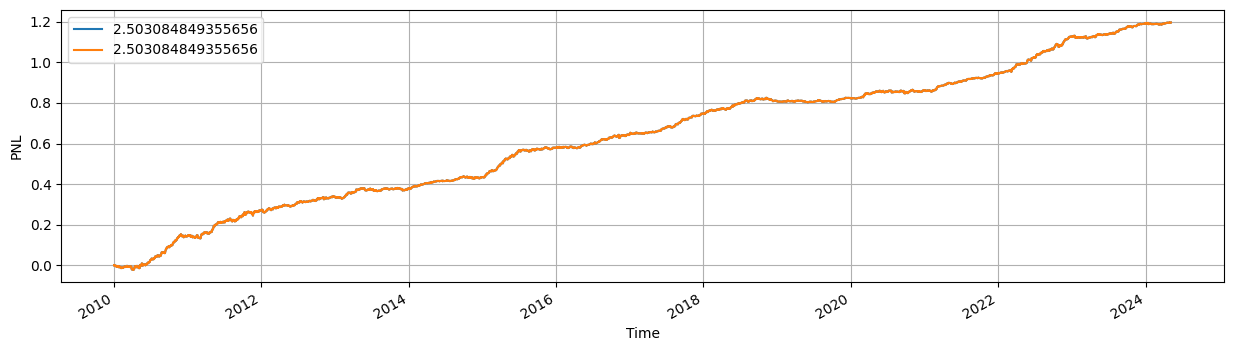

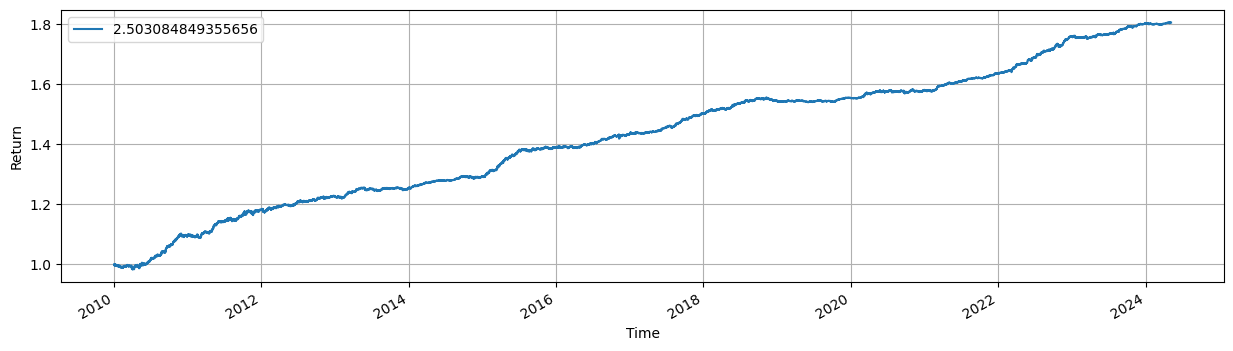

total_gain  fee  total_gain_after_fee  Position    Close  \
Datetime                                                                        
2010-01-03 21:00:00     0.00000  0.0               0.00000         0  1.43293   
2010-01-03 21:15:00     0.00000  0.0               0.00000         0  1.43238   
2010-01-03 21:30:00     0.00000  0.0               0.00000         0  1.43282   
2010-01-03 21:45:00     0.00000  0.0               0.00000         0  1.43153   
2010-01-03 22:00:00     0.00000  0.0               0.00000         0  1.42899   
...                         ...  ...                   ...       ...      ...   
2024-05-06 01:45:00     1.19679  0.0               1.19679         0  1.07690   
2024-05-06 02:00:00     1.19679  0.0               1.19679         0  1.07677   
2024-05-06 02:15:00     1.19679  0.0               1.19679         0  1.07687   
2024-05-06 02:30:00     1.19679  0.0               1.19679         0  1.07665   
2024-05-06 02:45:00     1.19679  0.0               1.19679         0  1.07646   

                       Return  
Datetime                       
2010-01-03 21:00:00  1.000000  
2010-01-03 21:15:00  1.000000  
2010-01-03 21:30:00  1.000000  
2010-01-03 21:45:00  1.000000  
2010-01-03 22:00:00  1.000000  
...                       ...  
2024-05-06 01:45:00  1.804846  
2024-05-06 02:00:00  1.804846  
2024-05-06 02:15:00  1.804846  
2024-05-06 02:30:00  1.804846  
2024-05-06 02:45:00  1.804846  

[355523 rows x 6 columns]

In [ ]:
data1=df.copy()
data1=data1.groupby([pd.Grouper(key='Datetime', freq='15T')]) \
        .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}) \
        .dropna().reset_index()

data1['DayOfWeek']=data1['Datetime'].dt.day_of_week

determine_session(data1)
data1['Position']=0
params={0: {'window1_long': 19,  'window2_long': 11,  'window11_long': 24,  'window12_long': 14,  'window1_short': 17,  'window2_short': 40,  'window11_short': 33,  'window12_short': 7,  'diff_long': 4,  'diff1_long': 14,  'diff_short': 1,  'diff1_short': 1},
        1: {'window1_long': 38,  'window2_long': 44,  'window11_long': 22,  'window12_long': 27,  'window1_short': 31,  'window2_short': 8,  'window11_short': 40,  'window12_short': 35,  'diff_long': 2,  'diff1_long': 4,  'diff_short': 10,  'diff1_short': 13},
        2: {'window1_long': 39,  'window2_long': 29,  'window11_long': 37,  'window12_long': 39,  'window1_short': 23,  'window2_short': 19,  'window11_short': 32,  'window12_short': 7,  'diff_long': 1,  'diff1_long': 14,  'diff_short': 2,  'diff1_short': 1},
        3: {'window1_long': 35,  'window2_long': 23,  'window11_long': 14,  'window12_long': 30,  'window1_short': 44,  'window2_short': 7,  'window11_short': 20,  'window12_short': 43,  'diff_long': 14,  'diff1_long': 4,  'diff_short': 3,  'diff1_short': 9},
        4: {'window1_long': 6,  'window2_long': 34,  'window11_long': 29,  'window12_long': 10,  'window1_short': 41,  'window2_short': 9,  'window11_short': 6,  'window12_short': 33,  'diff_long': 15,  'diff1_long': 12,  'diff_short': 4,  'diff1_short': 15}}
for i, param in params.items():
    data1['AO_long']=ta.momentum.AwesomeOscillatorIndicator(high=data1['High'], low=data1['Low'], window1=param['window1_long'], window2=param['window2_long'], fillna= False).awesome_oscillator().diff(param['diff_long'])
    data1['AO1_long']=ta.momentum.AwesomeOscillatorIndicator(high=data1['High'], low=data1['Low'], window1=param['window11_long'], window2=param['window12_long'], fillna= False).awesome_oscillator().diff(param['diff1_long'])


    data1['AO_short']=ta.momentum.AwesomeOscillatorIndicator(high=data1['High'], low=data1['Low'], window1=param['window1_short'], window2=param['window2_short'], fillna= False).awesome_oscillator().diff(param['diff_short'])
    data1['AO1_short']=ta.momentum.AwesomeOscillatorIndicator(high=data1['High'], low=data1['Low'], window1=param['window11_short'], window2=param['window12_short'], fillna= False).awesome_oscillator().diff(param['diff1_short'])

    data1.loc[ (data1['AO_long'] > 0) & (data1['AO1_long'] > 0) & (data1['DayOfWeek']==i) &  (data1['Tokyo Session']==1), 'Position'] = data1['Position'] + 1
    data1.loc[ (data1['AO_short'] < 0) & (data1['AO1_short'] < 0) & (data1['DayOfWeek']==i) &  (data1['Tokyo Session']==1), 'Position'] = data1['Position'] - 1



test=data1#[(data1['Datetime'].dt.year>=2018) & (data1['Datetime'].dt.year>=2023)]
backTestInfo = FX.BacktestInformation(test['Datetime'], test['Position'], test['Close'],fee=0.0)
print(data1['Position'].value_counts())
backTestInfo.Plot_PNL()

In [ ]:
def AO(df):
        dt=df.copy()
        dt['Position']=0
        params={0: {'window1_long': 19,  'window2_long': 11,  'window11_long': 24,  'window12_long': 14,  'window1_short': 17,  'window2_short': 40,  'window11_short': 33,  'window12_short': 7,  'diff_long': 4,  'diff1_long': 14,  'diff_short': 1,  'diff1_short': 1},
                1: {'window1_long': 38,  'window2_long': 44,  'window11_long': 22,  'window12_long': 27,  'window1_short': 31,  'window2_short': 8,  'window11_short': 40,  'window12_short': 35,  'diff_long': 2,  'diff1_long': 4,  'diff_short': 10,  'diff1_short': 13},
                2: {'window1_long': 39,  'window2_long': 29,  'window11_long': 37,  'window12_long': 39,  'window1_short': 23,  'window2_short': 19,  'window11_short': 32,  'window12_short': 7,  'diff_long': 1,  'diff1_long': 14,  'diff_short': 2,  'diff1_short': 1},
                3: {'window1_long': 35,  'window2_long': 23,  'window11_long': 14,  'window12_long': 30,  'window1_short': 44,  'window2_short': 7,  'window11_short': 20,  'window12_short': 43,  'diff_long': 14,  'diff1_long': 4,  'diff_short': 3,  'diff1_short': 9},
                4: {'window1_long': 6,  'window2_long': 34,  'window11_long': 29,  'window12_long': 10,  'window1_short': 41,  'window2_short': 9,  'window11_short': 6,  'window12_short': 33,  'diff_long': 15,  'diff1_long': 12,  'diff_short': 4,  'diff1_short': 15}}
        for i, param in params.items():
                dt['AO_long']=ta.momentum.AwesomeOscillatorIndicator(high=dt['High'], low=dt['Low'], window1=param['window1_long'], window2=param['window2_long'], fillna= False).awesome_oscillator().diff(param['diff_long'])
                dt['AO1_long']=ta.momentum.AwesomeOscillatorIndicator(high=dt['High'], low=dt['Low'], window1=param['window11_long'], window2=param['window12_long'], fillna= False).awesome_oscillator().diff(param['diff1_long'])


                dt['AO_short']=ta.momentum.AwesomeOscillatorIndicator(high=dt['High'], low=dt['Low'], window1=param['window1_short'], window2=param['window2_short'], fillna= False).awesome_oscillator().diff(param['diff_short'])
                dt['AO1_short']=ta.momentum.AwesomeOscillatorIndicator(high=dt['High'], low=dt['Low'], window1=param['window11_short'], window2=param['window12_short'], fillna= False).awesome_oscillator().diff(param['diff1_short'])

                dt.loc[ (dt['AO_long'] > 0) & (dt['AO1_long'] > 0) & (dt['DayOfWeek']==i) &  (dt['Tokyo Session']==1), 'Position'] = dt['Position'] + 1
                dt.loc[ (dt['AO_short'] < 0) & (dt['AO1_short'] < 0) & (dt['DayOfWeek']==i) &  (dt['Tokyo Session']==1), 'Position'] = dt['Position'] - 1

        return dt['Position']

## MACD


In [ ]:
from scipy.signal import butter, lfilter

def lowPass_filter(signal, ratio):
    b, a = butter(1, ratio, btype='low', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal
data=df.copy()
data=data.groupby([pd.Grouper(key='Datetime', freq='15T')]) \
        .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}) \
        .dropna().reset_index()
data['Position']=0
data['DayOfWeek']=data['Datetime'].dt.day_of_week

determine_session(data)
params={}
for i in range(5):
    def objective(trial):

        data_op=data.copy()

        window_slow=trial.suggest_int('long_window_slow',5,200)
        window_fast=trial.suggest_int('long_window_fast',5,200)
        window_sign=trial.suggest_int('long_window_sign',5,200)
        window_roll=trial.suggest_int('long_window_roll',5,200)
        win_ratio=trial.suggest_float('long_win_ratio',0.1,1)
        diff=trial.suggest_int('long_diff',1,40)

        data_op['long_lqf_close']=lowPass_filter(data['Close'],win_ratio)

        data_op["long_MACD"]=ta.trend.MACD( close=data_op['long_lqf_close'], window_slow=window_slow,window_fast=window_fast, window_sign=window_sign,fillna=False).macd_diff()
        data_op["long_MACD_ma"]=data_op["long_MACD"].rolling(window_roll).mean()
        data_op["long_MACD_diff"]=data_op["long_MACD"].diff(diff)

        window_slow=trial.suggest_int('short_window_slow',5,200)
        window_fast=trial.suggest_int('short_window_fast',5,200)
        window_sign=trial.suggest_int('short_window_sign',5,200)
        window_roll=trial.suggest_int('short_window_roll',5,200)
        win_ratio=trial.suggest_float('short_win_ratio',0.1,1)
        diff=trial.suggest_int('short_diff',1,40)

        data_op['short_lqf_close']=lowPass_filter(data['Close'],win_ratio)

        data_op["short_MACD"]=ta.trend.MACD( close=data_op['short_lqf_close'], window_slow=window_slow,window_fast=window_fast, window_sign=window_sign,fillna=False).macd_diff()
        data_op["short_MACD_ma"]=data_op["short_MACD"].rolling(window_roll).mean()
        data_op["short_MACD_diff"]=data_op["short_MACD"].diff(diff)



        entry_long=  (data_op['long_MACD_ma'] > data_op["long_MACD"] ) & (data_op['long_MACD_diff'] > 0) & (data_op['DayOfWeek']==i) & (data_op['Tokyo Session']==1)
        entry_short= (data_op['short_MACD_ma'] < data_op["short_MACD"] ) & (data_op['short_MACD_diff'] < 0) & (data_op['DayOfWeek']==i) & (data_op['Tokyo Session']==1)

        data_op.loc[entry_long , 'Position'] =data_op['Position']  +1
        data_op.loc[entry_short, 'Position'] =data_op['Position']  -1
        try:
            test=data_op[(data_op['Datetime'].dt.year>=2010) & (data_op['Datetime'].dt.year<2024) ]
            backTestInfo = FX.BacktestInformation(test['Datetime'], test['Position'], test['Close'],fee=0)
            return backTestInfo.Sharp_percent_after_fee()
        except Exception as e:
            print(e)
            return 0


    param_file = "C:\\Users\\Administrator\\Documents\\ManhNH\\A_1\\Build_Alpha\\alpha_t3\\t0.txt"


    def logging_callback(study, frozen_trial):
        previous_best_value = study.user_attrs.get("previous_best_value", None)
        if previous_best_value != study.best_value:
            study.set_user_attr("previous_best_value", study.best_value)
            if frozen_trial.value > 1:
                with open(param_file, "a") as f:
                    f.write(f'{str(frozen_trial.params)} Value = {str(frozen_trial.value)}\n')


    with open(param_file, "a") as f:
        f.write(f'\n')

    direction = "maximize"
    study = optuna.create_study(direction=direction, pruner=m.DuplicatePruner())
    early_stopping = m.EarlyStoppingCallback(500, direction=direction)

    study.optimize(objective, callbacks=[early_stopping, logging_callback])
    print('finished', i, study.best_params)
    params.update({i:study.best_params})
params

[I 2024-05-17 13:08:33,407] A new study created in memory with name: no-name-141cd082-049a-4ea2-b7e3-4a18016e64d3
[I 2024-05-17 13:08:33,799] Trial 0 finished with value: 0.028654361758673457 and parameters: {'long_window_slow': 60, 'long_window_fast': 195, 'long_window_sign': 55, 'long_window_roll': 55, 'long_win_ratio': 0.4737386518165275, 'long_diff': 26, 'short_window_slow': 191, 'short_window_fast': 29, 'short_window_sign': 6, 'short_window_roll': 23, 'short_win_ratio': 0.653425116813462, 'short_diff': 27}. Best is trial 0 with value: 0.028654361758673457.
[I 2024-05-17 13:08:34,202] Trial 1 finished with value: -0.24912762029500007 and parameters: {'long_window_slow': 29, 'long_window_fast': 166, 'long_window_sign': 89, 'long_window_roll': 106, 'long_win_ratio': 0.9885743818959991, 'long_diff': 16, 'short_window_slow': 102, 'short_window_fast': 101, 'short_window_sign': 92, 'short_window_roll': 51, 'short_win_ratio': 0.4163898417123174, 'short_diff': 7}. Best is trial 0 with valu

finished 0 {'long_window_slow': 127, 'long_window_fast': 125, 'long_window_sign': 185, 'long_window_roll': 76, 'long_win_ratio': 0.9085787230332351, 'long_diff': 20, 'short_window_slow': 23, 'short_window_fast': 182, 'short_window_sign': 12, 'short_window_roll': 184, 'short_win_ratio': 0.5600005805280978, 'short_diff': 7}


[I 2024-05-17 13:26:03,090] Trial 0 finished with value: 0.08221932497581891 and parameters: {'long_window_slow': 167, 'long_window_fast': 89, 'long_window_sign': 139, 'long_window_roll': 9, 'long_win_ratio': 0.9947517659151413, 'long_diff': 13, 'short_window_slow': 158, 'short_window_fast': 66, 'short_window_sign': 12, 'short_window_roll': 28, 'short_win_ratio': 0.9028407723450929, 'short_diff': 38}. Best is trial 0 with value: 0.08221932497581891.
[I 2024-05-17 13:26:03,430] Trial 1 finished with value: 0.6172509750110416 and parameters: {'long_window_slow': 81, 'long_window_fast': 18, 'long_window_sign': 45, 'long_window_roll': 143, 'long_win_ratio': 0.7288402522445284, 'long_diff': 25, 'short_window_slow': 186, 'short_window_fast': 192, 'short_window_sign': 145, 'short_window_roll': 146, 'short_win_ratio': 0.28346877676171567, 'short_diff': 8}. Best is trial 1 with value: 0.6172509750110416.
[I 2024-05-17 13:26:03,806] Trial 2 finished with value: 0.024764188852225456 and parameter

finished 1 {'long_window_slow': 51, 'long_window_fast': 12, 'long_window_sign': 90, 'long_window_roll': 107, 'long_win_ratio': 0.5060375918309592, 'long_diff': 36, 'short_window_slow': 114, 'short_window_fast': 162, 'short_window_sign': 135, 'short_window_roll': 82, 'short_win_ratio': 0.801312485710794, 'short_diff': 40}


[I 2024-05-17 13:32:15,866] Trial 0 finished with value: 0.03864724065815705 and parameters: {'long_window_slow': 44, 'long_window_fast': 5, 'long_window_sign': 126, 'long_window_roll': 82, 'long_win_ratio': 0.4448499984822234, 'long_diff': 16, 'short_window_slow': 137, 'short_window_fast': 117, 'short_window_sign': 48, 'short_window_roll': 35, 'short_win_ratio': 0.13037931980300416, 'short_diff': 19}. Best is trial 0 with value: 0.03864724065815705.
[I 2024-05-17 13:32:16,410] Trial 1 finished with value: -0.10836348332185425 and parameters: {'long_window_slow': 38, 'long_window_fast': 140, 'long_window_sign': 150, 'long_window_roll': 9, 'long_win_ratio': 0.7435881564167804, 'long_diff': 7, 'short_window_slow': 136, 'short_window_fast': 45, 'short_window_sign': 200, 'short_window_roll': 103, 'short_win_ratio': 0.9505299945939212, 'short_diff': 5}. Best is trial 0 with value: 0.03864724065815705.
[I 2024-05-17 13:32:16,838] Trial 2 finished with value: 0.04990615859543523 and parameter

finished 2 {'long_window_slow': 197, 'long_window_fast': 61, 'long_window_sign': 56, 'long_window_roll': 200, 'long_win_ratio': 0.9924685747814441, 'long_diff': 26, 'short_window_slow': 85, 'short_window_fast': 124, 'short_window_sign': 139, 'short_window_roll': 166, 'short_win_ratio': 0.722350391046146, 'short_diff': 1}


[I 2024-05-17 13:39:43,993] Trial 0 finished with value: -0.07749310495951682 and parameters: {'long_window_slow': 109, 'long_window_fast': 128, 'long_window_sign': 138, 'long_window_roll': 110, 'long_win_ratio': 0.33724057378755945, 'long_diff': 3, 'short_window_slow': 176, 'short_window_fast': 38, 'short_window_sign': 55, 'short_window_roll': 12, 'short_win_ratio': 0.13495496712897578, 'short_diff': 25}. Best is trial 0 with value: -0.07749310495951682.
[I 2024-05-17 13:39:44,372] Trial 1 finished with value: -0.29660910327985457 and parameters: {'long_window_slow': 152, 'long_window_fast': 22, 'long_window_sign': 200, 'long_window_roll': 34, 'long_win_ratio': 0.9355024207717428, 'long_diff': 34, 'short_window_slow': 77, 'short_window_fast': 65, 'short_window_sign': 114, 'short_window_roll': 26, 'short_win_ratio': 0.7736240817064343, 'short_diff': 30}. Best is trial 0 with value: -0.07749310495951682.
[I 2024-05-17 13:39:44,870] Trial 2 finished with value: 0.24312975069612264 and pa

finished 3 {'long_window_slow': 98, 'long_window_fast': 15, 'long_window_sign': 175, 'long_window_roll': 156, 'long_win_ratio': 0.7454502460994957, 'long_diff': 7, 'short_window_slow': 71, 'short_window_fast': 158, 'short_window_sign': 12, 'short_window_roll': 119, 'short_win_ratio': 0.5179221697829336, 'short_diff': 26}


[I 2024-05-17 13:45:44,119] Trial 0 finished with value: 0.28836272692818776 and parameters: {'long_window_slow': 191, 'long_window_fast': 114, 'long_window_sign': 50, 'long_window_roll': 50, 'long_win_ratio': 0.14856586394236618, 'long_diff': 4, 'short_window_slow': 76, 'short_window_fast': 76, 'short_window_sign': 20, 'short_window_roll': 15, 'short_win_ratio': 0.477232154722824, 'short_diff': 40}. Best is trial 0 with value: 0.28836272692818776.
[I 2024-05-17 13:45:44,476] Trial 1 finished with value: -0.2278035534607323 and parameters: {'long_window_slow': 177, 'long_window_fast': 38, 'long_window_sign': 49, 'long_window_roll': 39, 'long_win_ratio': 0.19233542850103835, 'long_diff': 37, 'short_window_slow': 176, 'short_window_fast': 157, 'short_window_sign': 35, 'short_window_roll': 144, 'short_win_ratio': 0.2642982427141242, 'short_diff': 24}. Best is trial 0 with value: 0.28836272692818776.
[I 2024-05-17 13:45:44,901] Trial 2 finished with value: 0.275161971477568 and parameters:

finished 4 {'long_window_slow': 108, 'long_window_fast': 179, 'long_window_sign': 155, 'long_window_roll': 122, 'long_win_ratio': 0.38065955127117396, 'long_diff': 6, 'short_window_slow': 174, 'short_window_fast': 155, 'short_window_sign': 88, 'short_window_roll': 84, 'short_win_ratio': 0.37324408392144137, 'short_diff': 35}


{0: {'long_window_slow': 127,
  'long_window_fast': 125,
  'long_window_sign': 185,
  'long_window_roll': 76,
  'long_win_ratio': 0.9085787230332351,
  'long_diff': 20,
  'short_window_slow': 23,
  'short_window_fast': 182,
  'short_window_sign': 12,
  'short_window_roll': 184,
  'short_win_ratio': 0.5600005805280978,
  'short_diff': 7},
 1: {'long_window_slow': 51,
  'long_window_fast': 12,
  'long_window_sign': 90,
  'long_window_roll': 107,
  'long_win_ratio': 0.5060375918309592,
  'long_diff': 36,
  'short_window_slow': 114,
  'short_window_fast': 162,
  'short_window_sign': 135,
  'short_window_roll': 82,
  'short_win_ratio': 0.801312485710794,
  'short_diff': 40},
 2: {'long_window_slow': 197,
  'long_window_fast': 61,
  'long_window_sign': 56,
  'long_window_roll': 200,
  'long_win_ratio': 0.9924685747814441,
  'long_diff': 26,
  'short_window_slow': 85,
  'short_window_fast': 124,
  'short_window_sign': 139,
  'short_window_roll': 166,
  'short_win_ratio': 0.722350391046146,
  

Position
 0    328427
 1     15399
-1     11697
Name: count, dtype: int64
Margin: 0.9361314485810807
MDD: (0.02848999999999946, 0.01916350526004215)

   Total trading quantity: 4316
         Profit per trade: 0.00022425162187210548
             Total Profit: 1.0
         Profit after fee: 1.0
 Trading quantity per day: 0.9657641530543746
 Profit per day after fee: 0.00022376370552696352
                   Return: 0.0468716099947552
          Profit per year: 0.06968308514700267
                  HitRate: 0.5780815569972196
          HitRate per day: 0.3077439570277529


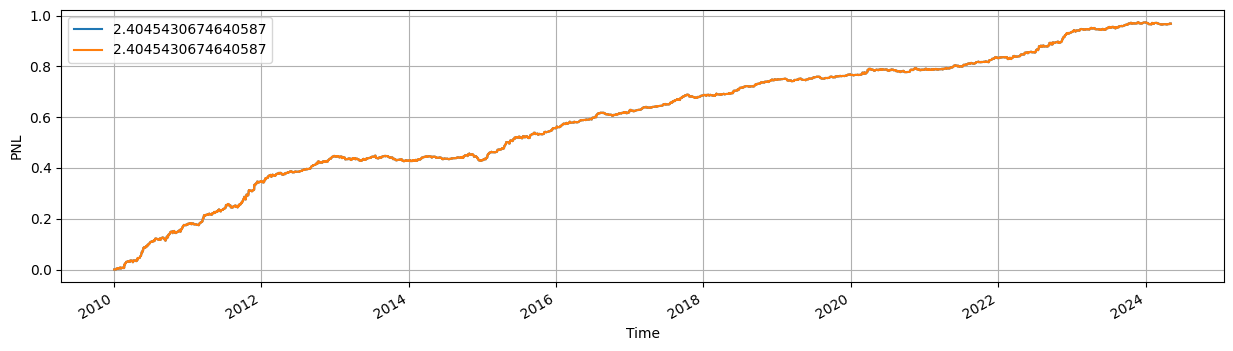

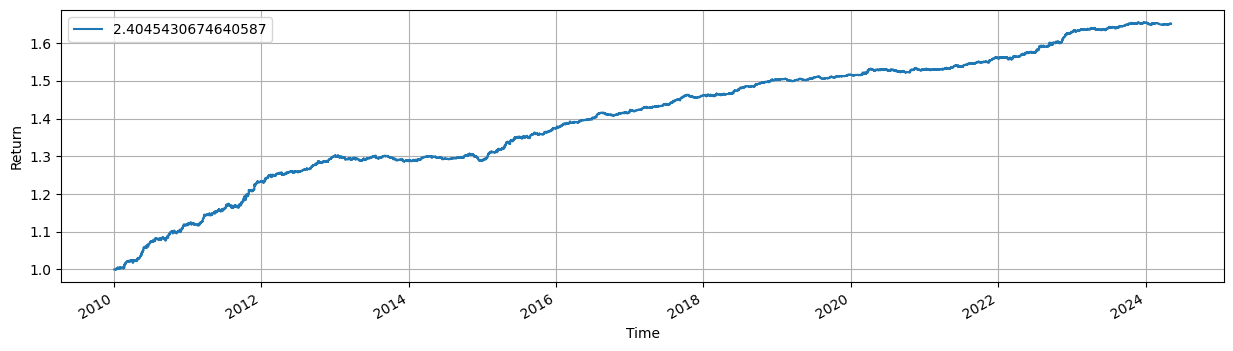

total_gain  fee  total_gain_after_fee  Position    Close  \
Datetime                                                                        
2010-01-03 21:00:00     0.00000  0.0               0.00000         0  1.43293   
2010-01-03 21:15:00     0.00000  0.0               0.00000         0  1.43238   
2010-01-03 21:30:00     0.00000  0.0               0.00000         0  1.43282   
2010-01-03 21:45:00     0.00000  0.0               0.00000         0  1.43153   
2010-01-03 22:00:00     0.00000  0.0               0.00000         0  1.42899   
...                         ...  ...                   ...       ...      ...   
2024-05-06 01:45:00     0.96743  0.0               0.96743        -1  1.07690   
2024-05-06 02:00:00     0.96756  0.0               0.96756        -1  1.07677   
2024-05-06 02:15:00     0.96746  0.0               0.96746        -1  1.07687   
2024-05-06 02:30:00     0.96768  0.0               0.96768        -1  1.07665   
2024-05-06 02:45:00     0.96787  0.0               0.96787        -1  1.07646   

                       Return  
Datetime                       
2010-01-03 21:00:00  1.000000  
2010-01-03 21:15:00  1.000000  
2010-01-03 21:30:00  1.000000  
2010-01-03 21:45:00  1.000000  
2010-01-03 22:00:00  1.000000  
...                       ...  
2024-05-06 01:45:00  1.650732  
2024-05-06 02:00:00  1.650819  
2024-05-06 02:15:00  1.650752  
2024-05-06 02:30:00  1.650900  
2024-05-06 02:45:00  1.651028  

[355523 rows x 6 columns]

In [ ]:
data2=df.copy()
data2=data2.groupby([pd.Grouper(key='Datetime', freq='15T')]) \
        .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}) \
        .dropna().reset_index()

data2['DayOfWeek']=data2['Datetime'].dt.day_of_week

determine_session(data2)
data2['Position']=0

params={0: {'long_window_slow': 127,  'long_window_fast': 125,  'long_window_sign': 185,  'long_window_roll': 76,  'long_win_ratio': 0.90,  'long_diff': 20,  'short_window_slow': 23,  'short_window_fast': 182,  'short_window_sign': 12,
            'short_window_roll': 184,  'short_win_ratio': 0.55,  'short_diff': 7},
        1: {'long_window_slow': 51,  'long_window_fast': 12,  'long_window_sign': 90,  'long_window_roll': 107,  'long_win_ratio': 0.5,  'long_diff': 36,  'short_window_slow': 114,  'short_window_fast': 162,  'short_window_sign': 135,
            'short_window_roll': 82,  'short_win_ratio': 0.8,  'short_diff': 40},
        2: {'long_window_slow': 197,  'long_window_fast': 61,  'long_window_sign': 56,  'long_window_roll': 200,  'long_win_ratio': 0.99,  'long_diff': 26,  'short_window_slow': 85,  'short_window_fast': 124,  'short_window_sign': 139,
            'short_window_roll': 166,  'short_win_ratio': 0.72,  'short_diff': 1},
        3: {'long_window_slow': 98,  'long_window_fast': 15,  'long_window_sign': 175,  'long_window_roll': 156,  'long_win_ratio': 0.75,  'long_diff': 7,  'short_window_slow': 71,  'short_window_fast': 158,  'short_window_sign': 12,
            'short_window_roll': 119,  'short_win_ratio': 0.5,  'short_diff': 26},
        4: {'long_window_slow': 108,  'long_window_fast': 179,  'long_window_sign': 155,  'long_window_roll': 122,  'long_win_ratio': 0.4,  'long_diff': 6,  'short_window_slow': 174,  'short_window_fast': 155,  'short_window_sign': 88,
            'short_window_roll': 84,  'short_win_ratio': 0.4,  'short_diff': 35}}
for i, param in params.items():

        data2['long_lqf_close']=lowPass_filter(data2['Close'],param['long_win_ratio'])

        data2["long_MACD"]=ta.trend.MACD( close=data2['long_lqf_close'], window_slow=param['long_window_slow'],window_fast=param['long_window_fast'], window_sign=param['long_window_sign'],fillna=False).macd_diff()
        data2["long_MACD_ma"]=data2["long_MACD"].rolling(param['long_window_roll']).mean()
        data2["long_MACD_diff"]=data2["long_MACD"].diff(param['long_diff'])


        data2['short_lqf_close']=lowPass_filter(data2['Close'],param['short_win_ratio'])

        data2["short_MACD"]=ta.trend.MACD( close=data2['short_lqf_close'], window_slow=param['short_window_slow'],window_fast=param['short_window_fast'], window_sign=param['short_window_sign'],fillna=False).macd_diff()
        data2["short_MACD_ma"]=data2["short_MACD"].rolling(param['short_window_roll']).mean()
        data2["short_MACD_diff"]=data2["short_MACD"].diff(param['short_diff'])



        entry_long=  (data2['long_MACD_ma'] > data2["long_MACD"] ) & (data2['long_MACD_diff'] > 0) & (data2['DayOfWeek']==i) & (data2['Tokyo Session']==1)
        entry_short= (data2['short_MACD_ma'] < data2["short_MACD"] ) & (data2['short_MACD_diff'] < 0) & (data2['DayOfWeek']==i) & (data2['Tokyo Session']==1)

        data2.loc[entry_long , 'Position'] =data2['Position']  +1
        data2.loc[entry_short, 'Position'] =data2['Position']  -1



test=data2#[(data2['Datetime'].dt.year>=2018) & (data2['Datetime'].dt.year>=2023)]
backTestInfo = FX.BacktestInformation(test['Datetime'], test['Position'], test['Close'],fee=0.0)
print(data2['Position'].value_counts())
backTestInfo.Plot_PNL()

In [ ]:
def MACD(df):
    def lowPass_filter(signal, ratio):
        b, a = butter(1, ratio, btype='low', analog=False)
        filtered_signal = lfilter(b, a, signal)
        return filtered_signal
    dt=df.copy()
    dt['Position_MACD']=0
    params_macd={0: {'long_window_slow': 127,  'long_window_fast': 125,  'long_window_sign': 185,  'long_window_roll': 76,  'long_win_ratio': 0.90,  'long_diff': 20,  'short_window_slow': 23,  'short_window_fast': 182,  'short_window_sign': 12,
            'short_window_roll': 184,  'short_win_ratio': 0.55,  'short_diff': 7},
        1: {'long_window_slow': 51,  'long_window_fast': 12,  'long_window_sign': 90,  'long_window_roll': 107,  'long_win_ratio': 0.5,  'long_diff': 36,  'short_window_slow': 114,  'short_window_fast': 162,  'short_window_sign': 135,
            'short_window_roll': 82,  'short_win_ratio': 0.8,  'short_diff': 40},
        2: {'long_window_slow': 197,  'long_window_fast': 61,  'long_window_sign': 56,  'long_window_roll': 200,  'long_win_ratio': 0.99,  'long_diff': 26,  'short_window_slow': 85,  'short_window_fast': 124,  'short_window_sign': 139,
            'short_window_roll': 166,  'short_win_ratio': 0.72,  'short_diff': 1},
        3: {'long_window_slow': 98,  'long_window_fast': 15,  'long_window_sign': 175,  'long_window_roll': 156,  'long_win_ratio': 0.75,  'long_diff': 7,  'short_window_slow': 71,  'short_window_fast': 158,  'short_window_sign': 12,
            'short_window_roll': 119,  'short_win_ratio': 0.5,  'short_diff': 26},
        4: {'long_window_slow': 108,  'long_window_fast': 179,  'long_window_sign': 155,  'long_window_roll': 122,  'long_win_ratio': 0.4,  'long_diff': 6,  'short_window_slow': 174,  'short_window_fast': 155,  'short_window_sign': 88,
            'short_window_roll': 84,  'short_win_ratio': 0.4,  'short_diff': 35}}
    for i, param in params_macd.items():

        dt['long_lqf_close']=lowPass_filter(data['Close'],param['long_win_ratio'])

        dt["long_MACD"]=ta.trend.MACD( close=dt['long_lqf_close'], window_slow=param['long_window_slow'],window_fast=param['long_window_fast'], window_sign=param['long_window_sign'],fillna=False).macd_diff()
        dt["long_MACD_ma"]=dt["long_MACD"].rolling(param['long_window_roll']).mean()
        dt["long_MACD_diff"]=dt["long_MACD"].diff(param['long_diff'])


        dt['short_lqf_close']=lowPass_filter(data['Close'],param['short_win_ratio'])

        dt["short_MACD"]=ta.trend.MACD( close=dt['short_lqf_close'], window_slow=param['short_window_slow'],window_fast=param['short_window_fast'], window_sign=param['short_window_sign'],fillna=False).macd_diff()
        dt["short_MACD_ma"]=dt["short_MACD"].rolling(param['short_window_roll']).mean()
        dt["short_MACD_diff"]=dt["short_MACD"].diff(param['short_diff'])



        entry_long=  (dt['long_MACD_ma'] > dt["long_MACD"] ) & (dt['long_MACD_diff'] > 0) & (dt['DayOfWeek']==i) & (dt['Tokyo Session']==1)
        entry_short= (dt['short_MACD_ma'] < dt["short_MACD"] ) & (dt['short_MACD_diff'] < 0) & (dt['DayOfWeek']==i) & (dt['Tokyo Session']==1)

        dt.loc[entry_long , 'Position_MACD'] =dt['Position_MACD']  +1
        dt.loc[entry_short, 'Position_MACD'] =dt['Position_MACD']  -1

    return dt['Position_MACD']

## Label

In [ ]:

data=df.copy()
data=data.groupby([pd.Grouper(key='Datetime', freq='15T')]) \
        .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}) \
        .dropna().reset_index()
data['Position']=0
data['DayOfWeek']=data['Datetime'].dt.day_of_week

determine_session(data)
params={}
for i in range(5):
    def objective(trial):

        data_op=data.copy()
        data['Position']=0


        # long_window=trial.suggest_int('long_window',1,200,1)
        # slope_long=trial.suggest_int('slope_long',1,50,1)

        short_window=trial.suggest_int('short_window',1,200,1)
        slope_short=trial.suggest_int('slope_short',1,50,1)
        # shift=trial.suggest_int('shift',1,10,1)


        # data_op['ma_long']=data_op['Close'].rolling(long_window).mean()
        # data_op['slope_long']=data_op['ma_long'].diff(slope_long)

        data_op['ma_short']=data_op['Close'].rolling(short_window).mean()
        data_op['slope_short']=data_op['ma_short'].diff(slope_short)


        # entry_long=  (data_op['ma_long'] > data_op["Close"] ) & (data_op['slope_long'] > 0) & (data_op['DayOfWeek']==i) & (data_op['Tokyo Session']==1)
        entry_long=  (data_op['Tokyo Session']==1)
        entry_short= (data_op['ma_short'] < data_op["Close"] ) & (data_op['slope_short'] < 0) & (data_op['DayOfWeek']==i) & (data_op['Tokyo Session']==1)


        data_op.loc[entry_long , 'Position'] =data_op['Position']  +1
        data_op.loc[entry_short, 'Position'] = -1


        try:
            test=data_op[(data_op['Datetime'].dt.year>=2010) & (data_op['Datetime'].dt.year<2024) ]
            backTestInfo = FX.BacktestInformation(test['Datetime'], test['Position'].shift(-6).fillna(0), test['Close'],fee=0.00003)
            return backTestInfo.Sharp_percent_after_fee()
        except Exception as e:
            print(e)
            return 0


    param_file = "C:\\Users\\Administrator\\Documents\\ManhNH\\A_1\\Build_Alpha\\alpha_t3\\t0.txt"


    def logging_callback(study, frozen_trial):
        previous_best_value = study.user_attrs.get("previous_best_value", None)
        if previous_best_value != study.best_value:
            study.set_user_attr("previous_best_value", study.best_value)
            if frozen_trial.value > 1:
                with open(param_file, "a") as f:
                    f.write(f'{str(frozen_trial.params)} Value = {str(frozen_trial.value)}\n')


    with open(param_file, "a") as f:
        f.write(f'\n')

    direction = "maximize"
    study = optuna.create_study(direction=direction, pruner=m.DuplicatePruner())
    early_stopping = m.EarlyStoppingCallback(1000, direction=direction)

    study.optimize(objective, callbacks=[early_stopping, logging_callback])
    print('finished', i, study.best_params)
    params.update({i:study.best_params})
params

[I 2024-05-22 13:32:47,555] A new study created in memory with name: no-name-d2aa137c-e498-4cb2-b8a2-048e6f63c1b9
[I 2024-05-22 13:32:48,758] Trial 0 finished with value: -1.3453791366764971 and parameters: {'short_window': 29, 'slope_short': 49}. Best is trial 0 with value: -1.3453791366764971.
[I 2024-05-22 13:32:49,714] Trial 1 finished with value: -1.238952775439484 and parameters: {'short_window': 53, 'slope_short': 37}. Best is trial 1 with value: -1.238952775439484.
[I 2024-05-22 13:32:50,780] Trial 2 finished with value: -0.8644127116068195 and parameters: {'short_window': 90, 'slope_short': 31}. Best is trial 2 with value: -0.8644127116068195.
[I 2024-05-22 13:32:51,699] Trial 3 finished with value: -1.0011605747367431 and parameters: {'short_window': 51, 'slope_short': 22}. Best is trial 2 with value: -0.8644127116068195.
[I 2024-05-22 13:32:52,682] Trial 4 finished with value: -0.3674162471042663 and parameters: {'short_window': 153, 'slope_short': 16}. Best is trial 4 with 

finished 0 {'short_window': 6, 'slope_short': 6}


[I 2024-05-22 13:57:01,629] Trial 0 finished with value: -0.23010301656923307 and parameters: {'short_window': 168, 'slope_short': 3}. Best is trial 0 with value: -0.23010301656923307.
[I 2024-05-22 13:57:02,646] Trial 1 finished with value: -0.45609026283486387 and parameters: {'short_window': 89, 'slope_short': 8}. Best is trial 0 with value: -0.23010301656923307.
[I 2024-05-22 13:57:03,704] Trial 2 finished with value: -0.2698174858776526 and parameters: {'short_window': 53, 'slope_short': 2}. Best is trial 0 with value: -0.23010301656923307.
[I 2024-05-22 13:57:04,861] Trial 3 finished with value: -0.21204974681153363 and parameters: {'short_window': 46, 'slope_short': 2}. Best is trial 3 with value: -0.21204974681153363.
[I 2024-05-22 13:57:05,928] Trial 4 finished with value: -0.8178093475460863 and parameters: {'short_window': 191, 'slope_short': 45}. Best is trial 3 with value: -0.21204974681153363.
[I 2024-05-22 13:57:07,044] Trial 5 finished with value: -0.6316352364146895 an

finished 1 {'short_window': 6, 'slope_short': 6}


[I 2024-05-22 14:19:45,167] Trial 0 finished with value: -0.6271108713411696 and parameters: {'short_window': 134, 'slope_short': 50}. Best is trial 0 with value: -0.6271108713411696.
[I 2024-05-22 14:19:46,099] Trial 1 finished with value: -0.6806195864856726 and parameters: {'short_window': 107, 'slope_short': 37}. Best is trial 0 with value: -0.6271108713411696.
[I 2024-05-22 14:19:47,233] Trial 2 finished with value: -0.7373701133840939 and parameters: {'short_window': 99, 'slope_short': 49}. Best is trial 0 with value: -0.6271108713411696.
[I 2024-05-22 14:19:48,370] Trial 3 finished with value: -1.0291063946075532 and parameters: {'short_window': 64, 'slope_short': 46}. Best is trial 0 with value: -0.6271108713411696.
[I 2024-05-22 14:19:49,348] Trial 4 finished with value: -0.3349451201606349 and parameters: {'short_window': 127, 'slope_short': 8}. Best is trial 4 with value: -0.3349451201606349.
[I 2024-05-22 14:19:50,314] Trial 5 finished with value: -1.0928965577297056 and pa

finished 2 {'short_window': 6, 'slope_short': 6}


[I 2024-05-22 14:40:05,145] Trial 0 finished with value: -1.0567343977555665 and parameters: {'short_window': 41, 'slope_short': 26}. Best is trial 0 with value: -1.0567343977555665.
[I 2024-05-22 14:40:06,172] Trial 1 finished with value: -0.3170907489712046 and parameters: {'short_window': 63, 'slope_short': 1}. Best is trial 1 with value: -0.3170907489712046.
[I 2024-05-22 14:40:07,455] Trial 2 finished with value: -0.24463009791760876 and parameters: {'short_window': 11, 'slope_short': 18}. Best is trial 2 with value: -0.24463009791760876.
[I 2024-05-22 14:40:08,443] Trial 3 finished with value: -0.13033562891389566 and parameters: {'short_window': 140, 'slope_short': 2}. Best is trial 3 with value: -0.13033562891389566.
[I 2024-05-22 14:40:09,302] Trial 4 finished with value: -1.0140068321405964 and parameters: {'short_window': 18, 'slope_short': 37}. Best is trial 3 with value: -0.13033562891389566.
[I 2024-05-22 14:40:10,331] Trial 5 finished with value: -1.0621252676276058 and 

finished 3 {'short_window': 6, 'slope_short': 6}


[I 2024-05-22 15:04:16,983] Trial 0 finished with value: 1.621548698317427 and parameters: {'short_window': 4, 'slope_short': 26}. Best is trial 0 with value: 1.621548698317427.
[I 2024-05-22 15:04:18,005] Trial 1 finished with value: -0.3901264118532266 and parameters: {'short_window': 182, 'slope_short': 44}. Best is trial 0 with value: 1.621548698317427.
[I 2024-05-22 15:04:19,354] Trial 2 finished with value: -0.45803744059372825 and parameters: {'short_window': 123, 'slope_short': 26}. Best is trial 0 with value: 1.621548698317427.
[I 2024-05-22 15:04:20,422] Trial 3 finished with value: -0.37739196010859166 and parameters: {'short_window': 198, 'slope_short': 25}. Best is trial 0 with value: 1.621548698317427.
[I 2024-05-22 15:04:21,396] Trial 4 finished with value: -0.47769836414967 and parameters: {'short_window': 152, 'slope_short': 40}. Best is trial 0 with value: 1.621548698317427.
[I 2024-05-22 15:04:22,669] Trial 5 finished with value: -0.7689435450531493 and parameters: {

finished 4 {'short_window': 6, 'slope_short': 6}


{0: {'short_window': 6, 'slope_short': 6},
 1: {'short_window': 6, 'slope_short': 6},
 2: {'short_window': 6, 'slope_short': 6},
 3: {'short_window': 6, 'slope_short': 6},
 4: {'short_window': 6, 'slope_short': 6}}

In [ ]:
params

{0: {'short_window': 6, 'slope_short': 6},
 1: {'short_window': 6, 'slope_short': 6},
 2: {'short_window': 6, 'slope_short': 6},
 3: {'short_window': 6, 'slope_short': 6},
 4: {'short_window': 6, 'slope_short': 6}}

In [ ]:


data=df.copy()
data=data.groupby([pd.Grouper(key='Datetime', freq='15T')]) \
        .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}) \
        .dropna().reset_index()

data['DayOfWeek']=data['Datetime'].dt.day_of_week

determine_session(data)
# data['Position']=1

def label(df):
    data=df.copy()
    data['Position']=0


    for i in range(5):
        data['ma_long']=data['Close'].rolling(6).mean()
        data['slope_long']=data['ma_long'].diff(6)
        data['ma_short']=data['Close'].rolling(6).mean()
        data['slope_short']=data['ma_short'].diff(6)


        entry_long=  (data['ma_long'] > data["Close"] ) & (data['slope_long'] > 0) & (data['DayOfWeek']==i) & (data['Tokyo Session']==1)
        entry_short= (data['ma_short'] < data["Close"] ) & (data['slope_short'] < 0) & (data['DayOfWeek']==i) & (data['Tokyo Session']==1)
        data=data[data['Tokyo Session']==1]

        data.loc[entry_long , 'Position'] = +1
        data.loc[entry_short, 'Position'] = -1
    print(data.Position.value_counts())
    return  data['Position'].shift(-6).fillna(0)


# label(data)


# test=data#[(data['Datetime'].dt.year>=2018) & (data['Datetime'].dt.year>=2023)]


# Feature_engrineering

In [ ]:
def feature_engineering(df):

    df=determine_session(df)
    df['Position_MACD']=MACD(df)
    df['Position_AO']=AO(df)
    df['Position_RSI']=Stochastic_RSI(df)

    df['trend_1h']=df['Close'].pct_change(4)
    df['trend_4h']=df['Close'].pct_change(4*4)
    df['trend_8h']=df['Close'].pct_change(4*8)
    df['trend_day']=df['Close'].pct_change(4*24)
    df['trend_week']=df['Close'].pct_change(4*24*5)
    df['trend_month']=df['Close'].pct_change(4*24*5*4)
    df['label']=label(df)
    df=df[df['Tokyo Session']==1]
    return df[['Position_MACD'	,'Position_AO'	,'Position_RSI'	,'trend_1h'	,'trend_4h'	,'trend_8h'	,'trend_day',	'trend_week',	'trend_month' ,'Datetime','Close','label']].dropna()



In [ ]:
df = pd.read_csv('./EURUSD.csv').drop(columns=['Unnamed: 0','real_volume'])
df['Datetime']=pd.to_datetime(df['Date'])
data=df.copy()
data=data.groupby([pd.Grouper(key='Datetime', freq='15T')]) \
        .agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}) \
        .dropna().reset_index()


data=feature_engineering(data)
data.columns

Position
 0    93465
 1    27600
-1    27581
Name: count, dtype: int64


Index(['Position_MACD', 'Position_AO', 'Position_RSI', 'trend_1h', 'trend_4h',
       'trend_8h', 'trend_day', 'trend_week', 'trend_month', 'Datetime',
       'Close', 'label'],
      dtype='object')

In [ ]:
data

Position_MACD  Position_AO  Position_RSI  trend_1h  trend_4h  \
1920                0            0             1  0.000259  0.002720   
1921                0            0             1  0.000079  0.001629   
1922                0            0             1 -0.000778  0.000029   
1923                0            0             1  0.000908  0.001045   
1924                0            0             1 -0.000201  0.001175   
...               ...          ...           ...       ...       ...   
355518             -1            0            -1  0.000251  0.000623   
355519             -1            0            -1  0.000139  0.000511   
355520             -1            0            -1  0.000399  0.000604   
355521             -1            0            -1  0.000195  0.000493   
355522             -1            0            -1 -0.000409  0.000297   

        trend_8h  trend_day  trend_week  trend_month            Datetime  \
1920    0.001622  -0.003664   -0.018713    -0.030232 2010-02-01 06:00:00   
1921    0.000483  -0.003929   -0.017949    -0.030146 2010-02-01 06:15:00   
1922   -0.000396  -0.005069   -0.018497    -0.031539 2010-02-01 06:30:00   
1923    0.001709  -0.004863   -0.018049    -0.029374 2010-02-01 06:45:00   
1924    0.001110  -0.004471   -0.016779    -0.027754 2010-02-01 07:00:00   
...          ...        ...         ...          ...                 ...   
355518  0.000483   0.003055    0.005199    -0.006018 2024-05-06 01:45:00   
355519  0.000307   0.002971    0.005012    -0.006386 2024-05-06 02:00:00   
355520  0.000390   0.003364    0.004993    -0.006257 2024-05-06 02:15:00   
355521  0.000111   0.003168    0.004563    -0.006771 2024-05-06 02:30:00   
355522 -0.000158   0.003019    0.004498    -0.006910 2024-05-06 02:45:00   

          Close  label  
1920    1.38961    0.0  
1921    1.38920    0.0  
1922    1.38763    0.0  
1923    1.38948    0.0  
1924    1.38933    1.0  
...         ...    ...  
355518  1.07690    0.0  
355519  1.07677    0.0  
355520  1.07687    0.0  
355521  1.07665    0.0  
355522  1.07646    0.0  

[147822 rows x 12 columns]

In [ ]:
data.label.value_counts()

label
 0.0    92959
 1.0    27433
-1.0    27430
Name: count, dtype: int64

In [ ]:
data.to_csv('./Tokyo_eurusd.csv',index=False)